In [87]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.onnx
import torch.nn as nn
import torch.nn.functional as F
import onnx
import matplotlib.pyplot as plt

In [88]:
PATH="/Users/shalti/Desktop/pianoset/20-08/"

block = 1024
cut_block = 312
chs = 6 #10
buf = block * chs
C = 88;

In [89]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(chs,1,1)
        #        self.conv1 = nn.Conv1d(chs,1,3,dilation=4,padding=4)

        self.pool  = nn.MaxPool1d(1)
        self.fc = nn.Linear(cut_block, 10*C, bias=False)
#         self.fc3 = nn.Linear(196, C, bias=True)
        self.fc4 = nn.Linear(10*C, C, bias=True)

    def forward(self, x):
        x = x.view(-1,chs,buf/chs)# resize to 10 channels
        x = torch.narrow(x,2,0,cut_block)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, cut_block)
        x = F.relu(self.fc(x))
#         x =F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()
print(net)

# create a stochastic gradient descent optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.9, momentum=0.5)
# create a loss function
criterion = nn.MultiLabelSoftMarginLoss()

Net(
  (conv1): Conv1d(6, 1, kernel_size=(1,), stride=(1,))
  (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=312, out_features=880, bias=False)
  (fc4): Linear(in_features=880, out_features=88, bias=True)
)


In [90]:
def test_func(test_loader):
    test_loss = 0
    correct = 0
    inaccurate =0
    loanotes=0
    midnotes=0
    highnotes=0
    loanotesmax=0
    midnotesmax=0
    highnotesmax=0
    right_array=np.zeros([C])
    wrong_array=np.zeros([C])
    ind=0
    for data, target in test_loader:
        net_out = net(data)
        # sum up batch loss
        test_loss += criterion(net_out, target).data.item()
        pred = F.log_softmax(net_out).data.max(1)[1]  # get the index of the max log-probability
        index =target.data.tolist()[0].index(1.0)
        if target.data.tolist()[0][pred] > 0.5:
            correct += 1;
            right_array[index]+=1.0;
        else:
            wrong_array[index]+=1.0;
    plt.bar([x for x in range(C)],100.0*right_array/(right_array+wrong_array+1e-4))
    plt.show()
    print(correct)
    print(inaccurate)
    
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def midi_to_freq(note):
    low21=27.5
    return low21*pow(2, (note-21)/12.0) # piano midi is shifted 21.

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
       return v
    return v / norm

In [7]:
# Loading all training set and labels.
path_dataset = "/Users/shalti/Desktop/pianoset/20-08/"
# file_list = ["2048X10gent","2048X10mev","2048X10upvst","2048X10lowup","2048X10grand","2048X10lowgrand","2048X10lowgiant","2048X10giant"]
#file_list = ["1024X3poly2up6","1024X3polyl","1024X3up40_poly5","1024X3poly2up3","1024X3up40_poly2","low_poly2_1024X3","1024X3up20k_poly2","poly2up7_1024X3"]
file_list = ["poly2_512X6"]
# file_list = ["1024X3poly2mav"]
def append_data(data_trains, data_labels, filename, low=0, up=-1):
    new_data_piano = np.loadtxt(path_dataset+"trains_"+filename, dtype=np.float32)
    new_data_label = np.loadtxt(path_dataset+"labels_"+filename, dtype=np.float32)
    if data_trains.ndim!=new_data_piano.ndim: return new_data_piano[low:up], new_data_label[low:up]
    print(new_data_piano.shape)
    return np.concatenate((data_trains, new_data_piano[low:up,:]), axis=0), np.concatenate((data_labels, new_data_label[low:up]), axis=0)

data_piano=np.array([],dtype=np.float32)
data_label_piano=np.array([],dtype=np.float32)

for file_name in file_list:
    data_piano, data_label_piano = append_data(data_piano, data_label_piano, file_name, low=0, up=-1);
    print (file_name +" loaded")

# quick sanity check of indices match between label and training sets.
if sum(data_label_piano[:,0] - data_piano[:,0])>0: raise (" problem, indices are not synced")
    # delete all indexes after check.
data_label_piano=np.delete(data_label_piano,0,1)
data_piano=np.delete(data_piano,0,1)


poly2_512X6 loaded


In [81]:

# and cut to buf size.
train_data = np.copy(data_piano[000:-10000, 0:buf])
train_labels = np.copy(data_label_piano[000:-10000, :])
# for i in range(0,10):
#     train_data=np.delete(train_data,[x for x in range(i*256+256,i*256+1024)],1)

In [82]:
# creating test dataset
#test_data = np.loadtxt(PATH+"trains_"+"poly2_1024X3up", dtype=np.float32)
#test_label = np.loadtxt(PATH+"labels_"+"poly2_1024X3up", dtype=np.float32)
if sum(test_label[:,0] - test_data[:,0])>0: raise ("problem, indices are not synced")
eval_data = np.copy(data_piano[-10000:, 0:buf])#test_data[:]
eval_labels =np.copy(data_label_piano[-10000:, :])# test_label[:]

#eval_data = np.delete(eval_data, 0, 1)
#eval_labels = np.delete(eval_labels, 0, 1)


In [83]:
eval_data = np.copy(eval_data[:, 0:buf])
eval_labels =np.copy(eval_labels[:, :])

In [84]:
# further clearing of problematic data.

datalist = []
for i in range(len(train_data)):
   if np.isnan(train_data[i]).any():
       continue;
   if train_labels[i].tolist().index(1.0)<C:
       
       datalist.append([normalize(np.fabs(train_data[i])), np.fabs(train_labels[i][0:C])])


# load data training to torch.
train_loader = torch.utils.data.DataLoader(datalist, shuffle=True, batch_size=1*64)

In [85]:
datalist = []
for i in range(len(eval_data)):
    if eval_labels[i].tolist().index(1.0) < C:
        
        datalist.append([normalize(np.fabs(eval_data[i])), eval_labels[i][0:C]])

test_loader = torch.utils.data.DataLoader(datalist, shuffle=False, batch_size=1)

i1, l1 = next(iter(train_loader))
print(i1.shape,buf)

(torch.Size([64, 1536]), 1536)


Train Epoch: 0 [0/65192 (0%)]	Loss: 0.693307
Train Epoch: 0 [6400/65192 (10%)]	Loss: 0.110689
Train Epoch: 0 [12800/65192 (20%)]	Loss: 0.108737
Train Epoch: 0 [19200/65192 (29%)]	Loss: 0.108635
Train Epoch: 0 [25600/65192 (39%)]	Loss: 0.108646
Train Epoch: 0 [32000/65192 (49%)]	Loss: 0.108800
Train Epoch: 0 [38400/65192 (59%)]	Loss: 0.109231
Train Epoch: 0 [44800/65192 (69%)]	Loss: 0.108111
Train Epoch: 0 [51200/65192 (79%)]	Loss: 0.108716
Train Epoch: 0 [57600/65192 (88%)]	Loss: 0.108367
Train Epoch: 0 [64000/65192 (98%)]	Loss: 0.108413
0.0
10000.0
0.0


/Users/shalti/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide


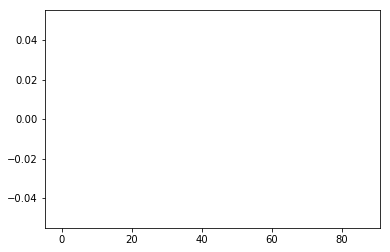

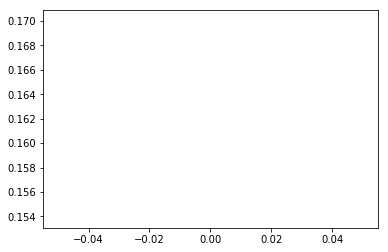

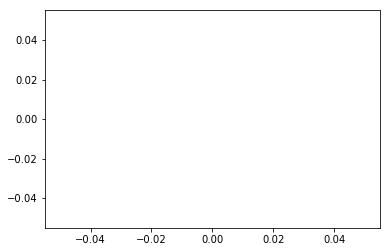

Train Epoch: 1 [0/65192 (0%)]	Loss: 0.107776
Train Epoch: 1 [6400/65192 (10%)]	Loss: 0.108152
Train Epoch: 1 [12800/65192 (20%)]	Loss: 0.108326
Train Epoch: 1 [19200/65192 (29%)]	Loss: 0.108863
Train Epoch: 1 [25600/65192 (39%)]	Loss: 0.109390
Train Epoch: 1 [32000/65192 (49%)]	Loss: 0.107664
Train Epoch: 1 [38400/65192 (59%)]	Loss: 0.108397
Train Epoch: 1 [44800/65192 (69%)]	Loss: 0.107785
Train Epoch: 1 [51200/65192 (79%)]	Loss: 0.108334
Train Epoch: 1 [57600/65192 (88%)]	Loss: 0.108592
Train Epoch: 1 [64000/65192 (98%)]	Loss: 0.106746
Train Epoch: 2 [0/65192 (0%)]	Loss: 0.108394
Train Epoch: 2 [6400/65192 (10%)]	Loss: 0.107669
Train Epoch: 2 [12800/65192 (20%)]	Loss: 0.107641
Train Epoch: 2 [19200/65192 (29%)]	Loss: 0.107611
Train Epoch: 2 [25600/65192 (39%)]	Loss: 0.108224
Train Epoch: 2 [32000/65192 (49%)]	Loss: 0.108099
Train Epoch: 2 [38400/65192 (59%)]	Loss: 0.106981
Train Epoch: 2 [44800/65192 (69%)]	Loss: 0.105543
Train Epoch: 2 [51200/65192 (79%)]	Loss: 0.105259
Train Epoch:

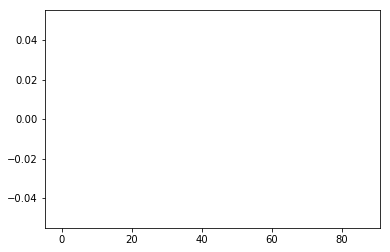

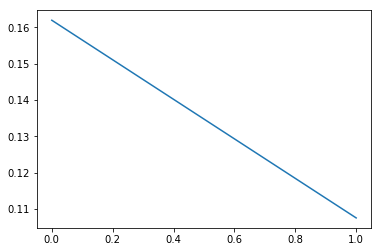

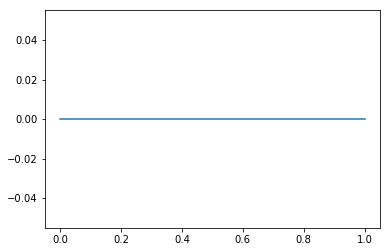

Train Epoch: 3 [0/65192 (0%)]	Loss: 0.105380
Train Epoch: 3 [6400/65192 (10%)]	Loss: 0.104617
Train Epoch: 3 [12800/65192 (20%)]	Loss: 0.102465
Train Epoch: 3 [19200/65192 (29%)]	Loss: 0.102025
Train Epoch: 3 [25600/65192 (39%)]	Loss: 0.097434
Train Epoch: 3 [32000/65192 (49%)]	Loss: 0.094131
Train Epoch: 3 [38400/65192 (59%)]	Loss: 0.095189
Train Epoch: 3 [44800/65192 (69%)]	Loss: 0.087638
Train Epoch: 3 [51200/65192 (79%)]	Loss: 0.087819
Train Epoch: 3 [57600/65192 (88%)]	Loss: 0.082212
Train Epoch: 3 [64000/65192 (98%)]	Loss: 0.082933
Train Epoch: 4 [0/65192 (0%)]	Loss: 0.082819
Train Epoch: 4 [6400/65192 (10%)]	Loss: 0.080516
Train Epoch: 4 [12800/65192 (20%)]	Loss: 0.081522
Train Epoch: 4 [19200/65192 (29%)]	Loss: 0.079667
Train Epoch: 4 [25600/65192 (39%)]	Loss: 0.079587
Train Epoch: 4 [32000/65192 (49%)]	Loss: 0.080400
Train Epoch: 4 [38400/65192 (59%)]	Loss: 0.082289
Train Epoch: 4 [44800/65192 (69%)]	Loss: 0.069204
Train Epoch: 4 [51200/65192 (79%)]	Loss: 0.075543
Train Epoch:

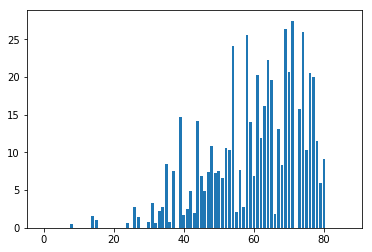

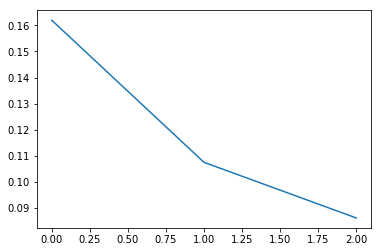

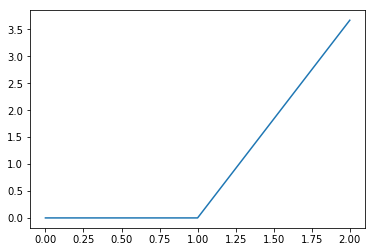

Train Epoch: 5 [0/65192 (0%)]	Loss: 0.065687
Train Epoch: 5 [6400/65192 (10%)]	Loss: 0.074496
Train Epoch: 5 [12800/65192 (20%)]	Loss: 0.068906
Train Epoch: 5 [19200/65192 (29%)]	Loss: 0.066453
Train Epoch: 5 [25600/65192 (39%)]	Loss: 0.062355
Train Epoch: 5 [32000/65192 (49%)]	Loss: 0.067811
Train Epoch: 5 [38400/65192 (59%)]	Loss: 0.066961
Train Epoch: 5 [44800/65192 (69%)]	Loss: 0.065115
Train Epoch: 5 [51200/65192 (79%)]	Loss: 0.059092
Train Epoch: 5 [57600/65192 (88%)]	Loss: 0.063104
Train Epoch: 5 [64000/65192 (98%)]	Loss: 0.070263
Train Epoch: 6 [0/65192 (0%)]	Loss: 0.065031
Train Epoch: 6 [6400/65192 (10%)]	Loss: 0.064351
Train Epoch: 6 [12800/65192 (20%)]	Loss: 0.071608
Train Epoch: 6 [19200/65192 (29%)]	Loss: 0.063929
Train Epoch: 6 [25600/65192 (39%)]	Loss: 0.058073
Train Epoch: 6 [32000/65192 (49%)]	Loss: 0.069407
Train Epoch: 6 [38400/65192 (59%)]	Loss: 0.070801
Train Epoch: 6 [44800/65192 (69%)]	Loss: 0.060780
Train Epoch: 6 [51200/65192 (79%)]	Loss: 0.063257
Train Epoch:

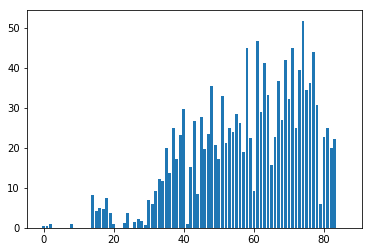

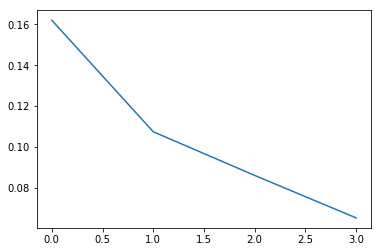

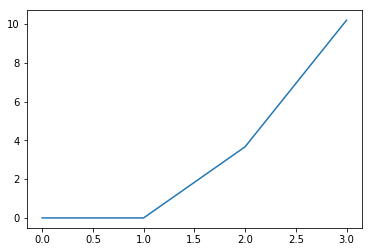

Train Epoch: 7 [0/65192 (0%)]	Loss: 0.060471
Train Epoch: 7 [6400/65192 (10%)]	Loss: 0.063004
Train Epoch: 7 [12800/65192 (20%)]	Loss: 0.054824
Train Epoch: 7 [19200/65192 (29%)]	Loss: 0.064673
Train Epoch: 7 [25600/65192 (39%)]	Loss: 0.056812
Train Epoch: 7 [32000/65192 (49%)]	Loss: 0.056473
Train Epoch: 7 [38400/65192 (59%)]	Loss: 0.058082
Train Epoch: 7 [44800/65192 (69%)]	Loss: 0.060973
Train Epoch: 7 [51200/65192 (79%)]	Loss: 0.061893
Train Epoch: 7 [57600/65192 (88%)]	Loss: 0.065057
Train Epoch: 7 [64000/65192 (98%)]	Loss: 0.047981
Train Epoch: 8 [0/65192 (0%)]	Loss: 0.058853
Train Epoch: 8 [6400/65192 (10%)]	Loss: 0.064177
Train Epoch: 8 [12800/65192 (20%)]	Loss: 0.059156
Train Epoch: 8 [19200/65192 (29%)]	Loss: 0.063778
Train Epoch: 8 [25600/65192 (39%)]	Loss: 0.047023
Train Epoch: 8 [32000/65192 (49%)]	Loss: 0.055827
Train Epoch: 8 [38400/65192 (59%)]	Loss: 0.057206
Train Epoch: 8 [44800/65192 (69%)]	Loss: 0.057871
Train Epoch: 8 [51200/65192 (79%)]	Loss: 0.057343
Train Epoch:

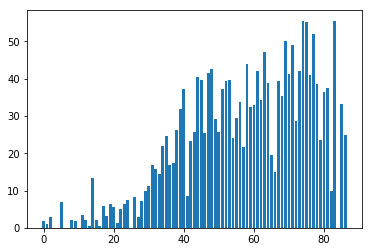

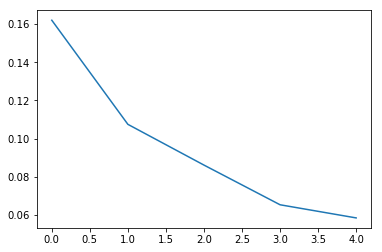

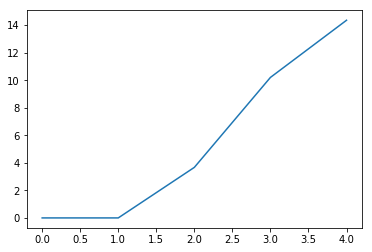

Train Epoch: 9 [0/65192 (0%)]	Loss: 0.056788
Train Epoch: 9 [6400/65192 (10%)]	Loss: 0.058536
Train Epoch: 9 [12800/65192 (20%)]	Loss: 0.055417
Train Epoch: 9 [19200/65192 (29%)]	Loss: 0.061660
Train Epoch: 9 [25600/65192 (39%)]	Loss: 0.061923
Train Epoch: 9 [32000/65192 (49%)]	Loss: 0.052600
Train Epoch: 9 [38400/65192 (59%)]	Loss: 0.059657
Train Epoch: 9 [44800/65192 (69%)]	Loss: 0.055590
Train Epoch: 9 [51200/65192 (79%)]	Loss: 0.052713
Train Epoch: 9 [57600/65192 (88%)]	Loss: 0.064898
Train Epoch: 9 [64000/65192 (98%)]	Loss: 0.052614
Train Epoch: 10 [0/65192 (0%)]	Loss: 0.051136
Train Epoch: 10 [6400/65192 (10%)]	Loss: 0.058639
Train Epoch: 10 [12800/65192 (20%)]	Loss: 0.058078
Train Epoch: 10 [19200/65192 (29%)]	Loss: 0.052033
Train Epoch: 10 [25600/65192 (39%)]	Loss: 0.052067
Train Epoch: 10 [32000/65192 (49%)]	Loss: 0.051037
Train Epoch: 10 [38400/65192 (59%)]	Loss: 0.062283
Train Epoch: 10 [44800/65192 (69%)]	Loss: 0.048836
Train Epoch: 10 [51200/65192 (79%)]	Loss: 0.061412
Tra

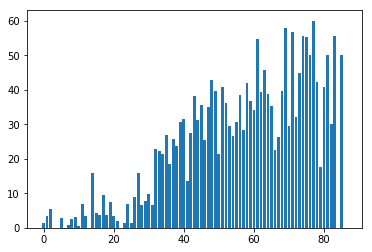

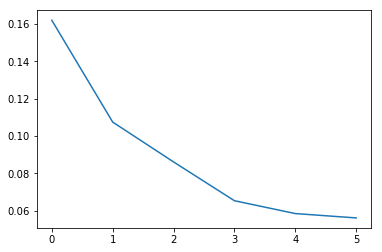

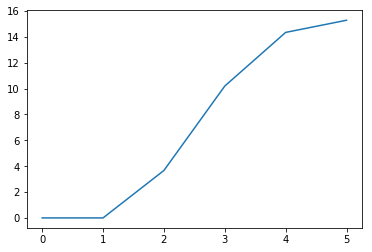

Train Epoch: 11 [0/65192 (0%)]	Loss: 0.057431
Train Epoch: 11 [6400/65192 (10%)]	Loss: 0.058728
Train Epoch: 11 [12800/65192 (20%)]	Loss: 0.057357
Train Epoch: 11 [19200/65192 (29%)]	Loss: 0.061016
Train Epoch: 11 [25600/65192 (39%)]	Loss: 0.058347
Train Epoch: 11 [32000/65192 (49%)]	Loss: 0.056680
Train Epoch: 11 [38400/65192 (59%)]	Loss: 0.052877
Train Epoch: 11 [44800/65192 (69%)]	Loss: 0.051191
Train Epoch: 11 [51200/65192 (79%)]	Loss: 0.048585
Train Epoch: 11 [57600/65192 (88%)]	Loss: 0.070293
Train Epoch: 11 [64000/65192 (98%)]	Loss: 0.058842
Train Epoch: 12 [0/65192 (0%)]	Loss: 0.059758
Train Epoch: 12 [6400/65192 (10%)]	Loss: 0.054738
Train Epoch: 12 [12800/65192 (20%)]	Loss: 0.049922
Train Epoch: 12 [19200/65192 (29%)]	Loss: 0.054951
Train Epoch: 12 [25600/65192 (39%)]	Loss: 0.054628
Train Epoch: 12 [32000/65192 (49%)]	Loss: 0.055939
Train Epoch: 12 [38400/65192 (59%)]	Loss: 0.057904
Train Epoch: 12 [44800/65192 (69%)]	Loss: 0.056856
Train Epoch: 12 [51200/65192 (79%)]	Loss: 0

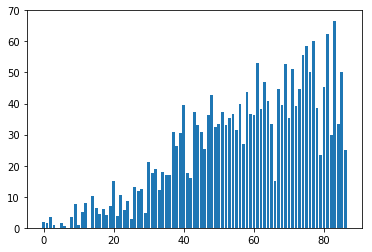

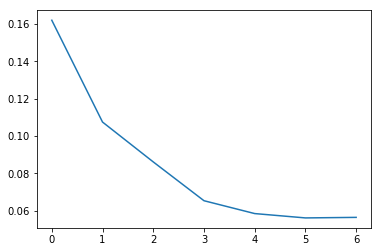

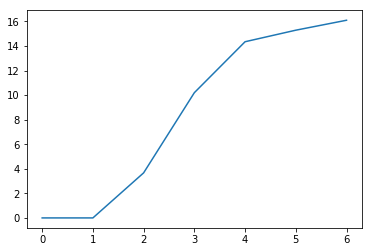

Train Epoch: 13 [0/65192 (0%)]	Loss: 0.054014
Train Epoch: 13 [6400/65192 (10%)]	Loss: 0.056356
Train Epoch: 13 [12800/65192 (20%)]	Loss: 0.057016
Train Epoch: 13 [19200/65192 (29%)]	Loss: 0.053749
Train Epoch: 13 [25600/65192 (39%)]	Loss: 0.066341
Train Epoch: 13 [32000/65192 (49%)]	Loss: 0.071657
Train Epoch: 13 [38400/65192 (59%)]	Loss: 0.059647
Train Epoch: 13 [44800/65192 (69%)]	Loss: 0.051266
Train Epoch: 13 [51200/65192 (79%)]	Loss: 0.057806
Train Epoch: 13 [57600/65192 (88%)]	Loss: 0.046202
Train Epoch: 13 [64000/65192 (98%)]	Loss: 0.043152
Train Epoch: 14 [0/65192 (0%)]	Loss: 0.063519
Train Epoch: 14 [6400/65192 (10%)]	Loss: 0.053914
Train Epoch: 14 [12800/65192 (20%)]	Loss: 0.057174
Train Epoch: 14 [19200/65192 (29%)]	Loss: 0.062956
Train Epoch: 14 [25600/65192 (39%)]	Loss: 0.062382
Train Epoch: 14 [32000/65192 (49%)]	Loss: 0.052513
Train Epoch: 14 [38400/65192 (59%)]	Loss: 0.048361
Train Epoch: 14 [44800/65192 (69%)]	Loss: 0.049480
Train Epoch: 14 [51200/65192 (79%)]	Loss: 0

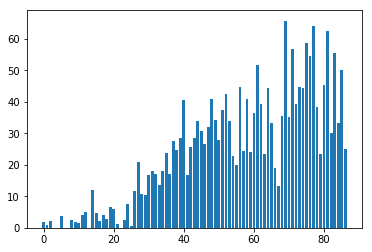

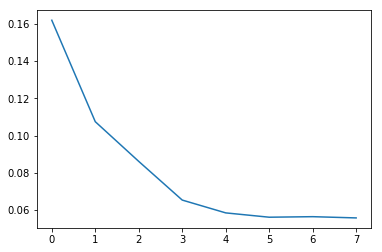

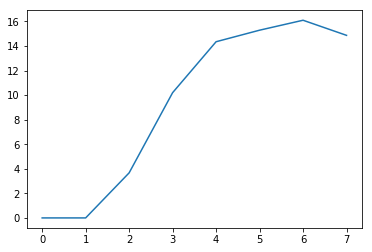

Train Epoch: 15 [0/65192 (0%)]	Loss: 0.049867
Train Epoch: 15 [6400/65192 (10%)]	Loss: 0.059595
Train Epoch: 15 [12800/65192 (20%)]	Loss: 0.048441
Train Epoch: 15 [19200/65192 (29%)]	Loss: 0.050857
Train Epoch: 15 [25600/65192 (39%)]	Loss: 0.054093
Train Epoch: 15 [32000/65192 (49%)]	Loss: 0.057076
Train Epoch: 15 [38400/65192 (59%)]	Loss: 0.049363
Train Epoch: 15 [44800/65192 (69%)]	Loss: 0.052689
Train Epoch: 15 [51200/65192 (79%)]	Loss: 0.055572
Train Epoch: 15 [57600/65192 (88%)]	Loss: 0.060544
Train Epoch: 15 [64000/65192 (98%)]	Loss: 0.056384
Train Epoch: 16 [0/65192 (0%)]	Loss: 0.054931
Train Epoch: 16 [6400/65192 (10%)]	Loss: 0.047157
Train Epoch: 16 [12800/65192 (20%)]	Loss: 0.055917
Train Epoch: 16 [19200/65192 (29%)]	Loss: 0.058591
Train Epoch: 16 [25600/65192 (39%)]	Loss: 0.051218
Train Epoch: 16 [32000/65192 (49%)]	Loss: 0.048675
Train Epoch: 16 [38400/65192 (59%)]	Loss: 0.047594
Train Epoch: 16 [44800/65192 (69%)]	Loss: 0.057146
Train Epoch: 16 [51200/65192 (79%)]	Loss: 0

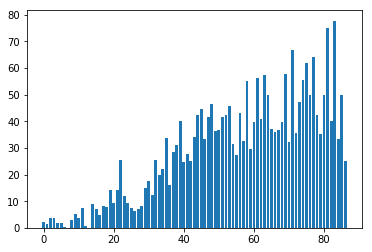

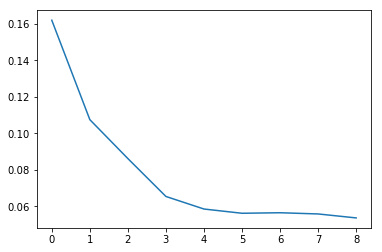

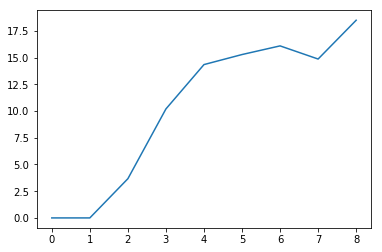

Train Epoch: 17 [0/65192 (0%)]	Loss: 0.049760
Train Epoch: 17 [6400/65192 (10%)]	Loss: 0.048014
Train Epoch: 17 [12800/65192 (20%)]	Loss: 0.052617
Train Epoch: 17 [19200/65192 (29%)]	Loss: 0.051335
Train Epoch: 17 [25600/65192 (39%)]	Loss: 0.055859
Train Epoch: 17 [32000/65192 (49%)]	Loss: 0.049209
Train Epoch: 17 [38400/65192 (59%)]	Loss: 0.050837
Train Epoch: 17 [44800/65192 (69%)]	Loss: 0.057397
Train Epoch: 17 [51200/65192 (79%)]	Loss: 0.051713
Train Epoch: 17 [57600/65192 (88%)]	Loss: 0.047810
Train Epoch: 17 [64000/65192 (98%)]	Loss: 0.052151
Train Epoch: 18 [0/65192 (0%)]	Loss: 0.061882
Train Epoch: 18 [6400/65192 (10%)]	Loss: 0.058395
Train Epoch: 18 [12800/65192 (20%)]	Loss: 0.052367
Train Epoch: 18 [19200/65192 (29%)]	Loss: 0.049197
Train Epoch: 18 [25600/65192 (39%)]	Loss: 0.054888
Train Epoch: 18 [32000/65192 (49%)]	Loss: 0.056769
Train Epoch: 18 [38400/65192 (59%)]	Loss: 0.050465
Train Epoch: 18 [44800/65192 (69%)]	Loss: 0.045870
Train Epoch: 18 [51200/65192 (79%)]	Loss: 0

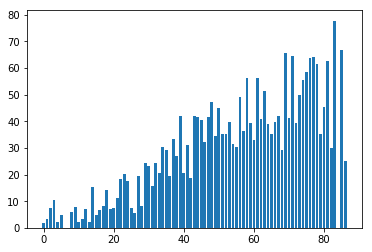

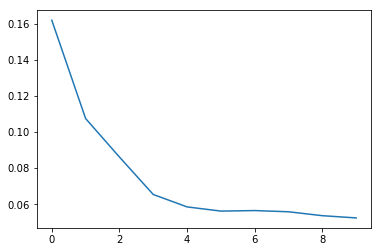

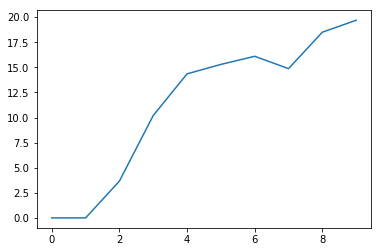

Train Epoch: 19 [0/65192 (0%)]	Loss: 0.048133
Train Epoch: 19 [6400/65192 (10%)]	Loss: 0.049680
Train Epoch: 19 [12800/65192 (20%)]	Loss: 0.053188
Train Epoch: 19 [19200/65192 (29%)]	Loss: 0.041687
Train Epoch: 19 [25600/65192 (39%)]	Loss: 0.052534
Train Epoch: 19 [32000/65192 (49%)]	Loss: 0.050052
Train Epoch: 19 [38400/65192 (59%)]	Loss: 0.043794
Train Epoch: 19 [44800/65192 (69%)]	Loss: 0.056046
Train Epoch: 19 [51200/65192 (79%)]	Loss: 0.044605
Train Epoch: 19 [57600/65192 (88%)]	Loss: 0.053718
Train Epoch: 19 [64000/65192 (98%)]	Loss: 0.049434
Train Epoch: 20 [0/65192 (0%)]	Loss: 0.054797
Train Epoch: 20 [6400/65192 (10%)]	Loss: 0.052450
Train Epoch: 20 [12800/65192 (20%)]	Loss: 0.061140
Train Epoch: 20 [19200/65192 (29%)]	Loss: 0.048464
Train Epoch: 20 [25600/65192 (39%)]	Loss: 0.055358
Train Epoch: 20 [32000/65192 (49%)]	Loss: 0.043556
Train Epoch: 20 [38400/65192 (59%)]	Loss: 0.050372
Train Epoch: 20 [44800/65192 (69%)]	Loss: 0.042999
Train Epoch: 20 [51200/65192 (79%)]	Loss: 0

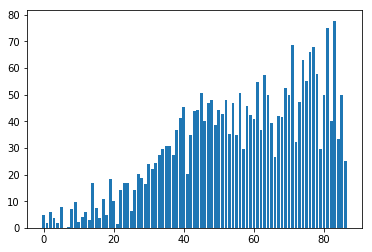

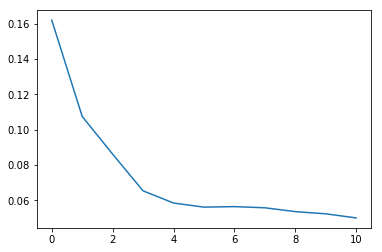

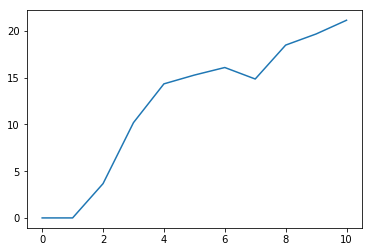

Train Epoch: 21 [0/65192 (0%)]	Loss: 0.054936
Train Epoch: 21 [6400/65192 (10%)]	Loss: 0.049746
Train Epoch: 21 [12800/65192 (20%)]	Loss: 0.048168
Train Epoch: 21 [19200/65192 (29%)]	Loss: 0.050870
Train Epoch: 21 [25600/65192 (39%)]	Loss: 0.049738
Train Epoch: 21 [32000/65192 (49%)]	Loss: 0.048364
Train Epoch: 21 [38400/65192 (59%)]	Loss: 0.051643
Train Epoch: 21 [44800/65192 (69%)]	Loss: 0.053498
Train Epoch: 21 [51200/65192 (79%)]	Loss: 0.045422
Train Epoch: 21 [57600/65192 (88%)]	Loss: 0.049774
Train Epoch: 21 [64000/65192 (98%)]	Loss: 0.054080
Train Epoch: 22 [0/65192 (0%)]	Loss: 0.046630
Train Epoch: 22 [6400/65192 (10%)]	Loss: 0.049852
Train Epoch: 22 [12800/65192 (20%)]	Loss: 0.050295
Train Epoch: 22 [19200/65192 (29%)]	Loss: 0.048576
Train Epoch: 22 [25600/65192 (39%)]	Loss: 0.050431
Train Epoch: 22 [32000/65192 (49%)]	Loss: 0.059964
Train Epoch: 22 [38400/65192 (59%)]	Loss: 0.055198
Train Epoch: 22 [44800/65192 (69%)]	Loss: 0.053962
Train Epoch: 22 [51200/65192 (79%)]	Loss: 0

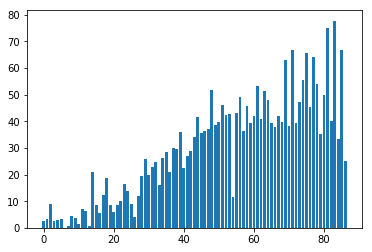

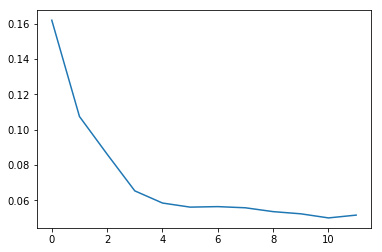

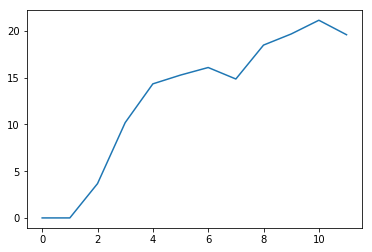

Train Epoch: 23 [0/65192 (0%)]	Loss: 0.057795
Train Epoch: 23 [6400/65192 (10%)]	Loss: 0.044311
Train Epoch: 23 [12800/65192 (20%)]	Loss: 0.045576
Train Epoch: 23 [19200/65192 (29%)]	Loss: 0.053181
Train Epoch: 23 [25600/65192 (39%)]	Loss: 0.054533
Train Epoch: 23 [32000/65192 (49%)]	Loss: 0.054922
Train Epoch: 23 [38400/65192 (59%)]	Loss: 0.055981
Train Epoch: 23 [44800/65192 (69%)]	Loss: 0.056040
Train Epoch: 23 [51200/65192 (79%)]	Loss: 0.043973
Train Epoch: 23 [57600/65192 (88%)]	Loss: 0.048243
Train Epoch: 23 [64000/65192 (98%)]	Loss: 0.046629
Train Epoch: 24 [0/65192 (0%)]	Loss: 0.050682
Train Epoch: 24 [6400/65192 (10%)]	Loss: 0.044188
Train Epoch: 24 [12800/65192 (20%)]	Loss: 0.055336
Train Epoch: 24 [19200/65192 (29%)]	Loss: 0.043050
Train Epoch: 24 [25600/65192 (39%)]	Loss: 0.059455
Train Epoch: 24 [32000/65192 (49%)]	Loss: 0.049787
Train Epoch: 24 [38400/65192 (59%)]	Loss: 0.049955
Train Epoch: 24 [44800/65192 (69%)]	Loss: 0.045903
Train Epoch: 24 [51200/65192 (79%)]	Loss: 0

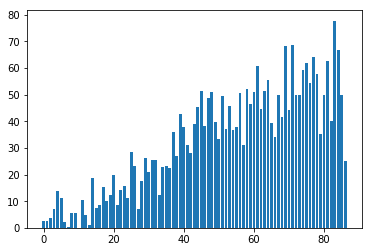

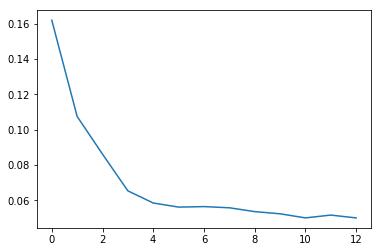

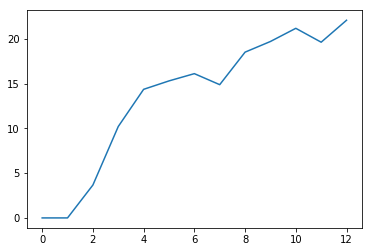

Train Epoch: 25 [0/65192 (0%)]	Loss: 0.057222
Train Epoch: 25 [6400/65192 (10%)]	Loss: 0.047486
Train Epoch: 25 [12800/65192 (20%)]	Loss: 0.044137
Train Epoch: 25 [19200/65192 (29%)]	Loss: 0.044608
Train Epoch: 25 [25600/65192 (39%)]	Loss: 0.049383
Train Epoch: 25 [32000/65192 (49%)]	Loss: 0.050391
Train Epoch: 25 [38400/65192 (59%)]	Loss: 0.051628
Train Epoch: 25 [44800/65192 (69%)]	Loss: 0.046722
Train Epoch: 25 [51200/65192 (79%)]	Loss: 0.055425
Train Epoch: 25 [57600/65192 (88%)]	Loss: 0.040501
Train Epoch: 25 [64000/65192 (98%)]	Loss: 0.046222
Train Epoch: 26 [0/65192 (0%)]	Loss: 0.051546
Train Epoch: 26 [6400/65192 (10%)]	Loss: 0.047355
Train Epoch: 26 [12800/65192 (20%)]	Loss: 0.043468
Train Epoch: 26 [19200/65192 (29%)]	Loss: 0.048470
Train Epoch: 26 [25600/65192 (39%)]	Loss: 0.052544
Train Epoch: 26 [32000/65192 (49%)]	Loss: 0.053375
Train Epoch: 26 [38400/65192 (59%)]	Loss: 0.041087
Train Epoch: 26 [44800/65192 (69%)]	Loss: 0.050009
Train Epoch: 26 [51200/65192 (79%)]	Loss: 0

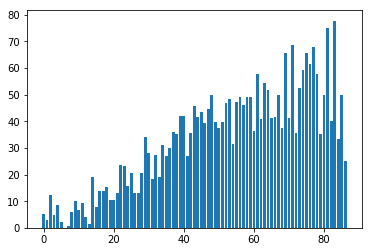

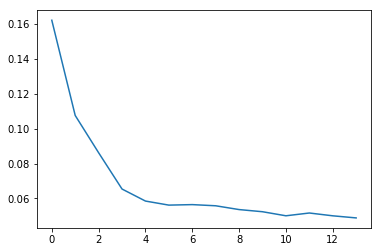

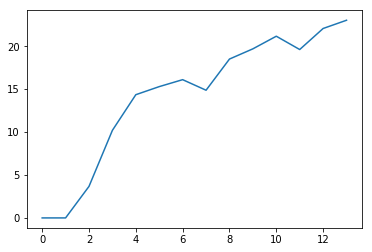

Train Epoch: 27 [0/65192 (0%)]	Loss: 0.047569
Train Epoch: 27 [6400/65192 (10%)]	Loss: 0.049742
Train Epoch: 27 [12800/65192 (20%)]	Loss: 0.047618
Train Epoch: 27 [19200/65192 (29%)]	Loss: 0.035963
Train Epoch: 27 [25600/65192 (39%)]	Loss: 0.041366
Train Epoch: 27 [32000/65192 (49%)]	Loss: 0.041015
Train Epoch: 27 [38400/65192 (59%)]	Loss: 0.040815
Train Epoch: 27 [44800/65192 (69%)]	Loss: 0.044105
Train Epoch: 27 [51200/65192 (79%)]	Loss: 0.052825
Train Epoch: 27 [57600/65192 (88%)]	Loss: 0.042361
Train Epoch: 27 [64000/65192 (98%)]	Loss: 0.048449
Train Epoch: 28 [0/65192 (0%)]	Loss: 0.048082
Train Epoch: 28 [6400/65192 (10%)]	Loss: 0.061996
Train Epoch: 28 [12800/65192 (20%)]	Loss: 0.046660
Train Epoch: 28 [19200/65192 (29%)]	Loss: 0.061153
Train Epoch: 28 [25600/65192 (39%)]	Loss: 0.054280
Train Epoch: 28 [32000/65192 (49%)]	Loss: 0.046342
Train Epoch: 28 [38400/65192 (59%)]	Loss: 0.043364
Train Epoch: 28 [44800/65192 (69%)]	Loss: 0.054880
Train Epoch: 28 [51200/65192 (79%)]	Loss: 0

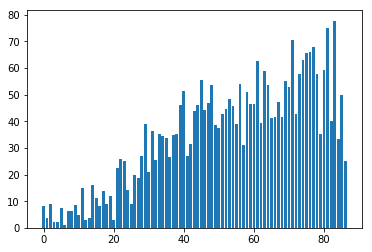

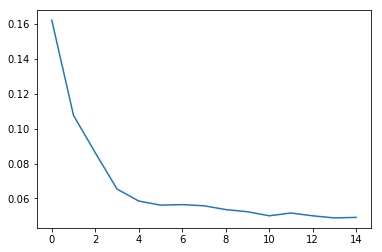

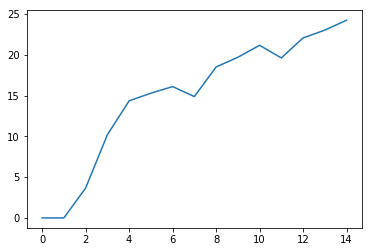

Train Epoch: 29 [0/65192 (0%)]	Loss: 0.046809
Train Epoch: 29 [6400/65192 (10%)]	Loss: 0.053079
Train Epoch: 29 [12800/65192 (20%)]	Loss: 0.054791
Train Epoch: 29 [19200/65192 (29%)]	Loss: 0.040799
Train Epoch: 29 [25600/65192 (39%)]	Loss: 0.055897
Train Epoch: 29 [32000/65192 (49%)]	Loss: 0.052050
Train Epoch: 29 [38400/65192 (59%)]	Loss: 0.046627
Train Epoch: 29 [44800/65192 (69%)]	Loss: 0.051446
Train Epoch: 29 [51200/65192 (79%)]	Loss: 0.049774
Train Epoch: 29 [57600/65192 (88%)]	Loss: 0.048638
Train Epoch: 29 [64000/65192 (98%)]	Loss: 0.044417
Train Epoch: 30 [0/65192 (0%)]	Loss: 0.050520
Train Epoch: 30 [6400/65192 (10%)]	Loss: 0.040346
Train Epoch: 30 [12800/65192 (20%)]	Loss: 0.055342
Train Epoch: 30 [19200/65192 (29%)]	Loss: 0.052158
Train Epoch: 30 [25600/65192 (39%)]	Loss: 0.047430
Train Epoch: 30 [32000/65192 (49%)]	Loss: 0.047446
Train Epoch: 30 [38400/65192 (59%)]	Loss: 0.039733
Train Epoch: 30 [44800/65192 (69%)]	Loss: 0.045241
Train Epoch: 30 [51200/65192 (79%)]	Loss: 0

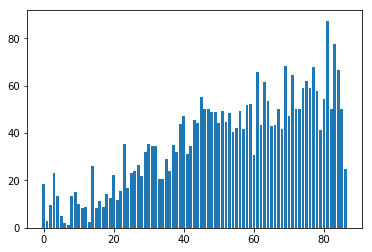

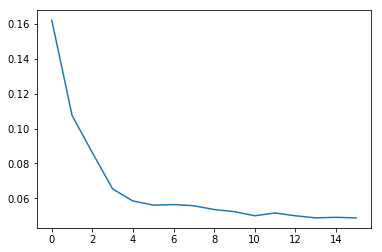

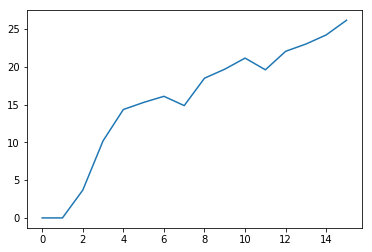

Train Epoch: 31 [0/65192 (0%)]	Loss: 0.048819
Train Epoch: 31 [6400/65192 (10%)]	Loss: 0.040803
Train Epoch: 31 [12800/65192 (20%)]	Loss: 0.043524
Train Epoch: 31 [19200/65192 (29%)]	Loss: 0.047128
Train Epoch: 31 [25600/65192 (39%)]	Loss: 0.041642
Train Epoch: 31 [32000/65192 (49%)]	Loss: 0.052568
Train Epoch: 31 [38400/65192 (59%)]	Loss: 0.053932
Train Epoch: 31 [44800/65192 (69%)]	Loss: 0.047535
Train Epoch: 31 [51200/65192 (79%)]	Loss: 0.048471
Train Epoch: 31 [57600/65192 (88%)]	Loss: 0.041597
Train Epoch: 31 [64000/65192 (98%)]	Loss: 0.054471
Train Epoch: 32 [0/65192 (0%)]	Loss: 0.052287
Train Epoch: 32 [6400/65192 (10%)]	Loss: 0.052908
Train Epoch: 32 [12800/65192 (20%)]	Loss: 0.053784
Train Epoch: 32 [19200/65192 (29%)]	Loss: 0.055923
Train Epoch: 32 [25600/65192 (39%)]	Loss: 0.044983
Train Epoch: 32 [32000/65192 (49%)]	Loss: 0.056018
Train Epoch: 32 [38400/65192 (59%)]	Loss: 0.042858
Train Epoch: 32 [44800/65192 (69%)]	Loss: 0.042634
Train Epoch: 32 [51200/65192 (79%)]	Loss: 0

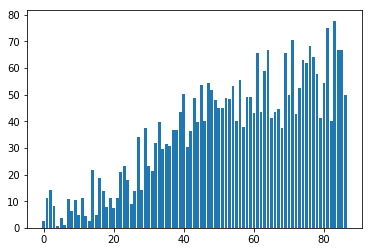

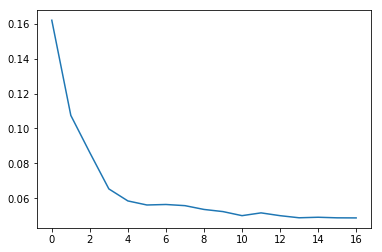

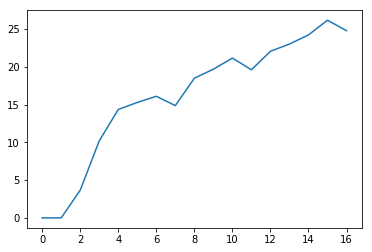

Train Epoch: 33 [0/65192 (0%)]	Loss: 0.059702
Train Epoch: 33 [6400/65192 (10%)]	Loss: 0.040805
Train Epoch: 33 [12800/65192 (20%)]	Loss: 0.046407
Train Epoch: 33 [19200/65192 (29%)]	Loss: 0.046028
Train Epoch: 33 [25600/65192 (39%)]	Loss: 0.045496
Train Epoch: 33 [32000/65192 (49%)]	Loss: 0.050097
Train Epoch: 33 [38400/65192 (59%)]	Loss: 0.043773
Train Epoch: 33 [44800/65192 (69%)]	Loss: 0.049833
Train Epoch: 33 [51200/65192 (79%)]	Loss: 0.051720
Train Epoch: 33 [57600/65192 (88%)]	Loss: 0.051841
Train Epoch: 33 [64000/65192 (98%)]	Loss: 0.049602
Train Epoch: 34 [0/65192 (0%)]	Loss: 0.044562
Train Epoch: 34 [6400/65192 (10%)]	Loss: 0.045550
Train Epoch: 34 [12800/65192 (20%)]	Loss: 0.050447
Train Epoch: 34 [19200/65192 (29%)]	Loss: 0.058710
Train Epoch: 34 [25600/65192 (39%)]	Loss: 0.049689
Train Epoch: 34 [32000/65192 (49%)]	Loss: 0.048650
Train Epoch: 34 [38400/65192 (59%)]	Loss: 0.044222
Train Epoch: 34 [44800/65192 (69%)]	Loss: 0.043734
Train Epoch: 34 [51200/65192 (79%)]	Loss: 0

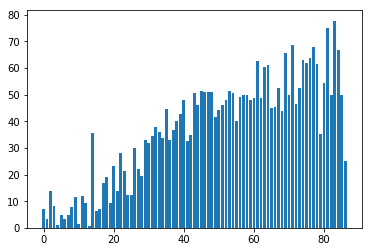

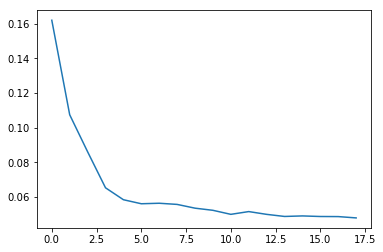

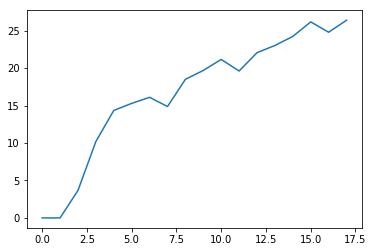

Train Epoch: 35 [0/65192 (0%)]	Loss: 0.047316
Train Epoch: 35 [6400/65192 (10%)]	Loss: 0.049046
Train Epoch: 35 [12800/65192 (20%)]	Loss: 0.051923
Train Epoch: 35 [19200/65192 (29%)]	Loss: 0.044489
Train Epoch: 35 [25600/65192 (39%)]	Loss: 0.046872
Train Epoch: 35 [32000/65192 (49%)]	Loss: 0.037322
Train Epoch: 35 [38400/65192 (59%)]	Loss: 0.048788
Train Epoch: 35 [44800/65192 (69%)]	Loss: 0.056874
Train Epoch: 35 [51200/65192 (79%)]	Loss: 0.055003
Train Epoch: 35 [57600/65192 (88%)]	Loss: 0.058081
Train Epoch: 35 [64000/65192 (98%)]	Loss: 0.046160
Train Epoch: 36 [0/65192 (0%)]	Loss: 0.053114
Train Epoch: 36 [6400/65192 (10%)]	Loss: 0.045691
Train Epoch: 36 [12800/65192 (20%)]	Loss: 0.042391
Train Epoch: 36 [19200/65192 (29%)]	Loss: 0.047048
Train Epoch: 36 [25600/65192 (39%)]	Loss: 0.050111
Train Epoch: 36 [32000/65192 (49%)]	Loss: 0.038466
Train Epoch: 36 [38400/65192 (59%)]	Loss: 0.043177
Train Epoch: 36 [44800/65192 (69%)]	Loss: 0.037544
Train Epoch: 36 [51200/65192 (79%)]	Loss: 0

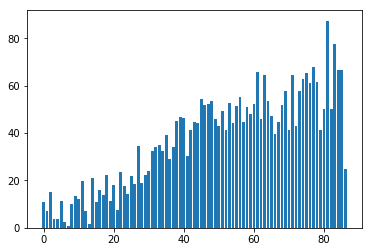

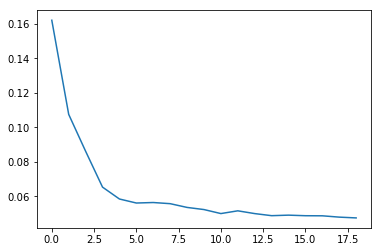

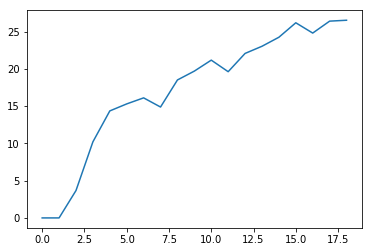

Train Epoch: 37 [0/65192 (0%)]	Loss: 0.050975
Train Epoch: 37 [6400/65192 (10%)]	Loss: 0.050629
Train Epoch: 37 [12800/65192 (20%)]	Loss: 0.046219
Train Epoch: 37 [19200/65192 (29%)]	Loss: 0.043341
Train Epoch: 37 [25600/65192 (39%)]	Loss: 0.044703
Train Epoch: 37 [32000/65192 (49%)]	Loss: 0.040716
Train Epoch: 37 [38400/65192 (59%)]	Loss: 0.044196
Train Epoch: 37 [44800/65192 (69%)]	Loss: 0.044186
Train Epoch: 37 [51200/65192 (79%)]	Loss: 0.046011
Train Epoch: 37 [57600/65192 (88%)]	Loss: 0.044665
Train Epoch: 37 [64000/65192 (98%)]	Loss: 0.055965
Train Epoch: 38 [0/65192 (0%)]	Loss: 0.048764
Train Epoch: 38 [6400/65192 (10%)]	Loss: 0.052464
Train Epoch: 38 [12800/65192 (20%)]	Loss: 0.041215
Train Epoch: 38 [19200/65192 (29%)]	Loss: 0.049654
Train Epoch: 38 [25600/65192 (39%)]	Loss: 0.046567
Train Epoch: 38 [32000/65192 (49%)]	Loss: 0.048889
Train Epoch: 38 [38400/65192 (59%)]	Loss: 0.053606
Train Epoch: 38 [44800/65192 (69%)]	Loss: 0.044340
Train Epoch: 38 [51200/65192 (79%)]	Loss: 0

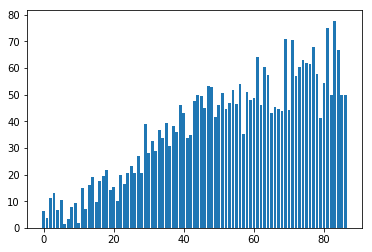

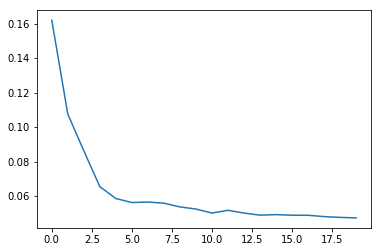

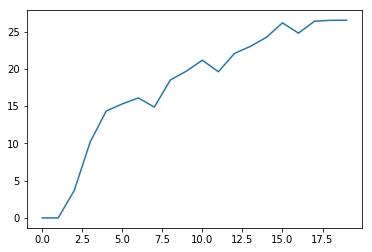

Train Epoch: 39 [0/65192 (0%)]	Loss: 0.044179
Train Epoch: 39 [6400/65192 (10%)]	Loss: 0.044847
Train Epoch: 39 [12800/65192 (20%)]	Loss: 0.044984
Train Epoch: 39 [19200/65192 (29%)]	Loss: 0.048895
Train Epoch: 39 [25600/65192 (39%)]	Loss: 0.036329
Train Epoch: 39 [32000/65192 (49%)]	Loss: 0.042963
Train Epoch: 39 [38400/65192 (59%)]	Loss: 0.042469
Train Epoch: 39 [44800/65192 (69%)]	Loss: 0.045344
Train Epoch: 39 [51200/65192 (79%)]	Loss: 0.052664
Train Epoch: 39 [57600/65192 (88%)]	Loss: 0.039965
Train Epoch: 39 [64000/65192 (98%)]	Loss: 0.041893
Train Epoch: 40 [0/65192 (0%)]	Loss: 0.040381
Train Epoch: 40 [6400/65192 (10%)]	Loss: 0.040535
Train Epoch: 40 [12800/65192 (20%)]	Loss: 0.043374
Train Epoch: 40 [19200/65192 (29%)]	Loss: 0.047096
Train Epoch: 40 [25600/65192 (39%)]	Loss: 0.044525
Train Epoch: 40 [32000/65192 (49%)]	Loss: 0.051461
Train Epoch: 40 [38400/65192 (59%)]	Loss: 0.050328
Train Epoch: 40 [44800/65192 (69%)]	Loss: 0.038990
Train Epoch: 40 [51200/65192 (79%)]	Loss: 0

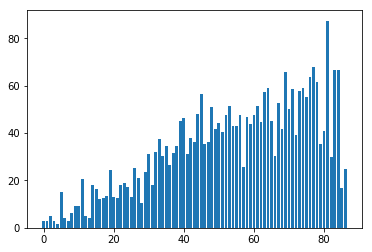

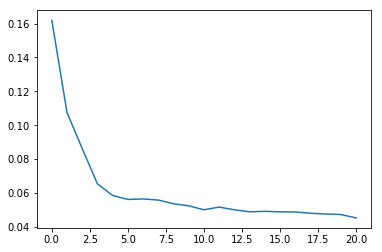

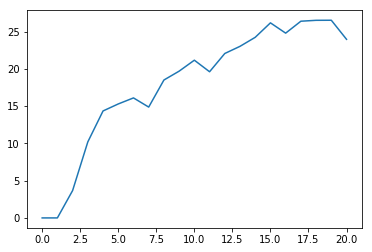

Train Epoch: 41 [0/65192 (0%)]	Loss: 0.045487
Train Epoch: 41 [6400/65192 (10%)]	Loss: 0.048064
Train Epoch: 41 [12800/65192 (20%)]	Loss: 0.059333
Train Epoch: 41 [19200/65192 (29%)]	Loss: 0.043380
Train Epoch: 41 [25600/65192 (39%)]	Loss: 0.047070
Train Epoch: 41 [32000/65192 (49%)]	Loss: 0.046788
Train Epoch: 41 [38400/65192 (59%)]	Loss: 0.047613
Train Epoch: 41 [44800/65192 (69%)]	Loss: 0.048976
Train Epoch: 41 [51200/65192 (79%)]	Loss: 0.041579
Train Epoch: 41 [57600/65192 (88%)]	Loss: 0.060755
Train Epoch: 41 [64000/65192 (98%)]	Loss: 0.049953
Train Epoch: 42 [0/65192 (0%)]	Loss: 0.057105
Train Epoch: 42 [6400/65192 (10%)]	Loss: 0.050175
Train Epoch: 42 [12800/65192 (20%)]	Loss: 0.045162
Train Epoch: 42 [19200/65192 (29%)]	Loss: 0.039851
Train Epoch: 42 [25600/65192 (39%)]	Loss: 0.043609
Train Epoch: 42 [32000/65192 (49%)]	Loss: 0.049903
Train Epoch: 42 [38400/65192 (59%)]	Loss: 0.042886
Train Epoch: 42 [44800/65192 (69%)]	Loss: 0.052376
Train Epoch: 42 [51200/65192 (79%)]	Loss: 0

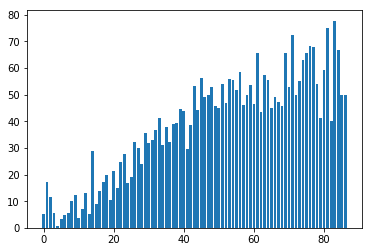

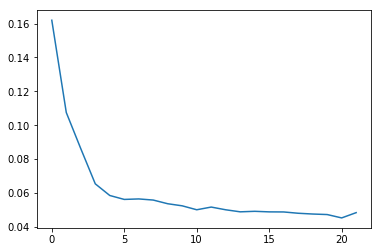

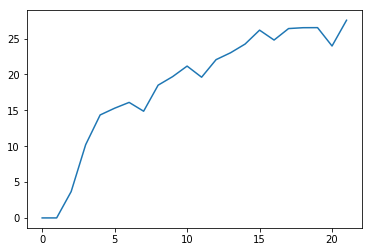

Train Epoch: 43 [0/65192 (0%)]	Loss: 0.046906
Train Epoch: 43 [6400/65192 (10%)]	Loss: 0.039679
Train Epoch: 43 [12800/65192 (20%)]	Loss: 0.037814
Train Epoch: 43 [19200/65192 (29%)]	Loss: 0.046505
Train Epoch: 43 [25600/65192 (39%)]	Loss: 0.040309
Train Epoch: 43 [32000/65192 (49%)]	Loss: 0.043077
Train Epoch: 43 [38400/65192 (59%)]	Loss: 0.042206
Train Epoch: 43 [44800/65192 (69%)]	Loss: 0.048024
Train Epoch: 43 [51200/65192 (79%)]	Loss: 0.048809
Train Epoch: 43 [57600/65192 (88%)]	Loss: 0.042609
Train Epoch: 43 [64000/65192 (98%)]	Loss: 0.046115
Train Epoch: 44 [0/65192 (0%)]	Loss: 0.042216
Train Epoch: 44 [6400/65192 (10%)]	Loss: 0.039747
Train Epoch: 44 [12800/65192 (20%)]	Loss: 0.043000
Train Epoch: 44 [19200/65192 (29%)]	Loss: 0.053532
Train Epoch: 44 [25600/65192 (39%)]	Loss: 0.050916
Train Epoch: 44 [32000/65192 (49%)]	Loss: 0.045502
Train Epoch: 44 [38400/65192 (59%)]	Loss: 0.046768
Train Epoch: 44 [44800/65192 (69%)]	Loss: 0.040296
Train Epoch: 44 [51200/65192 (79%)]	Loss: 0

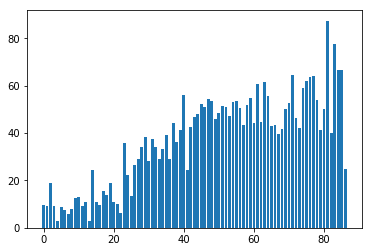

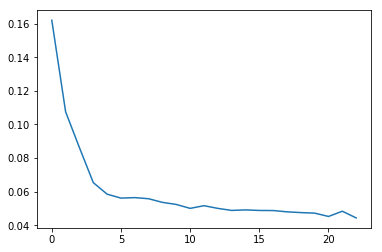

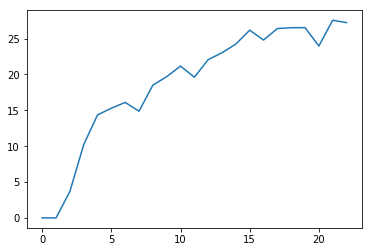

Train Epoch: 45 [0/65192 (0%)]	Loss: 0.043605
Train Epoch: 45 [6400/65192 (10%)]	Loss: 0.041162
Train Epoch: 45 [12800/65192 (20%)]	Loss: 0.053276
Train Epoch: 45 [19200/65192 (29%)]	Loss: 0.037787
Train Epoch: 45 [25600/65192 (39%)]	Loss: 0.044376
Train Epoch: 45 [32000/65192 (49%)]	Loss: 0.049748
Train Epoch: 45 [38400/65192 (59%)]	Loss: 0.038866
Train Epoch: 45 [44800/65192 (69%)]	Loss: 0.048313
Train Epoch: 45 [51200/65192 (79%)]	Loss: 0.045755
Train Epoch: 45 [57600/65192 (88%)]	Loss: 0.046097
Train Epoch: 45 [64000/65192 (98%)]	Loss: 0.046717
Train Epoch: 46 [0/65192 (0%)]	Loss: 0.049968
Train Epoch: 46 [6400/65192 (10%)]	Loss: 0.054479
Train Epoch: 46 [12800/65192 (20%)]	Loss: 0.045832
Train Epoch: 46 [19200/65192 (29%)]	Loss: 0.049420
Train Epoch: 46 [25600/65192 (39%)]	Loss: 0.038948
Train Epoch: 46 [32000/65192 (49%)]	Loss: 0.043642
Train Epoch: 46 [38400/65192 (59%)]	Loss: 0.036098
Train Epoch: 46 [44800/65192 (69%)]	Loss: 0.038621
Train Epoch: 46 [51200/65192 (79%)]	Loss: 0

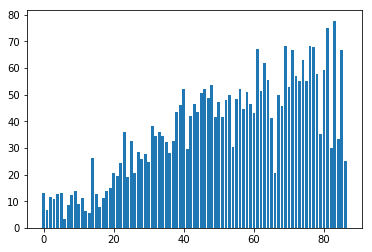

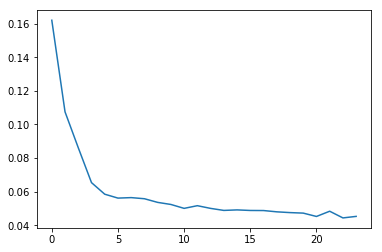

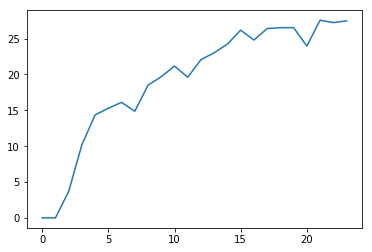

Train Epoch: 47 [0/65192 (0%)]	Loss: 0.049918
Train Epoch: 47 [6400/65192 (10%)]	Loss: 0.045326
Train Epoch: 47 [12800/65192 (20%)]	Loss: 0.040477
Train Epoch: 47 [19200/65192 (29%)]	Loss: 0.050438
Train Epoch: 47 [25600/65192 (39%)]	Loss: 0.035602
Train Epoch: 47 [32000/65192 (49%)]	Loss: 0.043021
Train Epoch: 47 [38400/65192 (59%)]	Loss: 0.038742
Train Epoch: 47 [44800/65192 (69%)]	Loss: 0.039098
Train Epoch: 47 [51200/65192 (79%)]	Loss: 0.048850
Train Epoch: 47 [57600/65192 (88%)]	Loss: 0.041706
Train Epoch: 47 [64000/65192 (98%)]	Loss: 0.043034
Train Epoch: 48 [0/65192 (0%)]	Loss: 0.066343
Train Epoch: 48 [6400/65192 (10%)]	Loss: 0.033758
Train Epoch: 48 [12800/65192 (20%)]	Loss: 0.040661
Train Epoch: 48 [19200/65192 (29%)]	Loss: 0.043606
Train Epoch: 48 [25600/65192 (39%)]	Loss: 0.043637
Train Epoch: 48 [32000/65192 (49%)]	Loss: 0.047647
Train Epoch: 48 [38400/65192 (59%)]	Loss: 0.044476
Train Epoch: 48 [44800/65192 (69%)]	Loss: 0.041375
Train Epoch: 48 [51200/65192 (79%)]	Loss: 0

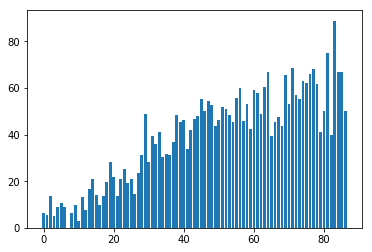

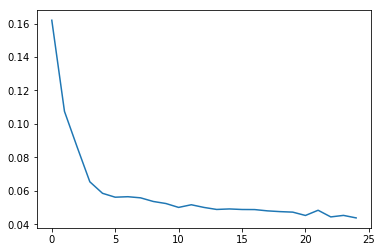

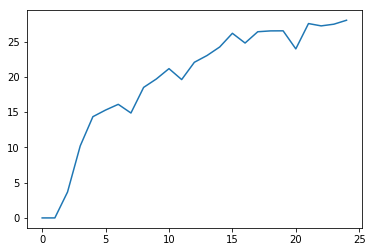

Train Epoch: 49 [0/65192 (0%)]	Loss: 0.039925
Train Epoch: 49 [6400/65192 (10%)]	Loss: 0.046721
Train Epoch: 49 [12800/65192 (20%)]	Loss: 0.044512
Train Epoch: 49 [19200/65192 (29%)]	Loss: 0.050099
Train Epoch: 49 [25600/65192 (39%)]	Loss: 0.047843
Train Epoch: 49 [32000/65192 (49%)]	Loss: 0.048686
Train Epoch: 49 [38400/65192 (59%)]	Loss: 0.044416
Train Epoch: 49 [44800/65192 (69%)]	Loss: 0.038641
Train Epoch: 49 [51200/65192 (79%)]	Loss: 0.044802
Train Epoch: 49 [57600/65192 (88%)]	Loss: 0.045585
Train Epoch: 49 [64000/65192 (98%)]	Loss: 0.038862
Train Epoch: 50 [0/65192 (0%)]	Loss: 0.042751
Train Epoch: 50 [6400/65192 (10%)]	Loss: 0.033657
Train Epoch: 50 [12800/65192 (20%)]	Loss: 0.042609
Train Epoch: 50 [19200/65192 (29%)]	Loss: 0.040861
Train Epoch: 50 [25600/65192 (39%)]	Loss: 0.054387
Train Epoch: 50 [32000/65192 (49%)]	Loss: 0.044169
Train Epoch: 50 [38400/65192 (59%)]	Loss: 0.037438
Train Epoch: 50 [44800/65192 (69%)]	Loss: 0.043301
Train Epoch: 50 [51200/65192 (79%)]	Loss: 0

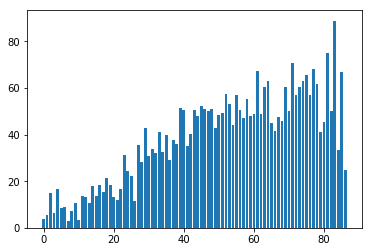

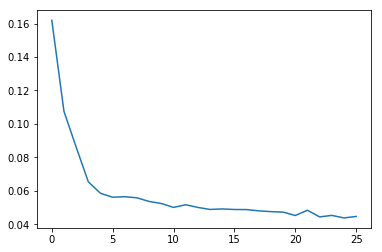

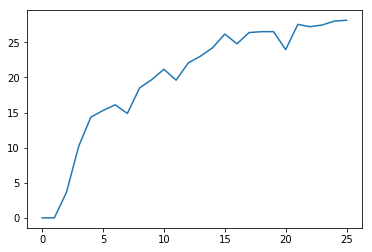

Train Epoch: 51 [0/65192 (0%)]	Loss: 0.040325
Train Epoch: 51 [6400/65192 (10%)]	Loss: 0.047445
Train Epoch: 51 [12800/65192 (20%)]	Loss: 0.046542
Train Epoch: 51 [19200/65192 (29%)]	Loss: 0.047674
Train Epoch: 51 [25600/65192 (39%)]	Loss: 0.044656
Train Epoch: 51 [32000/65192 (49%)]	Loss: 0.034155
Train Epoch: 51 [38400/65192 (59%)]	Loss: 0.037110
Train Epoch: 51 [44800/65192 (69%)]	Loss: 0.042198
Train Epoch: 51 [51200/65192 (79%)]	Loss: 0.042320
Train Epoch: 51 [57600/65192 (88%)]	Loss: 0.040630
Train Epoch: 51 [64000/65192 (98%)]	Loss: 0.047802
Train Epoch: 52 [0/65192 (0%)]	Loss: 0.059973
Train Epoch: 52 [6400/65192 (10%)]	Loss: 0.046067
Train Epoch: 52 [12800/65192 (20%)]	Loss: 0.039065
Train Epoch: 52 [19200/65192 (29%)]	Loss: 0.045519
Train Epoch: 52 [25600/65192 (39%)]	Loss: 0.046251
Train Epoch: 52 [32000/65192 (49%)]	Loss: 0.045047
Train Epoch: 52 [38400/65192 (59%)]	Loss: 0.053174
Train Epoch: 52 [44800/65192 (69%)]	Loss: 0.034223
Train Epoch: 52 [51200/65192 (79%)]	Loss: 0

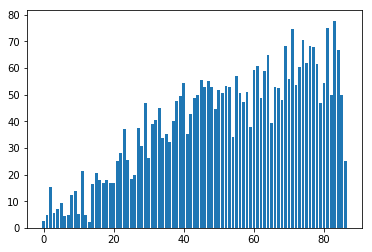

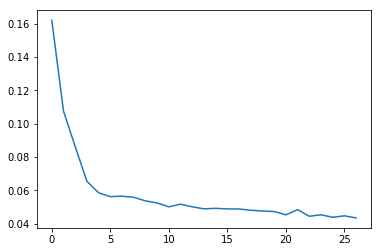

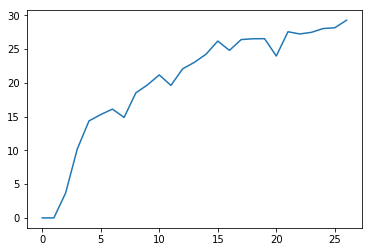

Train Epoch: 53 [0/65192 (0%)]	Loss: 0.043404
Train Epoch: 53 [6400/65192 (10%)]	Loss: 0.043541
Train Epoch: 53 [12800/65192 (20%)]	Loss: 0.037897
Train Epoch: 53 [19200/65192 (29%)]	Loss: 0.054500
Train Epoch: 53 [25600/65192 (39%)]	Loss: 0.051656
Train Epoch: 53 [32000/65192 (49%)]	Loss: 0.049083
Train Epoch: 53 [38400/65192 (59%)]	Loss: 0.054332
Train Epoch: 53 [44800/65192 (69%)]	Loss: 0.043573
Train Epoch: 53 [51200/65192 (79%)]	Loss: 0.045877
Train Epoch: 53 [57600/65192 (88%)]	Loss: 0.048549
Train Epoch: 53 [64000/65192 (98%)]	Loss: 0.043804
Train Epoch: 54 [0/65192 (0%)]	Loss: 0.049547
Train Epoch: 54 [6400/65192 (10%)]	Loss: 0.062219
Train Epoch: 54 [12800/65192 (20%)]	Loss: 0.044655
Train Epoch: 54 [19200/65192 (29%)]	Loss: 0.042881
Train Epoch: 54 [25600/65192 (39%)]	Loss: 0.039999
Train Epoch: 54 [32000/65192 (49%)]	Loss: 0.041351
Train Epoch: 54 [38400/65192 (59%)]	Loss: 0.035751
Train Epoch: 54 [44800/65192 (69%)]	Loss: 0.043491
Train Epoch: 54 [51200/65192 (79%)]	Loss: 0

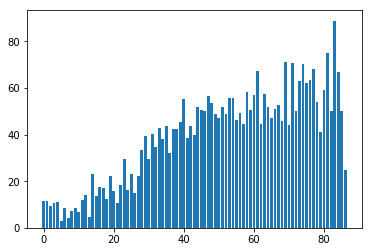

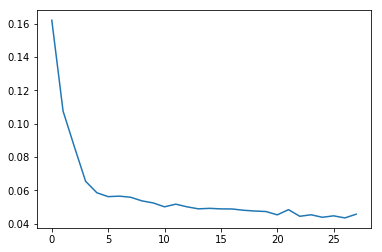

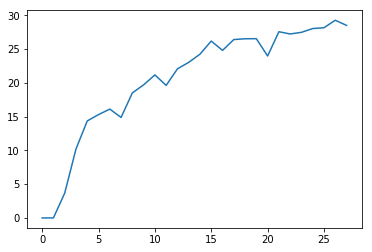

Train Epoch: 55 [0/65192 (0%)]	Loss: 0.044270
Train Epoch: 55 [6400/65192 (10%)]	Loss: 0.039102
Train Epoch: 55 [12800/65192 (20%)]	Loss: 0.041066
Train Epoch: 55 [19200/65192 (29%)]	Loss: 0.038979
Train Epoch: 55 [25600/65192 (39%)]	Loss: 0.044759
Train Epoch: 55 [32000/65192 (49%)]	Loss: 0.043787
Train Epoch: 55 [38400/65192 (59%)]	Loss: 0.045048
Train Epoch: 55 [44800/65192 (69%)]	Loss: 0.047842
Train Epoch: 55 [51200/65192 (79%)]	Loss: 0.048641
Train Epoch: 55 [57600/65192 (88%)]	Loss: 0.040679
Train Epoch: 55 [64000/65192 (98%)]	Loss: 0.047661
Train Epoch: 56 [0/65192 (0%)]	Loss: 0.039805
Train Epoch: 56 [6400/65192 (10%)]	Loss: 0.044320
Train Epoch: 56 [12800/65192 (20%)]	Loss: 0.040658
Train Epoch: 56 [19200/65192 (29%)]	Loss: 0.039374
Train Epoch: 56 [25600/65192 (39%)]	Loss: 0.053519
Train Epoch: 56 [32000/65192 (49%)]	Loss: 0.043059
Train Epoch: 56 [38400/65192 (59%)]	Loss: 0.040977
Train Epoch: 56 [44800/65192 (69%)]	Loss: 0.048659
Train Epoch: 56 [51200/65192 (79%)]	Loss: 0

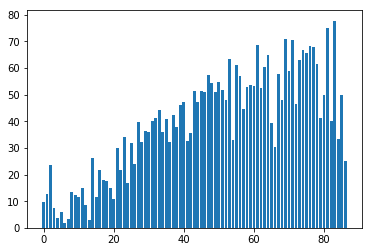

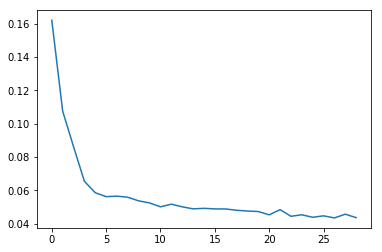

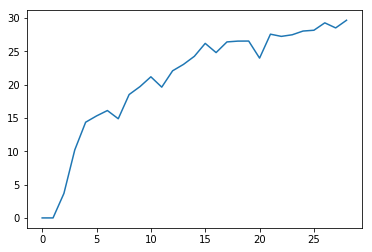

Train Epoch: 57 [0/65192 (0%)]	Loss: 0.046544
Train Epoch: 57 [6400/65192 (10%)]	Loss: 0.047201
Train Epoch: 57 [12800/65192 (20%)]	Loss: 0.042028
Train Epoch: 57 [19200/65192 (29%)]	Loss: 0.041636
Train Epoch: 57 [25600/65192 (39%)]	Loss: 0.050701
Train Epoch: 57 [32000/65192 (49%)]	Loss: 0.049037
Train Epoch: 57 [38400/65192 (59%)]	Loss: 0.044924
Train Epoch: 57 [44800/65192 (69%)]	Loss: 0.035855
Train Epoch: 57 [51200/65192 (79%)]	Loss: 0.045304
Train Epoch: 57 [57600/65192 (88%)]	Loss: 0.046204
Train Epoch: 57 [64000/65192 (98%)]	Loss: 0.040021
Train Epoch: 58 [0/65192 (0%)]	Loss: 0.037112
Train Epoch: 58 [6400/65192 (10%)]	Loss: 0.046887
Train Epoch: 58 [12800/65192 (20%)]	Loss: 0.046919
Train Epoch: 58 [19200/65192 (29%)]	Loss: 0.035462
Train Epoch: 58 [25600/65192 (39%)]	Loss: 0.045804
Train Epoch: 58 [32000/65192 (49%)]	Loss: 0.044603
Train Epoch: 58 [38400/65192 (59%)]	Loss: 0.046162
Train Epoch: 58 [44800/65192 (69%)]	Loss: 0.045859
Train Epoch: 58 [51200/65192 (79%)]	Loss: 0

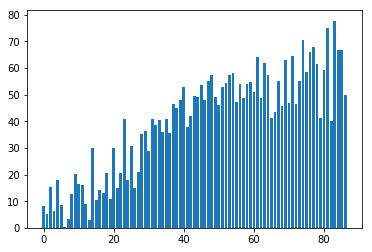

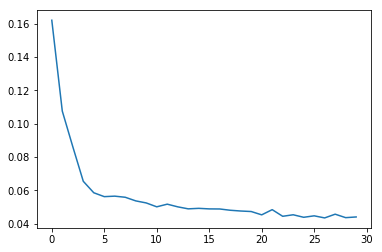

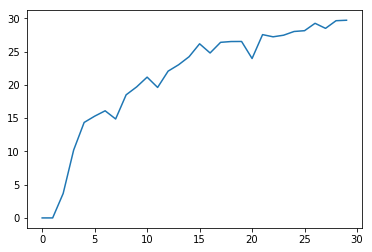

Train Epoch: 59 [0/65192 (0%)]	Loss: 0.038422
Train Epoch: 59 [6400/65192 (10%)]	Loss: 0.052556
Train Epoch: 59 [12800/65192 (20%)]	Loss: 0.039181
Train Epoch: 59 [19200/65192 (29%)]	Loss: 0.045063
Train Epoch: 59 [25600/65192 (39%)]	Loss: 0.041135
Train Epoch: 59 [32000/65192 (49%)]	Loss: 0.044922
Train Epoch: 59 [38400/65192 (59%)]	Loss: 0.037997
Train Epoch: 59 [44800/65192 (69%)]	Loss: 0.042281
Train Epoch: 59 [51200/65192 (79%)]	Loss: 0.048113
Train Epoch: 59 [57600/65192 (88%)]	Loss: 0.044480
Train Epoch: 59 [64000/65192 (98%)]	Loss: 0.043845
Train Epoch: 60 [0/65192 (0%)]	Loss: 0.039771
Train Epoch: 60 [6400/65192 (10%)]	Loss: 0.039001
Train Epoch: 60 [12800/65192 (20%)]	Loss: 0.047964
Train Epoch: 60 [19200/65192 (29%)]	Loss: 0.044774
Train Epoch: 60 [25600/65192 (39%)]	Loss: 0.043124
Train Epoch: 60 [32000/65192 (49%)]	Loss: 0.036842
Train Epoch: 60 [38400/65192 (59%)]	Loss: 0.042304
Train Epoch: 60 [44800/65192 (69%)]	Loss: 0.041904
Train Epoch: 60 [51200/65192 (79%)]	Loss: 0

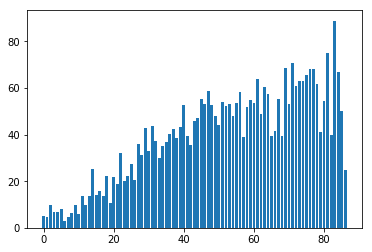

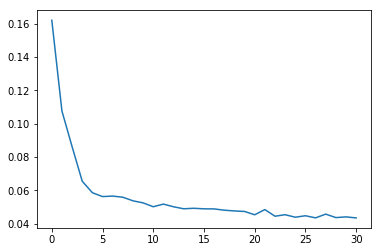

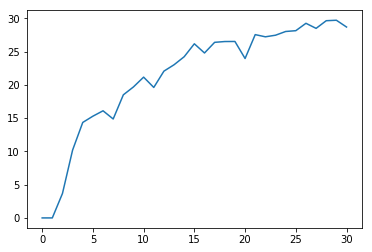

Train Epoch: 61 [0/65192 (0%)]	Loss: 0.044662
Train Epoch: 61 [6400/65192 (10%)]	Loss: 0.046834
Train Epoch: 61 [12800/65192 (20%)]	Loss: 0.034918
Train Epoch: 61 [19200/65192 (29%)]	Loss: 0.039598
Train Epoch: 61 [25600/65192 (39%)]	Loss: 0.048460
Train Epoch: 61 [32000/65192 (49%)]	Loss: 0.051751
Train Epoch: 61 [38400/65192 (59%)]	Loss: 0.054628
Train Epoch: 61 [44800/65192 (69%)]	Loss: 0.041463
Train Epoch: 61 [51200/65192 (79%)]	Loss: 0.041275
Train Epoch: 61 [57600/65192 (88%)]	Loss: 0.053051
Train Epoch: 61 [64000/65192 (98%)]	Loss: 0.038996
Train Epoch: 62 [0/65192 (0%)]	Loss: 0.038373
Train Epoch: 62 [6400/65192 (10%)]	Loss: 0.038450
Train Epoch: 62 [12800/65192 (20%)]	Loss: 0.048138
Train Epoch: 62 [19200/65192 (29%)]	Loss: 0.048825
Train Epoch: 62 [25600/65192 (39%)]	Loss: 0.043716
Train Epoch: 62 [32000/65192 (49%)]	Loss: 0.036144
Train Epoch: 62 [38400/65192 (59%)]	Loss: 0.037043
Train Epoch: 62 [44800/65192 (69%)]	Loss: 0.046285
Train Epoch: 62 [51200/65192 (79%)]	Loss: 0

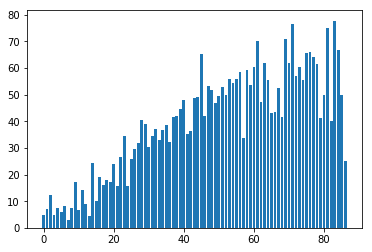

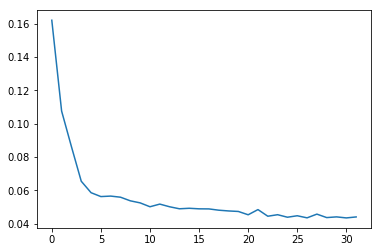

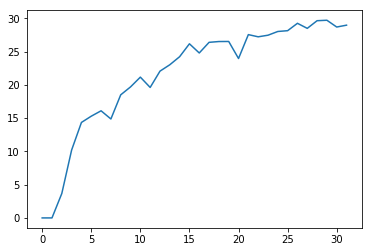

Train Epoch: 63 [0/65192 (0%)]	Loss: 0.044513
Train Epoch: 63 [6400/65192 (10%)]	Loss: 0.040078
Train Epoch: 63 [12800/65192 (20%)]	Loss: 0.046268
Train Epoch: 63 [19200/65192 (29%)]	Loss: 0.048276
Train Epoch: 63 [25600/65192 (39%)]	Loss: 0.044622
Train Epoch: 63 [32000/65192 (49%)]	Loss: 0.053637
Train Epoch: 63 [38400/65192 (59%)]	Loss: 0.045645
Train Epoch: 63 [44800/65192 (69%)]	Loss: 0.040543
Train Epoch: 63 [51200/65192 (79%)]	Loss: 0.049932
Train Epoch: 63 [57600/65192 (88%)]	Loss: 0.048028
Train Epoch: 63 [64000/65192 (98%)]	Loss: 0.045364
Train Epoch: 64 [0/65192 (0%)]	Loss: 0.044155
Train Epoch: 64 [6400/65192 (10%)]	Loss: 0.057890
Train Epoch: 64 [12800/65192 (20%)]	Loss: 0.044138
Train Epoch: 64 [19200/65192 (29%)]	Loss: 0.039946
Train Epoch: 64 [25600/65192 (39%)]	Loss: 0.051470
Train Epoch: 64 [32000/65192 (49%)]	Loss: 0.043460
Train Epoch: 64 [38400/65192 (59%)]	Loss: 0.043803
Train Epoch: 64 [44800/65192 (69%)]	Loss: 0.050106
Train Epoch: 64 [51200/65192 (79%)]	Loss: 0

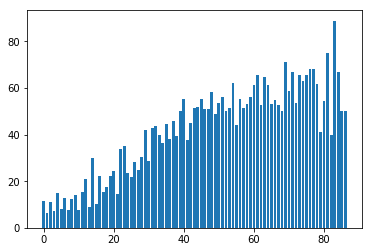

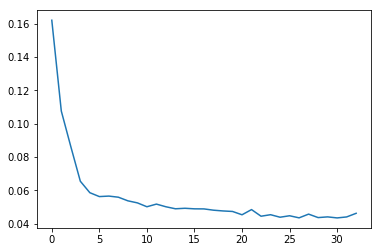

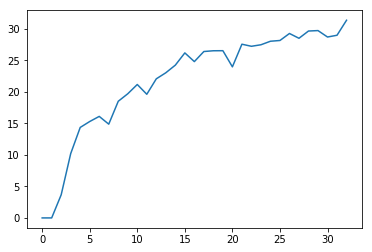

Train Epoch: 65 [0/65192 (0%)]	Loss: 0.044563
Train Epoch: 65 [6400/65192 (10%)]	Loss: 0.051649
Train Epoch: 65 [12800/65192 (20%)]	Loss: 0.044744
Train Epoch: 65 [19200/65192 (29%)]	Loss: 0.040892
Train Epoch: 65 [25600/65192 (39%)]	Loss: 0.043555
Train Epoch: 65 [32000/65192 (49%)]	Loss: 0.041882
Train Epoch: 65 [38400/65192 (59%)]	Loss: 0.052540
Train Epoch: 65 [44800/65192 (69%)]	Loss: 0.043370
Train Epoch: 65 [51200/65192 (79%)]	Loss: 0.042730
Train Epoch: 65 [57600/65192 (88%)]	Loss: 0.039857
Train Epoch: 65 [64000/65192 (98%)]	Loss: 0.036112
Train Epoch: 66 [0/65192 (0%)]	Loss: 0.049904
Train Epoch: 66 [6400/65192 (10%)]	Loss: 0.045785
Train Epoch: 66 [12800/65192 (20%)]	Loss: 0.044460
Train Epoch: 66 [19200/65192 (29%)]	Loss: 0.042000
Train Epoch: 66 [25600/65192 (39%)]	Loss: 0.046451
Train Epoch: 66 [32000/65192 (49%)]	Loss: 0.041135
Train Epoch: 66 [38400/65192 (59%)]	Loss: 0.044420
Train Epoch: 66 [44800/65192 (69%)]	Loss: 0.036306
Train Epoch: 66 [51200/65192 (79%)]	Loss: 0

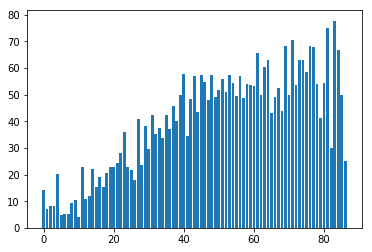

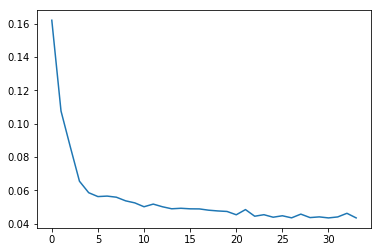

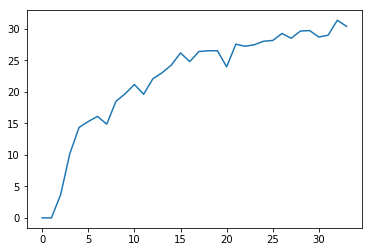

Train Epoch: 67 [0/65192 (0%)]	Loss: 0.040524
Train Epoch: 67 [6400/65192 (10%)]	Loss: 0.043178
Train Epoch: 67 [12800/65192 (20%)]	Loss: 0.037188
Train Epoch: 67 [19200/65192 (29%)]	Loss: 0.038309
Train Epoch: 67 [25600/65192 (39%)]	Loss: 0.049681
Train Epoch: 67 [32000/65192 (49%)]	Loss: 0.043595
Train Epoch: 67 [38400/65192 (59%)]	Loss: 0.049701
Train Epoch: 67 [44800/65192 (69%)]	Loss: 0.051270
Train Epoch: 67 [51200/65192 (79%)]	Loss: 0.044896
Train Epoch: 67 [57600/65192 (88%)]	Loss: 0.042097
Train Epoch: 67 [64000/65192 (98%)]	Loss: 0.040105
Train Epoch: 68 [0/65192 (0%)]	Loss: 0.041557
Train Epoch: 68 [6400/65192 (10%)]	Loss: 0.044518
Train Epoch: 68 [12800/65192 (20%)]	Loss: 0.039860
Train Epoch: 68 [19200/65192 (29%)]	Loss: 0.049211
Train Epoch: 68 [25600/65192 (39%)]	Loss: 0.043901
Train Epoch: 68 [32000/65192 (49%)]	Loss: 0.044663
Train Epoch: 68 [38400/65192 (59%)]	Loss: 0.049074
Train Epoch: 68 [44800/65192 (69%)]	Loss: 0.046938
Train Epoch: 68 [51200/65192 (79%)]	Loss: 0

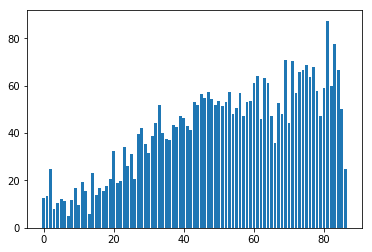

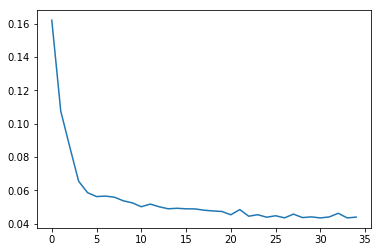

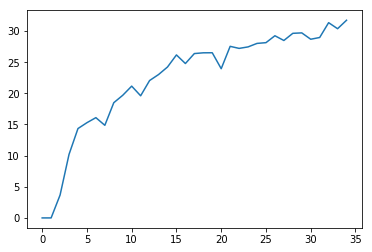

Train Epoch: 69 [0/65192 (0%)]	Loss: 0.042743
Train Epoch: 69 [6400/65192 (10%)]	Loss: 0.049553
Train Epoch: 69 [12800/65192 (20%)]	Loss: 0.039242
Train Epoch: 69 [19200/65192 (29%)]	Loss: 0.058711
Train Epoch: 69 [25600/65192 (39%)]	Loss: 0.032068
Train Epoch: 69 [32000/65192 (49%)]	Loss: 0.051081
Train Epoch: 69 [38400/65192 (59%)]	Loss: 0.039554
Train Epoch: 69 [44800/65192 (69%)]	Loss: 0.045968
Train Epoch: 69 [51200/65192 (79%)]	Loss: 0.038212
Train Epoch: 69 [57600/65192 (88%)]	Loss: 0.039720
Train Epoch: 69 [64000/65192 (98%)]	Loss: 0.040789
Train Epoch: 70 [0/65192 (0%)]	Loss: 0.040588
Train Epoch: 70 [6400/65192 (10%)]	Loss: 0.039334
Train Epoch: 70 [12800/65192 (20%)]	Loss: 0.039874
Train Epoch: 70 [19200/65192 (29%)]	Loss: 0.050019
Train Epoch: 70 [25600/65192 (39%)]	Loss: 0.042697
Train Epoch: 70 [32000/65192 (49%)]	Loss: 0.039252
Train Epoch: 70 [38400/65192 (59%)]	Loss: 0.035400
Train Epoch: 70 [44800/65192 (69%)]	Loss: 0.042824
Train Epoch: 70 [51200/65192 (79%)]	Loss: 0

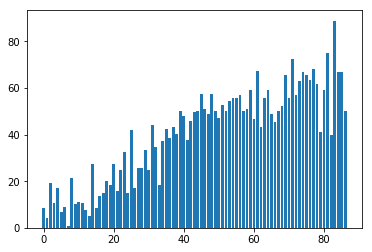

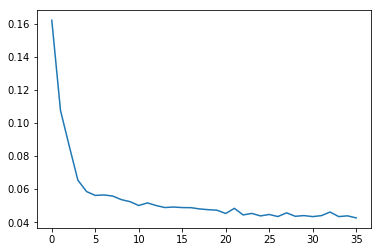

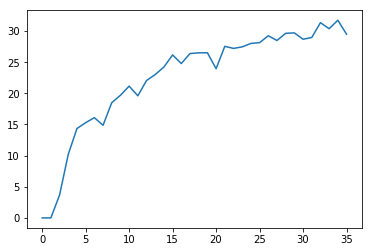

Train Epoch: 71 [0/65192 (0%)]	Loss: 0.051859
Train Epoch: 71 [6400/65192 (10%)]	Loss: 0.038964
Train Epoch: 71 [12800/65192 (20%)]	Loss: 0.037084
Train Epoch: 71 [19200/65192 (29%)]	Loss: 0.046769
Train Epoch: 71 [25600/65192 (39%)]	Loss: 0.039869
Train Epoch: 71 [32000/65192 (49%)]	Loss: 0.029944
Train Epoch: 71 [38400/65192 (59%)]	Loss: 0.035547
Train Epoch: 71 [44800/65192 (69%)]	Loss: 0.038277
Train Epoch: 71 [51200/65192 (79%)]	Loss: 0.041162
Train Epoch: 71 [57600/65192 (88%)]	Loss: 0.036637
Train Epoch: 71 [64000/65192 (98%)]	Loss: 0.049763
Train Epoch: 72 [0/65192 (0%)]	Loss: 0.048371
Train Epoch: 72 [6400/65192 (10%)]	Loss: 0.042865
Train Epoch: 72 [12800/65192 (20%)]	Loss: 0.042306
Train Epoch: 72 [19200/65192 (29%)]	Loss: 0.037420
Train Epoch: 72 [25600/65192 (39%)]	Loss: 0.041369
Train Epoch: 72 [32000/65192 (49%)]	Loss: 0.042005
Train Epoch: 72 [38400/65192 (59%)]	Loss: 0.036789
Train Epoch: 72 [44800/65192 (69%)]	Loss: 0.041100
Train Epoch: 72 [51200/65192 (79%)]	Loss: 0

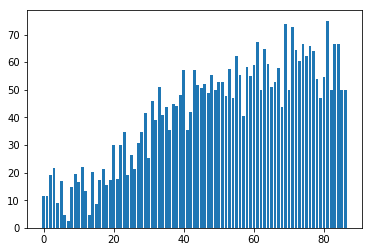

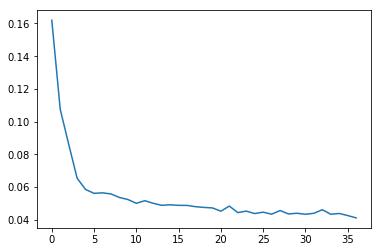

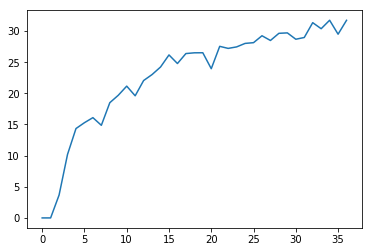

Train Epoch: 73 [0/65192 (0%)]	Loss: 0.050588
Train Epoch: 73 [6400/65192 (10%)]	Loss: 0.039059
Train Epoch: 73 [12800/65192 (20%)]	Loss: 0.041056
Train Epoch: 73 [19200/65192 (29%)]	Loss: 0.040675
Train Epoch: 73 [25600/65192 (39%)]	Loss: 0.043175
Train Epoch: 73 [32000/65192 (49%)]	Loss: 0.052653
Train Epoch: 73 [38400/65192 (59%)]	Loss: 0.030025
Train Epoch: 73 [44800/65192 (69%)]	Loss: 0.036252
Train Epoch: 73 [51200/65192 (79%)]	Loss: 0.035332
Train Epoch: 73 [57600/65192 (88%)]	Loss: 0.043417
Train Epoch: 73 [64000/65192 (98%)]	Loss: 0.041261
Train Epoch: 74 [0/65192 (0%)]	Loss: 0.039184
Train Epoch: 74 [6400/65192 (10%)]	Loss: 0.049770
Train Epoch: 74 [12800/65192 (20%)]	Loss: 0.034852
Train Epoch: 74 [19200/65192 (29%)]	Loss: 0.048951
Train Epoch: 74 [25600/65192 (39%)]	Loss: 0.046331
Train Epoch: 74 [32000/65192 (49%)]	Loss: 0.050949
Train Epoch: 74 [38400/65192 (59%)]	Loss: 0.041378
Train Epoch: 74 [44800/65192 (69%)]	Loss: 0.037011
Train Epoch: 74 [51200/65192 (79%)]	Loss: 0

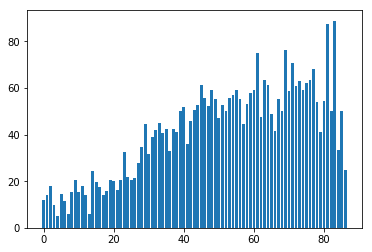

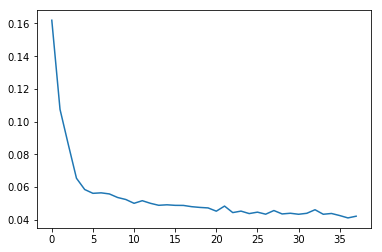

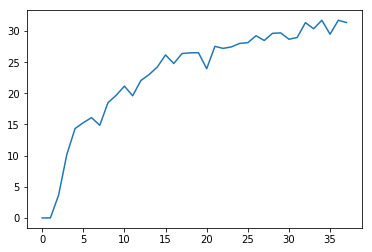

Train Epoch: 75 [0/65192 (0%)]	Loss: 0.037794
Train Epoch: 75 [6400/65192 (10%)]	Loss: 0.045614
Train Epoch: 75 [12800/65192 (20%)]	Loss: 0.043137
Train Epoch: 75 [19200/65192 (29%)]	Loss: 0.052581
Train Epoch: 75 [25600/65192 (39%)]	Loss: 0.047999
Train Epoch: 75 [32000/65192 (49%)]	Loss: 0.044870
Train Epoch: 75 [38400/65192 (59%)]	Loss: 0.052314
Train Epoch: 75 [44800/65192 (69%)]	Loss: 0.038522
Train Epoch: 75 [51200/65192 (79%)]	Loss: 0.039698
Train Epoch: 75 [57600/65192 (88%)]	Loss: 0.049217
Train Epoch: 75 [64000/65192 (98%)]	Loss: 0.035286
Train Epoch: 76 [0/65192 (0%)]	Loss: 0.040752
Train Epoch: 76 [6400/65192 (10%)]	Loss: 0.043738
Train Epoch: 76 [12800/65192 (20%)]	Loss: 0.054002
Train Epoch: 76 [19200/65192 (29%)]	Loss: 0.051798
Train Epoch: 76 [25600/65192 (39%)]	Loss: 0.034712
Train Epoch: 76 [32000/65192 (49%)]	Loss: 0.036433
Train Epoch: 76 [38400/65192 (59%)]	Loss: 0.045002
Train Epoch: 76 [44800/65192 (69%)]	Loss: 0.038994
Train Epoch: 76 [51200/65192 (79%)]	Loss: 0

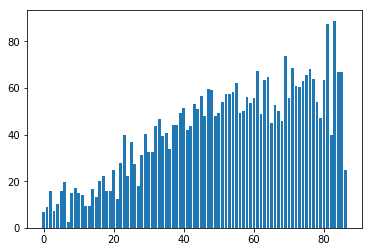

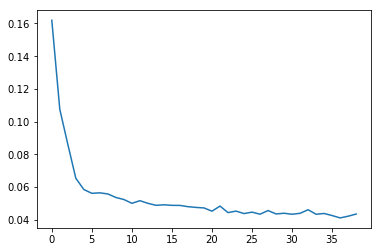

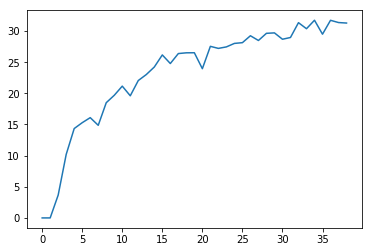

Train Epoch: 77 [0/65192 (0%)]	Loss: 0.045423
Train Epoch: 77 [6400/65192 (10%)]	Loss: 0.039790
Train Epoch: 77 [12800/65192 (20%)]	Loss: 0.045297
Train Epoch: 77 [19200/65192 (29%)]	Loss: 0.050899
Train Epoch: 77 [25600/65192 (39%)]	Loss: 0.042382
Train Epoch: 77 [32000/65192 (49%)]	Loss: 0.046744
Train Epoch: 77 [38400/65192 (59%)]	Loss: 0.048147
Train Epoch: 77 [44800/65192 (69%)]	Loss: 0.047612
Train Epoch: 77 [51200/65192 (79%)]	Loss: 0.034630
Train Epoch: 77 [57600/65192 (88%)]	Loss: 0.037301
Train Epoch: 77 [64000/65192 (98%)]	Loss: 0.047422
Train Epoch: 78 [0/65192 (0%)]	Loss: 0.048865
Train Epoch: 78 [6400/65192 (10%)]	Loss: 0.044627
Train Epoch: 78 [12800/65192 (20%)]	Loss: 0.040640
Train Epoch: 78 [19200/65192 (29%)]	Loss: 0.044761
Train Epoch: 78 [25600/65192 (39%)]	Loss: 0.040712
Train Epoch: 78 [32000/65192 (49%)]	Loss: 0.045194
Train Epoch: 78 [38400/65192 (59%)]	Loss: 0.034221
Train Epoch: 78 [44800/65192 (69%)]	Loss: 0.036533
Train Epoch: 78 [51200/65192 (79%)]	Loss: 0

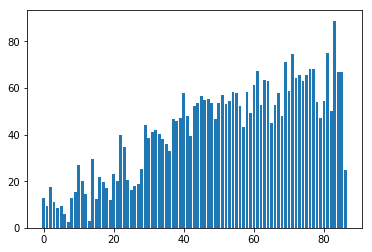

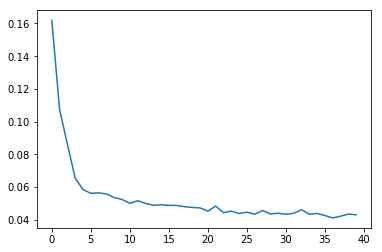

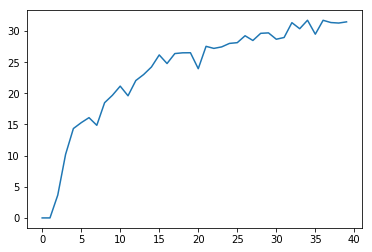

Train Epoch: 79 [0/65192 (0%)]	Loss: 0.035345
Train Epoch: 79 [6400/65192 (10%)]	Loss: 0.035333
Train Epoch: 79 [12800/65192 (20%)]	Loss: 0.044389
Train Epoch: 79 [19200/65192 (29%)]	Loss: 0.041432
Train Epoch: 79 [25600/65192 (39%)]	Loss: 0.035687
Train Epoch: 79 [32000/65192 (49%)]	Loss: 0.046637
Train Epoch: 79 [38400/65192 (59%)]	Loss: 0.038558
Train Epoch: 79 [44800/65192 (69%)]	Loss: 0.045246
Train Epoch: 79 [51200/65192 (79%)]	Loss: 0.041150
Train Epoch: 79 [57600/65192 (88%)]	Loss: 0.038852
Train Epoch: 79 [64000/65192 (98%)]	Loss: 0.033550
Train Epoch: 80 [0/65192 (0%)]	Loss: 0.047846
Train Epoch: 80 [6400/65192 (10%)]	Loss: 0.040101
Train Epoch: 80 [12800/65192 (20%)]	Loss: 0.030005
Train Epoch: 80 [19200/65192 (29%)]	Loss: 0.037203
Train Epoch: 80 [25600/65192 (39%)]	Loss: 0.054953
Train Epoch: 80 [32000/65192 (49%)]	Loss: 0.050681
Train Epoch: 80 [38400/65192 (59%)]	Loss: 0.052385
Train Epoch: 80 [44800/65192 (69%)]	Loss: 0.040979
Train Epoch: 80 [51200/65192 (79%)]	Loss: 0

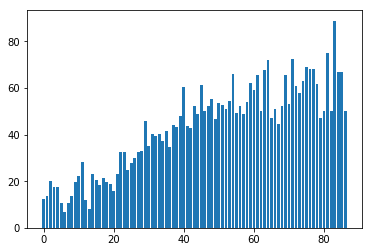

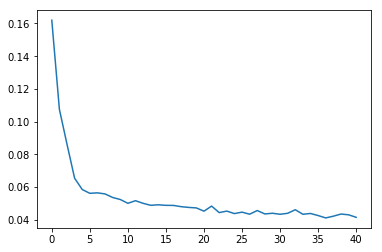

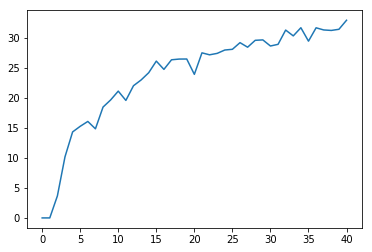

Train Epoch: 81 [0/65192 (0%)]	Loss: 0.047605
Train Epoch: 81 [6400/65192 (10%)]	Loss: 0.047595
Train Epoch: 81 [12800/65192 (20%)]	Loss: 0.045107
Train Epoch: 81 [19200/65192 (29%)]	Loss: 0.042178
Train Epoch: 81 [25600/65192 (39%)]	Loss: 0.051709
Train Epoch: 81 [32000/65192 (49%)]	Loss: 0.042387
Train Epoch: 81 [38400/65192 (59%)]	Loss: 0.045249
Train Epoch: 81 [44800/65192 (69%)]	Loss: 0.041968
Train Epoch: 81 [51200/65192 (79%)]	Loss: 0.038630
Train Epoch: 81 [57600/65192 (88%)]	Loss: 0.044254
Train Epoch: 81 [64000/65192 (98%)]	Loss: 0.041077
Train Epoch: 82 [0/65192 (0%)]	Loss: 0.052719
Train Epoch: 82 [6400/65192 (10%)]	Loss: 0.036894
Train Epoch: 82 [12800/65192 (20%)]	Loss: 0.034984
Train Epoch: 82 [19200/65192 (29%)]	Loss: 0.034450
Train Epoch: 82 [25600/65192 (39%)]	Loss: 0.040530
Train Epoch: 82 [32000/65192 (49%)]	Loss: 0.041013
Train Epoch: 82 [38400/65192 (59%)]	Loss: 0.034239
Train Epoch: 82 [44800/65192 (69%)]	Loss: 0.043318
Train Epoch: 82 [51200/65192 (79%)]	Loss: 0

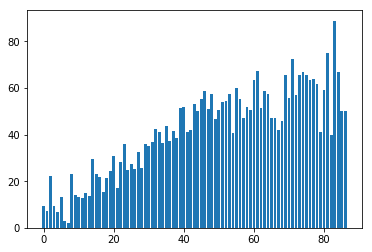

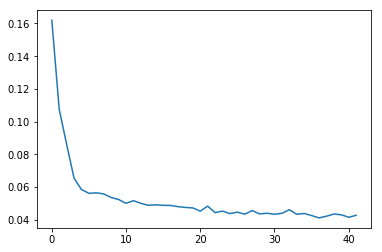

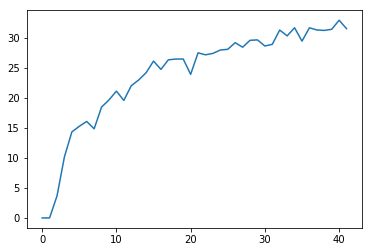

Train Epoch: 83 [0/65192 (0%)]	Loss: 0.040649
Train Epoch: 83 [6400/65192 (10%)]	Loss: 0.041676
Train Epoch: 83 [12800/65192 (20%)]	Loss: 0.042823
Train Epoch: 83 [19200/65192 (29%)]	Loss: 0.039094
Train Epoch: 83 [25600/65192 (39%)]	Loss: 0.039238
Train Epoch: 83 [32000/65192 (49%)]	Loss: 0.039725
Train Epoch: 83 [38400/65192 (59%)]	Loss: 0.047376
Train Epoch: 83 [44800/65192 (69%)]	Loss: 0.041987
Train Epoch: 83 [51200/65192 (79%)]	Loss: 0.046306
Train Epoch: 83 [57600/65192 (88%)]	Loss: 0.033959
Train Epoch: 83 [64000/65192 (98%)]	Loss: 0.046640
Train Epoch: 84 [0/65192 (0%)]	Loss: 0.045696
Train Epoch: 84 [6400/65192 (10%)]	Loss: 0.037782
Train Epoch: 84 [12800/65192 (20%)]	Loss: 0.044755
Train Epoch: 84 [19200/65192 (29%)]	Loss: 0.046586
Train Epoch: 84 [25600/65192 (39%)]	Loss: 0.038664
Train Epoch: 84 [32000/65192 (49%)]	Loss: 0.046569
Train Epoch: 84 [38400/65192 (59%)]	Loss: 0.045585
Train Epoch: 84 [44800/65192 (69%)]	Loss: 0.042459
Train Epoch: 84 [51200/65192 (79%)]	Loss: 0

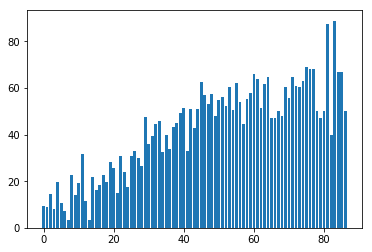

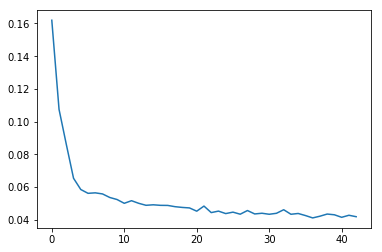

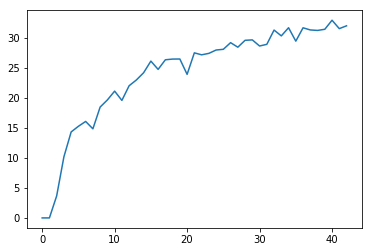

Train Epoch: 85 [0/65192 (0%)]	Loss: 0.036210
Train Epoch: 85 [6400/65192 (10%)]	Loss: 0.051055
Train Epoch: 85 [12800/65192 (20%)]	Loss: 0.033100
Train Epoch: 85 [19200/65192 (29%)]	Loss: 0.041551
Train Epoch: 85 [25600/65192 (39%)]	Loss: 0.038515
Train Epoch: 85 [32000/65192 (49%)]	Loss: 0.043130
Train Epoch: 85 [38400/65192 (59%)]	Loss: 0.038189
Train Epoch: 85 [44800/65192 (69%)]	Loss: 0.045011
Train Epoch: 85 [51200/65192 (79%)]	Loss: 0.043369
Train Epoch: 85 [57600/65192 (88%)]	Loss: 0.036476
Train Epoch: 85 [64000/65192 (98%)]	Loss: 0.040769
Train Epoch: 86 [0/65192 (0%)]	Loss: 0.042315
Train Epoch: 86 [6400/65192 (10%)]	Loss: 0.044315
Train Epoch: 86 [12800/65192 (20%)]	Loss: 0.041304
Train Epoch: 86 [19200/65192 (29%)]	Loss: 0.043951
Train Epoch: 86 [25600/65192 (39%)]	Loss: 0.036042
Train Epoch: 86 [32000/65192 (49%)]	Loss: 0.040005
Train Epoch: 86 [38400/65192 (59%)]	Loss: 0.036582
Train Epoch: 86 [44800/65192 (69%)]	Loss: 0.042026
Train Epoch: 86 [51200/65192 (79%)]	Loss: 0

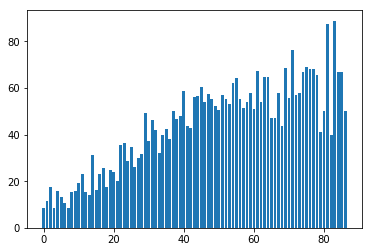

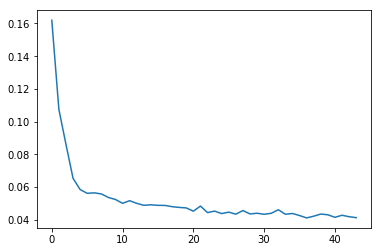

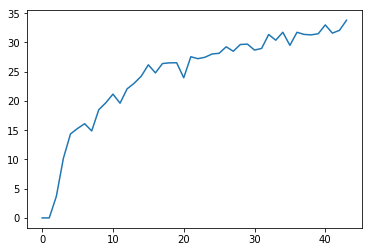

Train Epoch: 87 [0/65192 (0%)]	Loss: 0.027461
Train Epoch: 87 [6400/65192 (10%)]	Loss: 0.043380
Train Epoch: 87 [12800/65192 (20%)]	Loss: 0.041568
Train Epoch: 87 [19200/65192 (29%)]	Loss: 0.047405
Train Epoch: 87 [25600/65192 (39%)]	Loss: 0.035908
Train Epoch: 87 [32000/65192 (49%)]	Loss: 0.046387
Train Epoch: 87 [38400/65192 (59%)]	Loss: 0.035955
Train Epoch: 87 [44800/65192 (69%)]	Loss: 0.048462
Train Epoch: 87 [51200/65192 (79%)]	Loss: 0.041367
Train Epoch: 87 [57600/65192 (88%)]	Loss: 0.042208
Train Epoch: 87 [64000/65192 (98%)]	Loss: 0.041025
Train Epoch: 88 [0/65192 (0%)]	Loss: 0.048384
Train Epoch: 88 [6400/65192 (10%)]	Loss: 0.038564
Train Epoch: 88 [12800/65192 (20%)]	Loss: 0.048782
Train Epoch: 88 [19200/65192 (29%)]	Loss: 0.038115
Train Epoch: 88 [25600/65192 (39%)]	Loss: 0.043243
Train Epoch: 88 [32000/65192 (49%)]	Loss: 0.032265
Train Epoch: 88 [38400/65192 (59%)]	Loss: 0.050472
Train Epoch: 88 [44800/65192 (69%)]	Loss: 0.038031
Train Epoch: 88 [51200/65192 (79%)]	Loss: 0

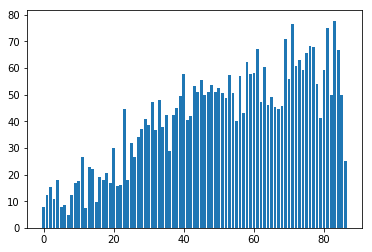

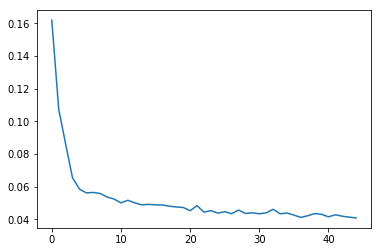

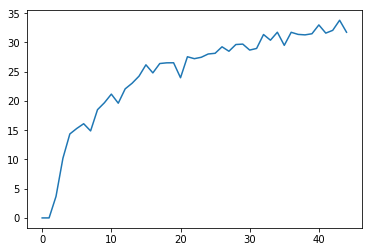

Train Epoch: 89 [0/65192 (0%)]	Loss: 0.044114
Train Epoch: 89 [6400/65192 (10%)]	Loss: 0.046915
Train Epoch: 89 [12800/65192 (20%)]	Loss: 0.032232
Train Epoch: 89 [19200/65192 (29%)]	Loss: 0.038303
Train Epoch: 89 [25600/65192 (39%)]	Loss: 0.048391
Train Epoch: 89 [32000/65192 (49%)]	Loss: 0.046753
Train Epoch: 89 [38400/65192 (59%)]	Loss: 0.050188
Train Epoch: 89 [44800/65192 (69%)]	Loss: 0.044986
Train Epoch: 89 [51200/65192 (79%)]	Loss: 0.042916
Train Epoch: 89 [57600/65192 (88%)]	Loss: 0.037214
Train Epoch: 89 [64000/65192 (98%)]	Loss: 0.043518
Train Epoch: 90 [0/65192 (0%)]	Loss: 0.038001
Train Epoch: 90 [6400/65192 (10%)]	Loss: 0.034612
Train Epoch: 90 [12800/65192 (20%)]	Loss: 0.057527
Train Epoch: 90 [19200/65192 (29%)]	Loss: 0.046167
Train Epoch: 90 [25600/65192 (39%)]	Loss: 0.027576
Train Epoch: 90 [32000/65192 (49%)]	Loss: 0.034384
Train Epoch: 90 [38400/65192 (59%)]	Loss: 0.045482
Train Epoch: 90 [44800/65192 (69%)]	Loss: 0.037681
Train Epoch: 90 [51200/65192 (79%)]	Loss: 0

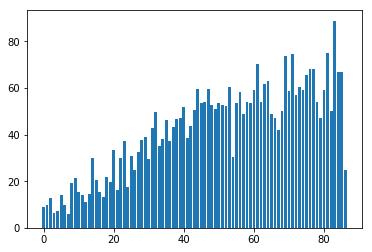

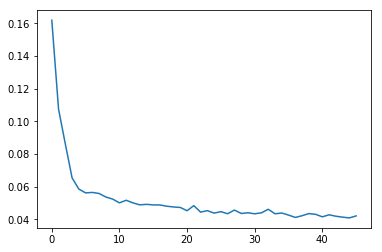

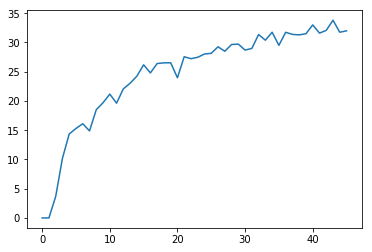

Train Epoch: 91 [0/65192 (0%)]	Loss: 0.045465
Train Epoch: 91 [6400/65192 (10%)]	Loss: 0.047389
Train Epoch: 91 [12800/65192 (20%)]	Loss: 0.038656
Train Epoch: 91 [19200/65192 (29%)]	Loss: 0.050690
Train Epoch: 91 [25600/65192 (39%)]	Loss: 0.045058
Train Epoch: 91 [32000/65192 (49%)]	Loss: 0.058569
Train Epoch: 91 [38400/65192 (59%)]	Loss: 0.040796
Train Epoch: 91 [44800/65192 (69%)]	Loss: 0.051119
Train Epoch: 91 [51200/65192 (79%)]	Loss: 0.043821
Train Epoch: 91 [57600/65192 (88%)]	Loss: 0.039420
Train Epoch: 91 [64000/65192 (98%)]	Loss: 0.039424
Train Epoch: 92 [0/65192 (0%)]	Loss: 0.045313
Train Epoch: 92 [6400/65192 (10%)]	Loss: 0.039220
Train Epoch: 92 [12800/65192 (20%)]	Loss: 0.048130
Train Epoch: 92 [19200/65192 (29%)]	Loss: 0.043393
Train Epoch: 92 [25600/65192 (39%)]	Loss: 0.038440
Train Epoch: 92 [32000/65192 (49%)]	Loss: 0.047512
Train Epoch: 92 [38400/65192 (59%)]	Loss: 0.051054
Train Epoch: 92 [44800/65192 (69%)]	Loss: 0.042520
Train Epoch: 92 [51200/65192 (79%)]	Loss: 0

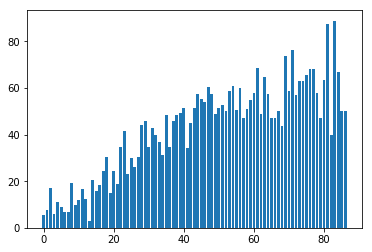

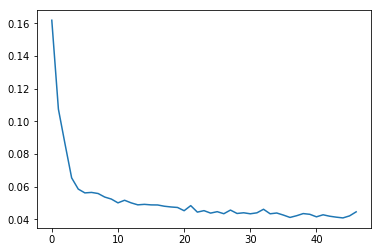

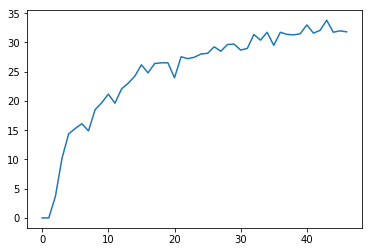

Train Epoch: 93 [0/65192 (0%)]	Loss: 0.041217
Train Epoch: 93 [6400/65192 (10%)]	Loss: 0.042790
Train Epoch: 93 [12800/65192 (20%)]	Loss: 0.043989
Train Epoch: 93 [19200/65192 (29%)]	Loss: 0.042057
Train Epoch: 93 [25600/65192 (39%)]	Loss: 0.036952
Train Epoch: 93 [32000/65192 (49%)]	Loss: 0.040503
Train Epoch: 93 [38400/65192 (59%)]	Loss: 0.046832
Train Epoch: 93 [44800/65192 (69%)]	Loss: 0.043033
Train Epoch: 93 [51200/65192 (79%)]	Loss: 0.038367
Train Epoch: 93 [57600/65192 (88%)]	Loss: 0.040769
Train Epoch: 93 [64000/65192 (98%)]	Loss: 0.038611
Train Epoch: 94 [0/65192 (0%)]	Loss: 0.039446
Train Epoch: 94 [6400/65192 (10%)]	Loss: 0.032021
Train Epoch: 94 [12800/65192 (20%)]	Loss: 0.037534
Train Epoch: 94 [19200/65192 (29%)]	Loss: 0.039522
Train Epoch: 94 [25600/65192 (39%)]	Loss: 0.046328
Train Epoch: 94 [32000/65192 (49%)]	Loss: 0.032924
Train Epoch: 94 [38400/65192 (59%)]	Loss: 0.035731
Train Epoch: 94 [44800/65192 (69%)]	Loss: 0.046334
Train Epoch: 94 [51200/65192 (79%)]	Loss: 0

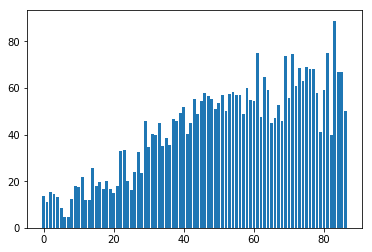

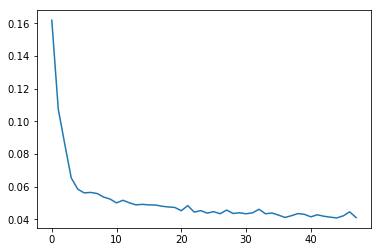

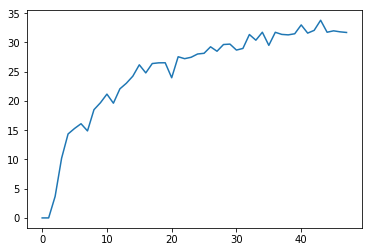

Train Epoch: 95 [0/65192 (0%)]	Loss: 0.037915
Train Epoch: 95 [6400/65192 (10%)]	Loss: 0.035982
Train Epoch: 95 [12800/65192 (20%)]	Loss: 0.056105
Train Epoch: 95 [19200/65192 (29%)]	Loss: 0.038502
Train Epoch: 95 [25600/65192 (39%)]	Loss: 0.035662
Train Epoch: 95 [32000/65192 (49%)]	Loss: 0.032306
Train Epoch: 95 [38400/65192 (59%)]	Loss: 0.045577
Train Epoch: 95 [44800/65192 (69%)]	Loss: 0.042405
Train Epoch: 95 [51200/65192 (79%)]	Loss: 0.042783
Train Epoch: 95 [57600/65192 (88%)]	Loss: 0.041829
Train Epoch: 95 [64000/65192 (98%)]	Loss: 0.038609
Train Epoch: 96 [0/65192 (0%)]	Loss: 0.044583
Train Epoch: 96 [6400/65192 (10%)]	Loss: 0.048335
Train Epoch: 96 [12800/65192 (20%)]	Loss: 0.038471
Train Epoch: 96 [19200/65192 (29%)]	Loss: 0.046910
Train Epoch: 96 [25600/65192 (39%)]	Loss: 0.046894
Train Epoch: 96 [32000/65192 (49%)]	Loss: 0.034730
Train Epoch: 96 [38400/65192 (59%)]	Loss: 0.042054
Train Epoch: 96 [44800/65192 (69%)]	Loss: 0.051053
Train Epoch: 96 [51200/65192 (79%)]	Loss: 0

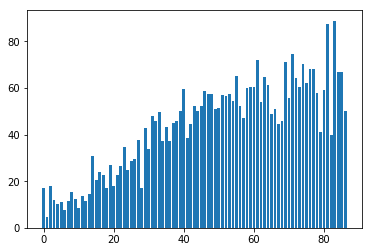

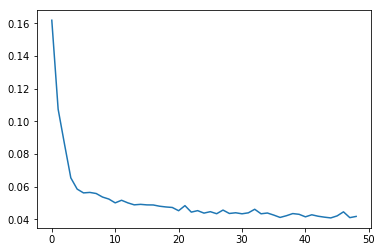

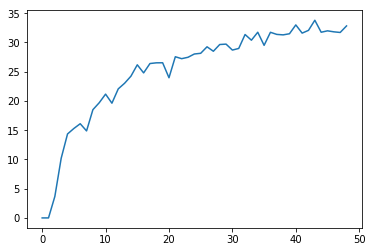

Train Epoch: 97 [0/65192 (0%)]	Loss: 0.038195
Train Epoch: 97 [6400/65192 (10%)]	Loss: 0.039924
Train Epoch: 97 [12800/65192 (20%)]	Loss: 0.042761
Train Epoch: 97 [19200/65192 (29%)]	Loss: 0.037620
Train Epoch: 97 [25600/65192 (39%)]	Loss: 0.031526
Train Epoch: 97 [32000/65192 (49%)]	Loss: 0.040272
Train Epoch: 97 [38400/65192 (59%)]	Loss: 0.037747
Train Epoch: 97 [44800/65192 (69%)]	Loss: 0.035649
Train Epoch: 97 [51200/65192 (79%)]	Loss: 0.046503
Train Epoch: 97 [57600/65192 (88%)]	Loss: 0.046582
Train Epoch: 97 [64000/65192 (98%)]	Loss: 0.050099
Train Epoch: 98 [0/65192 (0%)]	Loss: 0.041746
Train Epoch: 98 [6400/65192 (10%)]	Loss: 0.034466
Train Epoch: 98 [12800/65192 (20%)]	Loss: 0.049775
Train Epoch: 98 [19200/65192 (29%)]	Loss: 0.038031
Train Epoch: 98 [25600/65192 (39%)]	Loss: 0.040979
Train Epoch: 98 [32000/65192 (49%)]	Loss: 0.035943
Train Epoch: 98 [38400/65192 (59%)]	Loss: 0.042360
Train Epoch: 98 [44800/65192 (69%)]	Loss: 0.044932
Train Epoch: 98 [51200/65192 (79%)]	Loss: 0

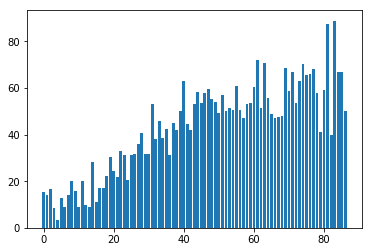

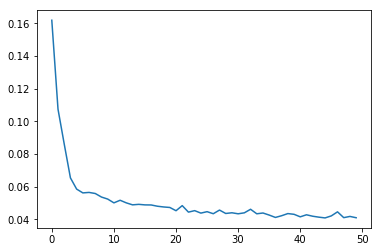

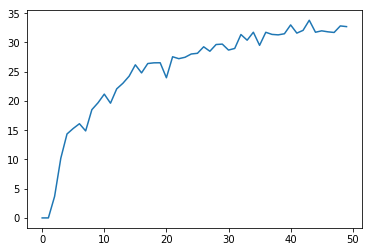

Train Epoch: 99 [0/65192 (0%)]	Loss: 0.044613
Train Epoch: 99 [6400/65192 (10%)]	Loss: 0.039502
Train Epoch: 99 [12800/65192 (20%)]	Loss: 0.054957
Train Epoch: 99 [19200/65192 (29%)]	Loss: 0.044441
Train Epoch: 99 [25600/65192 (39%)]	Loss: 0.039192
Train Epoch: 99 [32000/65192 (49%)]	Loss: 0.040802
Train Epoch: 99 [38400/65192 (59%)]	Loss: 0.044735
Train Epoch: 99 [44800/65192 (69%)]	Loss: 0.042635
Train Epoch: 99 [51200/65192 (79%)]	Loss: 0.039675
Train Epoch: 99 [57600/65192 (88%)]	Loss: 0.034419
Train Epoch: 99 [64000/65192 (98%)]	Loss: 0.045484
Train Epoch: 100 [0/65192 (0%)]	Loss: 0.036398
Train Epoch: 100 [6400/65192 (10%)]	Loss: 0.042590
Train Epoch: 100 [12800/65192 (20%)]	Loss: 0.035996
Train Epoch: 100 [19200/65192 (29%)]	Loss: 0.039088
Train Epoch: 100 [25600/65192 (39%)]	Loss: 0.053285
Train Epoch: 100 [32000/65192 (49%)]	Loss: 0.036660
Train Epoch: 100 [38400/65192 (59%)]	Loss: 0.043413
Train Epoch: 100 [44800/65192 (69%)]	Loss: 0.043234
Train Epoch: 100 [51200/65192 (79%)

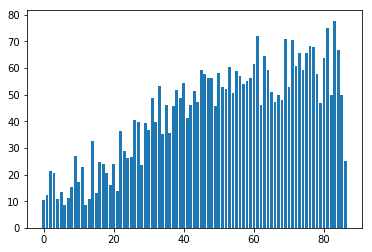

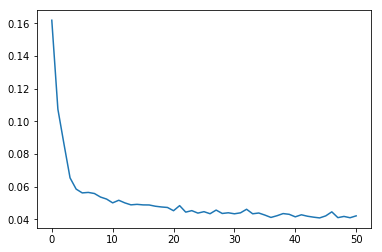

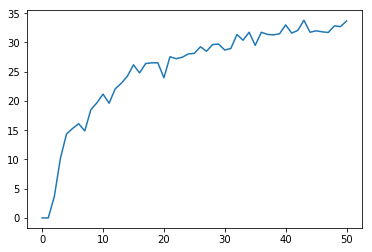

Train Epoch: 101 [0/65192 (0%)]	Loss: 0.045788
Train Epoch: 101 [6400/65192 (10%)]	Loss: 0.044657
Train Epoch: 101 [12800/65192 (20%)]	Loss: 0.032349
Train Epoch: 101 [19200/65192 (29%)]	Loss: 0.038039
Train Epoch: 101 [25600/65192 (39%)]	Loss: 0.038801
Train Epoch: 101 [32000/65192 (49%)]	Loss: 0.034869
Train Epoch: 101 [38400/65192 (59%)]	Loss: 0.048404
Train Epoch: 101 [44800/65192 (69%)]	Loss: 0.041165
Train Epoch: 101 [51200/65192 (79%)]	Loss: 0.038421
Train Epoch: 101 [57600/65192 (88%)]	Loss: 0.046913
Train Epoch: 101 [64000/65192 (98%)]	Loss: 0.044685
Train Epoch: 102 [0/65192 (0%)]	Loss: 0.038301
Train Epoch: 102 [6400/65192 (10%)]	Loss: 0.029735
Train Epoch: 102 [12800/65192 (20%)]	Loss: 0.048871
Train Epoch: 102 [19200/65192 (29%)]	Loss: 0.041103
Train Epoch: 102 [25600/65192 (39%)]	Loss: 0.044108
Train Epoch: 102 [32000/65192 (49%)]	Loss: 0.035335
Train Epoch: 102 [38400/65192 (59%)]	Loss: 0.038064
Train Epoch: 102 [44800/65192 (69%)]	Loss: 0.046030
Train Epoch: 102 [51200/

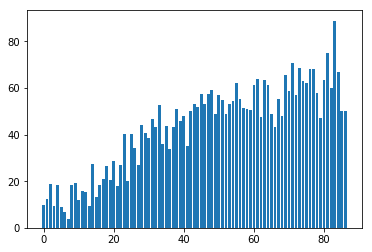

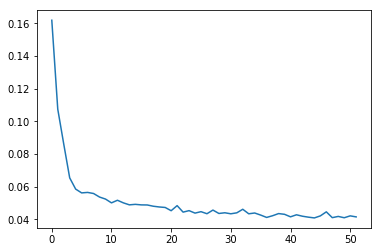

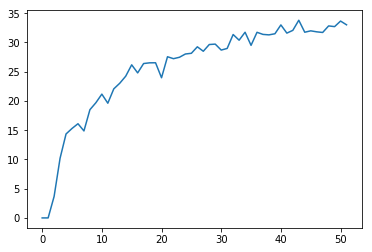

Train Epoch: 103 [0/65192 (0%)]	Loss: 0.041333
Train Epoch: 103 [6400/65192 (10%)]	Loss: 0.049029
Train Epoch: 103 [12800/65192 (20%)]	Loss: 0.043281
Train Epoch: 103 [19200/65192 (29%)]	Loss: 0.046359
Train Epoch: 103 [25600/65192 (39%)]	Loss: 0.037038
Train Epoch: 103 [32000/65192 (49%)]	Loss: 0.044055
Train Epoch: 103 [38400/65192 (59%)]	Loss: 0.038053
Train Epoch: 103 [44800/65192 (69%)]	Loss: 0.042426
Train Epoch: 103 [51200/65192 (79%)]	Loss: 0.042708
Train Epoch: 103 [57600/65192 (88%)]	Loss: 0.039028
Train Epoch: 103 [64000/65192 (98%)]	Loss: 0.040796
Train Epoch: 104 [0/65192 (0%)]	Loss: 0.048756
Train Epoch: 104 [6400/65192 (10%)]	Loss: 0.042688
Train Epoch: 104 [12800/65192 (20%)]	Loss: 0.043674
Train Epoch: 104 [19200/65192 (29%)]	Loss: 0.042010
Train Epoch: 104 [25600/65192 (39%)]	Loss: 0.041172
Train Epoch: 104 [32000/65192 (49%)]	Loss: 0.042198
Train Epoch: 104 [38400/65192 (59%)]	Loss: 0.041064
Train Epoch: 104 [44800/65192 (69%)]	Loss: 0.039157
Train Epoch: 104 [51200/

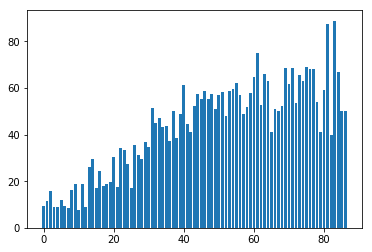

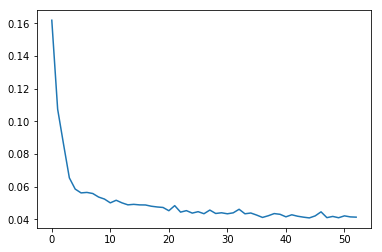

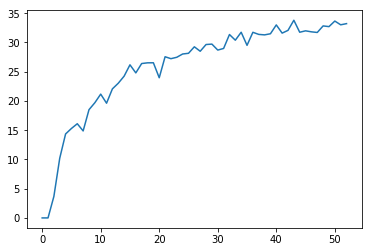

Train Epoch: 105 [0/65192 (0%)]	Loss: 0.033401
Train Epoch: 105 [6400/65192 (10%)]	Loss: 0.045176
Train Epoch: 105 [12800/65192 (20%)]	Loss: 0.043121
Train Epoch: 105 [19200/65192 (29%)]	Loss: 0.041214
Train Epoch: 105 [25600/65192 (39%)]	Loss: 0.033906
Train Epoch: 105 [32000/65192 (49%)]	Loss: 0.052952
Train Epoch: 105 [38400/65192 (59%)]	Loss: 0.038291
Train Epoch: 105 [44800/65192 (69%)]	Loss: 0.043721
Train Epoch: 105 [51200/65192 (79%)]	Loss: 0.039979
Train Epoch: 105 [57600/65192 (88%)]	Loss: 0.042908
Train Epoch: 105 [64000/65192 (98%)]	Loss: 0.041439
Train Epoch: 106 [0/65192 (0%)]	Loss: 0.054225
Train Epoch: 106 [6400/65192 (10%)]	Loss: 0.040370
Train Epoch: 106 [12800/65192 (20%)]	Loss: 0.034717
Train Epoch: 106 [19200/65192 (29%)]	Loss: 0.042309
Train Epoch: 106 [25600/65192 (39%)]	Loss: 0.046964
Train Epoch: 106 [32000/65192 (49%)]	Loss: 0.042084
Train Epoch: 106 [38400/65192 (59%)]	Loss: 0.041596
Train Epoch: 106 [44800/65192 (69%)]	Loss: 0.055803
Train Epoch: 106 [51200/

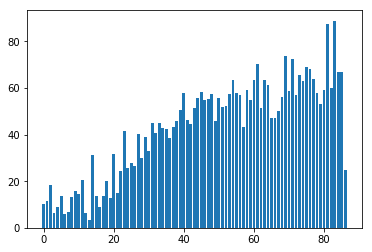

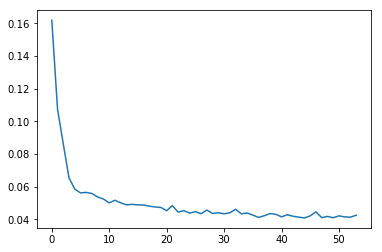

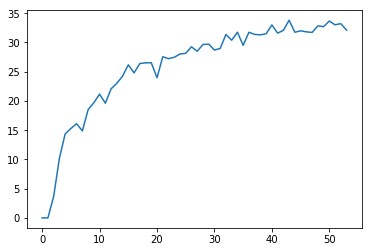

Train Epoch: 107 [0/65192 (0%)]	Loss: 0.045928
Train Epoch: 107 [6400/65192 (10%)]	Loss: 0.046120
Train Epoch: 107 [12800/65192 (20%)]	Loss: 0.043857
Train Epoch: 107 [19200/65192 (29%)]	Loss: 0.048342
Train Epoch: 107 [25600/65192 (39%)]	Loss: 0.048225
Train Epoch: 107 [32000/65192 (49%)]	Loss: 0.039902
Train Epoch: 107 [38400/65192 (59%)]	Loss: 0.033109
Train Epoch: 107 [44800/65192 (69%)]	Loss: 0.041651
Train Epoch: 107 [51200/65192 (79%)]	Loss: 0.039548
Train Epoch: 107 [57600/65192 (88%)]	Loss: 0.035602
Train Epoch: 107 [64000/65192 (98%)]	Loss: 0.038780
Train Epoch: 108 [0/65192 (0%)]	Loss: 0.045266
Train Epoch: 108 [6400/65192 (10%)]	Loss: 0.040988
Train Epoch: 108 [12800/65192 (20%)]	Loss: 0.050106
Train Epoch: 108 [19200/65192 (29%)]	Loss: 0.039115
Train Epoch: 108 [25600/65192 (39%)]	Loss: 0.044341
Train Epoch: 108 [32000/65192 (49%)]	Loss: 0.054773
Train Epoch: 108 [38400/65192 (59%)]	Loss: 0.045003
Train Epoch: 108 [44800/65192 (69%)]	Loss: 0.041837
Train Epoch: 108 [51200/

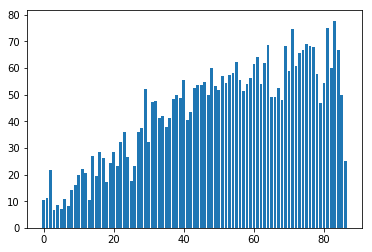

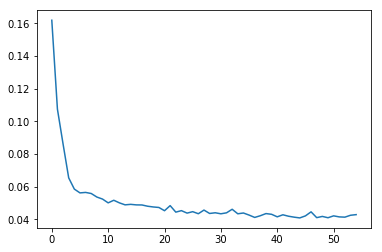

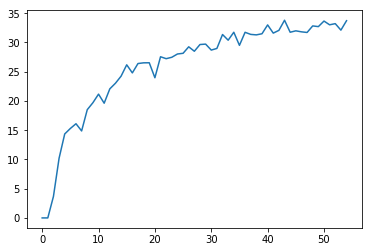

Train Epoch: 109 [0/65192 (0%)]	Loss: 0.045676
Train Epoch: 109 [6400/65192 (10%)]	Loss: 0.044624
Train Epoch: 109 [12800/65192 (20%)]	Loss: 0.040010
Train Epoch: 109 [19200/65192 (29%)]	Loss: 0.042689
Train Epoch: 109 [25600/65192 (39%)]	Loss: 0.049197
Train Epoch: 109 [32000/65192 (49%)]	Loss: 0.038120
Train Epoch: 109 [38400/65192 (59%)]	Loss: 0.033409
Train Epoch: 109 [44800/65192 (69%)]	Loss: 0.051158
Train Epoch: 109 [51200/65192 (79%)]	Loss: 0.045721
Train Epoch: 109 [57600/65192 (88%)]	Loss: 0.041652
Train Epoch: 109 [64000/65192 (98%)]	Loss: 0.042841
Train Epoch: 110 [0/65192 (0%)]	Loss: 0.039982
Train Epoch: 110 [6400/65192 (10%)]	Loss: 0.041565
Train Epoch: 110 [12800/65192 (20%)]	Loss: 0.039025
Train Epoch: 110 [19200/65192 (29%)]	Loss: 0.040507
Train Epoch: 110 [25600/65192 (39%)]	Loss: 0.046409
Train Epoch: 110 [32000/65192 (49%)]	Loss: 0.036347
Train Epoch: 110 [38400/65192 (59%)]	Loss: 0.040830
Train Epoch: 110 [44800/65192 (69%)]	Loss: 0.041046
Train Epoch: 110 [51200/

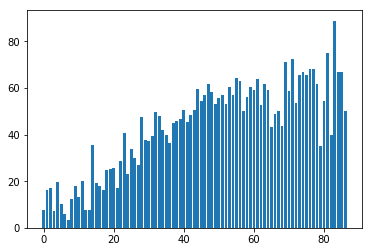

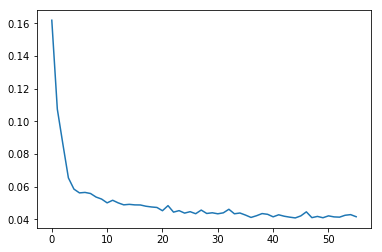

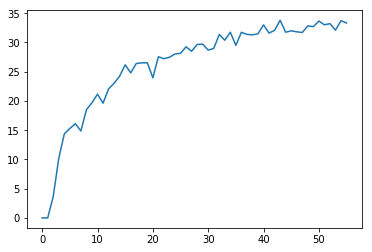

Train Epoch: 111 [0/65192 (0%)]	Loss: 0.035104
Train Epoch: 111 [6400/65192 (10%)]	Loss: 0.040449
Train Epoch: 111 [12800/65192 (20%)]	Loss: 0.037168
Train Epoch: 111 [19200/65192 (29%)]	Loss: 0.051612
Train Epoch: 111 [25600/65192 (39%)]	Loss: 0.042653
Train Epoch: 111 [32000/65192 (49%)]	Loss: 0.041083
Train Epoch: 111 [38400/65192 (59%)]	Loss: 0.039267
Train Epoch: 111 [44800/65192 (69%)]	Loss: 0.043950
Train Epoch: 111 [51200/65192 (79%)]	Loss: 0.032619
Train Epoch: 111 [57600/65192 (88%)]	Loss: 0.040288
Train Epoch: 111 [64000/65192 (98%)]	Loss: 0.033639
Train Epoch: 112 [0/65192 (0%)]	Loss: 0.044388
Train Epoch: 112 [6400/65192 (10%)]	Loss: 0.041199
Train Epoch: 112 [12800/65192 (20%)]	Loss: 0.033239
Train Epoch: 112 [19200/65192 (29%)]	Loss: 0.051144
Train Epoch: 112 [25600/65192 (39%)]	Loss: 0.046991
Train Epoch: 112 [32000/65192 (49%)]	Loss: 0.041727
Train Epoch: 112 [38400/65192 (59%)]	Loss: 0.037772
Train Epoch: 112 [44800/65192 (69%)]	Loss: 0.038078
Train Epoch: 112 [51200/

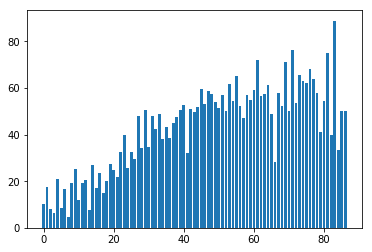

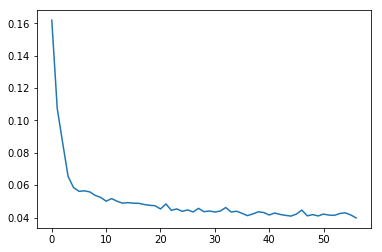

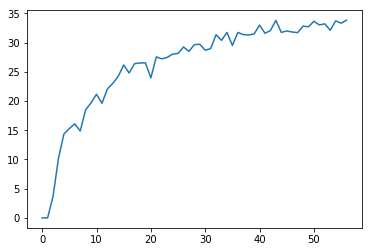

Train Epoch: 113 [0/65192 (0%)]	Loss: 0.042256
Train Epoch: 113 [6400/65192 (10%)]	Loss: 0.038735
Train Epoch: 113 [12800/65192 (20%)]	Loss: 0.043793
Train Epoch: 113 [19200/65192 (29%)]	Loss: 0.030371
Train Epoch: 113 [25600/65192 (39%)]	Loss: 0.051972
Train Epoch: 113 [32000/65192 (49%)]	Loss: 0.048352
Train Epoch: 113 [38400/65192 (59%)]	Loss: 0.042748
Train Epoch: 113 [44800/65192 (69%)]	Loss: 0.039176
Train Epoch: 113 [51200/65192 (79%)]	Loss: 0.041704
Train Epoch: 113 [57600/65192 (88%)]	Loss: 0.040200
Train Epoch: 113 [64000/65192 (98%)]	Loss: 0.041993
Train Epoch: 114 [0/65192 (0%)]	Loss: 0.041785
Train Epoch: 114 [6400/65192 (10%)]	Loss: 0.045869
Train Epoch: 114 [12800/65192 (20%)]	Loss: 0.043041
Train Epoch: 114 [19200/65192 (29%)]	Loss: 0.038694
Train Epoch: 114 [25600/65192 (39%)]	Loss: 0.047459
Train Epoch: 114 [32000/65192 (49%)]	Loss: 0.046140
Train Epoch: 114 [38400/65192 (59%)]	Loss: 0.036120
Train Epoch: 114 [44800/65192 (69%)]	Loss: 0.043851
Train Epoch: 114 [51200/

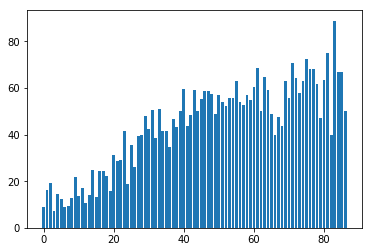

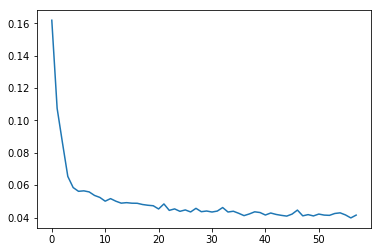

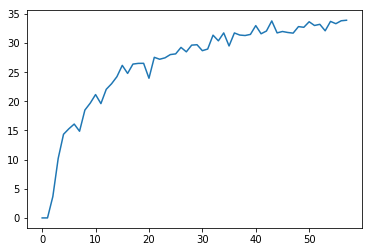

Train Epoch: 115 [0/65192 (0%)]	Loss: 0.026129
Train Epoch: 115 [6400/65192 (10%)]	Loss: 0.036379
Train Epoch: 115 [12800/65192 (20%)]	Loss: 0.036335
Train Epoch: 115 [19200/65192 (29%)]	Loss: 0.043073
Train Epoch: 115 [25600/65192 (39%)]	Loss: 0.033260
Train Epoch: 115 [32000/65192 (49%)]	Loss: 0.033647
Train Epoch: 115 [38400/65192 (59%)]	Loss: 0.049361
Train Epoch: 115 [44800/65192 (69%)]	Loss: 0.045951
Train Epoch: 115 [51200/65192 (79%)]	Loss: 0.032150
Train Epoch: 115 [57600/65192 (88%)]	Loss: 0.041971
Train Epoch: 115 [64000/65192 (98%)]	Loss: 0.040616
Train Epoch: 116 [0/65192 (0%)]	Loss: 0.047121
Train Epoch: 116 [6400/65192 (10%)]	Loss: 0.036147
Train Epoch: 116 [12800/65192 (20%)]	Loss: 0.032659
Train Epoch: 116 [19200/65192 (29%)]	Loss: 0.031716
Train Epoch: 116 [25600/65192 (39%)]	Loss: 0.040744
Train Epoch: 116 [32000/65192 (49%)]	Loss: 0.043366
Train Epoch: 116 [38400/65192 (59%)]	Loss: 0.042423
Train Epoch: 116 [44800/65192 (69%)]	Loss: 0.049310
Train Epoch: 116 [51200/

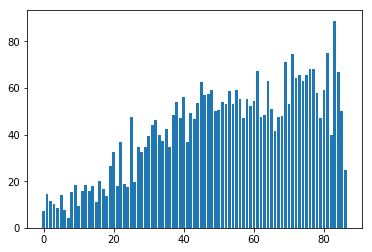

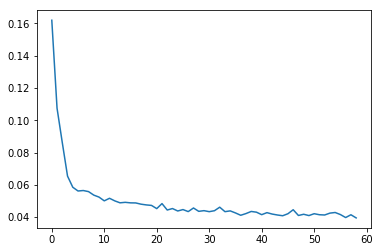

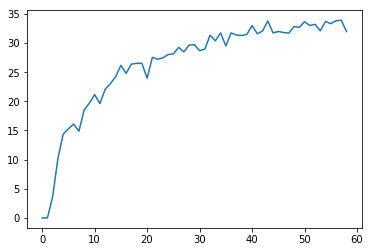

Train Epoch: 117 [0/65192 (0%)]	Loss: 0.033950
Train Epoch: 117 [6400/65192 (10%)]	Loss: 0.032793
Train Epoch: 117 [12800/65192 (20%)]	Loss: 0.037336
Train Epoch: 117 [19200/65192 (29%)]	Loss: 0.039936
Train Epoch: 117 [25600/65192 (39%)]	Loss: 0.042020
Train Epoch: 117 [32000/65192 (49%)]	Loss: 0.047404
Train Epoch: 117 [38400/65192 (59%)]	Loss: 0.039334
Train Epoch: 117 [44800/65192 (69%)]	Loss: 0.038629
Train Epoch: 117 [51200/65192 (79%)]	Loss: 0.033815
Train Epoch: 117 [57600/65192 (88%)]	Loss: 0.043863
Train Epoch: 117 [64000/65192 (98%)]	Loss: 0.040301
Train Epoch: 118 [0/65192 (0%)]	Loss: 0.033511
Train Epoch: 118 [6400/65192 (10%)]	Loss: 0.033519
Train Epoch: 118 [12800/65192 (20%)]	Loss: 0.042353
Train Epoch: 118 [19200/65192 (29%)]	Loss: 0.038555
Train Epoch: 118 [25600/65192 (39%)]	Loss: 0.033716
Train Epoch: 118 [32000/65192 (49%)]	Loss: 0.037119
Train Epoch: 118 [38400/65192 (59%)]	Loss: 0.038341
Train Epoch: 118 [44800/65192 (69%)]	Loss: 0.043185
Train Epoch: 118 [51200/

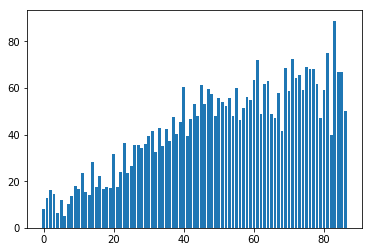

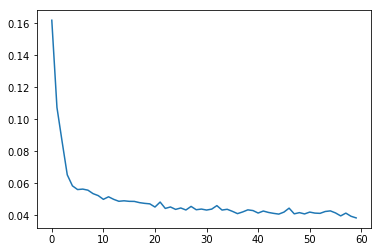

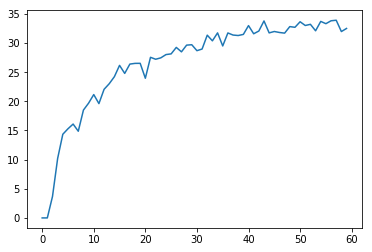

Train Epoch: 119 [0/65192 (0%)]	Loss: 0.034184
Train Epoch: 119 [6400/65192 (10%)]	Loss: 0.040503
Train Epoch: 119 [12800/65192 (20%)]	Loss: 0.040590
Train Epoch: 119 [19200/65192 (29%)]	Loss: 0.032321
Train Epoch: 119 [25600/65192 (39%)]	Loss: 0.041033
Train Epoch: 119 [32000/65192 (49%)]	Loss: 0.043859
Train Epoch: 119 [38400/65192 (59%)]	Loss: 0.028833
Train Epoch: 119 [44800/65192 (69%)]	Loss: 0.038648
Train Epoch: 119 [51200/65192 (79%)]	Loss: 0.042695
Train Epoch: 119 [57600/65192 (88%)]	Loss: 0.042682
Train Epoch: 119 [64000/65192 (98%)]	Loss: 0.035079
Train Epoch: 120 [0/65192 (0%)]	Loss: 0.041871
Train Epoch: 120 [6400/65192 (10%)]	Loss: 0.036344
Train Epoch: 120 [12800/65192 (20%)]	Loss: 0.048665
Train Epoch: 120 [19200/65192 (29%)]	Loss: 0.049154
Train Epoch: 120 [25600/65192 (39%)]	Loss: 0.048855
Train Epoch: 120 [32000/65192 (49%)]	Loss: 0.046880
Train Epoch: 120 [38400/65192 (59%)]	Loss: 0.034404
Train Epoch: 120 [44800/65192 (69%)]	Loss: 0.044117
Train Epoch: 120 [51200/

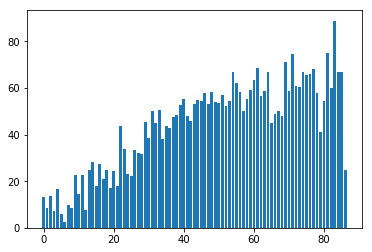

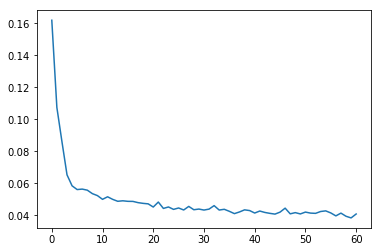

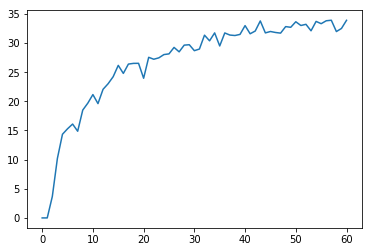

Train Epoch: 121 [0/65192 (0%)]	Loss: 0.039637
Train Epoch: 121 [6400/65192 (10%)]	Loss: 0.035088
Train Epoch: 121 [12800/65192 (20%)]	Loss: 0.032282
Train Epoch: 121 [19200/65192 (29%)]	Loss: 0.037896
Train Epoch: 121 [25600/65192 (39%)]	Loss: 0.045242
Train Epoch: 121 [32000/65192 (49%)]	Loss: 0.029095
Train Epoch: 121 [38400/65192 (59%)]	Loss: 0.040720
Train Epoch: 121 [44800/65192 (69%)]	Loss: 0.037793
Train Epoch: 121 [51200/65192 (79%)]	Loss: 0.041225
Train Epoch: 121 [57600/65192 (88%)]	Loss: 0.029310
Train Epoch: 121 [64000/65192 (98%)]	Loss: 0.047109
Train Epoch: 122 [0/65192 (0%)]	Loss: 0.033686
Train Epoch: 122 [6400/65192 (10%)]	Loss: 0.049844
Train Epoch: 122 [12800/65192 (20%)]	Loss: 0.038826
Train Epoch: 122 [19200/65192 (29%)]	Loss: 0.047740
Train Epoch: 122 [25600/65192 (39%)]	Loss: 0.038130
Train Epoch: 122 [32000/65192 (49%)]	Loss: 0.042968
Train Epoch: 122 [38400/65192 (59%)]	Loss: 0.035602
Train Epoch: 122 [44800/65192 (69%)]	Loss: 0.034304
Train Epoch: 122 [51200/

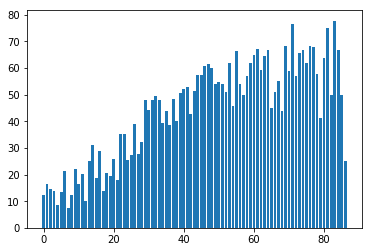

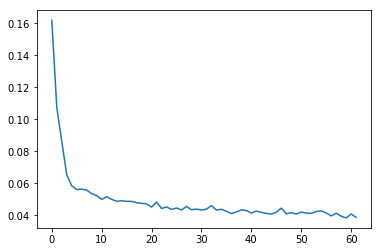

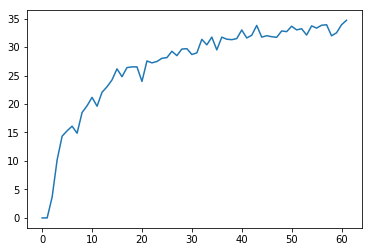

Train Epoch: 123 [0/65192 (0%)]	Loss: 0.038753
Train Epoch: 123 [6400/65192 (10%)]	Loss: 0.036254
Train Epoch: 123 [12800/65192 (20%)]	Loss: 0.038616
Train Epoch: 123 [19200/65192 (29%)]	Loss: 0.038656
Train Epoch: 123 [25600/65192 (39%)]	Loss: 0.033277
Train Epoch: 123 [32000/65192 (49%)]	Loss: 0.044606
Train Epoch: 123 [38400/65192 (59%)]	Loss: 0.038790
Train Epoch: 123 [44800/65192 (69%)]	Loss: 0.044451
Train Epoch: 123 [51200/65192 (79%)]	Loss: 0.039527
Train Epoch: 123 [57600/65192 (88%)]	Loss: 0.041664
Train Epoch: 123 [64000/65192 (98%)]	Loss: 0.043653
Train Epoch: 124 [0/65192 (0%)]	Loss: 0.042469
Train Epoch: 124 [6400/65192 (10%)]	Loss: 0.036240
Train Epoch: 124 [12800/65192 (20%)]	Loss: 0.039514
Train Epoch: 124 [19200/65192 (29%)]	Loss: 0.050917
Train Epoch: 124 [25600/65192 (39%)]	Loss: 0.043434
Train Epoch: 124 [32000/65192 (49%)]	Loss: 0.043567
Train Epoch: 124 [38400/65192 (59%)]	Loss: 0.038285
Train Epoch: 124 [44800/65192 (69%)]	Loss: 0.034967
Train Epoch: 124 [51200/

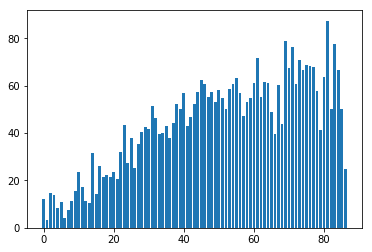

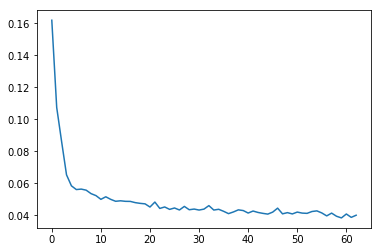

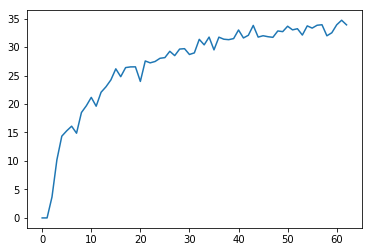

Train Epoch: 125 [0/65192 (0%)]	Loss: 0.044000
Train Epoch: 125 [6400/65192 (10%)]	Loss: 0.041445
Train Epoch: 125 [12800/65192 (20%)]	Loss: 0.041145
Train Epoch: 125 [19200/65192 (29%)]	Loss: 0.040415
Train Epoch: 125 [25600/65192 (39%)]	Loss: 0.039370
Train Epoch: 125 [32000/65192 (49%)]	Loss: 0.036242
Train Epoch: 125 [38400/65192 (59%)]	Loss: 0.042747
Train Epoch: 125 [44800/65192 (69%)]	Loss: 0.039707
Train Epoch: 125 [51200/65192 (79%)]	Loss: 0.039572
Train Epoch: 125 [57600/65192 (88%)]	Loss: 0.043217
Train Epoch: 125 [64000/65192 (98%)]	Loss: 0.036454
Train Epoch: 126 [0/65192 (0%)]	Loss: 0.044431
Train Epoch: 126 [6400/65192 (10%)]	Loss: 0.039663
Train Epoch: 126 [12800/65192 (20%)]	Loss: 0.053906
Train Epoch: 126 [19200/65192 (29%)]	Loss: 0.024275
Train Epoch: 126 [25600/65192 (39%)]	Loss: 0.037252
Train Epoch: 126 [32000/65192 (49%)]	Loss: 0.049253
Train Epoch: 126 [38400/65192 (59%)]	Loss: 0.033500
Train Epoch: 126 [44800/65192 (69%)]	Loss: 0.045756
Train Epoch: 126 [51200/

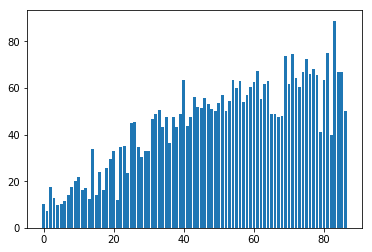

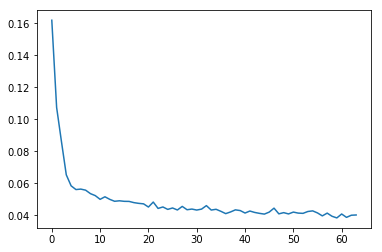

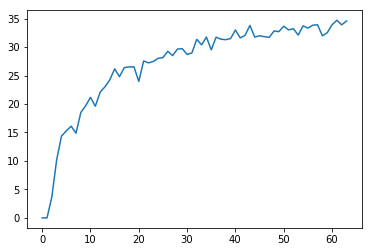

Train Epoch: 127 [0/65192 (0%)]	Loss: 0.046484
Train Epoch: 127 [6400/65192 (10%)]	Loss: 0.050921
Train Epoch: 127 [12800/65192 (20%)]	Loss: 0.037244
Train Epoch: 127 [19200/65192 (29%)]	Loss: 0.031280
Train Epoch: 127 [25600/65192 (39%)]	Loss: 0.039103
Train Epoch: 127 [32000/65192 (49%)]	Loss: 0.037700
Train Epoch: 127 [38400/65192 (59%)]	Loss: 0.042456
Train Epoch: 127 [44800/65192 (69%)]	Loss: 0.031989
Train Epoch: 127 [51200/65192 (79%)]	Loss: 0.036730
Train Epoch: 127 [57600/65192 (88%)]	Loss: 0.033889
Train Epoch: 127 [64000/65192 (98%)]	Loss: 0.034224
Train Epoch: 128 [0/65192 (0%)]	Loss: 0.033984
Train Epoch: 128 [6400/65192 (10%)]	Loss: 0.041906
Train Epoch: 128 [12800/65192 (20%)]	Loss: 0.032791
Train Epoch: 128 [19200/65192 (29%)]	Loss: 0.044090
Train Epoch: 128 [25600/65192 (39%)]	Loss: 0.038539
Train Epoch: 128 [32000/65192 (49%)]	Loss: 0.034934
Train Epoch: 128 [38400/65192 (59%)]	Loss: 0.042247
Train Epoch: 128 [44800/65192 (69%)]	Loss: 0.040739
Train Epoch: 128 [51200/

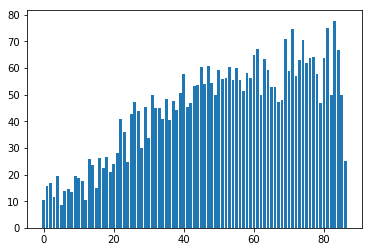

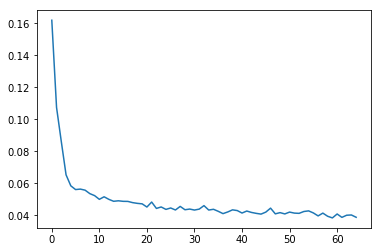

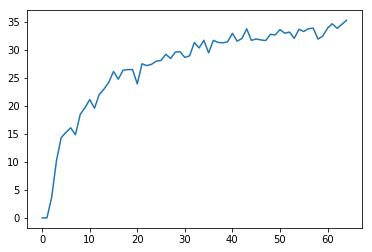

Train Epoch: 129 [0/65192 (0%)]	Loss: 0.039158
Train Epoch: 129 [6400/65192 (10%)]	Loss: 0.042901
Train Epoch: 129 [12800/65192 (20%)]	Loss: 0.032296
Train Epoch: 129 [19200/65192 (29%)]	Loss: 0.035250
Train Epoch: 129 [25600/65192 (39%)]	Loss: 0.040798
Train Epoch: 129 [32000/65192 (49%)]	Loss: 0.042494
Train Epoch: 129 [38400/65192 (59%)]	Loss: 0.035800
Train Epoch: 129 [44800/65192 (69%)]	Loss: 0.041502
Train Epoch: 129 [51200/65192 (79%)]	Loss: 0.045184
Train Epoch: 129 [57600/65192 (88%)]	Loss: 0.043166
Train Epoch: 129 [64000/65192 (98%)]	Loss: 0.047633
Train Epoch: 130 [0/65192 (0%)]	Loss: 0.034163
Train Epoch: 130 [6400/65192 (10%)]	Loss: 0.038900
Train Epoch: 130 [12800/65192 (20%)]	Loss: 0.041957
Train Epoch: 130 [19200/65192 (29%)]	Loss: 0.034639
Train Epoch: 130 [25600/65192 (39%)]	Loss: 0.046027
Train Epoch: 130 [32000/65192 (49%)]	Loss: 0.040646
Train Epoch: 130 [38400/65192 (59%)]	Loss: 0.040286
Train Epoch: 130 [44800/65192 (69%)]	Loss: 0.036150
Train Epoch: 130 [51200/

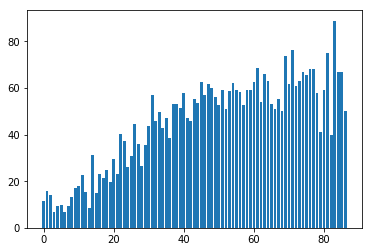

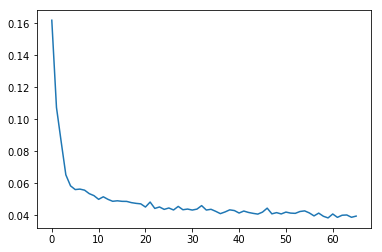

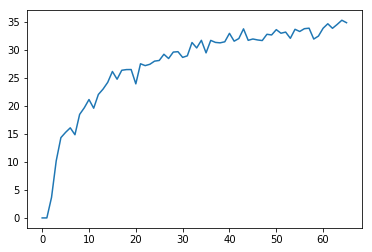

Train Epoch: 131 [0/65192 (0%)]	Loss: 0.047850
Train Epoch: 131 [6400/65192 (10%)]	Loss: 0.040781
Train Epoch: 131 [12800/65192 (20%)]	Loss: 0.032276
Train Epoch: 131 [19200/65192 (29%)]	Loss: 0.032979
Train Epoch: 131 [25600/65192 (39%)]	Loss: 0.038386
Train Epoch: 131 [32000/65192 (49%)]	Loss: 0.045425
Train Epoch: 131 [38400/65192 (59%)]	Loss: 0.044509
Train Epoch: 131 [44800/65192 (69%)]	Loss: 0.040536
Train Epoch: 131 [51200/65192 (79%)]	Loss: 0.035543
Train Epoch: 131 [57600/65192 (88%)]	Loss: 0.035552
Train Epoch: 131 [64000/65192 (98%)]	Loss: 0.042646
Train Epoch: 132 [0/65192 (0%)]	Loss: 0.039855
Train Epoch: 132 [6400/65192 (10%)]	Loss: 0.037047
Train Epoch: 132 [12800/65192 (20%)]	Loss: 0.041135
Train Epoch: 132 [19200/65192 (29%)]	Loss: 0.044098
Train Epoch: 132 [25600/65192 (39%)]	Loss: 0.031365
Train Epoch: 132 [32000/65192 (49%)]	Loss: 0.034703
Train Epoch: 132 [38400/65192 (59%)]	Loss: 0.043755
Train Epoch: 132 [44800/65192 (69%)]	Loss: 0.036689
Train Epoch: 132 [51200/

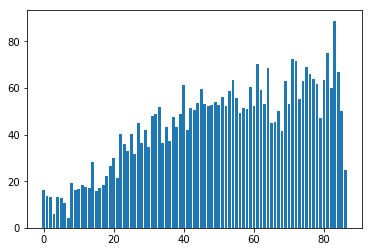

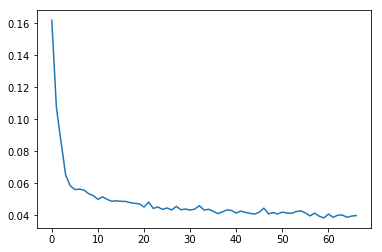

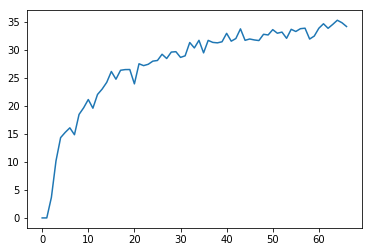

Train Epoch: 133 [0/65192 (0%)]	Loss: 0.039423
Train Epoch: 133 [6400/65192 (10%)]	Loss: 0.041937
Train Epoch: 133 [12800/65192 (20%)]	Loss: 0.036606
Train Epoch: 133 [19200/65192 (29%)]	Loss: 0.033067
Train Epoch: 133 [25600/65192 (39%)]	Loss: 0.035363
Train Epoch: 133 [32000/65192 (49%)]	Loss: 0.044506
Train Epoch: 133 [38400/65192 (59%)]	Loss: 0.043211
Train Epoch: 133 [44800/65192 (69%)]	Loss: 0.036110
Train Epoch: 133 [51200/65192 (79%)]	Loss: 0.034485
Train Epoch: 133 [57600/65192 (88%)]	Loss: 0.034629
Train Epoch: 133 [64000/65192 (98%)]	Loss: 0.034715
Train Epoch: 134 [0/65192 (0%)]	Loss: 0.048886
Train Epoch: 134 [6400/65192 (10%)]	Loss: 0.034355
Train Epoch: 134 [12800/65192 (20%)]	Loss: 0.042853
Train Epoch: 134 [19200/65192 (29%)]	Loss: 0.029658
Train Epoch: 134 [25600/65192 (39%)]	Loss: 0.040044
Train Epoch: 134 [32000/65192 (49%)]	Loss: 0.038531
Train Epoch: 134 [38400/65192 (59%)]	Loss: 0.045013
Train Epoch: 134 [44800/65192 (69%)]	Loss: 0.036569
Train Epoch: 134 [51200/

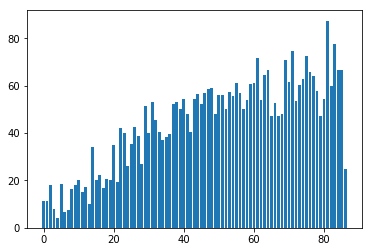

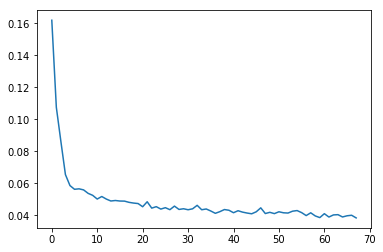

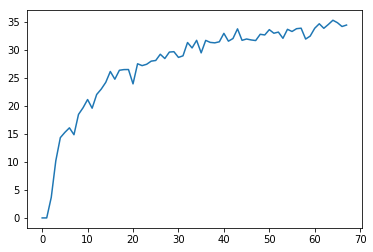

Train Epoch: 135 [0/65192 (0%)]	Loss: 0.036224
Train Epoch: 135 [6400/65192 (10%)]	Loss: 0.040756
Train Epoch: 135 [12800/65192 (20%)]	Loss: 0.045933
Train Epoch: 135 [19200/65192 (29%)]	Loss: 0.036053
Train Epoch: 135 [25600/65192 (39%)]	Loss: 0.039531
Train Epoch: 135 [32000/65192 (49%)]	Loss: 0.037604
Train Epoch: 135 [38400/65192 (59%)]	Loss: 0.028451
Train Epoch: 135 [44800/65192 (69%)]	Loss: 0.040472
Train Epoch: 135 [51200/65192 (79%)]	Loss: 0.034208
Train Epoch: 135 [57600/65192 (88%)]	Loss: 0.041843
Train Epoch: 135 [64000/65192 (98%)]	Loss: 0.038550
Train Epoch: 136 [0/65192 (0%)]	Loss: 0.036801
Train Epoch: 136 [6400/65192 (10%)]	Loss: 0.032569
Train Epoch: 136 [12800/65192 (20%)]	Loss: 0.040597
Train Epoch: 136 [19200/65192 (29%)]	Loss: 0.051355
Train Epoch: 136 [25600/65192 (39%)]	Loss: 0.037365
Train Epoch: 136 [32000/65192 (49%)]	Loss: 0.037445
Train Epoch: 136 [38400/65192 (59%)]	Loss: 0.046996
Train Epoch: 136 [44800/65192 (69%)]	Loss: 0.040528
Train Epoch: 136 [51200/

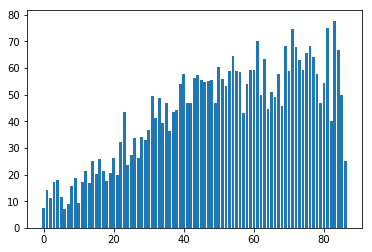

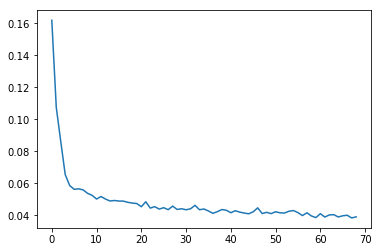

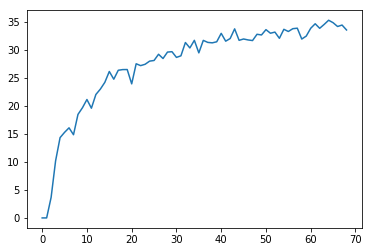

Train Epoch: 137 [0/65192 (0%)]	Loss: 0.048686
Train Epoch: 137 [6400/65192 (10%)]	Loss: 0.034836
Train Epoch: 137 [12800/65192 (20%)]	Loss: 0.039530
Train Epoch: 137 [19200/65192 (29%)]	Loss: 0.040333
Train Epoch: 137 [25600/65192 (39%)]	Loss: 0.049345
Train Epoch: 137 [32000/65192 (49%)]	Loss: 0.036506
Train Epoch: 137 [38400/65192 (59%)]	Loss: 0.052825
Train Epoch: 137 [44800/65192 (69%)]	Loss: 0.045291
Train Epoch: 137 [51200/65192 (79%)]	Loss: 0.051198
Train Epoch: 137 [57600/65192 (88%)]	Loss: 0.036741
Train Epoch: 137 [64000/65192 (98%)]	Loss: 0.045238
Train Epoch: 138 [0/65192 (0%)]	Loss: 0.037879
Train Epoch: 138 [6400/65192 (10%)]	Loss: 0.037522
Train Epoch: 138 [12800/65192 (20%)]	Loss: 0.044161
Train Epoch: 138 [19200/65192 (29%)]	Loss: 0.043196
Train Epoch: 138 [25600/65192 (39%)]	Loss: 0.044085
Train Epoch: 138 [32000/65192 (49%)]	Loss: 0.045305
Train Epoch: 138 [38400/65192 (59%)]	Loss: 0.037455
Train Epoch: 138 [44800/65192 (69%)]	Loss: 0.033540
Train Epoch: 138 [51200/

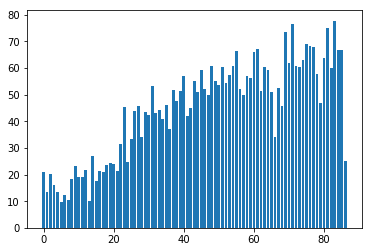

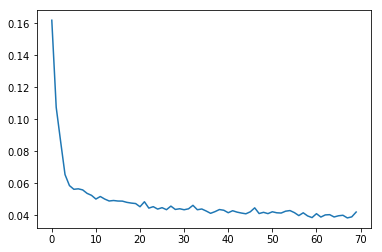

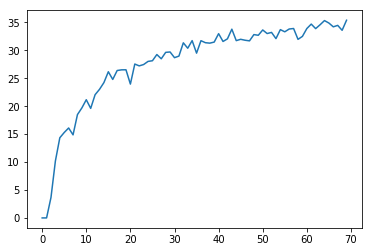

Train Epoch: 139 [0/65192 (0%)]	Loss: 0.031344
Train Epoch: 139 [6400/65192 (10%)]	Loss: 0.040963
Train Epoch: 139 [12800/65192 (20%)]	Loss: 0.032644
Train Epoch: 139 [19200/65192 (29%)]	Loss: 0.040370
Train Epoch: 139 [25600/65192 (39%)]	Loss: 0.028761
Train Epoch: 139 [32000/65192 (49%)]	Loss: 0.041617
Train Epoch: 139 [38400/65192 (59%)]	Loss: 0.037675
Train Epoch: 139 [44800/65192 (69%)]	Loss: 0.037787
Train Epoch: 139 [51200/65192 (79%)]	Loss: 0.032714
Train Epoch: 139 [57600/65192 (88%)]	Loss: 0.039540
Train Epoch: 139 [64000/65192 (98%)]	Loss: 0.037820
Train Epoch: 140 [0/65192 (0%)]	Loss: 0.054323
Train Epoch: 140 [6400/65192 (10%)]	Loss: 0.044810
Train Epoch: 140 [12800/65192 (20%)]	Loss: 0.045299
Train Epoch: 140 [19200/65192 (29%)]	Loss: 0.044367
Train Epoch: 140 [25600/65192 (39%)]	Loss: 0.044231
Train Epoch: 140 [32000/65192 (49%)]	Loss: 0.046184
Train Epoch: 140 [38400/65192 (59%)]	Loss: 0.042004
Train Epoch: 140 [44800/65192 (69%)]	Loss: 0.040965
Train Epoch: 140 [51200/

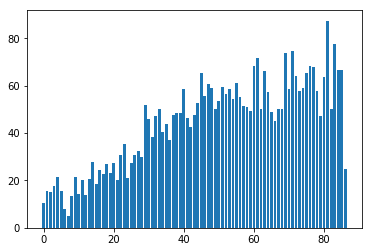

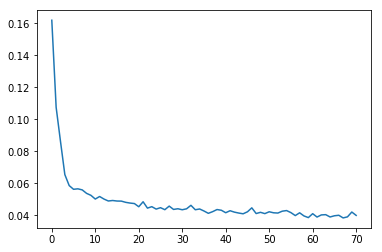

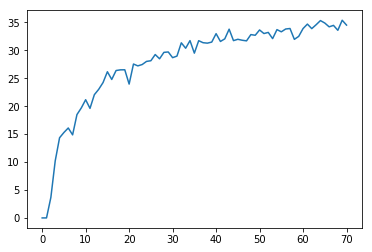

Train Epoch: 141 [0/65192 (0%)]	Loss: 0.040903
Train Epoch: 141 [6400/65192 (10%)]	Loss: 0.044965
Train Epoch: 141 [12800/65192 (20%)]	Loss: 0.037089
Train Epoch: 141 [19200/65192 (29%)]	Loss: 0.043562
Train Epoch: 141 [25600/65192 (39%)]	Loss: 0.037630
Train Epoch: 141 [32000/65192 (49%)]	Loss: 0.034665
Train Epoch: 141 [38400/65192 (59%)]	Loss: 0.037777
Train Epoch: 141 [44800/65192 (69%)]	Loss: 0.045007
Train Epoch: 141 [51200/65192 (79%)]	Loss: 0.046744
Train Epoch: 141 [57600/65192 (88%)]	Loss: 0.036592
Train Epoch: 141 [64000/65192 (98%)]	Loss: 0.054291
Train Epoch: 142 [0/65192 (0%)]	Loss: 0.035723
Train Epoch: 142 [6400/65192 (10%)]	Loss: 0.042419
Train Epoch: 142 [12800/65192 (20%)]	Loss: 0.042940
Train Epoch: 142 [19200/65192 (29%)]	Loss: 0.036799
Train Epoch: 142 [25600/65192 (39%)]	Loss: 0.039646
Train Epoch: 142 [32000/65192 (49%)]	Loss: 0.032714
Train Epoch: 142 [38400/65192 (59%)]	Loss: 0.046702
Train Epoch: 142 [44800/65192 (69%)]	Loss: 0.046359
Train Epoch: 142 [51200/

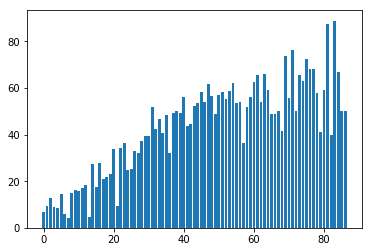

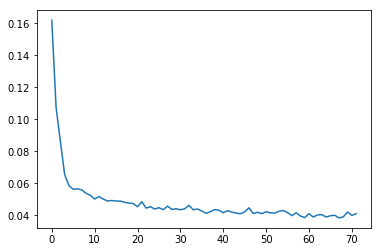

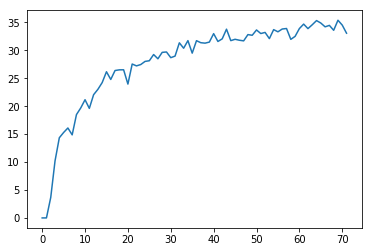

Train Epoch: 143 [0/65192 (0%)]	Loss: 0.039647
Train Epoch: 143 [6400/65192 (10%)]	Loss: 0.048614
Train Epoch: 143 [12800/65192 (20%)]	Loss: 0.041347
Train Epoch: 143 [19200/65192 (29%)]	Loss: 0.032346
Train Epoch: 143 [25600/65192 (39%)]	Loss: 0.030524
Train Epoch: 143 [32000/65192 (49%)]	Loss: 0.038391
Train Epoch: 143 [38400/65192 (59%)]	Loss: 0.042018
Train Epoch: 143 [44800/65192 (69%)]	Loss: 0.034467
Train Epoch: 143 [51200/65192 (79%)]	Loss: 0.047566
Train Epoch: 143 [57600/65192 (88%)]	Loss: 0.038599
Train Epoch: 143 [64000/65192 (98%)]	Loss: 0.034012
Train Epoch: 144 [0/65192 (0%)]	Loss: 0.035138
Train Epoch: 144 [6400/65192 (10%)]	Loss: 0.044450
Train Epoch: 144 [12800/65192 (20%)]	Loss: 0.033441
Train Epoch: 144 [19200/65192 (29%)]	Loss: 0.040189
Train Epoch: 144 [25600/65192 (39%)]	Loss: 0.032807
Train Epoch: 144 [32000/65192 (49%)]	Loss: 0.042563
Train Epoch: 144 [38400/65192 (59%)]	Loss: 0.035791
Train Epoch: 144 [44800/65192 (69%)]	Loss: 0.039729
Train Epoch: 144 [51200/

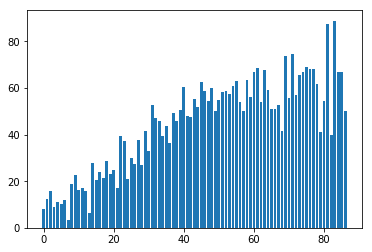

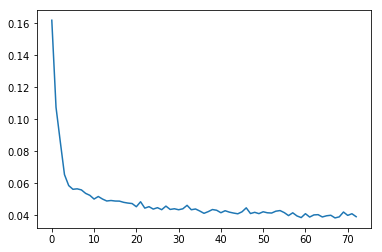

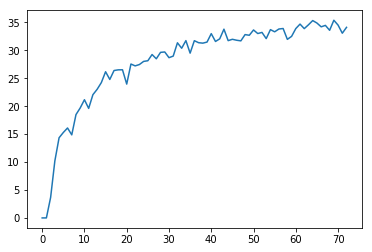

Train Epoch: 145 [0/65192 (0%)]	Loss: 0.044626
Train Epoch: 145 [6400/65192 (10%)]	Loss: 0.041750
Train Epoch: 145 [12800/65192 (20%)]	Loss: 0.036024
Train Epoch: 145 [19200/65192 (29%)]	Loss: 0.044877
Train Epoch: 145 [25600/65192 (39%)]	Loss: 0.042119
Train Epoch: 145 [32000/65192 (49%)]	Loss: 0.044645
Train Epoch: 145 [38400/65192 (59%)]	Loss: 0.035317
Train Epoch: 145 [44800/65192 (69%)]	Loss: 0.039047
Train Epoch: 145 [51200/65192 (79%)]	Loss: 0.043385
Train Epoch: 145 [57600/65192 (88%)]	Loss: 0.038244
Train Epoch: 145 [64000/65192 (98%)]	Loss: 0.032633
Train Epoch: 146 [0/65192 (0%)]	Loss: 0.037983
Train Epoch: 146 [6400/65192 (10%)]	Loss: 0.044377
Train Epoch: 146 [12800/65192 (20%)]	Loss: 0.053983
Train Epoch: 146 [19200/65192 (29%)]	Loss: 0.042367
Train Epoch: 146 [25600/65192 (39%)]	Loss: 0.036212
Train Epoch: 146 [32000/65192 (49%)]	Loss: 0.034650
Train Epoch: 146 [38400/65192 (59%)]	Loss: 0.039143
Train Epoch: 146 [44800/65192 (69%)]	Loss: 0.035020
Train Epoch: 146 [51200/

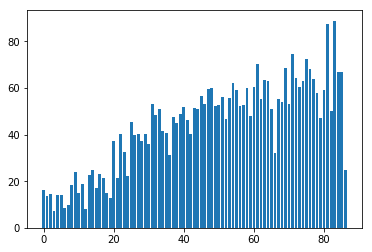

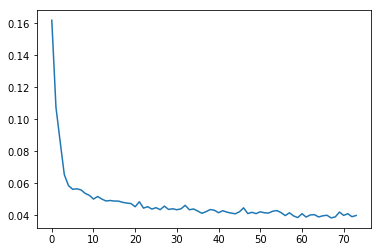

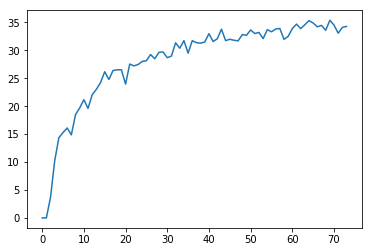

Train Epoch: 147 [0/65192 (0%)]	Loss: 0.039476
Train Epoch: 147 [6400/65192 (10%)]	Loss: 0.038826
Train Epoch: 147 [12800/65192 (20%)]	Loss: 0.036555
Train Epoch: 147 [19200/65192 (29%)]	Loss: 0.042845
Train Epoch: 147 [25600/65192 (39%)]	Loss: 0.035403
Train Epoch: 147 [32000/65192 (49%)]	Loss: 0.033169
Train Epoch: 147 [38400/65192 (59%)]	Loss: 0.032714
Train Epoch: 147 [44800/65192 (69%)]	Loss: 0.040211
Train Epoch: 147 [51200/65192 (79%)]	Loss: 0.038074
Train Epoch: 147 [57600/65192 (88%)]	Loss: 0.044912
Train Epoch: 147 [64000/65192 (98%)]	Loss: 0.054511
Train Epoch: 148 [0/65192 (0%)]	Loss: 0.036767
Train Epoch: 148 [6400/65192 (10%)]	Loss: 0.046840
Train Epoch: 148 [12800/65192 (20%)]	Loss: 0.036110
Train Epoch: 148 [19200/65192 (29%)]	Loss: 0.040151
Train Epoch: 148 [25600/65192 (39%)]	Loss: 0.042415
Train Epoch: 148 [32000/65192 (49%)]	Loss: 0.041826
Train Epoch: 148 [38400/65192 (59%)]	Loss: 0.039637
Train Epoch: 148 [44800/65192 (69%)]	Loss: 0.046482
Train Epoch: 148 [51200/

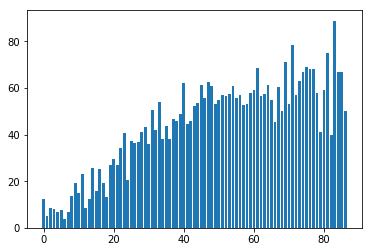

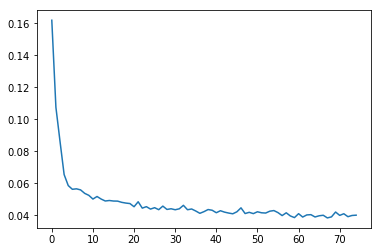

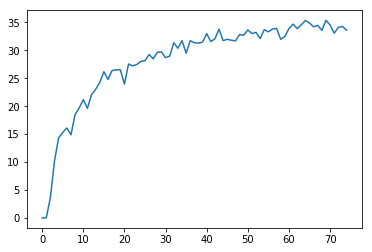

Train Epoch: 149 [0/65192 (0%)]	Loss: 0.039852
Train Epoch: 149 [6400/65192 (10%)]	Loss: 0.040631
Train Epoch: 149 [12800/65192 (20%)]	Loss: 0.029510
Train Epoch: 149 [19200/65192 (29%)]	Loss: 0.034558
Train Epoch: 149 [25600/65192 (39%)]	Loss: 0.037187
Train Epoch: 149 [32000/65192 (49%)]	Loss: 0.038918
Train Epoch: 149 [38400/65192 (59%)]	Loss: 0.041741
Train Epoch: 149 [44800/65192 (69%)]	Loss: 0.039159
Train Epoch: 149 [51200/65192 (79%)]	Loss: 0.046296
Train Epoch: 149 [57600/65192 (88%)]	Loss: 0.038422
Train Epoch: 149 [64000/65192 (98%)]	Loss: 0.036782
Train Epoch: 150 [0/65192 (0%)]	Loss: 0.041196
Train Epoch: 150 [6400/65192 (10%)]	Loss: 0.054344
Train Epoch: 150 [12800/65192 (20%)]	Loss: 0.042576
Train Epoch: 150 [19200/65192 (29%)]	Loss: 0.040594
Train Epoch: 150 [25600/65192 (39%)]	Loss: 0.036821
Train Epoch: 150 [32000/65192 (49%)]	Loss: 0.044107
Train Epoch: 150 [38400/65192 (59%)]	Loss: 0.039598
Train Epoch: 150 [44800/65192 (69%)]	Loss: 0.039663
Train Epoch: 150 [51200/

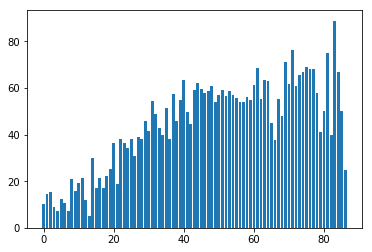

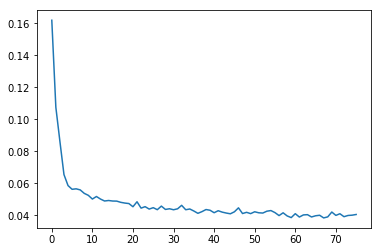

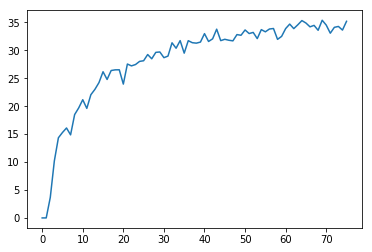

Train Epoch: 151 [0/65192 (0%)]	Loss: 0.034881
Train Epoch: 151 [6400/65192 (10%)]	Loss: 0.054972
Train Epoch: 151 [12800/65192 (20%)]	Loss: 0.040820
Train Epoch: 151 [19200/65192 (29%)]	Loss: 0.037934
Train Epoch: 151 [25600/65192 (39%)]	Loss: 0.042396
Train Epoch: 151 [32000/65192 (49%)]	Loss: 0.029479
Train Epoch: 151 [38400/65192 (59%)]	Loss: 0.041393
Train Epoch: 151 [44800/65192 (69%)]	Loss: 0.035585
Train Epoch: 151 [51200/65192 (79%)]	Loss: 0.025485
Train Epoch: 151 [57600/65192 (88%)]	Loss: 0.045905
Train Epoch: 151 [64000/65192 (98%)]	Loss: 0.040305
Train Epoch: 152 [0/65192 (0%)]	Loss: 0.038738
Train Epoch: 152 [6400/65192 (10%)]	Loss: 0.047206
Train Epoch: 152 [12800/65192 (20%)]	Loss: 0.035928
Train Epoch: 152 [19200/65192 (29%)]	Loss: 0.044230
Train Epoch: 152 [25600/65192 (39%)]	Loss: 0.034046
Train Epoch: 152 [32000/65192 (49%)]	Loss: 0.042704
Train Epoch: 152 [38400/65192 (59%)]	Loss: 0.043500
Train Epoch: 152 [44800/65192 (69%)]	Loss: 0.042769
Train Epoch: 152 [51200/

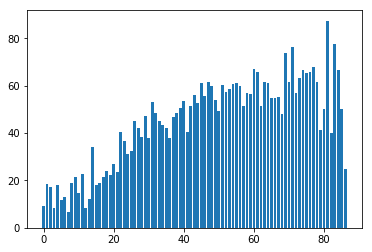

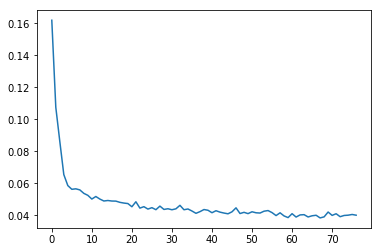

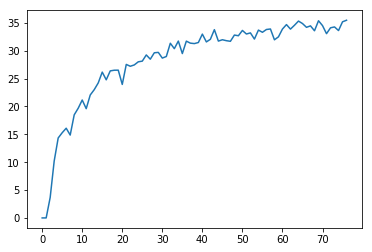

Train Epoch: 153 [0/65192 (0%)]	Loss: 0.033083
Train Epoch: 153 [6400/65192 (10%)]	Loss: 0.043393
Train Epoch: 153 [12800/65192 (20%)]	Loss: 0.031531
Train Epoch: 153 [19200/65192 (29%)]	Loss: 0.030358
Train Epoch: 153 [25600/65192 (39%)]	Loss: 0.039452
Train Epoch: 153 [32000/65192 (49%)]	Loss: 0.038516
Train Epoch: 153 [38400/65192 (59%)]	Loss: 0.040406
Train Epoch: 153 [44800/65192 (69%)]	Loss: 0.042183
Train Epoch: 153 [51200/65192 (79%)]	Loss: 0.034901
Train Epoch: 153 [57600/65192 (88%)]	Loss: 0.039987
Train Epoch: 153 [64000/65192 (98%)]	Loss: 0.053088
Train Epoch: 154 [0/65192 (0%)]	Loss: 0.045737
Train Epoch: 154 [6400/65192 (10%)]	Loss: 0.039972
Train Epoch: 154 [12800/65192 (20%)]	Loss: 0.034818
Train Epoch: 154 [19200/65192 (29%)]	Loss: 0.041283
Train Epoch: 154 [25600/65192 (39%)]	Loss: 0.039694
Train Epoch: 154 [32000/65192 (49%)]	Loss: 0.036751
Train Epoch: 154 [38400/65192 (59%)]	Loss: 0.034186
Train Epoch: 154 [44800/65192 (69%)]	Loss: 0.032519
Train Epoch: 154 [51200/

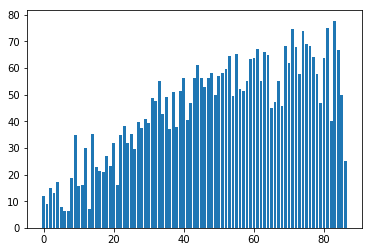

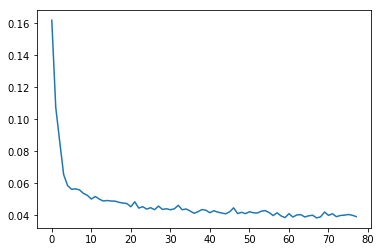

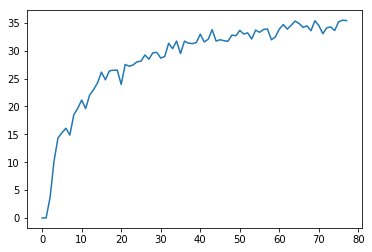

Train Epoch: 155 [0/65192 (0%)]	Loss: 0.040002
Train Epoch: 155 [6400/65192 (10%)]	Loss: 0.044379
Train Epoch: 155 [12800/65192 (20%)]	Loss: 0.038030
Train Epoch: 155 [19200/65192 (29%)]	Loss: 0.039673
Train Epoch: 155 [25600/65192 (39%)]	Loss: 0.035398
Train Epoch: 155 [32000/65192 (49%)]	Loss: 0.025939
Train Epoch: 155 [38400/65192 (59%)]	Loss: 0.038674
Train Epoch: 155 [44800/65192 (69%)]	Loss: 0.044037
Train Epoch: 155 [51200/65192 (79%)]	Loss: 0.032884
Train Epoch: 155 [57600/65192 (88%)]	Loss: 0.036997
Train Epoch: 155 [64000/65192 (98%)]	Loss: 0.038261
Train Epoch: 156 [0/65192 (0%)]	Loss: 0.040462
Train Epoch: 156 [6400/65192 (10%)]	Loss: 0.028808
Train Epoch: 156 [12800/65192 (20%)]	Loss: 0.038161
Train Epoch: 156 [19200/65192 (29%)]	Loss: 0.041536
Train Epoch: 156 [25600/65192 (39%)]	Loss: 0.039306
Train Epoch: 156 [32000/65192 (49%)]	Loss: 0.031822
Train Epoch: 156 [38400/65192 (59%)]	Loss: 0.042626
Train Epoch: 156 [44800/65192 (69%)]	Loss: 0.035761
Train Epoch: 156 [51200/

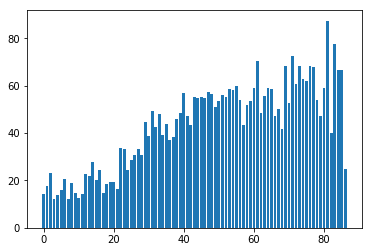

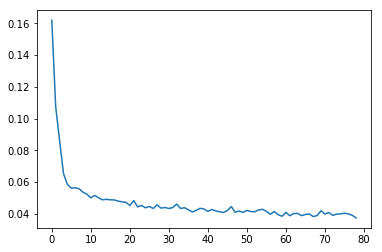

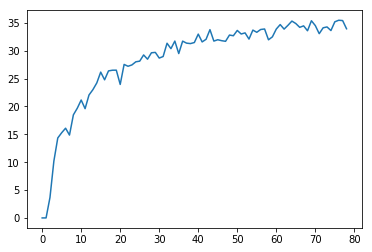

Train Epoch: 157 [0/65192 (0%)]	Loss: 0.033792
Train Epoch: 157 [6400/65192 (10%)]	Loss: 0.037154
Train Epoch: 157 [12800/65192 (20%)]	Loss: 0.045118
Train Epoch: 157 [19200/65192 (29%)]	Loss: 0.042685
Train Epoch: 157 [25600/65192 (39%)]	Loss: 0.038799
Train Epoch: 157 [32000/65192 (49%)]	Loss: 0.037938
Train Epoch: 157 [38400/65192 (59%)]	Loss: 0.033608
Train Epoch: 157 [44800/65192 (69%)]	Loss: 0.038417
Train Epoch: 157 [51200/65192 (79%)]	Loss: 0.051034
Train Epoch: 157 [57600/65192 (88%)]	Loss: 0.037361
Train Epoch: 157 [64000/65192 (98%)]	Loss: 0.035370
Train Epoch: 158 [0/65192 (0%)]	Loss: 0.041336
Train Epoch: 158 [6400/65192 (10%)]	Loss: 0.038854
Train Epoch: 158 [12800/65192 (20%)]	Loss: 0.042480
Train Epoch: 158 [19200/65192 (29%)]	Loss: 0.037936
Train Epoch: 158 [25600/65192 (39%)]	Loss: 0.037125
Train Epoch: 158 [32000/65192 (49%)]	Loss: 0.036316
Train Epoch: 158 [38400/65192 (59%)]	Loss: 0.033600
Train Epoch: 158 [44800/65192 (69%)]	Loss: 0.021961
Train Epoch: 158 [51200/

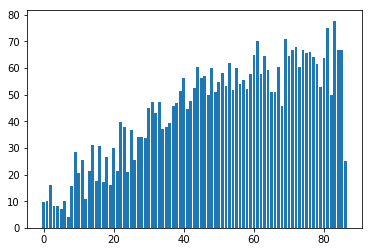

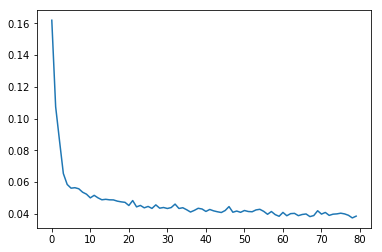

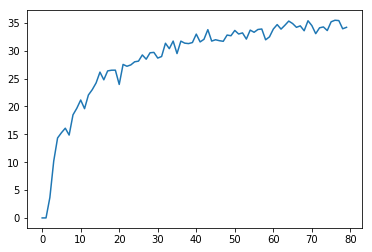

Train Epoch: 159 [0/65192 (0%)]	Loss: 0.035403
Train Epoch: 159 [6400/65192 (10%)]	Loss: 0.044216
Train Epoch: 159 [12800/65192 (20%)]	Loss: 0.041156
Train Epoch: 159 [19200/65192 (29%)]	Loss: 0.037978
Train Epoch: 159 [25600/65192 (39%)]	Loss: 0.039254
Train Epoch: 159 [32000/65192 (49%)]	Loss: 0.030731
Train Epoch: 159 [38400/65192 (59%)]	Loss: 0.041189
Train Epoch: 159 [44800/65192 (69%)]	Loss: 0.038043
Train Epoch: 159 [51200/65192 (79%)]	Loss: 0.032054
Train Epoch: 159 [57600/65192 (88%)]	Loss: 0.038719
Train Epoch: 159 [64000/65192 (98%)]	Loss: 0.039223
Train Epoch: 160 [0/65192 (0%)]	Loss: 0.041574
Train Epoch: 160 [6400/65192 (10%)]	Loss: 0.037648
Train Epoch: 160 [12800/65192 (20%)]	Loss: 0.042592
Train Epoch: 160 [19200/65192 (29%)]	Loss: 0.035039
Train Epoch: 160 [25600/65192 (39%)]	Loss: 0.034449
Train Epoch: 160 [32000/65192 (49%)]	Loss: 0.046741
Train Epoch: 160 [38400/65192 (59%)]	Loss: 0.039719
Train Epoch: 160 [44800/65192 (69%)]	Loss: 0.046024
Train Epoch: 160 [51200/

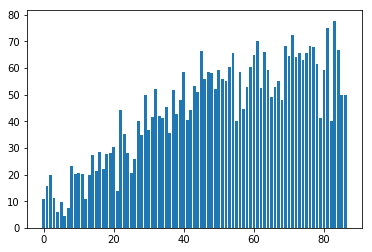

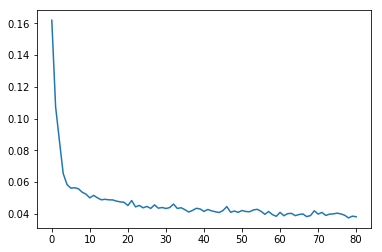

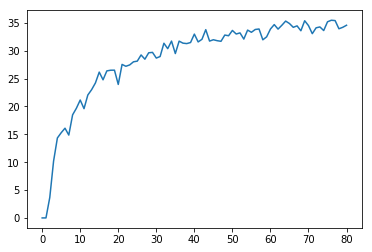

Train Epoch: 161 [0/65192 (0%)]	Loss: 0.034647
Train Epoch: 161 [6400/65192 (10%)]	Loss: 0.045120
Train Epoch: 161 [12800/65192 (20%)]	Loss: 0.031113
Train Epoch: 161 [19200/65192 (29%)]	Loss: 0.038582
Train Epoch: 161 [25600/65192 (39%)]	Loss: 0.038429
Train Epoch: 161 [32000/65192 (49%)]	Loss: 0.041387
Train Epoch: 161 [38400/65192 (59%)]	Loss: 0.035669
Train Epoch: 161 [44800/65192 (69%)]	Loss: 0.035717
Train Epoch: 161 [51200/65192 (79%)]	Loss: 0.039837
Train Epoch: 161 [57600/65192 (88%)]	Loss: 0.038322
Train Epoch: 161 [64000/65192 (98%)]	Loss: 0.037967
Train Epoch: 162 [0/65192 (0%)]	Loss: 0.042187
Train Epoch: 162 [6400/65192 (10%)]	Loss: 0.047707
Train Epoch: 162 [12800/65192 (20%)]	Loss: 0.027465
Train Epoch: 162 [19200/65192 (29%)]	Loss: 0.040801
Train Epoch: 162 [25600/65192 (39%)]	Loss: 0.043695
Train Epoch: 162 [32000/65192 (49%)]	Loss: 0.041390
Train Epoch: 162 [38400/65192 (59%)]	Loss: 0.042897
Train Epoch: 162 [44800/65192 (69%)]	Loss: 0.047174
Train Epoch: 162 [51200/

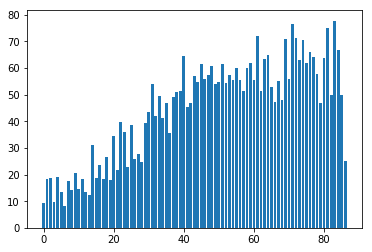

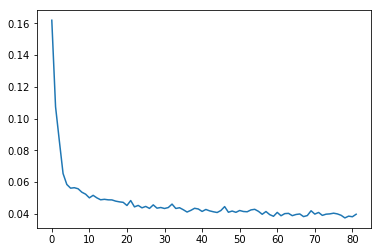

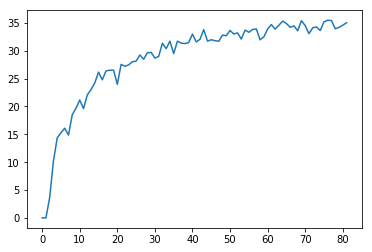

Train Epoch: 163 [0/65192 (0%)]	Loss: 0.034756
Train Epoch: 163 [6400/65192 (10%)]	Loss: 0.037811
Train Epoch: 163 [12800/65192 (20%)]	Loss: 0.038491
Train Epoch: 163 [19200/65192 (29%)]	Loss: 0.033314
Train Epoch: 163 [25600/65192 (39%)]	Loss: 0.033915
Train Epoch: 163 [32000/65192 (49%)]	Loss: 0.026539
Train Epoch: 163 [38400/65192 (59%)]	Loss: 0.049924
Train Epoch: 163 [44800/65192 (69%)]	Loss: 0.032201
Train Epoch: 163 [51200/65192 (79%)]	Loss: 0.047963
Train Epoch: 163 [57600/65192 (88%)]	Loss: 0.040563
Train Epoch: 163 [64000/65192 (98%)]	Loss: 0.038212
Train Epoch: 164 [0/65192 (0%)]	Loss: 0.038728
Train Epoch: 164 [6400/65192 (10%)]	Loss: 0.036393
Train Epoch: 164 [12800/65192 (20%)]	Loss: 0.035777
Train Epoch: 164 [19200/65192 (29%)]	Loss: 0.044473
Train Epoch: 164 [25600/65192 (39%)]	Loss: 0.034049
Train Epoch: 164 [32000/65192 (49%)]	Loss: 0.034835
Train Epoch: 164 [38400/65192 (59%)]	Loss: 0.037816
Train Epoch: 164 [44800/65192 (69%)]	Loss: 0.050016
Train Epoch: 164 [51200/

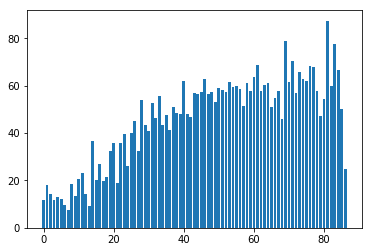

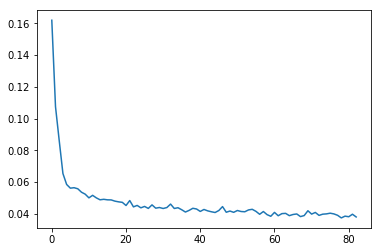

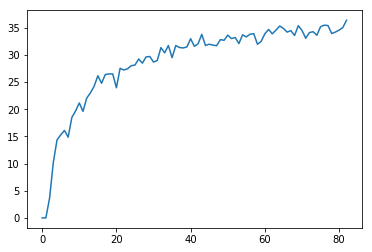

Train Epoch: 165 [0/65192 (0%)]	Loss: 0.047385
Train Epoch: 165 [6400/65192 (10%)]	Loss: 0.047692
Train Epoch: 165 [12800/65192 (20%)]	Loss: 0.031043
Train Epoch: 165 [19200/65192 (29%)]	Loss: 0.038182
Train Epoch: 165 [25600/65192 (39%)]	Loss: 0.029935
Train Epoch: 165 [32000/65192 (49%)]	Loss: 0.045100
Train Epoch: 165 [38400/65192 (59%)]	Loss: 0.033393
Train Epoch: 165 [44800/65192 (69%)]	Loss: 0.037474
Train Epoch: 165 [51200/65192 (79%)]	Loss: 0.034789
Train Epoch: 165 [57600/65192 (88%)]	Loss: 0.039516
Train Epoch: 165 [64000/65192 (98%)]	Loss: 0.036988
Train Epoch: 166 [0/65192 (0%)]	Loss: 0.037092
Train Epoch: 166 [6400/65192 (10%)]	Loss: 0.044435
Train Epoch: 166 [12800/65192 (20%)]	Loss: 0.049849
Train Epoch: 166 [19200/65192 (29%)]	Loss: 0.045353
Train Epoch: 166 [25600/65192 (39%)]	Loss: 0.032381
Train Epoch: 166 [32000/65192 (49%)]	Loss: 0.029855
Train Epoch: 166 [38400/65192 (59%)]	Loss: 0.031175
Train Epoch: 166 [44800/65192 (69%)]	Loss: 0.030677
Train Epoch: 166 [51200/

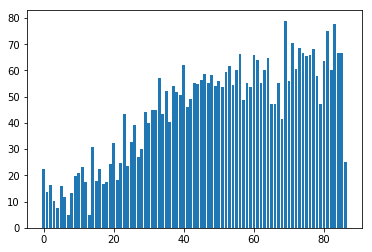

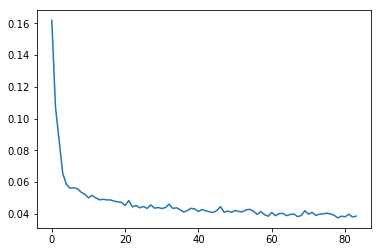

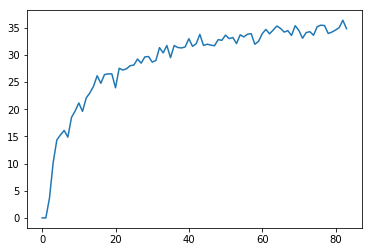

Train Epoch: 167 [0/65192 (0%)]	Loss: 0.028887
Train Epoch: 167 [6400/65192 (10%)]	Loss: 0.040933
Train Epoch: 167 [12800/65192 (20%)]	Loss: 0.040221
Train Epoch: 167 [19200/65192 (29%)]	Loss: 0.033426
Train Epoch: 167 [25600/65192 (39%)]	Loss: 0.031745
Train Epoch: 167 [32000/65192 (49%)]	Loss: 0.039816
Train Epoch: 167 [38400/65192 (59%)]	Loss: 0.032232
Train Epoch: 167 [44800/65192 (69%)]	Loss: 0.045381
Train Epoch: 167 [51200/65192 (79%)]	Loss: 0.048014
Train Epoch: 167 [57600/65192 (88%)]	Loss: 0.041697
Train Epoch: 167 [64000/65192 (98%)]	Loss: 0.044466
Train Epoch: 168 [0/65192 (0%)]	Loss: 0.035472
Train Epoch: 168 [6400/65192 (10%)]	Loss: 0.047934
Train Epoch: 168 [12800/65192 (20%)]	Loss: 0.044159
Train Epoch: 168 [19200/65192 (29%)]	Loss: 0.037313
Train Epoch: 168 [25600/65192 (39%)]	Loss: 0.041313
Train Epoch: 168 [32000/65192 (49%)]	Loss: 0.042149
Train Epoch: 168 [38400/65192 (59%)]	Loss: 0.040015
Train Epoch: 168 [44800/65192 (69%)]	Loss: 0.029476
Train Epoch: 168 [51200/

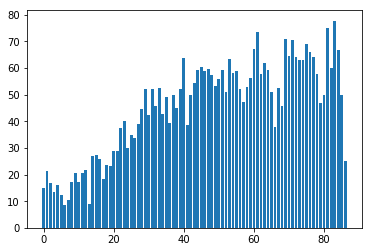

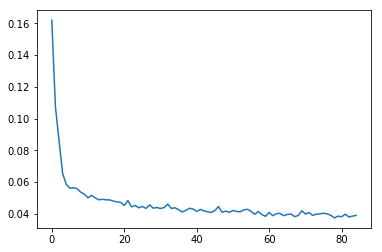

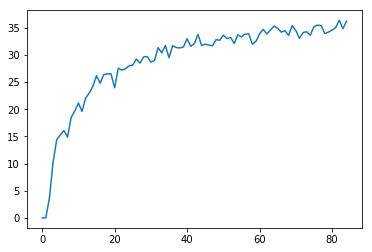

Train Epoch: 169 [0/65192 (0%)]	Loss: 0.033381
Train Epoch: 169 [6400/65192 (10%)]	Loss: 0.034273
Train Epoch: 169 [12800/65192 (20%)]	Loss: 0.032102
Train Epoch: 169 [19200/65192 (29%)]	Loss: 0.038401
Train Epoch: 169 [25600/65192 (39%)]	Loss: 0.039640
Train Epoch: 169 [32000/65192 (49%)]	Loss: 0.037766
Train Epoch: 169 [38400/65192 (59%)]	Loss: 0.043445
Train Epoch: 169 [44800/65192 (69%)]	Loss: 0.038925
Train Epoch: 169 [51200/65192 (79%)]	Loss: 0.035304
Train Epoch: 169 [57600/65192 (88%)]	Loss: 0.035154
Train Epoch: 169 [64000/65192 (98%)]	Loss: 0.038754
Train Epoch: 170 [0/65192 (0%)]	Loss: 0.047380
Train Epoch: 170 [6400/65192 (10%)]	Loss: 0.034296
Train Epoch: 170 [12800/65192 (20%)]	Loss: 0.033096
Train Epoch: 170 [19200/65192 (29%)]	Loss: 0.040186
Train Epoch: 170 [25600/65192 (39%)]	Loss: 0.036434
Train Epoch: 170 [32000/65192 (49%)]	Loss: 0.032921
Train Epoch: 170 [38400/65192 (59%)]	Loss: 0.044648
Train Epoch: 170 [44800/65192 (69%)]	Loss: 0.043257
Train Epoch: 170 [51200/

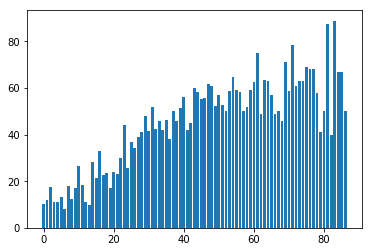

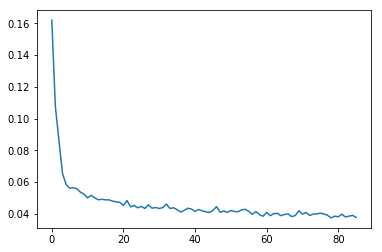

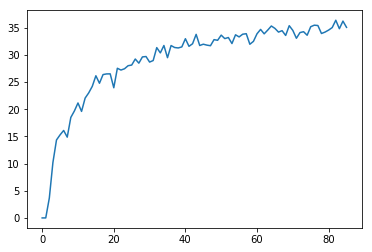

Train Epoch: 171 [0/65192 (0%)]	Loss: 0.038418
Train Epoch: 171 [6400/65192 (10%)]	Loss: 0.035707
Train Epoch: 171 [12800/65192 (20%)]	Loss: 0.035181
Train Epoch: 171 [19200/65192 (29%)]	Loss: 0.033939
Train Epoch: 171 [25600/65192 (39%)]	Loss: 0.042026
Train Epoch: 171 [32000/65192 (49%)]	Loss: 0.047964
Train Epoch: 171 [38400/65192 (59%)]	Loss: 0.040544
Train Epoch: 171 [44800/65192 (69%)]	Loss: 0.037360
Train Epoch: 171 [51200/65192 (79%)]	Loss: 0.041118
Train Epoch: 171 [57600/65192 (88%)]	Loss: 0.047889
Train Epoch: 171 [64000/65192 (98%)]	Loss: 0.034409
Train Epoch: 172 [0/65192 (0%)]	Loss: 0.039602
Train Epoch: 172 [6400/65192 (10%)]	Loss: 0.040902
Train Epoch: 172 [12800/65192 (20%)]	Loss: 0.041769
Train Epoch: 172 [19200/65192 (29%)]	Loss: 0.036920
Train Epoch: 172 [25600/65192 (39%)]	Loss: 0.033886
Train Epoch: 172 [32000/65192 (49%)]	Loss: 0.038371
Train Epoch: 172 [38400/65192 (59%)]	Loss: 0.037648
Train Epoch: 172 [44800/65192 (69%)]	Loss: 0.039209
Train Epoch: 172 [51200/

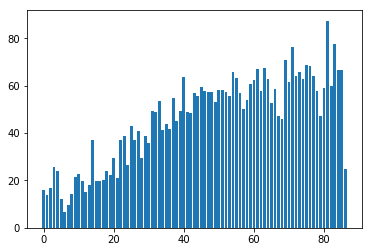

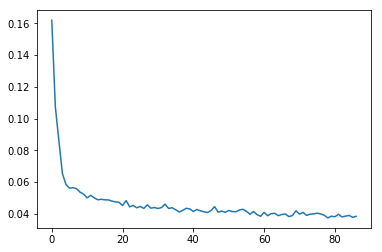

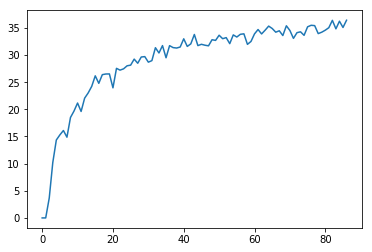

Train Epoch: 173 [0/65192 (0%)]	Loss: 0.041474
Train Epoch: 173 [6400/65192 (10%)]	Loss: 0.050985
Train Epoch: 173 [12800/65192 (20%)]	Loss: 0.049322
Train Epoch: 173 [19200/65192 (29%)]	Loss: 0.032482
Train Epoch: 173 [25600/65192 (39%)]	Loss: 0.039019
Train Epoch: 173 [32000/65192 (49%)]	Loss: 0.035229
Train Epoch: 173 [38400/65192 (59%)]	Loss: 0.035626
Train Epoch: 173 [44800/65192 (69%)]	Loss: 0.042547
Train Epoch: 173 [51200/65192 (79%)]	Loss: 0.037848
Train Epoch: 173 [57600/65192 (88%)]	Loss: 0.041617
Train Epoch: 173 [64000/65192 (98%)]	Loss: 0.039028
Train Epoch: 174 [0/65192 (0%)]	Loss: 0.044096
Train Epoch: 174 [6400/65192 (10%)]	Loss: 0.036816
Train Epoch: 174 [12800/65192 (20%)]	Loss: 0.043830
Train Epoch: 174 [19200/65192 (29%)]	Loss: 0.037988
Train Epoch: 174 [25600/65192 (39%)]	Loss: 0.041549
Train Epoch: 174 [32000/65192 (49%)]	Loss: 0.040419
Train Epoch: 174 [38400/65192 (59%)]	Loss: 0.042083
Train Epoch: 174 [44800/65192 (69%)]	Loss: 0.044979
Train Epoch: 174 [51200/

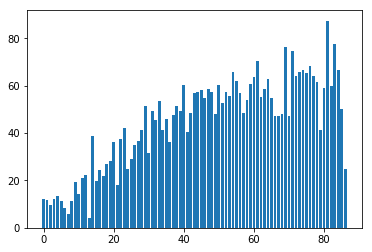

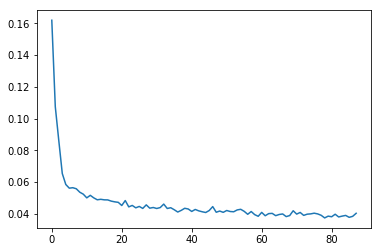

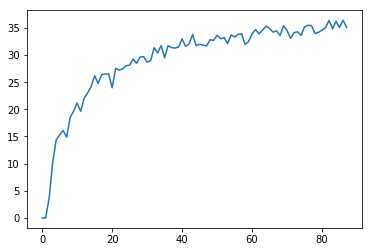

Train Epoch: 175 [0/65192 (0%)]	Loss: 0.032653
Train Epoch: 175 [6400/65192 (10%)]	Loss: 0.042176
Train Epoch: 175 [12800/65192 (20%)]	Loss: 0.037897
Train Epoch: 175 [19200/65192 (29%)]	Loss: 0.041303
Train Epoch: 175 [25600/65192 (39%)]	Loss: 0.044748
Train Epoch: 175 [32000/65192 (49%)]	Loss: 0.035209
Train Epoch: 175 [38400/65192 (59%)]	Loss: 0.036094
Train Epoch: 175 [44800/65192 (69%)]	Loss: 0.051643
Train Epoch: 175 [51200/65192 (79%)]	Loss: 0.030449
Train Epoch: 175 [57600/65192 (88%)]	Loss: 0.044310
Train Epoch: 175 [64000/65192 (98%)]	Loss: 0.038623
Train Epoch: 176 [0/65192 (0%)]	Loss: 0.050264
Train Epoch: 176 [6400/65192 (10%)]	Loss: 0.043769
Train Epoch: 176 [12800/65192 (20%)]	Loss: 0.044677
Train Epoch: 176 [19200/65192 (29%)]	Loss: 0.035092
Train Epoch: 176 [25600/65192 (39%)]	Loss: 0.039965
Train Epoch: 176 [32000/65192 (49%)]	Loss: 0.040742
Train Epoch: 176 [38400/65192 (59%)]	Loss: 0.034520
Train Epoch: 176 [44800/65192 (69%)]	Loss: 0.030547
Train Epoch: 176 [51200/

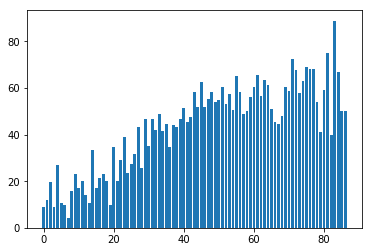

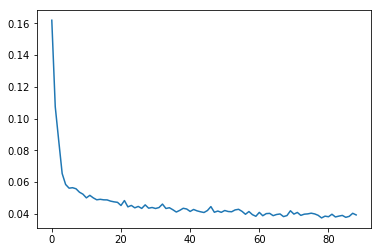

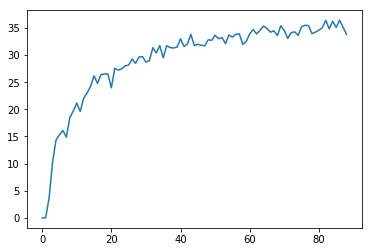

Train Epoch: 177 [0/65192 (0%)]	Loss: 0.046518
Train Epoch: 177 [6400/65192 (10%)]	Loss: 0.029823
Train Epoch: 177 [12800/65192 (20%)]	Loss: 0.041992
Train Epoch: 177 [19200/65192 (29%)]	Loss: 0.043711
Train Epoch: 177 [25600/65192 (39%)]	Loss: 0.036886
Train Epoch: 177 [32000/65192 (49%)]	Loss: 0.031493
Train Epoch: 177 [38400/65192 (59%)]	Loss: 0.050657
Train Epoch: 177 [44800/65192 (69%)]	Loss: 0.037624
Train Epoch: 177 [51200/65192 (79%)]	Loss: 0.038032
Train Epoch: 177 [57600/65192 (88%)]	Loss: 0.045930
Train Epoch: 177 [64000/65192 (98%)]	Loss: 0.038799
Train Epoch: 178 [0/65192 (0%)]	Loss: 0.030851
Train Epoch: 178 [6400/65192 (10%)]	Loss: 0.037806
Train Epoch: 178 [12800/65192 (20%)]	Loss: 0.027280
Train Epoch: 178 [19200/65192 (29%)]	Loss: 0.041819
Train Epoch: 178 [25600/65192 (39%)]	Loss: 0.051265
Train Epoch: 178 [32000/65192 (49%)]	Loss: 0.037141
Train Epoch: 178 [38400/65192 (59%)]	Loss: 0.037980
Train Epoch: 178 [44800/65192 (69%)]	Loss: 0.038387
Train Epoch: 178 [51200/

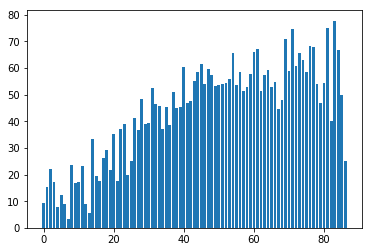

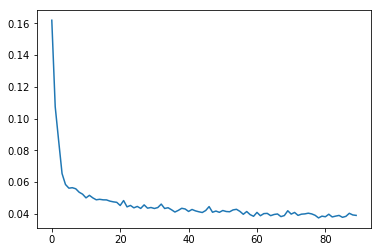

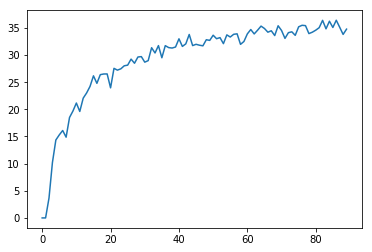

Train Epoch: 179 [0/65192 (0%)]	Loss: 0.034928
Train Epoch: 179 [6400/65192 (10%)]	Loss: 0.045501
Train Epoch: 179 [12800/65192 (20%)]	Loss: 0.043752
Train Epoch: 179 [19200/65192 (29%)]	Loss: 0.033554
Train Epoch: 179 [25600/65192 (39%)]	Loss: 0.038692
Train Epoch: 179 [32000/65192 (49%)]	Loss: 0.037724
Train Epoch: 179 [38400/65192 (59%)]	Loss: 0.026124
Train Epoch: 179 [44800/65192 (69%)]	Loss: 0.035717
Train Epoch: 179 [51200/65192 (79%)]	Loss: 0.033002
Train Epoch: 179 [57600/65192 (88%)]	Loss: 0.040744
Train Epoch: 179 [64000/65192 (98%)]	Loss: 0.038315
Train Epoch: 180 [0/65192 (0%)]	Loss: 0.046871
Train Epoch: 180 [6400/65192 (10%)]	Loss: 0.038109
Train Epoch: 180 [12800/65192 (20%)]	Loss: 0.053435
Train Epoch: 180 [19200/65192 (29%)]	Loss: 0.036858
Train Epoch: 180 [25600/65192 (39%)]	Loss: 0.028902
Train Epoch: 180 [32000/65192 (49%)]	Loss: 0.030476
Train Epoch: 180 [38400/65192 (59%)]	Loss: 0.042449
Train Epoch: 180 [44800/65192 (69%)]	Loss: 0.032262
Train Epoch: 180 [51200/

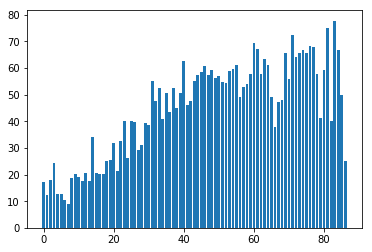

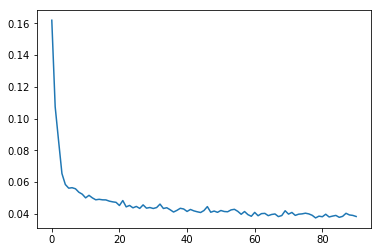

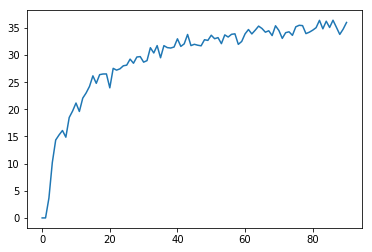

Train Epoch: 181 [0/65192 (0%)]	Loss: 0.047513
Train Epoch: 181 [6400/65192 (10%)]	Loss: 0.042127
Train Epoch: 181 [12800/65192 (20%)]	Loss: 0.036204
Train Epoch: 181 [19200/65192 (29%)]	Loss: 0.033933
Train Epoch: 181 [25600/65192 (39%)]	Loss: 0.045775
Train Epoch: 181 [32000/65192 (49%)]	Loss: 0.035748
Train Epoch: 181 [38400/65192 (59%)]	Loss: 0.032248
Train Epoch: 181 [44800/65192 (69%)]	Loss: 0.037890
Train Epoch: 181 [51200/65192 (79%)]	Loss: 0.039423
Train Epoch: 181 [57600/65192 (88%)]	Loss: 0.045824
Train Epoch: 181 [64000/65192 (98%)]	Loss: 0.034817
Train Epoch: 182 [0/65192 (0%)]	Loss: 0.040103
Train Epoch: 182 [6400/65192 (10%)]	Loss: 0.039217
Train Epoch: 182 [12800/65192 (20%)]	Loss: 0.042460
Train Epoch: 182 [19200/65192 (29%)]	Loss: 0.036387
Train Epoch: 182 [25600/65192 (39%)]	Loss: 0.040598
Train Epoch: 182 [32000/65192 (49%)]	Loss: 0.033051
Train Epoch: 182 [38400/65192 (59%)]	Loss: 0.031910
Train Epoch: 182 [44800/65192 (69%)]	Loss: 0.047769
Train Epoch: 182 [51200/

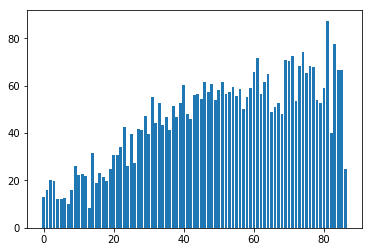

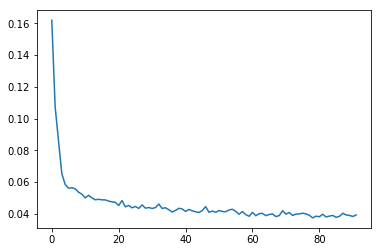

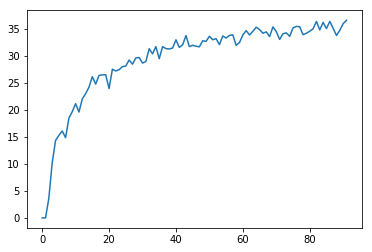

Train Epoch: 183 [0/65192 (0%)]	Loss: 0.039647
Train Epoch: 183 [6400/65192 (10%)]	Loss: 0.040626
Train Epoch: 183 [12800/65192 (20%)]	Loss: 0.044328
Train Epoch: 183 [19200/65192 (29%)]	Loss: 0.043293
Train Epoch: 183 [25600/65192 (39%)]	Loss: 0.037596
Train Epoch: 183 [32000/65192 (49%)]	Loss: 0.045402
Train Epoch: 183 [38400/65192 (59%)]	Loss: 0.044869
Train Epoch: 183 [44800/65192 (69%)]	Loss: 0.035151
Train Epoch: 183 [51200/65192 (79%)]	Loss: 0.033061
Train Epoch: 183 [57600/65192 (88%)]	Loss: 0.045028
Train Epoch: 183 [64000/65192 (98%)]	Loss: 0.035679
Train Epoch: 184 [0/65192 (0%)]	Loss: 0.034225
Train Epoch: 184 [6400/65192 (10%)]	Loss: 0.030013
Train Epoch: 184 [12800/65192 (20%)]	Loss: 0.039352
Train Epoch: 184 [19200/65192 (29%)]	Loss: 0.035639
Train Epoch: 184 [25600/65192 (39%)]	Loss: 0.034862
Train Epoch: 184 [32000/65192 (49%)]	Loss: 0.031830
Train Epoch: 184 [38400/65192 (59%)]	Loss: 0.042625
Train Epoch: 184 [44800/65192 (69%)]	Loss: 0.041185
Train Epoch: 184 [51200/

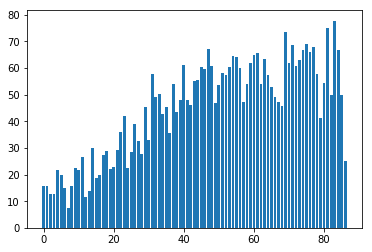

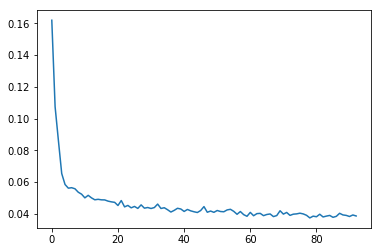

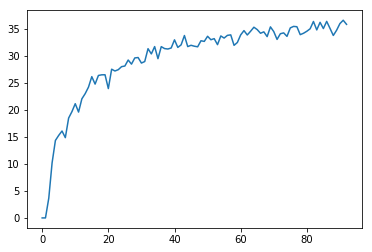

Train Epoch: 185 [0/65192 (0%)]	Loss: 0.034909
Train Epoch: 185 [6400/65192 (10%)]	Loss: 0.039591
Train Epoch: 185 [12800/65192 (20%)]	Loss: 0.043109
Train Epoch: 185 [19200/65192 (29%)]	Loss: 0.043646
Train Epoch: 185 [25600/65192 (39%)]	Loss: 0.036245
Train Epoch: 185 [32000/65192 (49%)]	Loss: 0.035928
Train Epoch: 185 [38400/65192 (59%)]	Loss: 0.033489
Train Epoch: 185 [44800/65192 (69%)]	Loss: 0.037814
Train Epoch: 185 [51200/65192 (79%)]	Loss: 0.027626
Train Epoch: 185 [57600/65192 (88%)]	Loss: 0.035418
Train Epoch: 185 [64000/65192 (98%)]	Loss: 0.034015
Train Epoch: 186 [0/65192 (0%)]	Loss: 0.037709
Train Epoch: 186 [6400/65192 (10%)]	Loss: 0.034837
Train Epoch: 186 [12800/65192 (20%)]	Loss: 0.044583
Train Epoch: 186 [19200/65192 (29%)]	Loss: 0.044524
Train Epoch: 186 [25600/65192 (39%)]	Loss: 0.039554
Train Epoch: 186 [32000/65192 (49%)]	Loss: 0.035411
Train Epoch: 186 [38400/65192 (59%)]	Loss: 0.042170
Train Epoch: 186 [44800/65192 (69%)]	Loss: 0.036406
Train Epoch: 186 [51200/

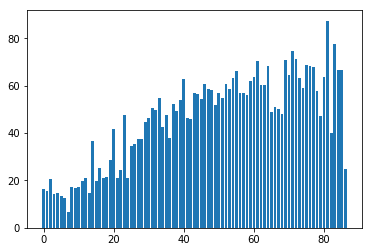

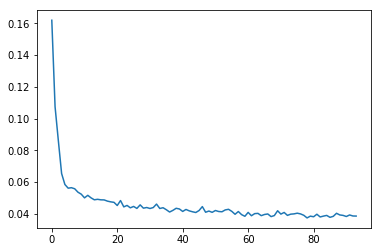

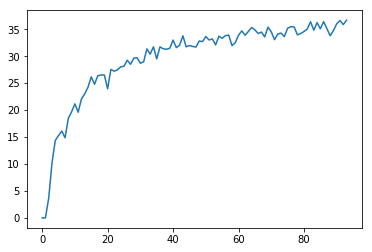

Train Epoch: 187 [0/65192 (0%)]	Loss: 0.041020
Train Epoch: 187 [6400/65192 (10%)]	Loss: 0.037158
Train Epoch: 187 [12800/65192 (20%)]	Loss: 0.036603
Train Epoch: 187 [19200/65192 (29%)]	Loss: 0.036245
Train Epoch: 187 [25600/65192 (39%)]	Loss: 0.040435
Train Epoch: 187 [32000/65192 (49%)]	Loss: 0.036363
Train Epoch: 187 [38400/65192 (59%)]	Loss: 0.039097
Train Epoch: 187 [44800/65192 (69%)]	Loss: 0.033633
Train Epoch: 187 [51200/65192 (79%)]	Loss: 0.037665
Train Epoch: 187 [57600/65192 (88%)]	Loss: 0.034642
Train Epoch: 187 [64000/65192 (98%)]	Loss: 0.035491
Train Epoch: 188 [0/65192 (0%)]	Loss: 0.032854
Train Epoch: 188 [6400/65192 (10%)]	Loss: 0.042340
Train Epoch: 188 [12800/65192 (20%)]	Loss: 0.037509
Train Epoch: 188 [19200/65192 (29%)]	Loss: 0.043802
Train Epoch: 188 [25600/65192 (39%)]	Loss: 0.045026
Train Epoch: 188 [32000/65192 (49%)]	Loss: 0.033921
Train Epoch: 188 [38400/65192 (59%)]	Loss: 0.029884
Train Epoch: 188 [44800/65192 (69%)]	Loss: 0.039367
Train Epoch: 188 [51200/

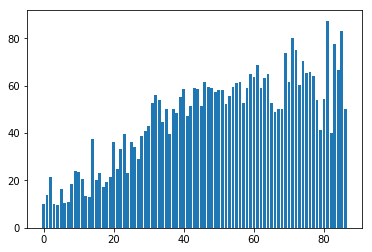

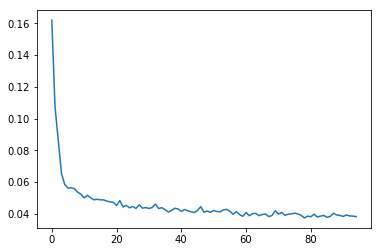

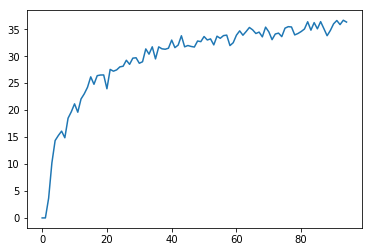

Train Epoch: 189 [0/65192 (0%)]	Loss: 0.042475
Train Epoch: 189 [6400/65192 (10%)]	Loss: 0.043054
Train Epoch: 189 [12800/65192 (20%)]	Loss: 0.042900
Train Epoch: 189 [19200/65192 (29%)]	Loss: 0.035031
Train Epoch: 189 [25600/65192 (39%)]	Loss: 0.028163
Train Epoch: 189 [32000/65192 (49%)]	Loss: 0.032072
Train Epoch: 189 [38400/65192 (59%)]	Loss: 0.038931
Train Epoch: 189 [44800/65192 (69%)]	Loss: 0.036827
Train Epoch: 189 [51200/65192 (79%)]	Loss: 0.038305
Train Epoch: 189 [57600/65192 (88%)]	Loss: 0.035333
Train Epoch: 189 [64000/65192 (98%)]	Loss: 0.038441
Train Epoch: 190 [0/65192 (0%)]	Loss: 0.034221
Train Epoch: 190 [6400/65192 (10%)]	Loss: 0.046357
Train Epoch: 190 [12800/65192 (20%)]	Loss: 0.033060
Train Epoch: 190 [19200/65192 (29%)]	Loss: 0.036541
Train Epoch: 190 [25600/65192 (39%)]	Loss: 0.033018
Train Epoch: 190 [32000/65192 (49%)]	Loss: 0.032952
Train Epoch: 190 [38400/65192 (59%)]	Loss: 0.038069
Train Epoch: 190 [44800/65192 (69%)]	Loss: 0.035917
Train Epoch: 190 [51200/

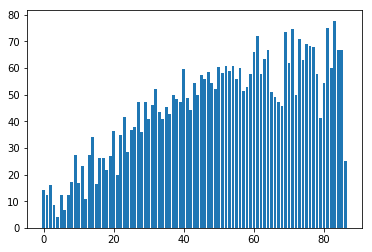

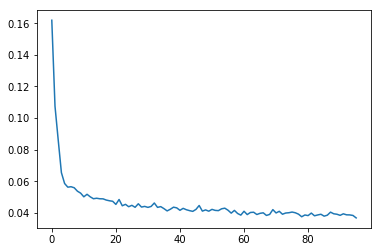

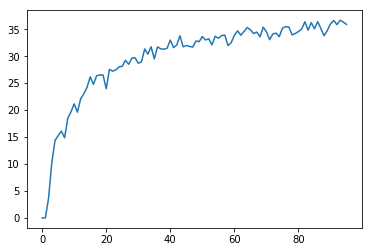

Train Epoch: 191 [0/65192 (0%)]	Loss: 0.038392
Train Epoch: 191 [6400/65192 (10%)]	Loss: 0.034821
Train Epoch: 191 [12800/65192 (20%)]	Loss: 0.031558
Train Epoch: 191 [19200/65192 (29%)]	Loss: 0.045210
Train Epoch: 191 [25600/65192 (39%)]	Loss: 0.033229
Train Epoch: 191 [32000/65192 (49%)]	Loss: 0.027974
Train Epoch: 191 [38400/65192 (59%)]	Loss: 0.031610
Train Epoch: 191 [44800/65192 (69%)]	Loss: 0.035585
Train Epoch: 191 [51200/65192 (79%)]	Loss: 0.038214
Train Epoch: 191 [57600/65192 (88%)]	Loss: 0.035045
Train Epoch: 191 [64000/65192 (98%)]	Loss: 0.034750
Train Epoch: 192 [0/65192 (0%)]	Loss: 0.042470
Train Epoch: 192 [6400/65192 (10%)]	Loss: 0.044490
Train Epoch: 192 [12800/65192 (20%)]	Loss: 0.042703
Train Epoch: 192 [19200/65192 (29%)]	Loss: 0.040041
Train Epoch: 192 [25600/65192 (39%)]	Loss: 0.040554
Train Epoch: 192 [32000/65192 (49%)]	Loss: 0.030972
Train Epoch: 192 [38400/65192 (59%)]	Loss: 0.034551
Train Epoch: 192 [44800/65192 (69%)]	Loss: 0.045180
Train Epoch: 192 [51200/

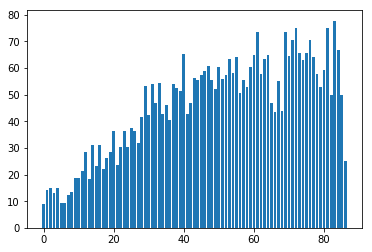

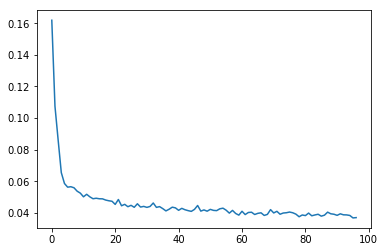

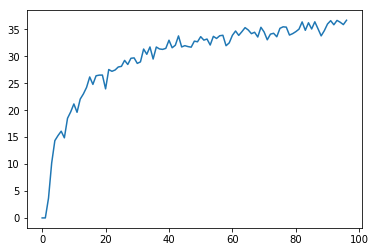

Train Epoch: 193 [0/65192 (0%)]	Loss: 0.044826
Train Epoch: 193 [6400/65192 (10%)]	Loss: 0.031679
Train Epoch: 193 [12800/65192 (20%)]	Loss: 0.030056
Train Epoch: 193 [19200/65192 (29%)]	Loss: 0.040127
Train Epoch: 193 [25600/65192 (39%)]	Loss: 0.044178
Train Epoch: 193 [32000/65192 (49%)]	Loss: 0.041949
Train Epoch: 193 [38400/65192 (59%)]	Loss: 0.042037
Train Epoch: 193 [44800/65192 (69%)]	Loss: 0.037994
Train Epoch: 193 [51200/65192 (79%)]	Loss: 0.031783
Train Epoch: 193 [57600/65192 (88%)]	Loss: 0.040466
Train Epoch: 193 [64000/65192 (98%)]	Loss: 0.032170
Train Epoch: 194 [0/65192 (0%)]	Loss: 0.050428
Train Epoch: 194 [6400/65192 (10%)]	Loss: 0.035551
Train Epoch: 194 [12800/65192 (20%)]	Loss: 0.048928
Train Epoch: 194 [19200/65192 (29%)]	Loss: 0.039579
Train Epoch: 194 [25600/65192 (39%)]	Loss: 0.037528
Train Epoch: 194 [32000/65192 (49%)]	Loss: 0.043950
Train Epoch: 194 [38400/65192 (59%)]	Loss: 0.045576
Train Epoch: 194 [44800/65192 (69%)]	Loss: 0.032089
Train Epoch: 194 [51200/

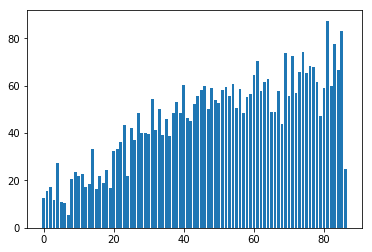

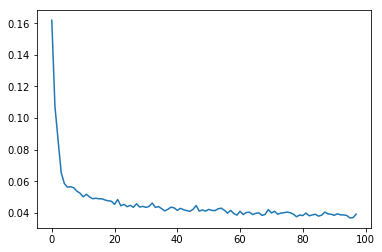

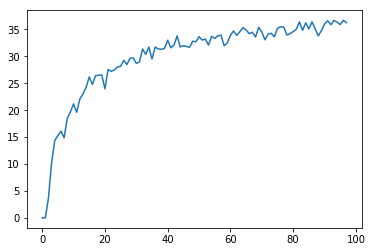

Train Epoch: 195 [0/65192 (0%)]	Loss: 0.041266
Train Epoch: 195 [6400/65192 (10%)]	Loss: 0.038679
Train Epoch: 195 [12800/65192 (20%)]	Loss: 0.052979
Train Epoch: 195 [19200/65192 (29%)]	Loss: 0.042640
Train Epoch: 195 [25600/65192 (39%)]	Loss: 0.042751
Train Epoch: 195 [32000/65192 (49%)]	Loss: 0.037983
Train Epoch: 195 [38400/65192 (59%)]	Loss: 0.033474
Train Epoch: 195 [44800/65192 (69%)]	Loss: 0.039283
Train Epoch: 195 [51200/65192 (79%)]	Loss: 0.045169
Train Epoch: 195 [57600/65192 (88%)]	Loss: 0.036770
Train Epoch: 195 [64000/65192 (98%)]	Loss: 0.044272
Train Epoch: 196 [0/65192 (0%)]	Loss: 0.034557
Train Epoch: 196 [6400/65192 (10%)]	Loss: 0.035086
Train Epoch: 196 [12800/65192 (20%)]	Loss: 0.038557
Train Epoch: 196 [19200/65192 (29%)]	Loss: 0.042696
Train Epoch: 196 [25600/65192 (39%)]	Loss: 0.037146
Train Epoch: 196 [32000/65192 (49%)]	Loss: 0.032459
Train Epoch: 196 [38400/65192 (59%)]	Loss: 0.037884
Train Epoch: 196 [44800/65192 (69%)]	Loss: 0.035941
Train Epoch: 196 [51200/

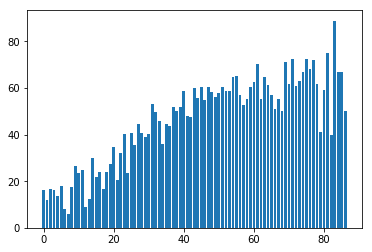

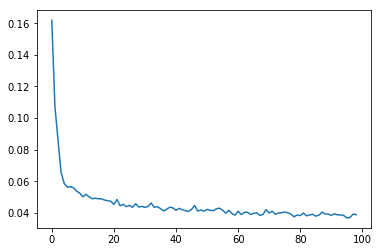

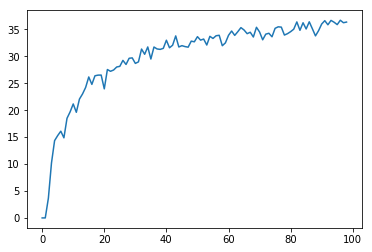

Train Epoch: 197 [0/65192 (0%)]	Loss: 0.031812
Train Epoch: 197 [6400/65192 (10%)]	Loss: 0.034565
Train Epoch: 197 [12800/65192 (20%)]	Loss: 0.038284
Train Epoch: 197 [19200/65192 (29%)]	Loss: 0.033106
Train Epoch: 197 [25600/65192 (39%)]	Loss: 0.034996
Train Epoch: 197 [32000/65192 (49%)]	Loss: 0.045282
Train Epoch: 197 [38400/65192 (59%)]	Loss: 0.047714
Train Epoch: 197 [44800/65192 (69%)]	Loss: 0.030161
Train Epoch: 197 [51200/65192 (79%)]	Loss: 0.045197
Train Epoch: 197 [57600/65192 (88%)]	Loss: 0.041818
Train Epoch: 197 [64000/65192 (98%)]	Loss: 0.037313
Train Epoch: 198 [0/65192 (0%)]	Loss: 0.033638
Train Epoch: 198 [6400/65192 (10%)]	Loss: 0.042413
Train Epoch: 198 [12800/65192 (20%)]	Loss: 0.035256
Train Epoch: 198 [19200/65192 (29%)]	Loss: 0.040078
Train Epoch: 198 [25600/65192 (39%)]	Loss: 0.039268
Train Epoch: 198 [32000/65192 (49%)]	Loss: 0.041520
Train Epoch: 198 [38400/65192 (59%)]	Loss: 0.029243
Train Epoch: 198 [44800/65192 (69%)]	Loss: 0.044476
Train Epoch: 198 [51200/

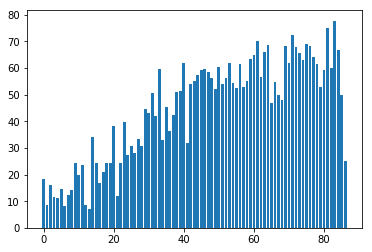

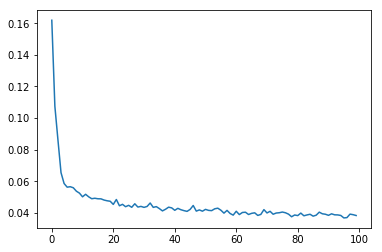

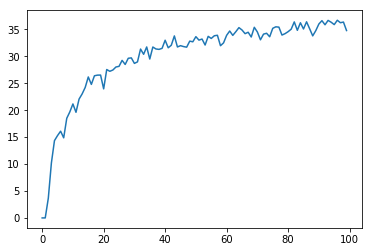

Train Epoch: 199 [0/65192 (0%)]	Loss: 0.038328
Train Epoch: 199 [6400/65192 (10%)]	Loss: 0.040385
Train Epoch: 199 [12800/65192 (20%)]	Loss: 0.034173
Train Epoch: 199 [19200/65192 (29%)]	Loss: 0.032723
Train Epoch: 199 [25600/65192 (39%)]	Loss: 0.038474
Train Epoch: 199 [32000/65192 (49%)]	Loss: 0.035700
Train Epoch: 199 [38400/65192 (59%)]	Loss: 0.039939
Train Epoch: 199 [44800/65192 (69%)]	Loss: 0.040609
Train Epoch: 199 [51200/65192 (79%)]	Loss: 0.046528
Train Epoch: 199 [57600/65192 (88%)]	Loss: 0.043469
Train Epoch: 199 [64000/65192 (98%)]	Loss: 0.032515
Train Epoch: 200 [0/65192 (0%)]	Loss: 0.037418
Train Epoch: 200 [6400/65192 (10%)]	Loss: 0.035408
Train Epoch: 200 [12800/65192 (20%)]	Loss: 0.034964
Train Epoch: 200 [19200/65192 (29%)]	Loss: 0.037290
Train Epoch: 200 [25600/65192 (39%)]	Loss: 0.033471
Train Epoch: 200 [32000/65192 (49%)]	Loss: 0.043377
Train Epoch: 200 [38400/65192 (59%)]	Loss: 0.039760
Train Epoch: 200 [44800/65192 (69%)]	Loss: 0.042886
Train Epoch: 200 [51200/

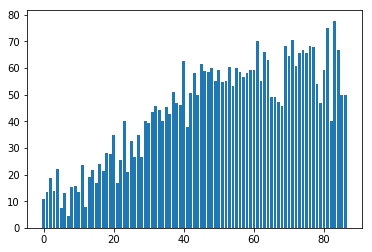

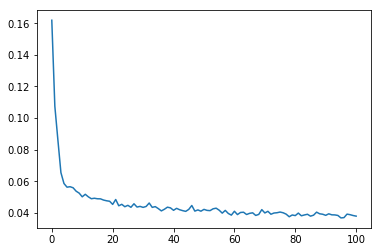

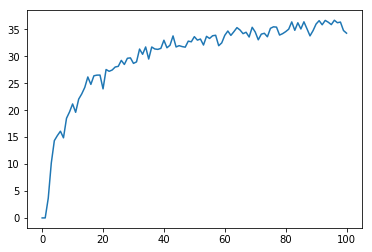

Train Epoch: 201 [0/65192 (0%)]	Loss: 0.045389
Train Epoch: 201 [6400/65192 (10%)]	Loss: 0.039311
Train Epoch: 201 [12800/65192 (20%)]	Loss: 0.041057
Train Epoch: 201 [19200/65192 (29%)]	Loss: 0.029952
Train Epoch: 201 [25600/65192 (39%)]	Loss: 0.031064
Train Epoch: 201 [32000/65192 (49%)]	Loss: 0.037813
Train Epoch: 201 [38400/65192 (59%)]	Loss: 0.033339
Train Epoch: 201 [44800/65192 (69%)]	Loss: 0.034640
Train Epoch: 201 [51200/65192 (79%)]	Loss: 0.045646
Train Epoch: 201 [57600/65192 (88%)]	Loss: 0.031811
Train Epoch: 201 [64000/65192 (98%)]	Loss: 0.035643
Train Epoch: 202 [0/65192 (0%)]	Loss: 0.039904
Train Epoch: 202 [6400/65192 (10%)]	Loss: 0.027256
Train Epoch: 202 [12800/65192 (20%)]	Loss: 0.033173
Train Epoch: 202 [19200/65192 (29%)]	Loss: 0.045653
Train Epoch: 202 [25600/65192 (39%)]	Loss: 0.042311
Train Epoch: 202 [32000/65192 (49%)]	Loss: 0.043902
Train Epoch: 202 [38400/65192 (59%)]	Loss: 0.037573
Train Epoch: 202 [44800/65192 (69%)]	Loss: 0.035888
Train Epoch: 202 [51200/

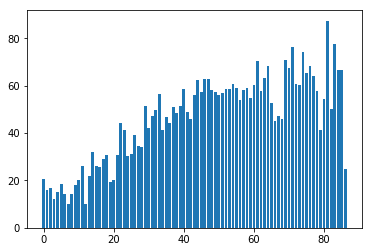

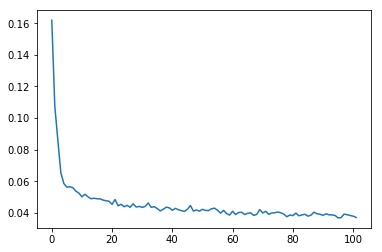

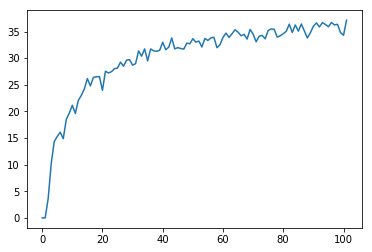

Train Epoch: 203 [0/65192 (0%)]	Loss: 0.033358
Train Epoch: 203 [6400/65192 (10%)]	Loss: 0.041320
Train Epoch: 203 [12800/65192 (20%)]	Loss: 0.034275
Train Epoch: 203 [19200/65192 (29%)]	Loss: 0.031476
Train Epoch: 203 [25600/65192 (39%)]	Loss: 0.037706
Train Epoch: 203 [32000/65192 (49%)]	Loss: 0.029908
Train Epoch: 203 [38400/65192 (59%)]	Loss: 0.035516
Train Epoch: 203 [44800/65192 (69%)]	Loss: 0.041279
Train Epoch: 203 [51200/65192 (79%)]	Loss: 0.031870
Train Epoch: 203 [57600/65192 (88%)]	Loss: 0.043510
Train Epoch: 203 [64000/65192 (98%)]	Loss: 0.038256
Train Epoch: 204 [0/65192 (0%)]	Loss: 0.037346
Train Epoch: 204 [6400/65192 (10%)]	Loss: 0.032734
Train Epoch: 204 [12800/65192 (20%)]	Loss: 0.036783
Train Epoch: 204 [19200/65192 (29%)]	Loss: 0.036876
Train Epoch: 204 [25600/65192 (39%)]	Loss: 0.046487
Train Epoch: 204 [32000/65192 (49%)]	Loss: 0.041969
Train Epoch: 204 [38400/65192 (59%)]	Loss: 0.045961
Train Epoch: 204 [44800/65192 (69%)]	Loss: 0.034815
Train Epoch: 204 [51200/

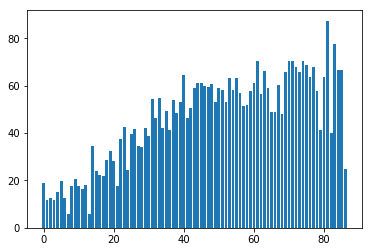

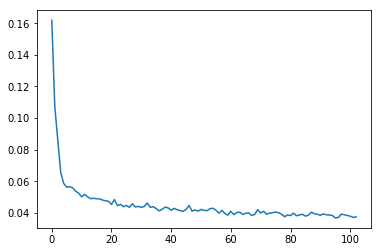

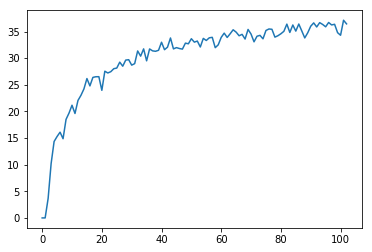

Train Epoch: 205 [0/65192 (0%)]	Loss: 0.028881
Train Epoch: 205 [6400/65192 (10%)]	Loss: 0.041786
Train Epoch: 205 [12800/65192 (20%)]	Loss: 0.029549
Train Epoch: 205 [19200/65192 (29%)]	Loss: 0.038518
Train Epoch: 205 [25600/65192 (39%)]	Loss: 0.029537
Train Epoch: 205 [32000/65192 (49%)]	Loss: 0.038535
Train Epoch: 205 [38400/65192 (59%)]	Loss: 0.038738
Train Epoch: 205 [44800/65192 (69%)]	Loss: 0.037565
Train Epoch: 205 [51200/65192 (79%)]	Loss: 0.038431
Train Epoch: 205 [57600/65192 (88%)]	Loss: 0.035897
Train Epoch: 205 [64000/65192 (98%)]	Loss: 0.040138
Train Epoch: 206 [0/65192 (0%)]	Loss: 0.030331
Train Epoch: 206 [6400/65192 (10%)]	Loss: 0.039372
Train Epoch: 206 [12800/65192 (20%)]	Loss: 0.039664
Train Epoch: 206 [19200/65192 (29%)]	Loss: 0.040877
Train Epoch: 206 [25600/65192 (39%)]	Loss: 0.044924
Train Epoch: 206 [32000/65192 (49%)]	Loss: 0.036332
Train Epoch: 206 [38400/65192 (59%)]	Loss: 0.039607
Train Epoch: 206 [44800/65192 (69%)]	Loss: 0.041726
Train Epoch: 206 [51200/

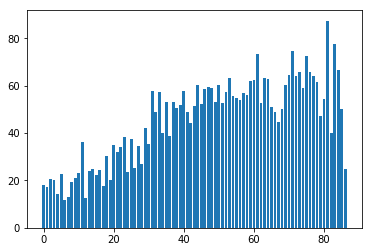

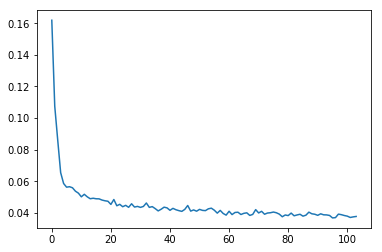

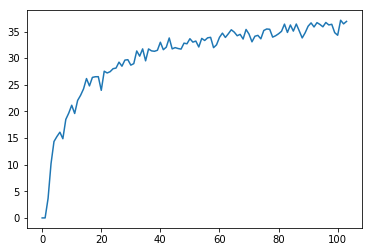

Train Epoch: 207 [0/65192 (0%)]	Loss: 0.037509
Train Epoch: 207 [6400/65192 (10%)]	Loss: 0.038251
Train Epoch: 207 [12800/65192 (20%)]	Loss: 0.041292
Train Epoch: 207 [19200/65192 (29%)]	Loss: 0.044801
Train Epoch: 207 [25600/65192 (39%)]	Loss: 0.026872
Train Epoch: 207 [32000/65192 (49%)]	Loss: 0.038799
Train Epoch: 207 [38400/65192 (59%)]	Loss: 0.034491
Train Epoch: 207 [44800/65192 (69%)]	Loss: 0.040367
Train Epoch: 207 [51200/65192 (79%)]	Loss: 0.039614
Train Epoch: 207 [57600/65192 (88%)]	Loss: 0.039187
Train Epoch: 207 [64000/65192 (98%)]	Loss: 0.024204
Train Epoch: 208 [0/65192 (0%)]	Loss: 0.039085
Train Epoch: 208 [6400/65192 (10%)]	Loss: 0.044937
Train Epoch: 208 [12800/65192 (20%)]	Loss: 0.030873
Train Epoch: 208 [19200/65192 (29%)]	Loss: 0.032034
Train Epoch: 208 [25600/65192 (39%)]	Loss: 0.034219
Train Epoch: 208 [32000/65192 (49%)]	Loss: 0.033416
Train Epoch: 208 [38400/65192 (59%)]	Loss: 0.034197
Train Epoch: 208 [44800/65192 (69%)]	Loss: 0.034319
Train Epoch: 208 [51200/

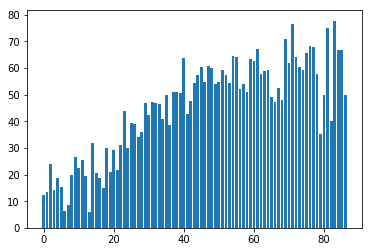

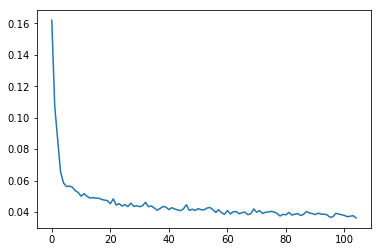

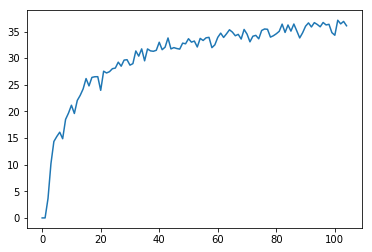

Train Epoch: 209 [0/65192 (0%)]	Loss: 0.040028
Train Epoch: 209 [6400/65192 (10%)]	Loss: 0.040794
Train Epoch: 209 [12800/65192 (20%)]	Loss: 0.035428
Train Epoch: 209 [19200/65192 (29%)]	Loss: 0.042026
Train Epoch: 209 [25600/65192 (39%)]	Loss: 0.042283
Train Epoch: 209 [32000/65192 (49%)]	Loss: 0.040812
Train Epoch: 209 [38400/65192 (59%)]	Loss: 0.041235
Train Epoch: 209 [44800/65192 (69%)]	Loss: 0.032809
Train Epoch: 209 [51200/65192 (79%)]	Loss: 0.036005
Train Epoch: 209 [57600/65192 (88%)]	Loss: 0.031641
Train Epoch: 209 [64000/65192 (98%)]	Loss: 0.033001
Train Epoch: 210 [0/65192 (0%)]	Loss: 0.033013
Train Epoch: 210 [6400/65192 (10%)]	Loss: 0.049216
Train Epoch: 210 [12800/65192 (20%)]	Loss: 0.036476
Train Epoch: 210 [19200/65192 (29%)]	Loss: 0.039894
Train Epoch: 210 [25600/65192 (39%)]	Loss: 0.036156
Train Epoch: 210 [32000/65192 (49%)]	Loss: 0.034937
Train Epoch: 210 [38400/65192 (59%)]	Loss: 0.037140
Train Epoch: 210 [44800/65192 (69%)]	Loss: 0.030790
Train Epoch: 210 [51200/

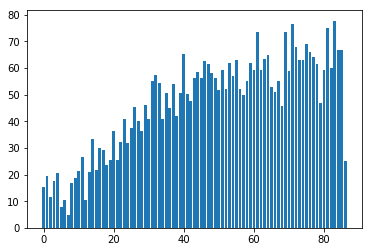

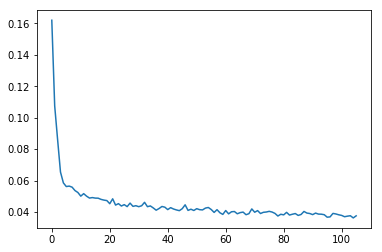

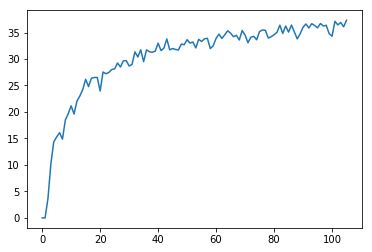

Train Epoch: 211 [0/65192 (0%)]	Loss: 0.043764
Train Epoch: 211 [6400/65192 (10%)]	Loss: 0.043431
Train Epoch: 211 [12800/65192 (20%)]	Loss: 0.046667
Train Epoch: 211 [19200/65192 (29%)]	Loss: 0.033289
Train Epoch: 211 [25600/65192 (39%)]	Loss: 0.035458
Train Epoch: 211 [32000/65192 (49%)]	Loss: 0.033940
Train Epoch: 211 [38400/65192 (59%)]	Loss: 0.038413
Train Epoch: 211 [44800/65192 (69%)]	Loss: 0.037237
Train Epoch: 211 [51200/65192 (79%)]	Loss: 0.037961
Train Epoch: 211 [57600/65192 (88%)]	Loss: 0.035878
Train Epoch: 211 [64000/65192 (98%)]	Loss: 0.034631
Train Epoch: 212 [0/65192 (0%)]	Loss: 0.028931
Train Epoch: 212 [6400/65192 (10%)]	Loss: 0.037865
Train Epoch: 212 [12800/65192 (20%)]	Loss: 0.036633
Train Epoch: 212 [19200/65192 (29%)]	Loss: 0.037870
Train Epoch: 212 [25600/65192 (39%)]	Loss: 0.042793
Train Epoch: 212 [32000/65192 (49%)]	Loss: 0.048087
Train Epoch: 212 [38400/65192 (59%)]	Loss: 0.030197
Train Epoch: 212 [44800/65192 (69%)]	Loss: 0.036194
Train Epoch: 212 [51200/

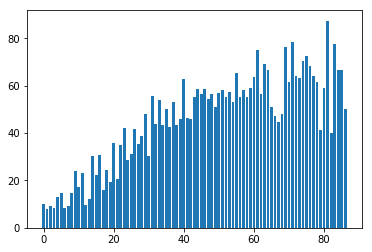

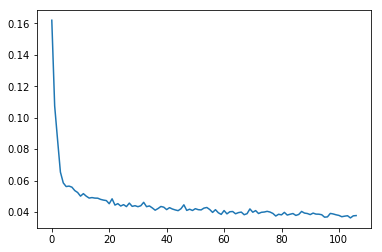

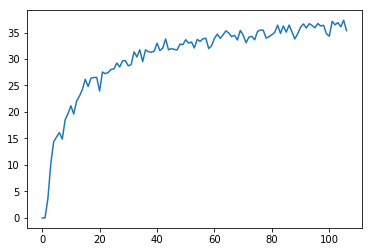

Train Epoch: 213 [0/65192 (0%)]	Loss: 0.029485
Train Epoch: 213 [6400/65192 (10%)]	Loss: 0.041086
Train Epoch: 213 [12800/65192 (20%)]	Loss: 0.033257
Train Epoch: 213 [19200/65192 (29%)]	Loss: 0.037053
Train Epoch: 213 [25600/65192 (39%)]	Loss: 0.039697
Train Epoch: 213 [32000/65192 (49%)]	Loss: 0.038311
Train Epoch: 213 [38400/65192 (59%)]	Loss: 0.034231
Train Epoch: 213 [44800/65192 (69%)]	Loss: 0.040025
Train Epoch: 213 [51200/65192 (79%)]	Loss: 0.039379
Train Epoch: 213 [57600/65192 (88%)]	Loss: 0.035600
Train Epoch: 213 [64000/65192 (98%)]	Loss: 0.035350
Train Epoch: 214 [0/65192 (0%)]	Loss: 0.045696
Train Epoch: 214 [6400/65192 (10%)]	Loss: 0.032895
Train Epoch: 214 [12800/65192 (20%)]	Loss: 0.035949
Train Epoch: 214 [19200/65192 (29%)]	Loss: 0.029930
Train Epoch: 214 [25600/65192 (39%)]	Loss: 0.040008
Train Epoch: 214 [32000/65192 (49%)]	Loss: 0.036973
Train Epoch: 214 [38400/65192 (59%)]	Loss: 0.030897
Train Epoch: 214 [44800/65192 (69%)]	Loss: 0.042646
Train Epoch: 214 [51200/

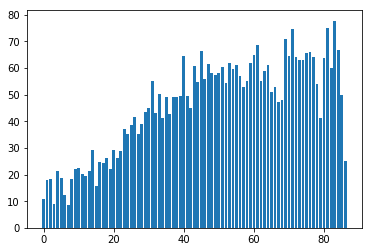

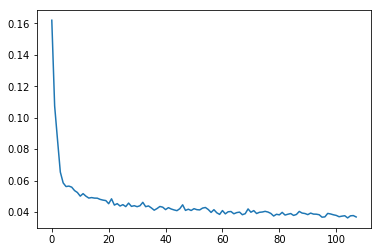

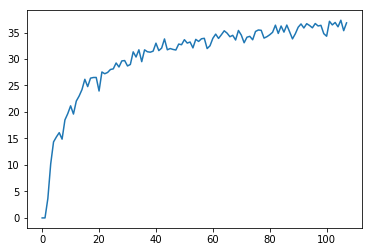

Train Epoch: 215 [0/65192 (0%)]	Loss: 0.040776
Train Epoch: 215 [6400/65192 (10%)]	Loss: 0.036497
Train Epoch: 215 [12800/65192 (20%)]	Loss: 0.047080
Train Epoch: 215 [19200/65192 (29%)]	Loss: 0.037406
Train Epoch: 215 [25600/65192 (39%)]	Loss: 0.037655
Train Epoch: 215 [32000/65192 (49%)]	Loss: 0.045683
Train Epoch: 215 [38400/65192 (59%)]	Loss: 0.037756
Train Epoch: 215 [44800/65192 (69%)]	Loss: 0.040055
Train Epoch: 215 [51200/65192 (79%)]	Loss: 0.049094
Train Epoch: 215 [57600/65192 (88%)]	Loss: 0.032230
Train Epoch: 215 [64000/65192 (98%)]	Loss: 0.028916
Train Epoch: 216 [0/65192 (0%)]	Loss: 0.037275
Train Epoch: 216 [6400/65192 (10%)]	Loss: 0.031964
Train Epoch: 216 [12800/65192 (20%)]	Loss: 0.039449
Train Epoch: 216 [19200/65192 (29%)]	Loss: 0.035587
Train Epoch: 216 [25600/65192 (39%)]	Loss: 0.033661
Train Epoch: 216 [32000/65192 (49%)]	Loss: 0.043307
Train Epoch: 216 [38400/65192 (59%)]	Loss: 0.041186
Train Epoch: 216 [44800/65192 (69%)]	Loss: 0.038681
Train Epoch: 216 [51200/

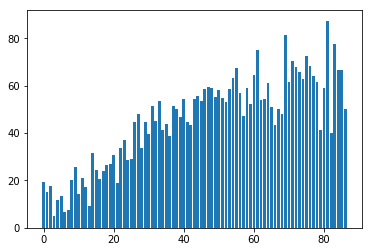

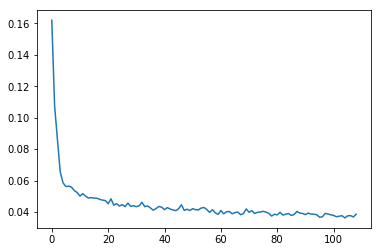

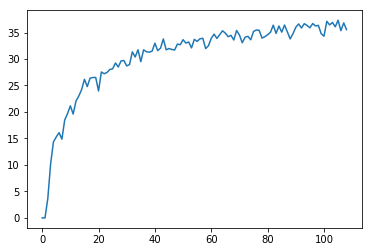

Train Epoch: 217 [0/65192 (0%)]	Loss: 0.032278
Train Epoch: 217 [6400/65192 (10%)]	Loss: 0.035038
Train Epoch: 217 [12800/65192 (20%)]	Loss: 0.039514
Train Epoch: 217 [19200/65192 (29%)]	Loss: 0.036812
Train Epoch: 217 [25600/65192 (39%)]	Loss: 0.038901
Train Epoch: 217 [32000/65192 (49%)]	Loss: 0.048120
Train Epoch: 217 [38400/65192 (59%)]	Loss: 0.040601
Train Epoch: 217 [44800/65192 (69%)]	Loss: 0.044313
Train Epoch: 217 [51200/65192 (79%)]	Loss: 0.034622
Train Epoch: 217 [57600/65192 (88%)]	Loss: 0.032568
Train Epoch: 217 [64000/65192 (98%)]	Loss: 0.042339
Train Epoch: 218 [0/65192 (0%)]	Loss: 0.040527
Train Epoch: 218 [6400/65192 (10%)]	Loss: 0.039974
Train Epoch: 218 [12800/65192 (20%)]	Loss: 0.040070
Train Epoch: 218 [19200/65192 (29%)]	Loss: 0.037979
Train Epoch: 218 [25600/65192 (39%)]	Loss: 0.037690
Train Epoch: 218 [32000/65192 (49%)]	Loss: 0.039264
Train Epoch: 218 [38400/65192 (59%)]	Loss: 0.035645
Train Epoch: 218 [44800/65192 (69%)]	Loss: 0.036575
Train Epoch: 218 [51200/

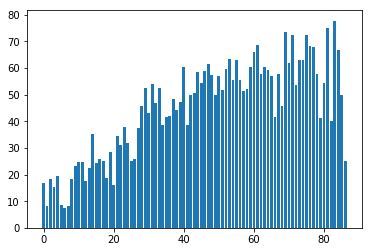

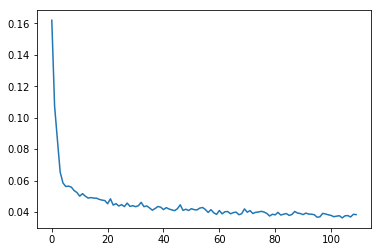

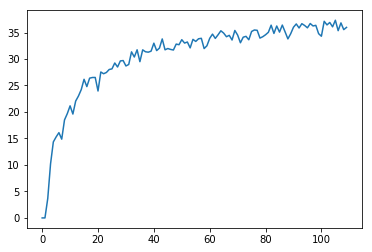

Train Epoch: 219 [0/65192 (0%)]	Loss: 0.032985
Train Epoch: 219 [6400/65192 (10%)]	Loss: 0.039550
Train Epoch: 219 [12800/65192 (20%)]	Loss: 0.047175
Train Epoch: 219 [19200/65192 (29%)]	Loss: 0.044531
Train Epoch: 219 [25600/65192 (39%)]	Loss: 0.031366
Train Epoch: 219 [32000/65192 (49%)]	Loss: 0.028565
Train Epoch: 219 [38400/65192 (59%)]	Loss: 0.045308
Train Epoch: 219 [44800/65192 (69%)]	Loss: 0.039498
Train Epoch: 219 [51200/65192 (79%)]	Loss: 0.032967
Train Epoch: 219 [57600/65192 (88%)]	Loss: 0.034108
Train Epoch: 219 [64000/65192 (98%)]	Loss: 0.037041
Train Epoch: 220 [0/65192 (0%)]	Loss: 0.037846
Train Epoch: 220 [6400/65192 (10%)]	Loss: 0.046677
Train Epoch: 220 [12800/65192 (20%)]	Loss: 0.040108
Train Epoch: 220 [19200/65192 (29%)]	Loss: 0.040782
Train Epoch: 220 [25600/65192 (39%)]	Loss: 0.038553
Train Epoch: 220 [32000/65192 (49%)]	Loss: 0.038298
Train Epoch: 220 [38400/65192 (59%)]	Loss: 0.029124
Train Epoch: 220 [44800/65192 (69%)]	Loss: 0.035997
Train Epoch: 220 [51200/

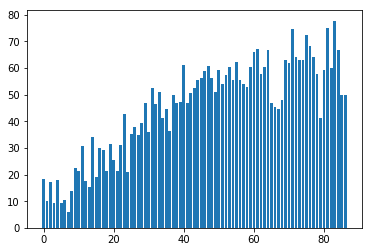

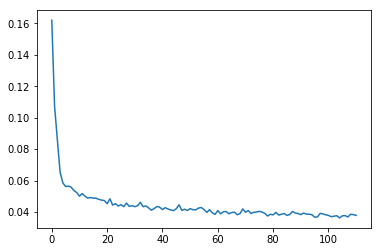

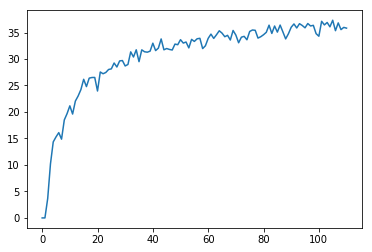

Train Epoch: 221 [0/65192 (0%)]	Loss: 0.037577
Train Epoch: 221 [6400/65192 (10%)]	Loss: 0.049846
Train Epoch: 221 [12800/65192 (20%)]	Loss: 0.045121
Train Epoch: 221 [19200/65192 (29%)]	Loss: 0.034888
Train Epoch: 221 [25600/65192 (39%)]	Loss: 0.041100
Train Epoch: 221 [32000/65192 (49%)]	Loss: 0.039999
Train Epoch: 221 [38400/65192 (59%)]	Loss: 0.032024
Train Epoch: 221 [44800/65192 (69%)]	Loss: 0.032853
Train Epoch: 221 [51200/65192 (79%)]	Loss: 0.039452
Train Epoch: 221 [57600/65192 (88%)]	Loss: 0.034080
Train Epoch: 221 [64000/65192 (98%)]	Loss: 0.032257
Train Epoch: 222 [0/65192 (0%)]	Loss: 0.034134
Train Epoch: 222 [6400/65192 (10%)]	Loss: 0.041732
Train Epoch: 222 [12800/65192 (20%)]	Loss: 0.030637
Train Epoch: 222 [19200/65192 (29%)]	Loss: 0.036962
Train Epoch: 222 [25600/65192 (39%)]	Loss: 0.034827
Train Epoch: 222 [32000/65192 (49%)]	Loss: 0.047189
Train Epoch: 222 [38400/65192 (59%)]	Loss: 0.039922
Train Epoch: 222 [44800/65192 (69%)]	Loss: 0.036146
Train Epoch: 222 [51200/

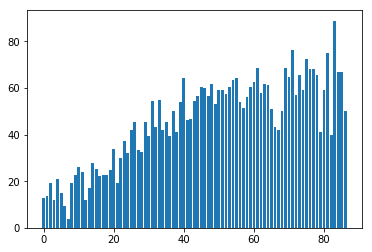

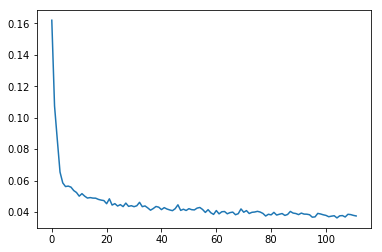

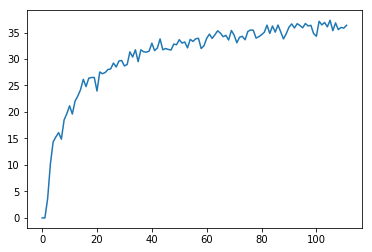

Train Epoch: 223 [0/65192 (0%)]	Loss: 0.039631
Train Epoch: 223 [6400/65192 (10%)]	Loss: 0.035413
Train Epoch: 223 [12800/65192 (20%)]	Loss: 0.034972
Train Epoch: 223 [19200/65192 (29%)]	Loss: 0.040669
Train Epoch: 223 [25600/65192 (39%)]	Loss: 0.040088
Train Epoch: 223 [32000/65192 (49%)]	Loss: 0.039147
Train Epoch: 223 [38400/65192 (59%)]	Loss: 0.039298
Train Epoch: 223 [44800/65192 (69%)]	Loss: 0.033459
Train Epoch: 223 [51200/65192 (79%)]	Loss: 0.037215
Train Epoch: 223 [57600/65192 (88%)]	Loss: 0.042770
Train Epoch: 223 [64000/65192 (98%)]	Loss: 0.032916
Train Epoch: 224 [0/65192 (0%)]	Loss: 0.040207
Train Epoch: 224 [6400/65192 (10%)]	Loss: 0.032827
Train Epoch: 224 [12800/65192 (20%)]	Loss: 0.040293
Train Epoch: 224 [19200/65192 (29%)]	Loss: 0.032949
Train Epoch: 224 [25600/65192 (39%)]	Loss: 0.032546
Train Epoch: 224 [32000/65192 (49%)]	Loss: 0.043088
Train Epoch: 224 [38400/65192 (59%)]	Loss: 0.039160
Train Epoch: 224 [44800/65192 (69%)]	Loss: 0.039971
Train Epoch: 224 [51200/

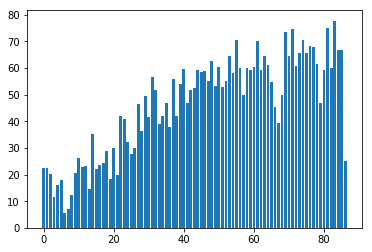

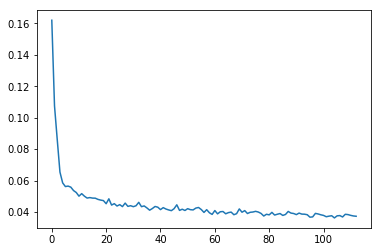

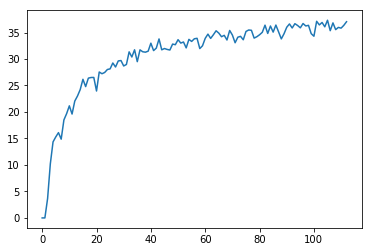

Train Epoch: 225 [0/65192 (0%)]	Loss: 0.036110
Train Epoch: 225 [6400/65192 (10%)]	Loss: 0.036490
Train Epoch: 225 [12800/65192 (20%)]	Loss: 0.043103
Train Epoch: 225 [19200/65192 (29%)]	Loss: 0.035166
Train Epoch: 225 [25600/65192 (39%)]	Loss: 0.036732
Train Epoch: 225 [32000/65192 (49%)]	Loss: 0.036838
Train Epoch: 225 [38400/65192 (59%)]	Loss: 0.041755
Train Epoch: 225 [44800/65192 (69%)]	Loss: 0.044308
Train Epoch: 225 [51200/65192 (79%)]	Loss: 0.042112
Train Epoch: 225 [57600/65192 (88%)]	Loss: 0.031789
Train Epoch: 225 [64000/65192 (98%)]	Loss: 0.034227
Train Epoch: 226 [0/65192 (0%)]	Loss: 0.030608
Train Epoch: 226 [6400/65192 (10%)]	Loss: 0.036487
Train Epoch: 226 [12800/65192 (20%)]	Loss: 0.038821
Train Epoch: 226 [19200/65192 (29%)]	Loss: 0.038148
Train Epoch: 226 [25600/65192 (39%)]	Loss: 0.041952
Train Epoch: 226 [32000/65192 (49%)]	Loss: 0.036175
Train Epoch: 226 [38400/65192 (59%)]	Loss: 0.029087
Train Epoch: 226 [44800/65192 (69%)]	Loss: 0.050556
Train Epoch: 226 [51200/

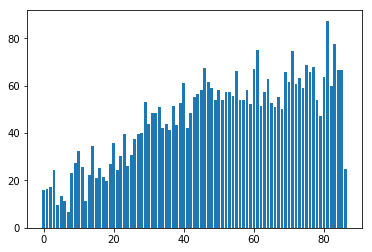

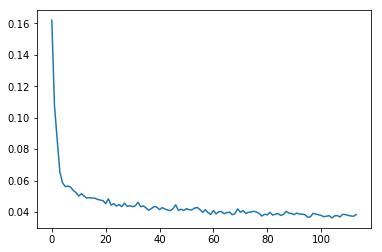

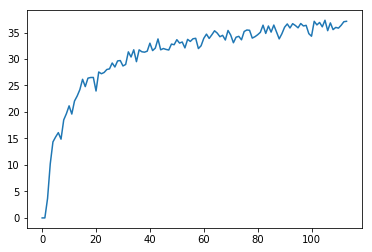

Train Epoch: 227 [0/65192 (0%)]	Loss: 0.033374
Train Epoch: 227 [6400/65192 (10%)]	Loss: 0.034646
Train Epoch: 227 [12800/65192 (20%)]	Loss: 0.036530
Train Epoch: 227 [19200/65192 (29%)]	Loss: 0.027078
Train Epoch: 227 [25600/65192 (39%)]	Loss: 0.033677
Train Epoch: 227 [32000/65192 (49%)]	Loss: 0.034016
Train Epoch: 227 [38400/65192 (59%)]	Loss: 0.031925
Train Epoch: 227 [44800/65192 (69%)]	Loss: 0.031168
Train Epoch: 227 [51200/65192 (79%)]	Loss: 0.039923
Train Epoch: 227 [57600/65192 (88%)]	Loss: 0.044592
Train Epoch: 227 [64000/65192 (98%)]	Loss: 0.034458
Train Epoch: 228 [0/65192 (0%)]	Loss: 0.030405
Train Epoch: 228 [6400/65192 (10%)]	Loss: 0.034556
Train Epoch: 228 [12800/65192 (20%)]	Loss: 0.023415
Train Epoch: 228 [19200/65192 (29%)]	Loss: 0.040537
Train Epoch: 228 [25600/65192 (39%)]	Loss: 0.035400
Train Epoch: 228 [32000/65192 (49%)]	Loss: 0.041748
Train Epoch: 228 [38400/65192 (59%)]	Loss: 0.029984
Train Epoch: 228 [44800/65192 (69%)]	Loss: 0.038499
Train Epoch: 228 [51200/

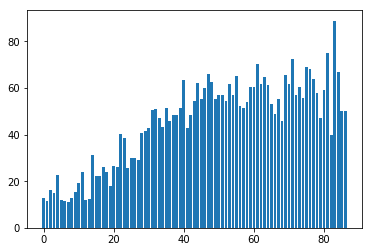

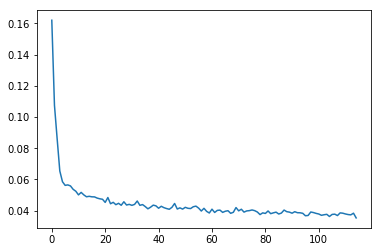

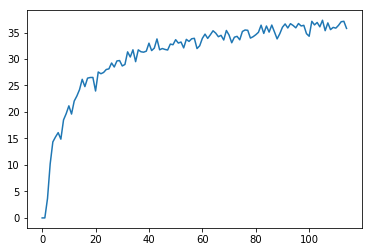

Train Epoch: 229 [0/65192 (0%)]	Loss: 0.034032
Train Epoch: 229 [6400/65192 (10%)]	Loss: 0.034836
Train Epoch: 229 [12800/65192 (20%)]	Loss: 0.033605
Train Epoch: 229 [19200/65192 (29%)]	Loss: 0.046051
Train Epoch: 229 [25600/65192 (39%)]	Loss: 0.041471
Train Epoch: 229 [32000/65192 (49%)]	Loss: 0.029873
Train Epoch: 229 [38400/65192 (59%)]	Loss: 0.033774
Train Epoch: 229 [44800/65192 (69%)]	Loss: 0.041733
Train Epoch: 229 [51200/65192 (79%)]	Loss: 0.028945
Train Epoch: 229 [57600/65192 (88%)]	Loss: 0.033179
Train Epoch: 229 [64000/65192 (98%)]	Loss: 0.033619
Train Epoch: 230 [0/65192 (0%)]	Loss: 0.042529
Train Epoch: 230 [6400/65192 (10%)]	Loss: 0.027923
Train Epoch: 230 [12800/65192 (20%)]	Loss: 0.047109
Train Epoch: 230 [19200/65192 (29%)]	Loss: 0.051109
Train Epoch: 230 [25600/65192 (39%)]	Loss: 0.037560
Train Epoch: 230 [32000/65192 (49%)]	Loss: 0.049802
Train Epoch: 230 [38400/65192 (59%)]	Loss: 0.032433
Train Epoch: 230 [44800/65192 (69%)]	Loss: 0.029778
Train Epoch: 230 [51200/

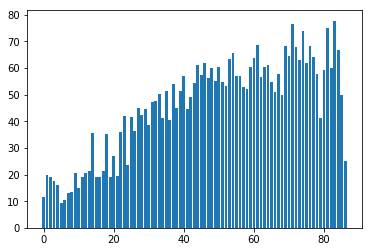

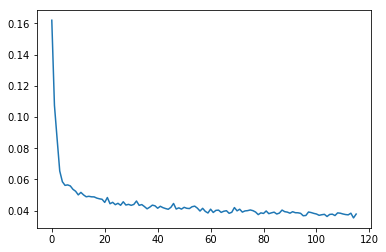

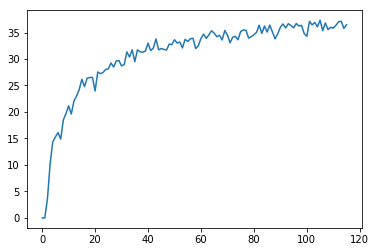

Train Epoch: 231 [0/65192 (0%)]	Loss: 0.031304
Train Epoch: 231 [6400/65192 (10%)]	Loss: 0.036828
Train Epoch: 231 [12800/65192 (20%)]	Loss: 0.037172
Train Epoch: 231 [19200/65192 (29%)]	Loss: 0.031281
Train Epoch: 231 [25600/65192 (39%)]	Loss: 0.041453
Train Epoch: 231 [32000/65192 (49%)]	Loss: 0.033540
Train Epoch: 231 [38400/65192 (59%)]	Loss: 0.041437
Train Epoch: 231 [44800/65192 (69%)]	Loss: 0.038664
Train Epoch: 231 [51200/65192 (79%)]	Loss: 0.033303
Train Epoch: 231 [57600/65192 (88%)]	Loss: 0.032666
Train Epoch: 231 [64000/65192 (98%)]	Loss: 0.041751
Train Epoch: 232 [0/65192 (0%)]	Loss: 0.029313
Train Epoch: 232 [6400/65192 (10%)]	Loss: 0.031340
Train Epoch: 232 [12800/65192 (20%)]	Loss: 0.032593
Train Epoch: 232 [19200/65192 (29%)]	Loss: 0.033827
Train Epoch: 232 [25600/65192 (39%)]	Loss: 0.030511
Train Epoch: 232 [32000/65192 (49%)]	Loss: 0.045427
Train Epoch: 232 [38400/65192 (59%)]	Loss: 0.028860
Train Epoch: 232 [44800/65192 (69%)]	Loss: 0.042907
Train Epoch: 232 [51200/

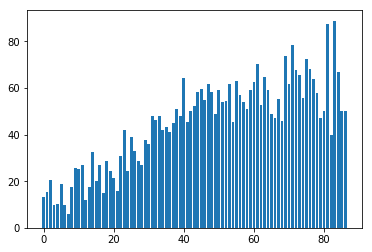

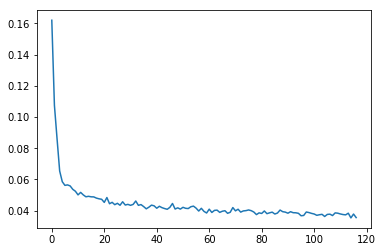

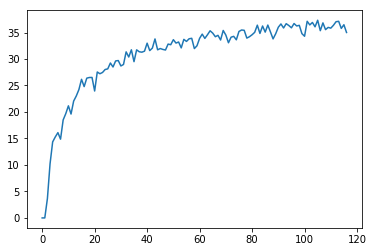

Train Epoch: 233 [0/65192 (0%)]	Loss: 0.032660
Train Epoch: 233 [6400/65192 (10%)]	Loss: 0.037135
Train Epoch: 233 [12800/65192 (20%)]	Loss: 0.037826
Train Epoch: 233 [19200/65192 (29%)]	Loss: 0.044450
Train Epoch: 233 [25600/65192 (39%)]	Loss: 0.033184
Train Epoch: 233 [32000/65192 (49%)]	Loss: 0.033325
Train Epoch: 233 [38400/65192 (59%)]	Loss: 0.034890
Train Epoch: 233 [44800/65192 (69%)]	Loss: 0.034105
Train Epoch: 233 [51200/65192 (79%)]	Loss: 0.031712
Train Epoch: 233 [57600/65192 (88%)]	Loss: 0.040317
Train Epoch: 233 [64000/65192 (98%)]	Loss: 0.032857
Train Epoch: 234 [0/65192 (0%)]	Loss: 0.041142
Train Epoch: 234 [6400/65192 (10%)]	Loss: 0.033178
Train Epoch: 234 [12800/65192 (20%)]	Loss: 0.036576
Train Epoch: 234 [19200/65192 (29%)]	Loss: 0.033961
Train Epoch: 234 [25600/65192 (39%)]	Loss: 0.035209
Train Epoch: 234 [32000/65192 (49%)]	Loss: 0.047730
Train Epoch: 234 [38400/65192 (59%)]	Loss: 0.040055
Train Epoch: 234 [44800/65192 (69%)]	Loss: 0.041259
Train Epoch: 234 [51200/

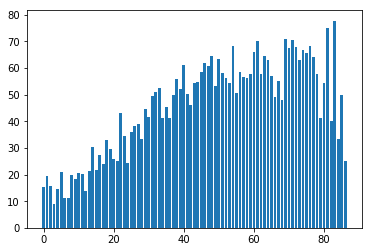

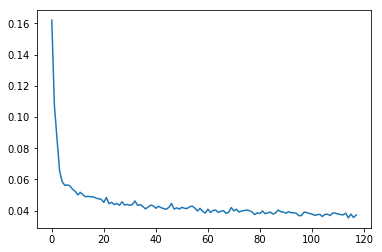

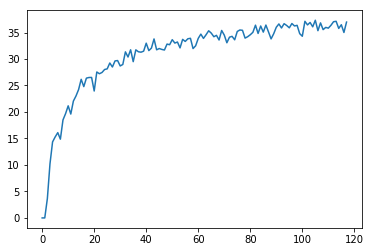

Train Epoch: 235 [0/65192 (0%)]	Loss: 0.040362
Train Epoch: 235 [6400/65192 (10%)]	Loss: 0.033958
Train Epoch: 235 [12800/65192 (20%)]	Loss: 0.041758
Train Epoch: 235 [19200/65192 (29%)]	Loss: 0.046218
Train Epoch: 235 [25600/65192 (39%)]	Loss: 0.032420
Train Epoch: 235 [32000/65192 (49%)]	Loss: 0.043656
Train Epoch: 235 [38400/65192 (59%)]	Loss: 0.043923
Train Epoch: 235 [44800/65192 (69%)]	Loss: 0.034029
Train Epoch: 235 [51200/65192 (79%)]	Loss: 0.036974
Train Epoch: 235 [57600/65192 (88%)]	Loss: 0.041426
Train Epoch: 235 [64000/65192 (98%)]	Loss: 0.040286
Train Epoch: 236 [0/65192 (0%)]	Loss: 0.038962
Train Epoch: 236 [6400/65192 (10%)]	Loss: 0.042016
Train Epoch: 236 [12800/65192 (20%)]	Loss: 0.041765
Train Epoch: 236 [19200/65192 (29%)]	Loss: 0.033321
Train Epoch: 236 [25600/65192 (39%)]	Loss: 0.033516
Train Epoch: 236 [32000/65192 (49%)]	Loss: 0.043519
Train Epoch: 236 [38400/65192 (59%)]	Loss: 0.035548
Train Epoch: 236 [44800/65192 (69%)]	Loss: 0.041950
Train Epoch: 236 [51200/

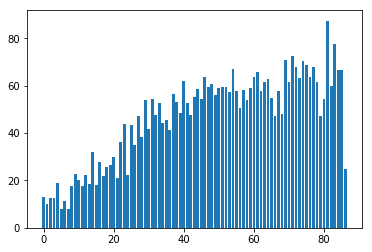

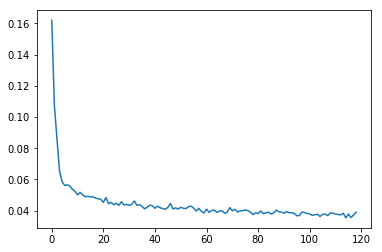

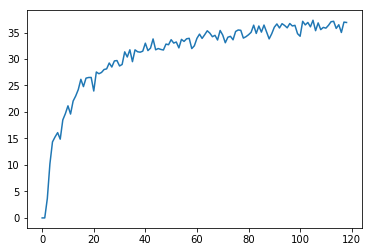

Train Epoch: 237 [0/65192 (0%)]	Loss: 0.050354
Train Epoch: 237 [6400/65192 (10%)]	Loss: 0.035801
Train Epoch: 237 [12800/65192 (20%)]	Loss: 0.034805
Train Epoch: 237 [19200/65192 (29%)]	Loss: 0.048207
Train Epoch: 237 [25600/65192 (39%)]	Loss: 0.027911
Train Epoch: 237 [32000/65192 (49%)]	Loss: 0.035576
Train Epoch: 237 [38400/65192 (59%)]	Loss: 0.034706
Train Epoch: 237 [44800/65192 (69%)]	Loss: 0.033690
Train Epoch: 237 [51200/65192 (79%)]	Loss: 0.032245
Train Epoch: 237 [57600/65192 (88%)]	Loss: 0.034903
Train Epoch: 237 [64000/65192 (98%)]	Loss: 0.037832
Train Epoch: 238 [0/65192 (0%)]	Loss: 0.037295
Train Epoch: 238 [6400/65192 (10%)]	Loss: 0.037113
Train Epoch: 238 [12800/65192 (20%)]	Loss: 0.031601
Train Epoch: 238 [19200/65192 (29%)]	Loss: 0.035923
Train Epoch: 238 [25600/65192 (39%)]	Loss: 0.031145
Train Epoch: 238 [32000/65192 (49%)]	Loss: 0.048327
Train Epoch: 238 [38400/65192 (59%)]	Loss: 0.036234
Train Epoch: 238 [44800/65192 (69%)]	Loss: 0.036123
Train Epoch: 238 [51200/

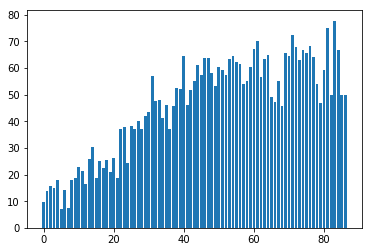

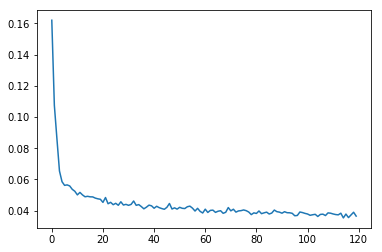

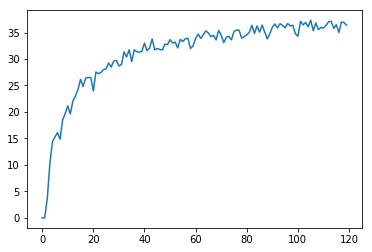

Train Epoch: 239 [0/65192 (0%)]	Loss: 0.027093
Train Epoch: 239 [6400/65192 (10%)]	Loss: 0.047281
Train Epoch: 239 [12800/65192 (20%)]	Loss: 0.031468
Train Epoch: 239 [19200/65192 (29%)]	Loss: 0.035884
Train Epoch: 239 [25600/65192 (39%)]	Loss: 0.043068
Train Epoch: 239 [32000/65192 (49%)]	Loss: 0.031609
Train Epoch: 239 [38400/65192 (59%)]	Loss: 0.031054
Train Epoch: 239 [44800/65192 (69%)]	Loss: 0.037976
Train Epoch: 239 [51200/65192 (79%)]	Loss: 0.033252
Train Epoch: 239 [57600/65192 (88%)]	Loss: 0.034758
Train Epoch: 239 [64000/65192 (98%)]	Loss: 0.037717
Train Epoch: 240 [0/65192 (0%)]	Loss: 0.046261
Train Epoch: 240 [6400/65192 (10%)]	Loss: 0.036508
Train Epoch: 240 [12800/65192 (20%)]	Loss: 0.028750
Train Epoch: 240 [19200/65192 (29%)]	Loss: 0.033277
Train Epoch: 240 [25600/65192 (39%)]	Loss: 0.034602
Train Epoch: 240 [32000/65192 (49%)]	Loss: 0.041453
Train Epoch: 240 [38400/65192 (59%)]	Loss: 0.036209
Train Epoch: 240 [44800/65192 (69%)]	Loss: 0.044455
Train Epoch: 240 [51200/

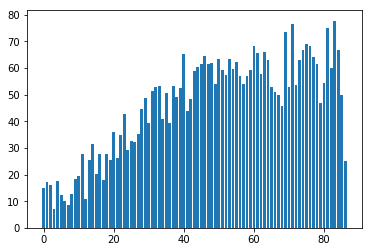

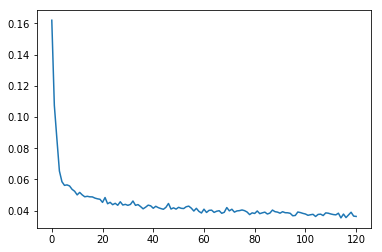

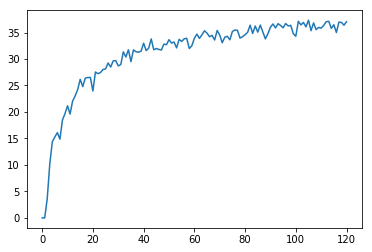

Train Epoch: 241 [0/65192 (0%)]	Loss: 0.038452
Train Epoch: 241 [6400/65192 (10%)]	Loss: 0.039608
Train Epoch: 241 [12800/65192 (20%)]	Loss: 0.041041
Train Epoch: 241 [19200/65192 (29%)]	Loss: 0.036985
Train Epoch: 241 [25600/65192 (39%)]	Loss: 0.041440
Train Epoch: 241 [32000/65192 (49%)]	Loss: 0.031663
Train Epoch: 241 [38400/65192 (59%)]	Loss: 0.035248
Train Epoch: 241 [44800/65192 (69%)]	Loss: 0.037097
Train Epoch: 241 [51200/65192 (79%)]	Loss: 0.045039
Train Epoch: 241 [57600/65192 (88%)]	Loss: 0.039136
Train Epoch: 241 [64000/65192 (98%)]	Loss: 0.032760
Train Epoch: 242 [0/65192 (0%)]	Loss: 0.031255
Train Epoch: 242 [6400/65192 (10%)]	Loss: 0.036619
Train Epoch: 242 [12800/65192 (20%)]	Loss: 0.039313
Train Epoch: 242 [19200/65192 (29%)]	Loss: 0.033530
Train Epoch: 242 [25600/65192 (39%)]	Loss: 0.042734
Train Epoch: 242 [32000/65192 (49%)]	Loss: 0.038602
Train Epoch: 242 [38400/65192 (59%)]	Loss: 0.036415
Train Epoch: 242 [44800/65192 (69%)]	Loss: 0.037084
Train Epoch: 242 [51200/

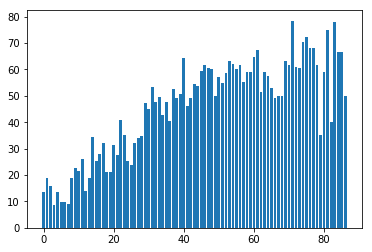

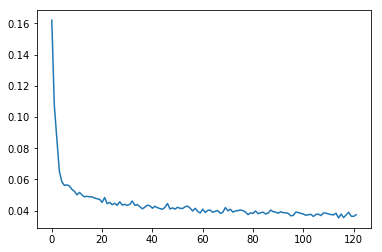

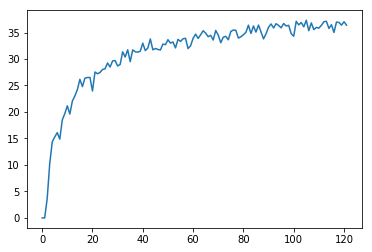

Train Epoch: 243 [0/65192 (0%)]	Loss: 0.039592
Train Epoch: 243 [6400/65192 (10%)]	Loss: 0.045181
Train Epoch: 243 [12800/65192 (20%)]	Loss: 0.041546
Train Epoch: 243 [19200/65192 (29%)]	Loss: 0.045017
Train Epoch: 243 [25600/65192 (39%)]	Loss: 0.031510
Train Epoch: 243 [32000/65192 (49%)]	Loss: 0.032170
Train Epoch: 243 [38400/65192 (59%)]	Loss: 0.040086
Train Epoch: 243 [44800/65192 (69%)]	Loss: 0.028621
Train Epoch: 243 [51200/65192 (79%)]	Loss: 0.031203
Train Epoch: 243 [57600/65192 (88%)]	Loss: 0.038165
Train Epoch: 243 [64000/65192 (98%)]	Loss: 0.032713
Train Epoch: 244 [0/65192 (0%)]	Loss: 0.040203
Train Epoch: 244 [6400/65192 (10%)]	Loss: 0.037930
Train Epoch: 244 [12800/65192 (20%)]	Loss: 0.040283
Train Epoch: 244 [19200/65192 (29%)]	Loss: 0.040196
Train Epoch: 244 [25600/65192 (39%)]	Loss: 0.034546
Train Epoch: 244 [32000/65192 (49%)]	Loss: 0.035696
Train Epoch: 244 [38400/65192 (59%)]	Loss: 0.030959
Train Epoch: 244 [44800/65192 (69%)]	Loss: 0.038777
Train Epoch: 244 [51200/

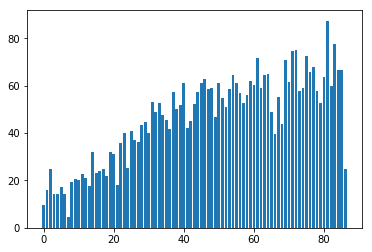

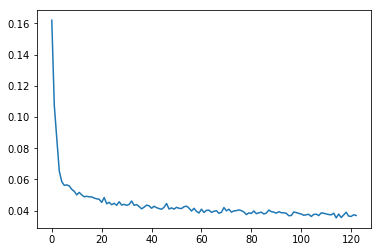

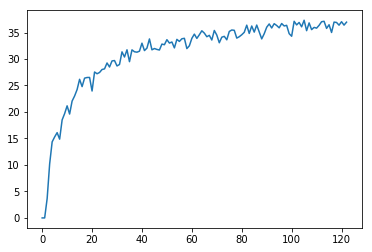

Train Epoch: 245 [0/65192 (0%)]	Loss: 0.042681
Train Epoch: 245 [6400/65192 (10%)]	Loss: 0.034030
Train Epoch: 245 [12800/65192 (20%)]	Loss: 0.037351
Train Epoch: 245 [19200/65192 (29%)]	Loss: 0.033964
Train Epoch: 245 [25600/65192 (39%)]	Loss: 0.034351
Train Epoch: 245 [32000/65192 (49%)]	Loss: 0.035386
Train Epoch: 245 [38400/65192 (59%)]	Loss: 0.041094
Train Epoch: 245 [44800/65192 (69%)]	Loss: 0.042108
Train Epoch: 245 [51200/65192 (79%)]	Loss: 0.042414
Train Epoch: 245 [57600/65192 (88%)]	Loss: 0.045610
Train Epoch: 245 [64000/65192 (98%)]	Loss: 0.044154
Train Epoch: 246 [0/65192 (0%)]	Loss: 0.041205
Train Epoch: 246 [6400/65192 (10%)]	Loss: 0.034957
Train Epoch: 246 [12800/65192 (20%)]	Loss: 0.045613
Train Epoch: 246 [19200/65192 (29%)]	Loss: 0.037318
Train Epoch: 246 [25600/65192 (39%)]	Loss: 0.039655
Train Epoch: 246 [32000/65192 (49%)]	Loss: 0.041199
Train Epoch: 246 [38400/65192 (59%)]	Loss: 0.044045
Train Epoch: 246 [44800/65192 (69%)]	Loss: 0.029705
Train Epoch: 246 [51200/

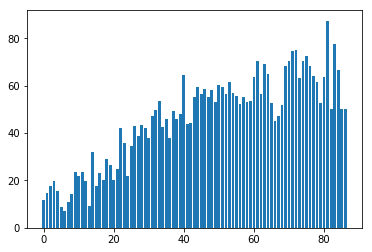

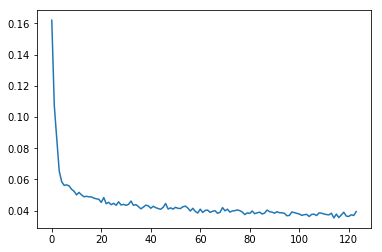

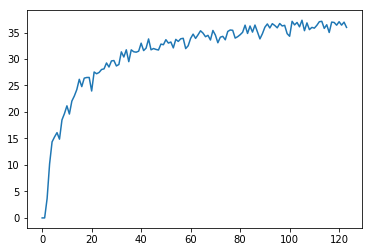

Train Epoch: 247 [0/65192 (0%)]	Loss: 0.033616
Train Epoch: 247 [6400/65192 (10%)]	Loss: 0.041275
Train Epoch: 247 [12800/65192 (20%)]	Loss: 0.043258
Train Epoch: 247 [19200/65192 (29%)]	Loss: 0.032383
Train Epoch: 247 [25600/65192 (39%)]	Loss: 0.038155
Train Epoch: 247 [32000/65192 (49%)]	Loss: 0.038260
Train Epoch: 247 [38400/65192 (59%)]	Loss: 0.037478
Train Epoch: 247 [44800/65192 (69%)]	Loss: 0.040652
Train Epoch: 247 [51200/65192 (79%)]	Loss: 0.028576
Train Epoch: 247 [57600/65192 (88%)]	Loss: 0.041861
Train Epoch: 247 [64000/65192 (98%)]	Loss: 0.035840
Train Epoch: 248 [0/65192 (0%)]	Loss: 0.035909
Train Epoch: 248 [6400/65192 (10%)]	Loss: 0.034540
Train Epoch: 248 [12800/65192 (20%)]	Loss: 0.032303
Train Epoch: 248 [19200/65192 (29%)]	Loss: 0.031271
Train Epoch: 248 [25600/65192 (39%)]	Loss: 0.040229
Train Epoch: 248 [32000/65192 (49%)]	Loss: 0.040710
Train Epoch: 248 [38400/65192 (59%)]	Loss: 0.039678
Train Epoch: 248 [44800/65192 (69%)]	Loss: 0.031224
Train Epoch: 248 [51200/

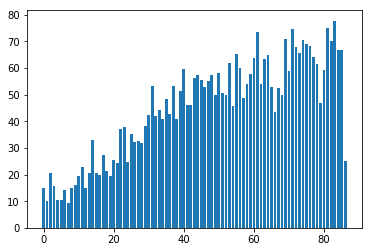

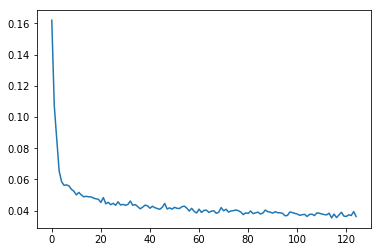

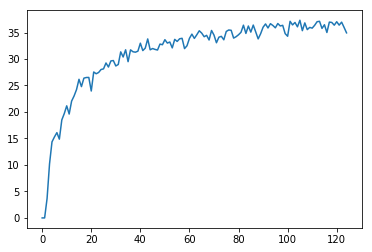

Train Epoch: 249 [0/65192 (0%)]	Loss: 0.042620
Train Epoch: 249 [6400/65192 (10%)]	Loss: 0.047028
Train Epoch: 249 [12800/65192 (20%)]	Loss: 0.037543
Train Epoch: 249 [19200/65192 (29%)]	Loss: 0.042454
Train Epoch: 249 [25600/65192 (39%)]	Loss: 0.039880
Train Epoch: 249 [32000/65192 (49%)]	Loss: 0.034516
Train Epoch: 249 [38400/65192 (59%)]	Loss: 0.040151
Train Epoch: 249 [44800/65192 (69%)]	Loss: 0.037319
Train Epoch: 249 [51200/65192 (79%)]	Loss: 0.033328
Train Epoch: 249 [57600/65192 (88%)]	Loss: 0.036696
Train Epoch: 249 [64000/65192 (98%)]	Loss: 0.033124
Train Epoch: 250 [0/65192 (0%)]	Loss: 0.036138
Train Epoch: 250 [6400/65192 (10%)]	Loss: 0.034307
Train Epoch: 250 [12800/65192 (20%)]	Loss: 0.034891
Train Epoch: 250 [19200/65192 (29%)]	Loss: 0.037060
Train Epoch: 250 [25600/65192 (39%)]	Loss: 0.034546
Train Epoch: 250 [32000/65192 (49%)]	Loss: 0.029455
Train Epoch: 250 [38400/65192 (59%)]	Loss: 0.034126
Train Epoch: 250 [44800/65192 (69%)]	Loss: 0.054729
Train Epoch: 250 [51200/

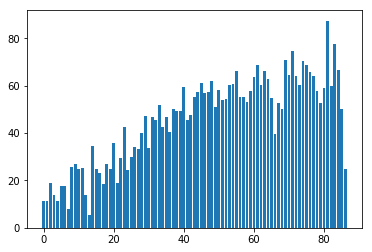

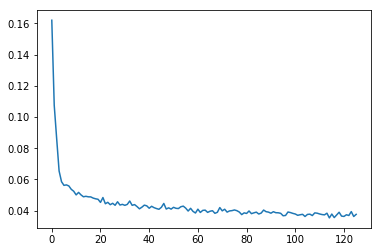

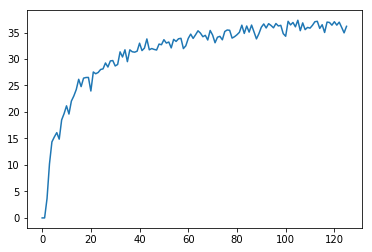

Train Epoch: 251 [0/65192 (0%)]	Loss: 0.037721
Train Epoch: 251 [6400/65192 (10%)]	Loss: 0.033186
Train Epoch: 251 [12800/65192 (20%)]	Loss: 0.038127
Train Epoch: 251 [19200/65192 (29%)]	Loss: 0.029744
Train Epoch: 251 [25600/65192 (39%)]	Loss: 0.042095
Train Epoch: 251 [32000/65192 (49%)]	Loss: 0.034290
Train Epoch: 251 [38400/65192 (59%)]	Loss: 0.030081
Train Epoch: 251 [44800/65192 (69%)]	Loss: 0.037644
Train Epoch: 251 [51200/65192 (79%)]	Loss: 0.038076
Train Epoch: 251 [57600/65192 (88%)]	Loss: 0.037307
Train Epoch: 251 [64000/65192 (98%)]	Loss: 0.040637
Train Epoch: 252 [0/65192 (0%)]	Loss: 0.029236
Train Epoch: 252 [6400/65192 (10%)]	Loss: 0.045676
Train Epoch: 252 [12800/65192 (20%)]	Loss: 0.032894
Train Epoch: 252 [19200/65192 (29%)]	Loss: 0.025836
Train Epoch: 252 [25600/65192 (39%)]	Loss: 0.042550
Train Epoch: 252 [32000/65192 (49%)]	Loss: 0.035721
Train Epoch: 252 [38400/65192 (59%)]	Loss: 0.046455
Train Epoch: 252 [44800/65192 (69%)]	Loss: 0.037820
Train Epoch: 252 [51200/

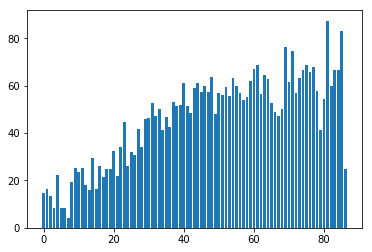

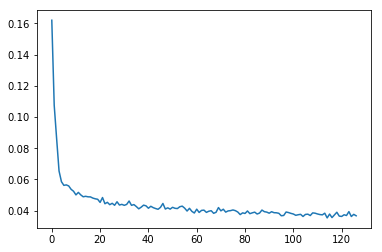

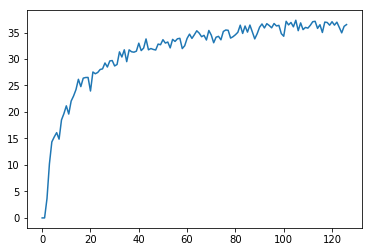

Train Epoch: 253 [0/65192 (0%)]	Loss: 0.031916
Train Epoch: 253 [6400/65192 (10%)]	Loss: 0.038232
Train Epoch: 253 [12800/65192 (20%)]	Loss: 0.032979
Train Epoch: 253 [19200/65192 (29%)]	Loss: 0.036822
Train Epoch: 253 [25600/65192 (39%)]	Loss: 0.035359
Train Epoch: 253 [32000/65192 (49%)]	Loss: 0.038321
Train Epoch: 253 [38400/65192 (59%)]	Loss: 0.043917
Train Epoch: 253 [44800/65192 (69%)]	Loss: 0.037437
Train Epoch: 253 [51200/65192 (79%)]	Loss: 0.038520
Train Epoch: 253 [57600/65192 (88%)]	Loss: 0.030762
Train Epoch: 253 [64000/65192 (98%)]	Loss: 0.035751
Train Epoch: 254 [0/65192 (0%)]	Loss: 0.047224
Train Epoch: 254 [6400/65192 (10%)]	Loss: 0.047900
Train Epoch: 254 [12800/65192 (20%)]	Loss: 0.039004
Train Epoch: 254 [19200/65192 (29%)]	Loss: 0.037281
Train Epoch: 254 [25600/65192 (39%)]	Loss: 0.030602
Train Epoch: 254 [32000/65192 (49%)]	Loss: 0.055112
Train Epoch: 254 [38400/65192 (59%)]	Loss: 0.039414
Train Epoch: 254 [44800/65192 (69%)]	Loss: 0.034166
Train Epoch: 254 [51200/

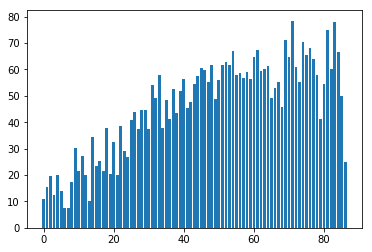

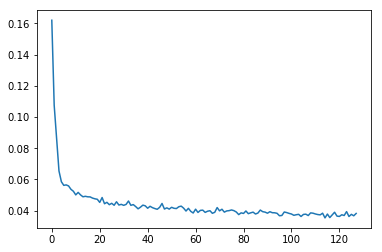

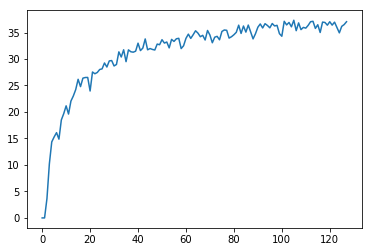

Train Epoch: 255 [0/65192 (0%)]	Loss: 0.030039
Train Epoch: 255 [6400/65192 (10%)]	Loss: 0.039901
Train Epoch: 255 [12800/65192 (20%)]	Loss: 0.029928
Train Epoch: 255 [19200/65192 (29%)]	Loss: 0.037334
Train Epoch: 255 [25600/65192 (39%)]	Loss: 0.041477
Train Epoch: 255 [32000/65192 (49%)]	Loss: 0.038461
Train Epoch: 255 [38400/65192 (59%)]	Loss: 0.031556
Train Epoch: 255 [44800/65192 (69%)]	Loss: 0.026521
Train Epoch: 255 [51200/65192 (79%)]	Loss: 0.042870
Train Epoch: 255 [57600/65192 (88%)]	Loss: 0.043892
Train Epoch: 255 [64000/65192 (98%)]	Loss: 0.036090
Train Epoch: 256 [0/65192 (0%)]	Loss: 0.041684
Train Epoch: 256 [6400/65192 (10%)]	Loss: 0.037204
Train Epoch: 256 [12800/65192 (20%)]	Loss: 0.035102
Train Epoch: 256 [19200/65192 (29%)]	Loss: 0.034408
Train Epoch: 256 [25600/65192 (39%)]	Loss: 0.032171
Train Epoch: 256 [32000/65192 (49%)]	Loss: 0.035090
Train Epoch: 256 [38400/65192 (59%)]	Loss: 0.042473
Train Epoch: 256 [44800/65192 (69%)]	Loss: 0.026820
Train Epoch: 256 [51200/

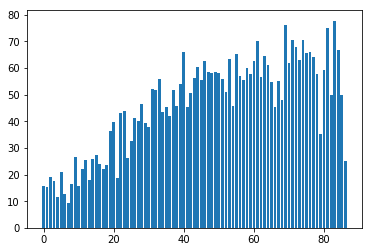

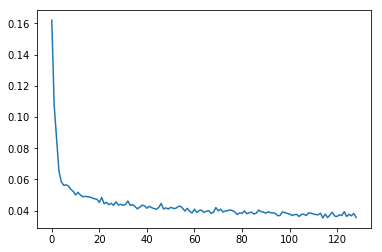

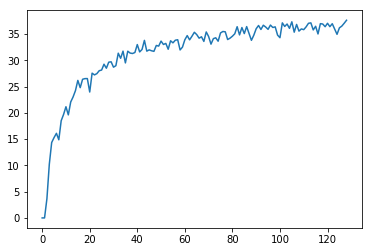

Train Epoch: 257 [0/65192 (0%)]	Loss: 0.033558
Train Epoch: 257 [6400/65192 (10%)]	Loss: 0.030954
Train Epoch: 257 [12800/65192 (20%)]	Loss: 0.038713
Train Epoch: 257 [19200/65192 (29%)]	Loss: 0.044853
Train Epoch: 257 [25600/65192 (39%)]	Loss: 0.038164
Train Epoch: 257 [32000/65192 (49%)]	Loss: 0.033156
Train Epoch: 257 [38400/65192 (59%)]	Loss: 0.034174
Train Epoch: 257 [44800/65192 (69%)]	Loss: 0.035710
Train Epoch: 257 [51200/65192 (79%)]	Loss: 0.037305
Train Epoch: 257 [57600/65192 (88%)]	Loss: 0.042066
Train Epoch: 257 [64000/65192 (98%)]	Loss: 0.032889
Train Epoch: 258 [0/65192 (0%)]	Loss: 0.027525
Train Epoch: 258 [6400/65192 (10%)]	Loss: 0.052801
Train Epoch: 258 [12800/65192 (20%)]	Loss: 0.039854
Train Epoch: 258 [19200/65192 (29%)]	Loss: 0.042594
Train Epoch: 258 [25600/65192 (39%)]	Loss: 0.033349
Train Epoch: 258 [32000/65192 (49%)]	Loss: 0.036160
Train Epoch: 258 [38400/65192 (59%)]	Loss: 0.034812
Train Epoch: 258 [44800/65192 (69%)]	Loss: 0.042852
Train Epoch: 258 [51200/

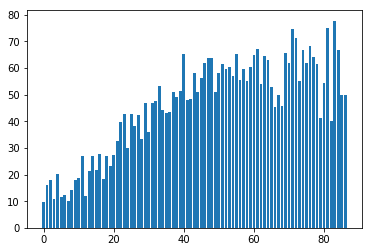

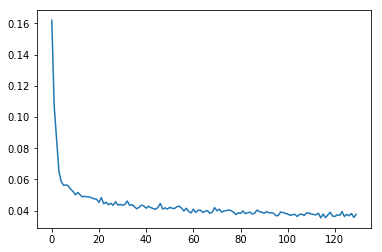

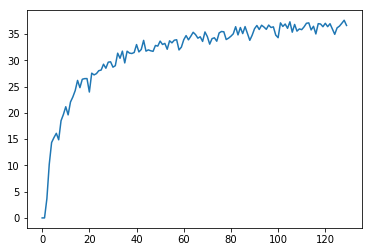

Train Epoch: 259 [0/65192 (0%)]	Loss: 0.032837
Train Epoch: 259 [6400/65192 (10%)]	Loss: 0.028685
Train Epoch: 259 [12800/65192 (20%)]	Loss: 0.037452
Train Epoch: 259 [19200/65192 (29%)]	Loss: 0.036782
Train Epoch: 259 [25600/65192 (39%)]	Loss: 0.044282
Train Epoch: 259 [32000/65192 (49%)]	Loss: 0.034809
Train Epoch: 259 [38400/65192 (59%)]	Loss: 0.037949
Train Epoch: 259 [44800/65192 (69%)]	Loss: 0.043546
Train Epoch: 259 [51200/65192 (79%)]	Loss: 0.034006
Train Epoch: 259 [57600/65192 (88%)]	Loss: 0.040708
Train Epoch: 259 [64000/65192 (98%)]	Loss: 0.038805
Train Epoch: 260 [0/65192 (0%)]	Loss: 0.042224
Train Epoch: 260 [6400/65192 (10%)]	Loss: 0.037235
Train Epoch: 260 [12800/65192 (20%)]	Loss: 0.039619
Train Epoch: 260 [19200/65192 (29%)]	Loss: 0.032874
Train Epoch: 260 [25600/65192 (39%)]	Loss: 0.031941
Train Epoch: 260 [32000/65192 (49%)]	Loss: 0.038041
Train Epoch: 260 [38400/65192 (59%)]	Loss: 0.024872
Train Epoch: 260 [44800/65192 (69%)]	Loss: 0.028116
Train Epoch: 260 [51200/

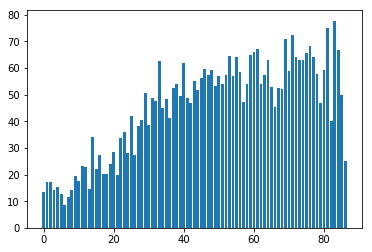

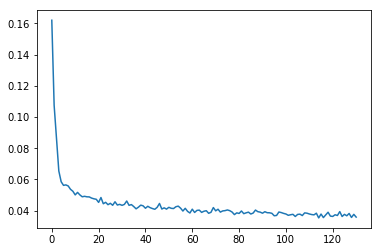

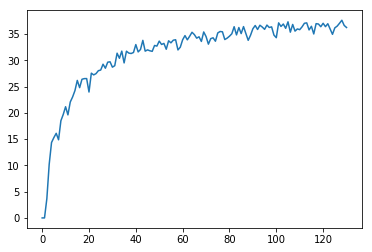

Train Epoch: 261 [0/65192 (0%)]	Loss: 0.040305
Train Epoch: 261 [6400/65192 (10%)]	Loss: 0.047986
Train Epoch: 261 [12800/65192 (20%)]	Loss: 0.031846
Train Epoch: 261 [19200/65192 (29%)]	Loss: 0.032972
Train Epoch: 261 [25600/65192 (39%)]	Loss: 0.036056
Train Epoch: 261 [32000/65192 (49%)]	Loss: 0.031378
Train Epoch: 261 [38400/65192 (59%)]	Loss: 0.035928
Train Epoch: 261 [44800/65192 (69%)]	Loss: 0.029678
Train Epoch: 261 [51200/65192 (79%)]	Loss: 0.026221
Train Epoch: 261 [57600/65192 (88%)]	Loss: 0.038052
Train Epoch: 261 [64000/65192 (98%)]	Loss: 0.036255
Train Epoch: 262 [0/65192 (0%)]	Loss: 0.039337
Train Epoch: 262 [6400/65192 (10%)]	Loss: 0.035665
Train Epoch: 262 [12800/65192 (20%)]	Loss: 0.039793
Train Epoch: 262 [19200/65192 (29%)]	Loss: 0.043511
Train Epoch: 262 [25600/65192 (39%)]	Loss: 0.040891
Train Epoch: 262 [32000/65192 (49%)]	Loss: 0.037637
Train Epoch: 262 [38400/65192 (59%)]	Loss: 0.038254
Train Epoch: 262 [44800/65192 (69%)]	Loss: 0.040255
Train Epoch: 262 [51200/

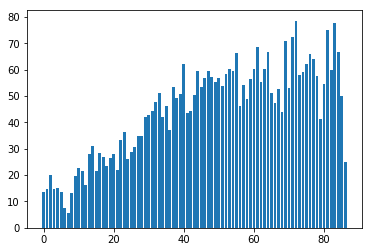

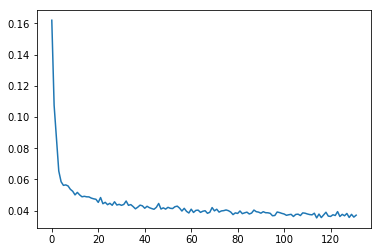

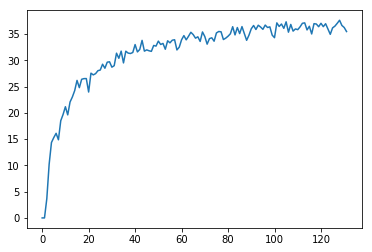

Train Epoch: 263 [0/65192 (0%)]	Loss: 0.047207
Train Epoch: 263 [6400/65192 (10%)]	Loss: 0.034240
Train Epoch: 263 [12800/65192 (20%)]	Loss: 0.035868
Train Epoch: 263 [19200/65192 (29%)]	Loss: 0.028723
Train Epoch: 263 [25600/65192 (39%)]	Loss: 0.038478
Train Epoch: 263 [32000/65192 (49%)]	Loss: 0.041795
Train Epoch: 263 [38400/65192 (59%)]	Loss: 0.035849
Train Epoch: 263 [44800/65192 (69%)]	Loss: 0.037206
Train Epoch: 263 [51200/65192 (79%)]	Loss: 0.035259
Train Epoch: 263 [57600/65192 (88%)]	Loss: 0.038250
Train Epoch: 263 [64000/65192 (98%)]	Loss: 0.036346
Train Epoch: 264 [0/65192 (0%)]	Loss: 0.026752
Train Epoch: 264 [6400/65192 (10%)]	Loss: 0.037445
Train Epoch: 264 [12800/65192 (20%)]	Loss: 0.038212
Train Epoch: 264 [19200/65192 (29%)]	Loss: 0.040450
Train Epoch: 264 [25600/65192 (39%)]	Loss: 0.035441
Train Epoch: 264 [32000/65192 (49%)]	Loss: 0.035588
Train Epoch: 264 [38400/65192 (59%)]	Loss: 0.046572
Train Epoch: 264 [44800/65192 (69%)]	Loss: 0.036139
Train Epoch: 264 [51200/

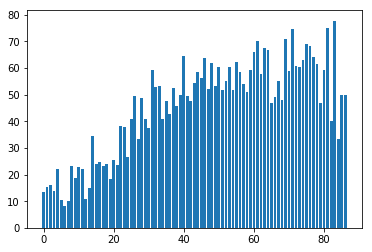

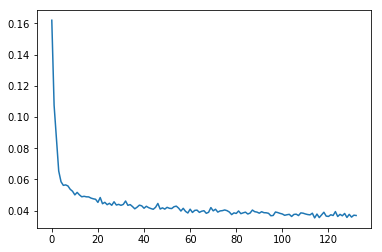

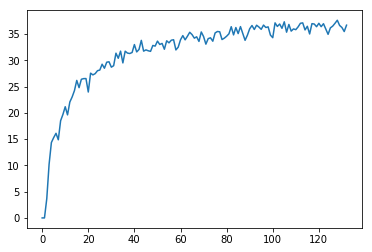

Train Epoch: 265 [0/65192 (0%)]	Loss: 0.029294
Train Epoch: 265 [6400/65192 (10%)]	Loss: 0.031836
Train Epoch: 265 [12800/65192 (20%)]	Loss: 0.049568
Train Epoch: 265 [19200/65192 (29%)]	Loss: 0.031289
Train Epoch: 265 [25600/65192 (39%)]	Loss: 0.027719
Train Epoch: 265 [32000/65192 (49%)]	Loss: 0.040435
Train Epoch: 265 [38400/65192 (59%)]	Loss: 0.035285
Train Epoch: 265 [44800/65192 (69%)]	Loss: 0.031442
Train Epoch: 265 [51200/65192 (79%)]	Loss: 0.049741
Train Epoch: 265 [57600/65192 (88%)]	Loss: 0.038240
Train Epoch: 265 [64000/65192 (98%)]	Loss: 0.039162
Train Epoch: 266 [0/65192 (0%)]	Loss: 0.027129
Train Epoch: 266 [6400/65192 (10%)]	Loss: 0.044817
Train Epoch: 266 [12800/65192 (20%)]	Loss: 0.028031
Train Epoch: 266 [19200/65192 (29%)]	Loss: 0.031740
Train Epoch: 266 [25600/65192 (39%)]	Loss: 0.036987
Train Epoch: 266 [32000/65192 (49%)]	Loss: 0.039610
Train Epoch: 266 [38400/65192 (59%)]	Loss: 0.038354
Train Epoch: 266 [44800/65192 (69%)]	Loss: 0.031684
Train Epoch: 266 [51200/

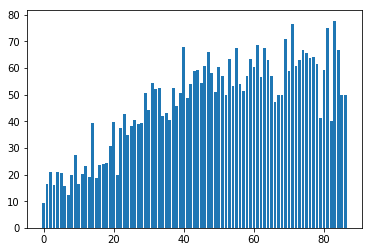

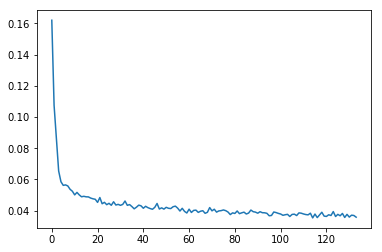

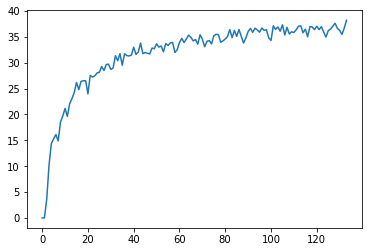

Train Epoch: 267 [0/65192 (0%)]	Loss: 0.036560
Train Epoch: 267 [6400/65192 (10%)]	Loss: 0.033015
Train Epoch: 267 [12800/65192 (20%)]	Loss: 0.037533
Train Epoch: 267 [19200/65192 (29%)]	Loss: 0.034071
Train Epoch: 267 [25600/65192 (39%)]	Loss: 0.032567
Train Epoch: 267 [32000/65192 (49%)]	Loss: 0.032282
Train Epoch: 267 [38400/65192 (59%)]	Loss: 0.033533
Train Epoch: 267 [44800/65192 (69%)]	Loss: 0.032993
Train Epoch: 267 [51200/65192 (79%)]	Loss: 0.033681
Train Epoch: 267 [57600/65192 (88%)]	Loss: 0.027400
Train Epoch: 267 [64000/65192 (98%)]	Loss: 0.042572
Train Epoch: 268 [0/65192 (0%)]	Loss: 0.039025
Train Epoch: 268 [6400/65192 (10%)]	Loss: 0.034318
Train Epoch: 268 [12800/65192 (20%)]	Loss: 0.036105
Train Epoch: 268 [19200/65192 (29%)]	Loss: 0.033523
Train Epoch: 268 [25600/65192 (39%)]	Loss: 0.041617
Train Epoch: 268 [32000/65192 (49%)]	Loss: 0.040419
Train Epoch: 268 [38400/65192 (59%)]	Loss: 0.037213
Train Epoch: 268 [44800/65192 (69%)]	Loss: 0.041498
Train Epoch: 268 [51200/

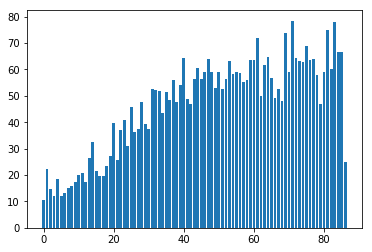

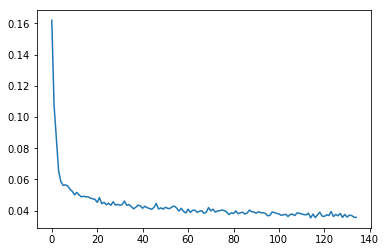

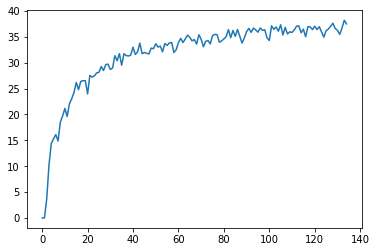

Train Epoch: 269 [0/65192 (0%)]	Loss: 0.038453
Train Epoch: 269 [6400/65192 (10%)]	Loss: 0.046722
Train Epoch: 269 [12800/65192 (20%)]	Loss: 0.035241
Train Epoch: 269 [19200/65192 (29%)]	Loss: 0.038864
Train Epoch: 269 [25600/65192 (39%)]	Loss: 0.032081
Train Epoch: 269 [32000/65192 (49%)]	Loss: 0.048869
Train Epoch: 269 [38400/65192 (59%)]	Loss: 0.046711
Train Epoch: 269 [44800/65192 (69%)]	Loss: 0.034795
Train Epoch: 269 [51200/65192 (79%)]	Loss: 0.040416
Train Epoch: 269 [57600/65192 (88%)]	Loss: 0.041944
Train Epoch: 269 [64000/65192 (98%)]	Loss: 0.031517
Train Epoch: 270 [0/65192 (0%)]	Loss: 0.043687
Train Epoch: 270 [6400/65192 (10%)]	Loss: 0.037671
Train Epoch: 270 [12800/65192 (20%)]	Loss: 0.041784
Train Epoch: 270 [19200/65192 (29%)]	Loss: 0.030349
Train Epoch: 270 [25600/65192 (39%)]	Loss: 0.029979
Train Epoch: 270 [32000/65192 (49%)]	Loss: 0.031623
Train Epoch: 270 [38400/65192 (59%)]	Loss: 0.040222
Train Epoch: 270 [44800/65192 (69%)]	Loss: 0.032945
Train Epoch: 270 [51200/

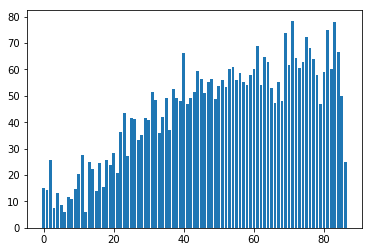

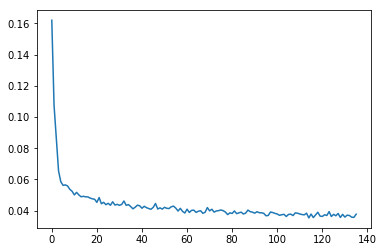

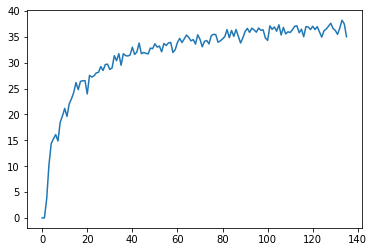

Train Epoch: 271 [0/65192 (0%)]	Loss: 0.033913
Train Epoch: 271 [6400/65192 (10%)]	Loss: 0.032743
Train Epoch: 271 [12800/65192 (20%)]	Loss: 0.033753
Train Epoch: 271 [19200/65192 (29%)]	Loss: 0.041902
Train Epoch: 271 [25600/65192 (39%)]	Loss: 0.034366
Train Epoch: 271 [32000/65192 (49%)]	Loss: 0.034845
Train Epoch: 271 [38400/65192 (59%)]	Loss: 0.036629
Train Epoch: 271 [44800/65192 (69%)]	Loss: 0.050844
Train Epoch: 271 [51200/65192 (79%)]	Loss: 0.039728
Train Epoch: 271 [57600/65192 (88%)]	Loss: 0.032837
Train Epoch: 271 [64000/65192 (98%)]	Loss: 0.038267
Train Epoch: 272 [0/65192 (0%)]	Loss: 0.041649
Train Epoch: 272 [6400/65192 (10%)]	Loss: 0.040371
Train Epoch: 272 [12800/65192 (20%)]	Loss: 0.035044
Train Epoch: 272 [19200/65192 (29%)]	Loss: 0.036292
Train Epoch: 272 [25600/65192 (39%)]	Loss: 0.034722
Train Epoch: 272 [32000/65192 (49%)]	Loss: 0.031833
Train Epoch: 272 [38400/65192 (59%)]	Loss: 0.042987
Train Epoch: 272 [44800/65192 (69%)]	Loss: 0.041421
Train Epoch: 272 [51200/

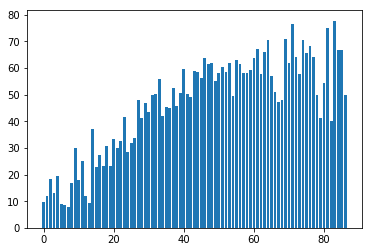

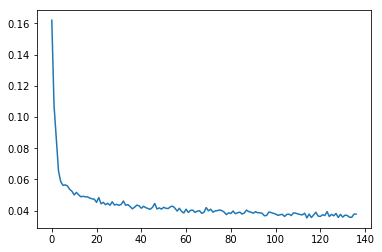

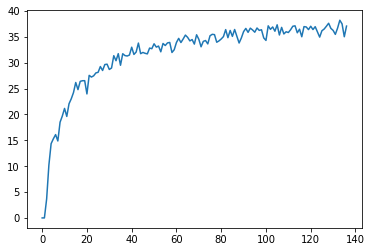

Train Epoch: 273 [0/65192 (0%)]	Loss: 0.036762
Train Epoch: 273 [6400/65192 (10%)]	Loss: 0.040567
Train Epoch: 273 [12800/65192 (20%)]	Loss: 0.042838
Train Epoch: 273 [19200/65192 (29%)]	Loss: 0.037471
Train Epoch: 273 [25600/65192 (39%)]	Loss: 0.033967
Train Epoch: 273 [32000/65192 (49%)]	Loss: 0.038841
Train Epoch: 273 [38400/65192 (59%)]	Loss: 0.036024
Train Epoch: 273 [44800/65192 (69%)]	Loss: 0.028110
Train Epoch: 273 [51200/65192 (79%)]	Loss: 0.035736
Train Epoch: 273 [57600/65192 (88%)]	Loss: 0.034598
Train Epoch: 273 [64000/65192 (98%)]	Loss: 0.045590
Train Epoch: 274 [0/65192 (0%)]	Loss: 0.033345
Train Epoch: 274 [6400/65192 (10%)]	Loss: 0.038785
Train Epoch: 274 [12800/65192 (20%)]	Loss: 0.040271
Train Epoch: 274 [19200/65192 (29%)]	Loss: 0.041556
Train Epoch: 274 [25600/65192 (39%)]	Loss: 0.034536
Train Epoch: 274 [32000/65192 (49%)]	Loss: 0.037018
Train Epoch: 274 [38400/65192 (59%)]	Loss: 0.035231
Train Epoch: 274 [44800/65192 (69%)]	Loss: 0.041140
Train Epoch: 274 [51200/

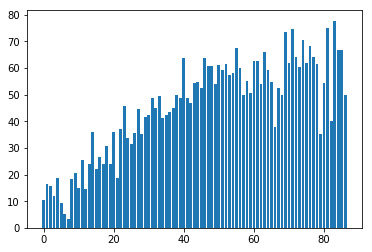

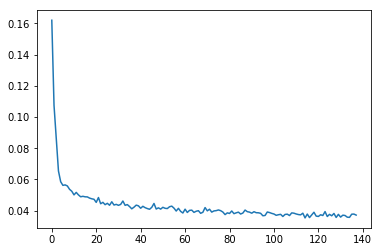

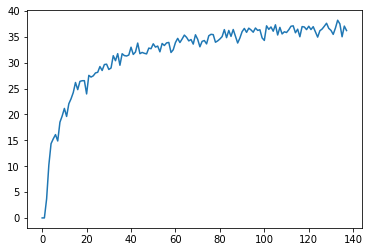

Train Epoch: 275 [0/65192 (0%)]	Loss: 0.028658
Train Epoch: 275 [6400/65192 (10%)]	Loss: 0.031662
Train Epoch: 275 [12800/65192 (20%)]	Loss: 0.039319
Train Epoch: 275 [19200/65192 (29%)]	Loss: 0.035266
Train Epoch: 275 [25600/65192 (39%)]	Loss: 0.043425
Train Epoch: 275 [32000/65192 (49%)]	Loss: 0.036012
Train Epoch: 275 [38400/65192 (59%)]	Loss: 0.039174
Train Epoch: 275 [44800/65192 (69%)]	Loss: 0.049190
Train Epoch: 275 [51200/65192 (79%)]	Loss: 0.029597
Train Epoch: 275 [57600/65192 (88%)]	Loss: 0.038538
Train Epoch: 275 [64000/65192 (98%)]	Loss: 0.041494
Train Epoch: 276 [0/65192 (0%)]	Loss: 0.025111
Train Epoch: 276 [6400/65192 (10%)]	Loss: 0.033845
Train Epoch: 276 [12800/65192 (20%)]	Loss: 0.037634
Train Epoch: 276 [19200/65192 (29%)]	Loss: 0.044418
Train Epoch: 276 [25600/65192 (39%)]	Loss: 0.036522
Train Epoch: 276 [32000/65192 (49%)]	Loss: 0.034137
Train Epoch: 276 [38400/65192 (59%)]	Loss: 0.038885
Train Epoch: 276 [44800/65192 (69%)]	Loss: 0.034469
Train Epoch: 276 [51200/

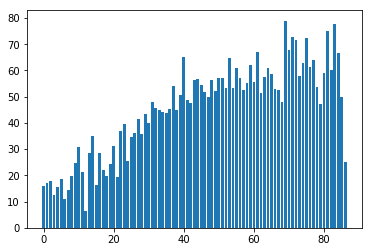

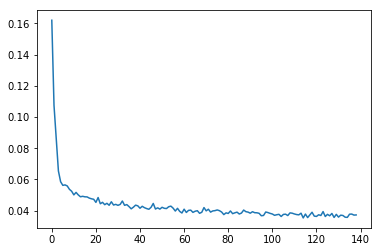

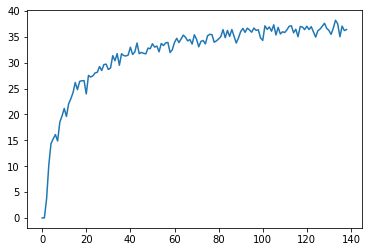

Train Epoch: 277 [0/65192 (0%)]	Loss: 0.040102
Train Epoch: 277 [6400/65192 (10%)]	Loss: 0.031073
Train Epoch: 277 [12800/65192 (20%)]	Loss: 0.036614
Train Epoch: 277 [19200/65192 (29%)]	Loss: 0.035500
Train Epoch: 277 [25600/65192 (39%)]	Loss: 0.041791
Train Epoch: 277 [32000/65192 (49%)]	Loss: 0.028228
Train Epoch: 277 [38400/65192 (59%)]	Loss: 0.029688
Train Epoch: 277 [44800/65192 (69%)]	Loss: 0.027262
Train Epoch: 277 [51200/65192 (79%)]	Loss: 0.033379
Train Epoch: 277 [57600/65192 (88%)]	Loss: 0.040167
Train Epoch: 277 [64000/65192 (98%)]	Loss: 0.041845
Train Epoch: 278 [0/65192 (0%)]	Loss: 0.031831
Train Epoch: 278 [6400/65192 (10%)]	Loss: 0.038189
Train Epoch: 278 [12800/65192 (20%)]	Loss: 0.035026
Train Epoch: 278 [19200/65192 (29%)]	Loss: 0.028729
Train Epoch: 278 [25600/65192 (39%)]	Loss: 0.031245
Train Epoch: 278 [32000/65192 (49%)]	Loss: 0.035939
Train Epoch: 278 [38400/65192 (59%)]	Loss: 0.030721
Train Epoch: 278 [44800/65192 (69%)]	Loss: 0.037745
Train Epoch: 278 [51200/

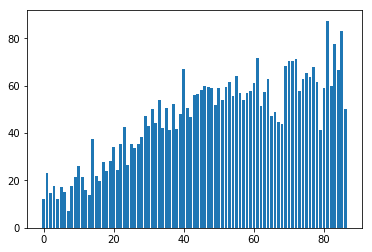

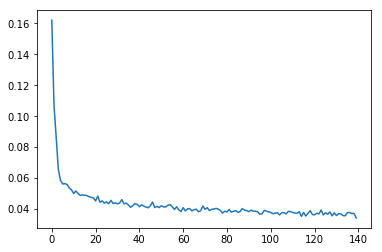

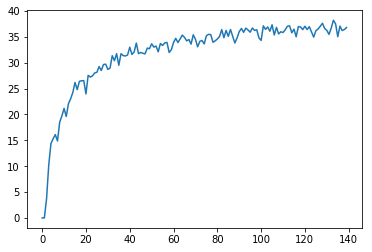

Train Epoch: 279 [0/65192 (0%)]	Loss: 0.038769
Train Epoch: 279 [6400/65192 (10%)]	Loss: 0.036552
Train Epoch: 279 [12800/65192 (20%)]	Loss: 0.035792
Train Epoch: 279 [19200/65192 (29%)]	Loss: 0.031057
Train Epoch: 279 [25600/65192 (39%)]	Loss: 0.031986
Train Epoch: 279 [32000/65192 (49%)]	Loss: 0.044431
Train Epoch: 279 [38400/65192 (59%)]	Loss: 0.023585
Train Epoch: 279 [44800/65192 (69%)]	Loss: 0.039046
Train Epoch: 279 [51200/65192 (79%)]	Loss: 0.034522
Train Epoch: 279 [57600/65192 (88%)]	Loss: 0.032970
Train Epoch: 279 [64000/65192 (98%)]	Loss: 0.030781
Train Epoch: 280 [0/65192 (0%)]	Loss: 0.039702
Train Epoch: 280 [6400/65192 (10%)]	Loss: 0.040666
Train Epoch: 280 [12800/65192 (20%)]	Loss: 0.038322
Train Epoch: 280 [19200/65192 (29%)]	Loss: 0.036937
Train Epoch: 280 [25600/65192 (39%)]	Loss: 0.034403
Train Epoch: 280 [32000/65192 (49%)]	Loss: 0.026230
Train Epoch: 280 [38400/65192 (59%)]	Loss: 0.039880
Train Epoch: 280 [44800/65192 (69%)]	Loss: 0.029379
Train Epoch: 280 [51200/

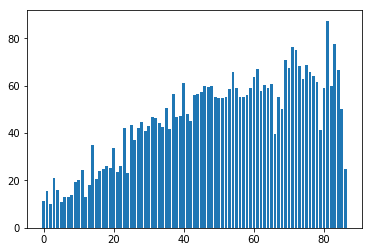

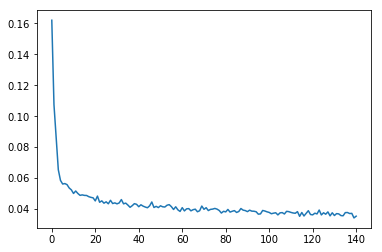

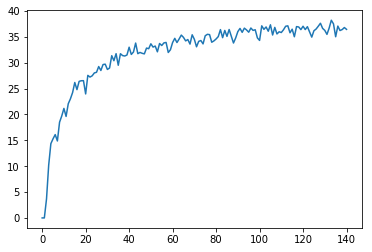

Train Epoch: 281 [0/65192 (0%)]	Loss: 0.039500
Train Epoch: 281 [6400/65192 (10%)]	Loss: 0.032311
Train Epoch: 281 [12800/65192 (20%)]	Loss: 0.042108
Train Epoch: 281 [19200/65192 (29%)]	Loss: 0.032911
Train Epoch: 281 [25600/65192 (39%)]	Loss: 0.038945
Train Epoch: 281 [32000/65192 (49%)]	Loss: 0.033832
Train Epoch: 281 [38400/65192 (59%)]	Loss: 0.030295
Train Epoch: 281 [44800/65192 (69%)]	Loss: 0.040502
Train Epoch: 281 [51200/65192 (79%)]	Loss: 0.032408
Train Epoch: 281 [57600/65192 (88%)]	Loss: 0.040994
Train Epoch: 281 [64000/65192 (98%)]	Loss: 0.031039
Train Epoch: 282 [0/65192 (0%)]	Loss: 0.030327
Train Epoch: 282 [6400/65192 (10%)]	Loss: 0.039877
Train Epoch: 282 [12800/65192 (20%)]	Loss: 0.040252
Train Epoch: 282 [19200/65192 (29%)]	Loss: 0.031689
Train Epoch: 282 [25600/65192 (39%)]	Loss: 0.030090
Train Epoch: 282 [32000/65192 (49%)]	Loss: 0.034659
Train Epoch: 282 [38400/65192 (59%)]	Loss: 0.037828
Train Epoch: 282 [44800/65192 (69%)]	Loss: 0.041745
Train Epoch: 282 [51200/

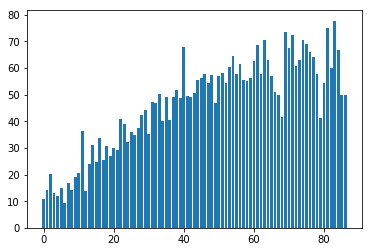

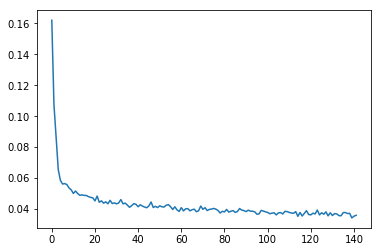

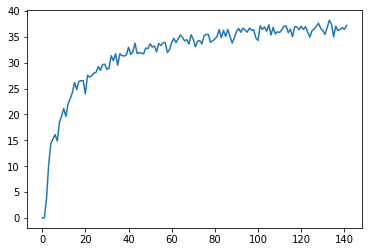

Train Epoch: 283 [0/65192 (0%)]	Loss: 0.036725
Train Epoch: 283 [6400/65192 (10%)]	Loss: 0.035454
Train Epoch: 283 [12800/65192 (20%)]	Loss: 0.023249
Train Epoch: 283 [19200/65192 (29%)]	Loss: 0.033243
Train Epoch: 283 [25600/65192 (39%)]	Loss: 0.033336
Train Epoch: 283 [32000/65192 (49%)]	Loss: 0.036398
Train Epoch: 283 [38400/65192 (59%)]	Loss: 0.036929
Train Epoch: 283 [44800/65192 (69%)]	Loss: 0.039614
Train Epoch: 283 [51200/65192 (79%)]	Loss: 0.029195
Train Epoch: 283 [57600/65192 (88%)]	Loss: 0.041117
Train Epoch: 283 [64000/65192 (98%)]	Loss: 0.033921
Train Epoch: 284 [0/65192 (0%)]	Loss: 0.030211
Train Epoch: 284 [6400/65192 (10%)]	Loss: 0.044774
Train Epoch: 284 [12800/65192 (20%)]	Loss: 0.042495
Train Epoch: 284 [19200/65192 (29%)]	Loss: 0.039232
Train Epoch: 284 [25600/65192 (39%)]	Loss: 0.033500
Train Epoch: 284 [32000/65192 (49%)]	Loss: 0.037636
Train Epoch: 284 [38400/65192 (59%)]	Loss: 0.026556
Train Epoch: 284 [44800/65192 (69%)]	Loss: 0.050321
Train Epoch: 284 [51200/

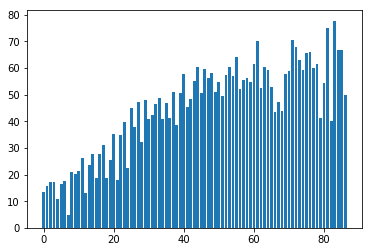

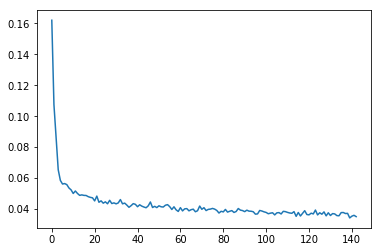

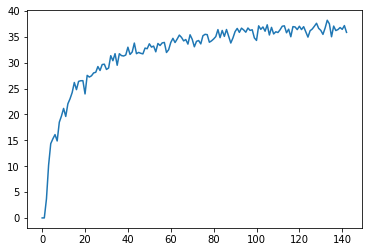

Train Epoch: 285 [0/65192 (0%)]	Loss: 0.042760
Train Epoch: 285 [6400/65192 (10%)]	Loss: 0.033818
Train Epoch: 285 [12800/65192 (20%)]	Loss: 0.036789
Train Epoch: 285 [19200/65192 (29%)]	Loss: 0.032406
Train Epoch: 285 [25600/65192 (39%)]	Loss: 0.030912
Train Epoch: 285 [32000/65192 (49%)]	Loss: 0.037639
Train Epoch: 285 [38400/65192 (59%)]	Loss: 0.047467
Train Epoch: 285 [44800/65192 (69%)]	Loss: 0.036987
Train Epoch: 285 [51200/65192 (79%)]	Loss: 0.034495
Train Epoch: 285 [57600/65192 (88%)]	Loss: 0.038635
Train Epoch: 285 [64000/65192 (98%)]	Loss: 0.043133
Train Epoch: 286 [0/65192 (0%)]	Loss: 0.036740
Train Epoch: 286 [6400/65192 (10%)]	Loss: 0.033822
Train Epoch: 286 [12800/65192 (20%)]	Loss: 0.043065
Train Epoch: 286 [19200/65192 (29%)]	Loss: 0.042616
Train Epoch: 286 [25600/65192 (39%)]	Loss: 0.041841
Train Epoch: 286 [32000/65192 (49%)]	Loss: 0.037000
Train Epoch: 286 [38400/65192 (59%)]	Loss: 0.042656
Train Epoch: 286 [44800/65192 (69%)]	Loss: 0.035893
Train Epoch: 286 [51200/

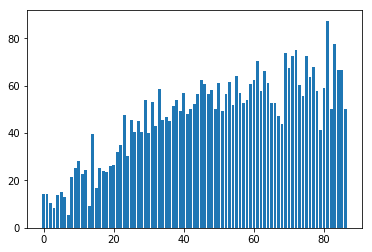

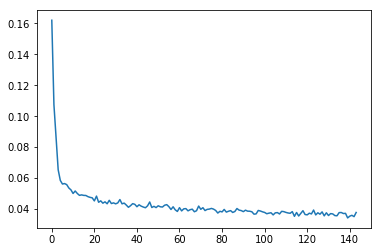

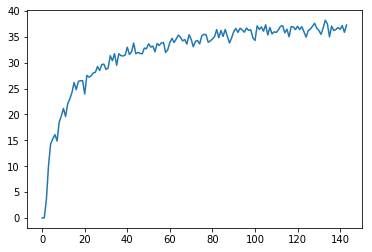

Train Epoch: 287 [0/65192 (0%)]	Loss: 0.037317
Train Epoch: 287 [6400/65192 (10%)]	Loss: 0.036903
Train Epoch: 287 [12800/65192 (20%)]	Loss: 0.043987
Train Epoch: 287 [19200/65192 (29%)]	Loss: 0.034348
Train Epoch: 287 [25600/65192 (39%)]	Loss: 0.034917
Train Epoch: 287 [32000/65192 (49%)]	Loss: 0.032843
Train Epoch: 287 [38400/65192 (59%)]	Loss: 0.038356
Train Epoch: 287 [44800/65192 (69%)]	Loss: 0.035485
Train Epoch: 287 [51200/65192 (79%)]	Loss: 0.032370
Train Epoch: 287 [57600/65192 (88%)]	Loss: 0.037619
Train Epoch: 287 [64000/65192 (98%)]	Loss: 0.038279
Train Epoch: 288 [0/65192 (0%)]	Loss: 0.027948
Train Epoch: 288 [6400/65192 (10%)]	Loss: 0.031149
Train Epoch: 288 [12800/65192 (20%)]	Loss: 0.032991
Train Epoch: 288 [19200/65192 (29%)]	Loss: 0.035967
Train Epoch: 288 [25600/65192 (39%)]	Loss: 0.033713
Train Epoch: 288 [32000/65192 (49%)]	Loss: 0.041506
Train Epoch: 288 [38400/65192 (59%)]	Loss: 0.035702
Train Epoch: 288 [44800/65192 (69%)]	Loss: 0.043393
Train Epoch: 288 [51200/

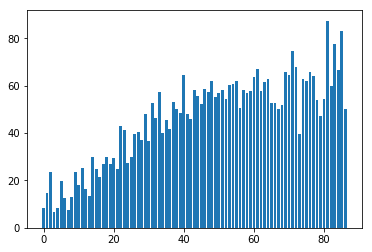

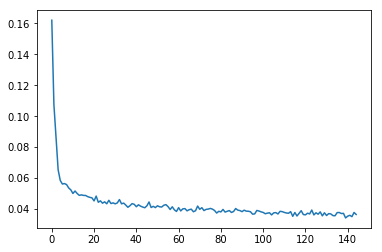

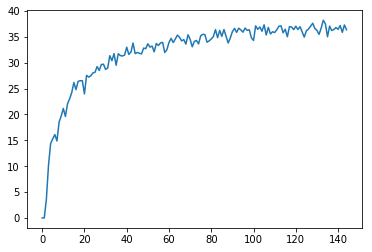

Train Epoch: 289 [0/65192 (0%)]	Loss: 0.035539
Train Epoch: 289 [6400/65192 (10%)]	Loss: 0.032319
Train Epoch: 289 [12800/65192 (20%)]	Loss: 0.039452
Train Epoch: 289 [19200/65192 (29%)]	Loss: 0.036403
Train Epoch: 289 [25600/65192 (39%)]	Loss: 0.028301
Train Epoch: 289 [32000/65192 (49%)]	Loss: 0.038873
Train Epoch: 289 [38400/65192 (59%)]	Loss: 0.045103
Train Epoch: 289 [44800/65192 (69%)]	Loss: 0.037891
Train Epoch: 289 [51200/65192 (79%)]	Loss: 0.031202
Train Epoch: 289 [57600/65192 (88%)]	Loss: 0.041402
Train Epoch: 289 [64000/65192 (98%)]	Loss: 0.040706
Train Epoch: 290 [0/65192 (0%)]	Loss: 0.035710
Train Epoch: 290 [6400/65192 (10%)]	Loss: 0.034661
Train Epoch: 290 [12800/65192 (20%)]	Loss: 0.036973
Train Epoch: 290 [19200/65192 (29%)]	Loss: 0.048340
Train Epoch: 290 [25600/65192 (39%)]	Loss: 0.033011
Train Epoch: 290 [32000/65192 (49%)]	Loss: 0.037537
Train Epoch: 290 [38400/65192 (59%)]	Loss: 0.031204
Train Epoch: 290 [44800/65192 (69%)]	Loss: 0.033173
Train Epoch: 290 [51200/

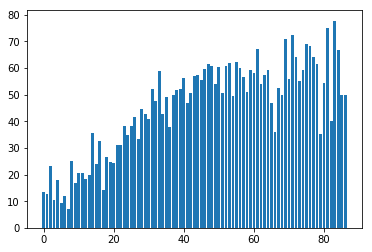

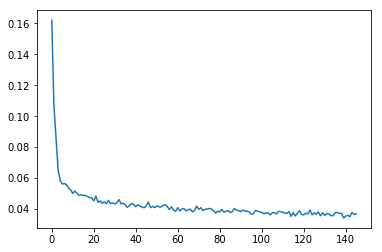

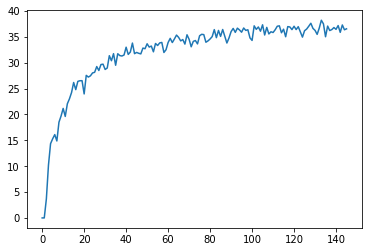

Train Epoch: 291 [0/65192 (0%)]	Loss: 0.037496
Train Epoch: 291 [6400/65192 (10%)]	Loss: 0.034758
Train Epoch: 291 [12800/65192 (20%)]	Loss: 0.045226
Train Epoch: 291 [19200/65192 (29%)]	Loss: 0.042802
Train Epoch: 291 [25600/65192 (39%)]	Loss: 0.024569
Train Epoch: 291 [32000/65192 (49%)]	Loss: 0.040592
Train Epoch: 291 [38400/65192 (59%)]	Loss: 0.038931
Train Epoch: 291 [44800/65192 (69%)]	Loss: 0.029949
Train Epoch: 291 [51200/65192 (79%)]	Loss: 0.038102
Train Epoch: 291 [57600/65192 (88%)]	Loss: 0.034310
Train Epoch: 291 [64000/65192 (98%)]	Loss: 0.031733
Train Epoch: 292 [0/65192 (0%)]	Loss: 0.038775
Train Epoch: 292 [6400/65192 (10%)]	Loss: 0.033912
Train Epoch: 292 [12800/65192 (20%)]	Loss: 0.044377
Train Epoch: 292 [19200/65192 (29%)]	Loss: 0.035151
Train Epoch: 292 [25600/65192 (39%)]	Loss: 0.033537
Train Epoch: 292 [32000/65192 (49%)]	Loss: 0.036980
Train Epoch: 292 [38400/65192 (59%)]	Loss: 0.026047
Train Epoch: 292 [44800/65192 (69%)]	Loss: 0.045623
Train Epoch: 292 [51200/

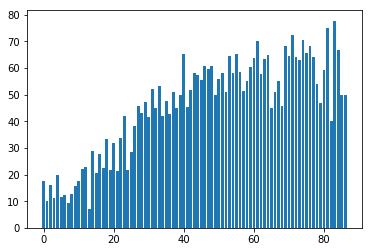

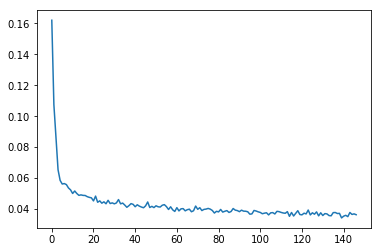

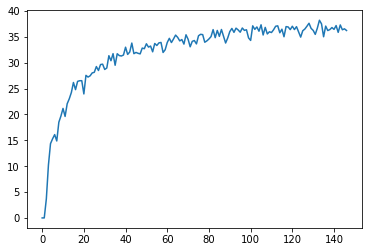

Train Epoch: 293 [0/65192 (0%)]	Loss: 0.038158
Train Epoch: 293 [6400/65192 (10%)]	Loss: 0.026560
Train Epoch: 293 [12800/65192 (20%)]	Loss: 0.041318
Train Epoch: 293 [19200/65192 (29%)]	Loss: 0.037156
Train Epoch: 293 [25600/65192 (39%)]	Loss: 0.036481
Train Epoch: 293 [32000/65192 (49%)]	Loss: 0.037074
Train Epoch: 293 [38400/65192 (59%)]	Loss: 0.034740
Train Epoch: 293 [44800/65192 (69%)]	Loss: 0.037708
Train Epoch: 293 [51200/65192 (79%)]	Loss: 0.038730
Train Epoch: 293 [57600/65192 (88%)]	Loss: 0.031357
Train Epoch: 293 [64000/65192 (98%)]	Loss: 0.038861
Train Epoch: 294 [0/65192 (0%)]	Loss: 0.042233
Train Epoch: 294 [6400/65192 (10%)]	Loss: 0.029958
Train Epoch: 294 [12800/65192 (20%)]	Loss: 0.034029
Train Epoch: 294 [19200/65192 (29%)]	Loss: 0.024278
Train Epoch: 294 [25600/65192 (39%)]	Loss: 0.031320
Train Epoch: 294 [32000/65192 (49%)]	Loss: 0.034443
Train Epoch: 294 [38400/65192 (59%)]	Loss: 0.044866
Train Epoch: 294 [44800/65192 (69%)]	Loss: 0.033143
Train Epoch: 294 [51200/

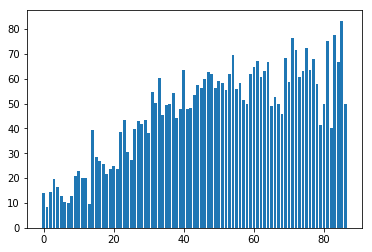

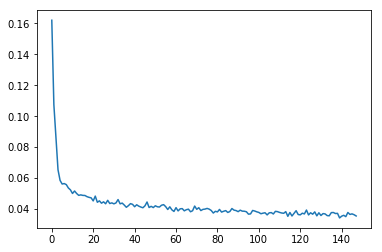

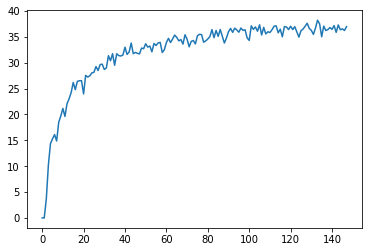

Train Epoch: 295 [0/65192 (0%)]	Loss: 0.034666
Train Epoch: 295 [6400/65192 (10%)]	Loss: 0.029397
Train Epoch: 295 [12800/65192 (20%)]	Loss: 0.042733
Train Epoch: 295 [19200/65192 (29%)]	Loss: 0.050423
Train Epoch: 295 [25600/65192 (39%)]	Loss: 0.030089
Train Epoch: 295 [32000/65192 (49%)]	Loss: 0.042881
Train Epoch: 295 [38400/65192 (59%)]	Loss: 0.043164
Train Epoch: 295 [44800/65192 (69%)]	Loss: 0.037882
Train Epoch: 295 [51200/65192 (79%)]	Loss: 0.032395
Train Epoch: 295 [57600/65192 (88%)]	Loss: 0.044562
Train Epoch: 295 [64000/65192 (98%)]	Loss: 0.043171
Train Epoch: 296 [0/65192 (0%)]	Loss: 0.031057
Train Epoch: 296 [6400/65192 (10%)]	Loss: 0.032172
Train Epoch: 296 [12800/65192 (20%)]	Loss: 0.032393
Train Epoch: 296 [19200/65192 (29%)]	Loss: 0.039214
Train Epoch: 296 [25600/65192 (39%)]	Loss: 0.042661
Train Epoch: 296 [32000/65192 (49%)]	Loss: 0.034871
Train Epoch: 296 [38400/65192 (59%)]	Loss: 0.033243
Train Epoch: 296 [44800/65192 (69%)]	Loss: 0.043908
Train Epoch: 296 [51200/

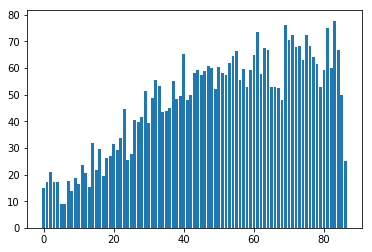

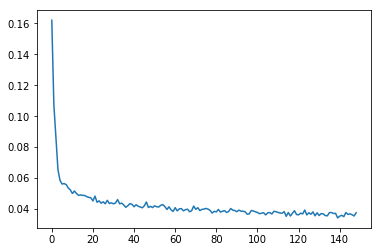

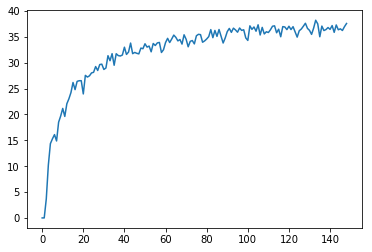

Train Epoch: 297 [0/65192 (0%)]	Loss: 0.030158
Train Epoch: 297 [6400/65192 (10%)]	Loss: 0.035111
Train Epoch: 297 [12800/65192 (20%)]	Loss: 0.038585
Train Epoch: 297 [19200/65192 (29%)]	Loss: 0.041392
Train Epoch: 297 [25600/65192 (39%)]	Loss: 0.037034
Train Epoch: 297 [32000/65192 (49%)]	Loss: 0.042045
Train Epoch: 297 [38400/65192 (59%)]	Loss: 0.036481
Train Epoch: 297 [44800/65192 (69%)]	Loss: 0.039424
Train Epoch: 297 [51200/65192 (79%)]	Loss: 0.036879
Train Epoch: 297 [57600/65192 (88%)]	Loss: 0.039648
Train Epoch: 297 [64000/65192 (98%)]	Loss: 0.030717
Train Epoch: 298 [0/65192 (0%)]	Loss: 0.032358
Train Epoch: 298 [6400/65192 (10%)]	Loss: 0.042519
Train Epoch: 298 [12800/65192 (20%)]	Loss: 0.030904
Train Epoch: 298 [19200/65192 (29%)]	Loss: 0.031173
Train Epoch: 298 [25600/65192 (39%)]	Loss: 0.042847
Train Epoch: 298 [32000/65192 (49%)]	Loss: 0.044238
Train Epoch: 298 [38400/65192 (59%)]	Loss: 0.030132
Train Epoch: 298 [44800/65192 (69%)]	Loss: 0.030339
Train Epoch: 298 [51200/

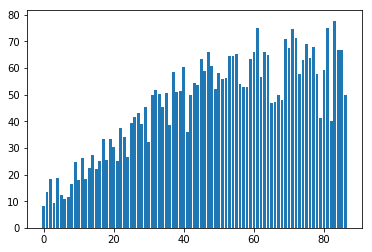

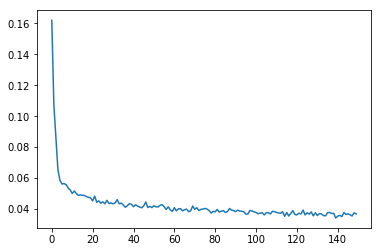

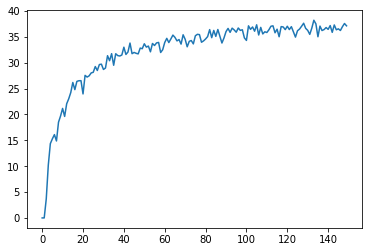

Train Epoch: 299 [0/65192 (0%)]	Loss: 0.038197
Train Epoch: 299 [6400/65192 (10%)]	Loss: 0.030216
Train Epoch: 299 [12800/65192 (20%)]	Loss: 0.031877
Train Epoch: 299 [19200/65192 (29%)]	Loss: 0.033757
Train Epoch: 299 [25600/65192 (39%)]	Loss: 0.034454
Train Epoch: 299 [32000/65192 (49%)]	Loss: 0.031609
Train Epoch: 299 [38400/65192 (59%)]	Loss: 0.036389
Train Epoch: 299 [44800/65192 (69%)]	Loss: 0.028319
Train Epoch: 299 [51200/65192 (79%)]	Loss: 0.037911
Train Epoch: 299 [57600/65192 (88%)]	Loss: 0.031942
Train Epoch: 299 [64000/65192 (98%)]	Loss: 0.037137
Train Epoch: 300 [0/65192 (0%)]	Loss: 0.034551
Train Epoch: 300 [6400/65192 (10%)]	Loss: 0.032356
Train Epoch: 300 [12800/65192 (20%)]	Loss: 0.030655
Train Epoch: 300 [19200/65192 (29%)]	Loss: 0.036871
Train Epoch: 300 [25600/65192 (39%)]	Loss: 0.034148
Train Epoch: 300 [32000/65192 (49%)]	Loss: 0.029418
Train Epoch: 300 [38400/65192 (59%)]	Loss: 0.037948
Train Epoch: 300 [44800/65192 (69%)]	Loss: 0.027196
Train Epoch: 300 [51200/

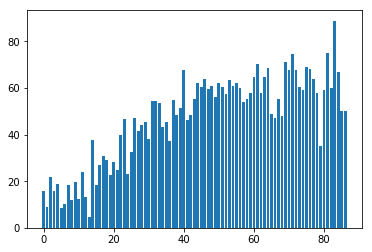

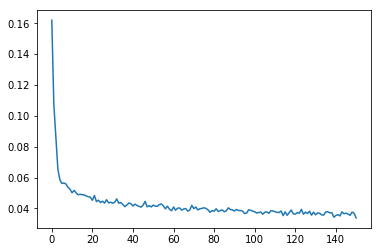

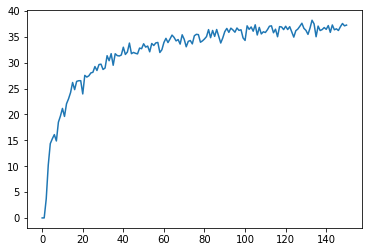

Train Epoch: 301 [0/65192 (0%)]	Loss: 0.031659
Train Epoch: 301 [6400/65192 (10%)]	Loss: 0.033982
Train Epoch: 301 [12800/65192 (20%)]	Loss: 0.033061
Train Epoch: 301 [19200/65192 (29%)]	Loss: 0.031393
Train Epoch: 301 [25600/65192 (39%)]	Loss: 0.034829
Train Epoch: 301 [32000/65192 (49%)]	Loss: 0.033032
Train Epoch: 301 [38400/65192 (59%)]	Loss: 0.028177
Train Epoch: 301 [44800/65192 (69%)]	Loss: 0.029188
Train Epoch: 301 [51200/65192 (79%)]	Loss: 0.046989
Train Epoch: 301 [57600/65192 (88%)]	Loss: 0.030275
Train Epoch: 301 [64000/65192 (98%)]	Loss: 0.036397
Train Epoch: 302 [0/65192 (0%)]	Loss: 0.035339
Train Epoch: 302 [6400/65192 (10%)]	Loss: 0.040574
Train Epoch: 302 [12800/65192 (20%)]	Loss: 0.032548
Train Epoch: 302 [19200/65192 (29%)]	Loss: 0.042060
Train Epoch: 302 [25600/65192 (39%)]	Loss: 0.035507
Train Epoch: 302 [32000/65192 (49%)]	Loss: 0.031110
Train Epoch: 302 [38400/65192 (59%)]	Loss: 0.037692
Train Epoch: 302 [44800/65192 (69%)]	Loss: 0.034352
Train Epoch: 302 [51200/

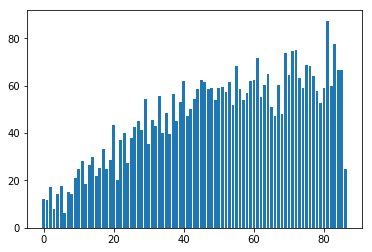

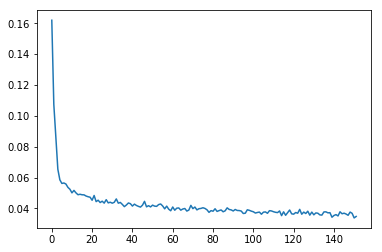

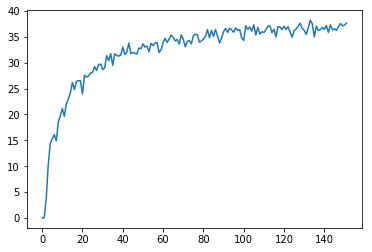

Train Epoch: 303 [0/65192 (0%)]	Loss: 0.041767
Train Epoch: 303 [6400/65192 (10%)]	Loss: 0.043232
Train Epoch: 303 [12800/65192 (20%)]	Loss: 0.029044
Train Epoch: 303 [19200/65192 (29%)]	Loss: 0.038129
Train Epoch: 303 [25600/65192 (39%)]	Loss: 0.043734
Train Epoch: 303 [32000/65192 (49%)]	Loss: 0.032674
Train Epoch: 303 [38400/65192 (59%)]	Loss: 0.036197
Train Epoch: 303 [44800/65192 (69%)]	Loss: 0.040227
Train Epoch: 303 [51200/65192 (79%)]	Loss: 0.035210
Train Epoch: 303 [57600/65192 (88%)]	Loss: 0.036811
Train Epoch: 303 [64000/65192 (98%)]	Loss: 0.035868
Train Epoch: 304 [0/65192 (0%)]	Loss: 0.029963
Train Epoch: 304 [6400/65192 (10%)]	Loss: 0.038689
Train Epoch: 304 [12800/65192 (20%)]	Loss: 0.039655
Train Epoch: 304 [19200/65192 (29%)]	Loss: 0.026328
Train Epoch: 304 [25600/65192 (39%)]	Loss: 0.030231
Train Epoch: 304 [32000/65192 (49%)]	Loss: 0.036013
Train Epoch: 304 [38400/65192 (59%)]	Loss: 0.036007
Train Epoch: 304 [44800/65192 (69%)]	Loss: 0.027814
Train Epoch: 304 [51200/

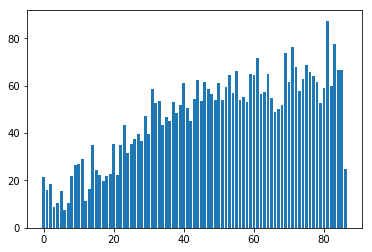

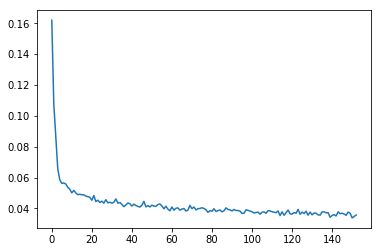

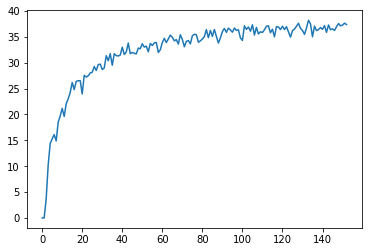

Train Epoch: 305 [0/65192 (0%)]	Loss: 0.044019
Train Epoch: 305 [6400/65192 (10%)]	Loss: 0.028259
Train Epoch: 305 [12800/65192 (20%)]	Loss: 0.036643
Train Epoch: 305 [19200/65192 (29%)]	Loss: 0.037638
Train Epoch: 305 [25600/65192 (39%)]	Loss: 0.038881
Train Epoch: 305 [32000/65192 (49%)]	Loss: 0.026051
Train Epoch: 305 [38400/65192 (59%)]	Loss: 0.034071
Train Epoch: 305 [44800/65192 (69%)]	Loss: 0.037064
Train Epoch: 305 [51200/65192 (79%)]	Loss: 0.042219
Train Epoch: 305 [57600/65192 (88%)]	Loss: 0.045022
Train Epoch: 305 [64000/65192 (98%)]	Loss: 0.036140
Train Epoch: 306 [0/65192 (0%)]	Loss: 0.032051
Train Epoch: 306 [6400/65192 (10%)]	Loss: 0.038050
Train Epoch: 306 [12800/65192 (20%)]	Loss: 0.036087
Train Epoch: 306 [19200/65192 (29%)]	Loss: 0.039230
Train Epoch: 306 [25600/65192 (39%)]	Loss: 0.032311
Train Epoch: 306 [32000/65192 (49%)]	Loss: 0.031347
Train Epoch: 306 [38400/65192 (59%)]	Loss: 0.034591
Train Epoch: 306 [44800/65192 (69%)]	Loss: 0.033677
Train Epoch: 306 [51200/

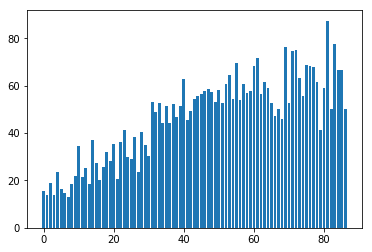

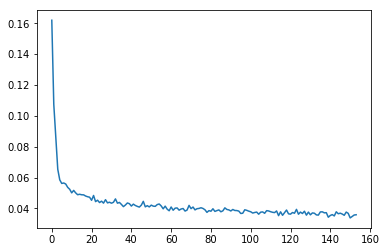

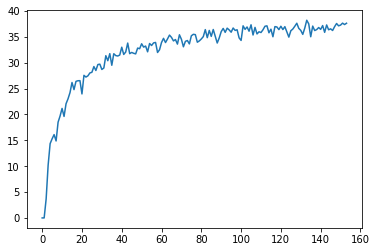

Train Epoch: 307 [0/65192 (0%)]	Loss: 0.034895
Train Epoch: 307 [6400/65192 (10%)]	Loss: 0.033123
Train Epoch: 307 [12800/65192 (20%)]	Loss: 0.037546
Train Epoch: 307 [19200/65192 (29%)]	Loss: 0.029002
Train Epoch: 307 [25600/65192 (39%)]	Loss: 0.033214
Train Epoch: 307 [32000/65192 (49%)]	Loss: 0.024578
Train Epoch: 307 [38400/65192 (59%)]	Loss: 0.041559
Train Epoch: 307 [44800/65192 (69%)]	Loss: 0.034241
Train Epoch: 307 [51200/65192 (79%)]	Loss: 0.036812
Train Epoch: 307 [57600/65192 (88%)]	Loss: 0.038837
Train Epoch: 307 [64000/65192 (98%)]	Loss: 0.032223
Train Epoch: 308 [0/65192 (0%)]	Loss: 0.046911
Train Epoch: 308 [6400/65192 (10%)]	Loss: 0.032329
Train Epoch: 308 [12800/65192 (20%)]	Loss: 0.026373
Train Epoch: 308 [19200/65192 (29%)]	Loss: 0.038792
Train Epoch: 308 [25600/65192 (39%)]	Loss: 0.046686
Train Epoch: 308 [32000/65192 (49%)]	Loss: 0.046276
Train Epoch: 308 [38400/65192 (59%)]	Loss: 0.025655
Train Epoch: 308 [44800/65192 (69%)]	Loss: 0.036584
Train Epoch: 308 [51200/

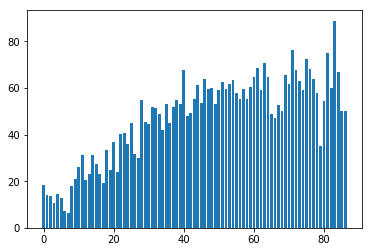

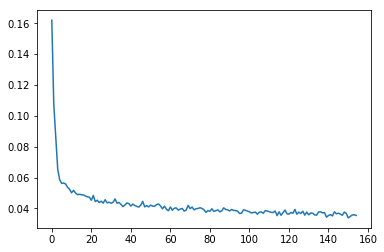

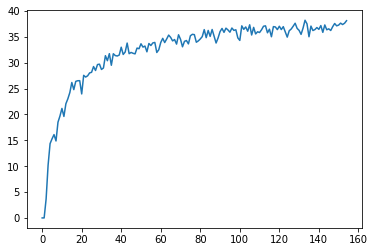

Train Epoch: 309 [0/65192 (0%)]	Loss: 0.034309
Train Epoch: 309 [6400/65192 (10%)]	Loss: 0.034815
Train Epoch: 309 [12800/65192 (20%)]	Loss: 0.038870
Train Epoch: 309 [19200/65192 (29%)]	Loss: 0.045919
Train Epoch: 309 [25600/65192 (39%)]	Loss: 0.040988
Train Epoch: 309 [32000/65192 (49%)]	Loss: 0.032330
Train Epoch: 309 [38400/65192 (59%)]	Loss: 0.033467
Train Epoch: 309 [44800/65192 (69%)]	Loss: 0.026892
Train Epoch: 309 [51200/65192 (79%)]	Loss: 0.046884
Train Epoch: 309 [57600/65192 (88%)]	Loss: 0.036472
Train Epoch: 309 [64000/65192 (98%)]	Loss: 0.040336
Train Epoch: 310 [0/65192 (0%)]	Loss: 0.028313
Train Epoch: 310 [6400/65192 (10%)]	Loss: 0.027894
Train Epoch: 310 [12800/65192 (20%)]	Loss: 0.035423
Train Epoch: 310 [19200/65192 (29%)]	Loss: 0.037511
Train Epoch: 310 [25600/65192 (39%)]	Loss: 0.037454
Train Epoch: 310 [32000/65192 (49%)]	Loss: 0.037198
Train Epoch: 310 [38400/65192 (59%)]	Loss: 0.032618
Train Epoch: 310 [44800/65192 (69%)]	Loss: 0.030398
Train Epoch: 310 [51200/

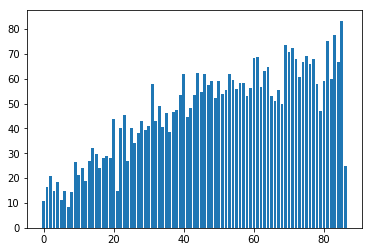

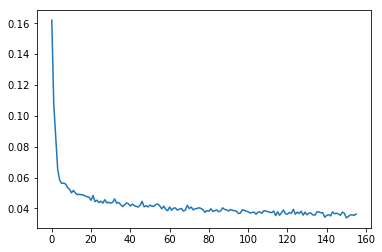

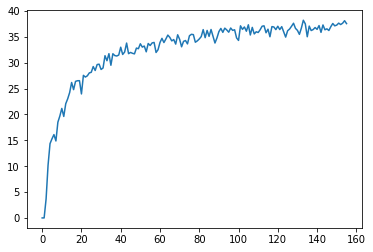

Train Epoch: 311 [0/65192 (0%)]	Loss: 0.038114
Train Epoch: 311 [6400/65192 (10%)]	Loss: 0.037495
Train Epoch: 311 [12800/65192 (20%)]	Loss: 0.037964
Train Epoch: 311 [19200/65192 (29%)]	Loss: 0.037171
Train Epoch: 311 [25600/65192 (39%)]	Loss: 0.033741
Train Epoch: 311 [32000/65192 (49%)]	Loss: 0.041371
Train Epoch: 311 [38400/65192 (59%)]	Loss: 0.035214
Train Epoch: 311 [44800/65192 (69%)]	Loss: 0.033787
Train Epoch: 311 [51200/65192 (79%)]	Loss: 0.037820
Train Epoch: 311 [57600/65192 (88%)]	Loss: 0.040841
Train Epoch: 311 [64000/65192 (98%)]	Loss: 0.038575
Train Epoch: 312 [0/65192 (0%)]	Loss: 0.042393
Train Epoch: 312 [6400/65192 (10%)]	Loss: 0.035301
Train Epoch: 312 [12800/65192 (20%)]	Loss: 0.037496
Train Epoch: 312 [19200/65192 (29%)]	Loss: 0.034967
Train Epoch: 312 [25600/65192 (39%)]	Loss: 0.035103
Train Epoch: 312 [32000/65192 (49%)]	Loss: 0.040147
Train Epoch: 312 [38400/65192 (59%)]	Loss: 0.037862
Train Epoch: 312 [44800/65192 (69%)]	Loss: 0.040278
Train Epoch: 312 [51200/

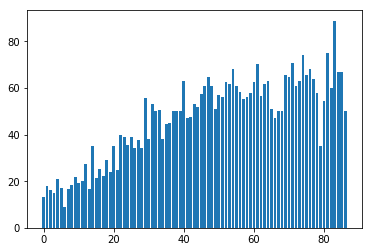

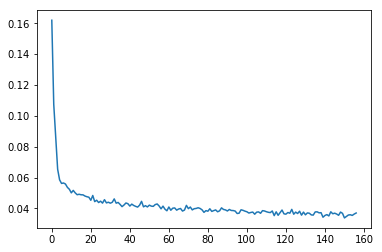

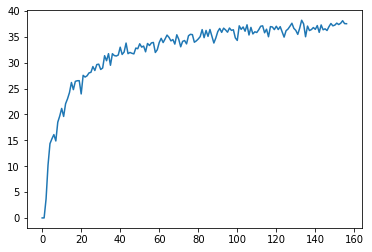

Train Epoch: 313 [0/65192 (0%)]	Loss: 0.029921
Train Epoch: 313 [6400/65192 (10%)]	Loss: 0.040640
Train Epoch: 313 [12800/65192 (20%)]	Loss: 0.038141
Train Epoch: 313 [19200/65192 (29%)]	Loss: 0.034874
Train Epoch: 313 [25600/65192 (39%)]	Loss: 0.042544
Train Epoch: 313 [32000/65192 (49%)]	Loss: 0.037495
Train Epoch: 313 [38400/65192 (59%)]	Loss: 0.040864
Train Epoch: 313 [44800/65192 (69%)]	Loss: 0.041361
Train Epoch: 313 [51200/65192 (79%)]	Loss: 0.040507
Train Epoch: 313 [57600/65192 (88%)]	Loss: 0.036510
Train Epoch: 313 [64000/65192 (98%)]	Loss: 0.039596
Train Epoch: 314 [0/65192 (0%)]	Loss: 0.033099
Train Epoch: 314 [6400/65192 (10%)]	Loss: 0.041886
Train Epoch: 314 [12800/65192 (20%)]	Loss: 0.039480
Train Epoch: 314 [19200/65192 (29%)]	Loss: 0.031124
Train Epoch: 314 [25600/65192 (39%)]	Loss: 0.036376
Train Epoch: 314 [32000/65192 (49%)]	Loss: 0.033002
Train Epoch: 314 [38400/65192 (59%)]	Loss: 0.035588
Train Epoch: 314 [44800/65192 (69%)]	Loss: 0.030232
Train Epoch: 314 [51200/

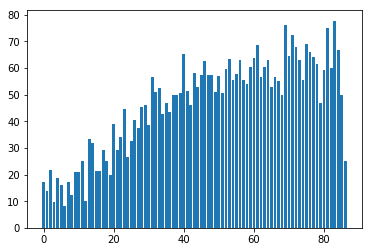

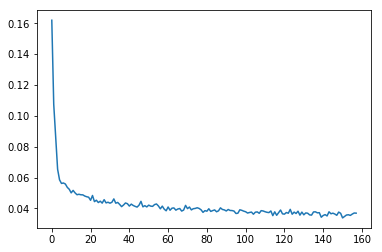

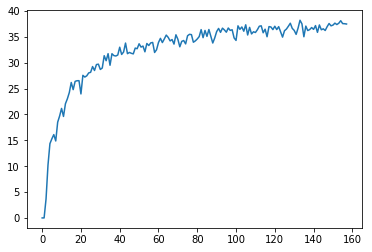

Train Epoch: 315 [0/65192 (0%)]	Loss: 0.031592
Train Epoch: 315 [6400/65192 (10%)]	Loss: 0.037985
Train Epoch: 315 [12800/65192 (20%)]	Loss: 0.034266
Train Epoch: 315 [19200/65192 (29%)]	Loss: 0.033672
Train Epoch: 315 [25600/65192 (39%)]	Loss: 0.043109
Train Epoch: 315 [32000/65192 (49%)]	Loss: 0.047252
Train Epoch: 315 [38400/65192 (59%)]	Loss: 0.027396
Train Epoch: 315 [44800/65192 (69%)]	Loss: 0.032475
Train Epoch: 315 [51200/65192 (79%)]	Loss: 0.039924
Train Epoch: 315 [57600/65192 (88%)]	Loss: 0.037846
Train Epoch: 315 [64000/65192 (98%)]	Loss: 0.038883
Train Epoch: 316 [0/65192 (0%)]	Loss: 0.036225
Train Epoch: 316 [6400/65192 (10%)]	Loss: 0.036474
Train Epoch: 316 [12800/65192 (20%)]	Loss: 0.034461
Train Epoch: 316 [19200/65192 (29%)]	Loss: 0.028338
Train Epoch: 316 [25600/65192 (39%)]	Loss: 0.033253
Train Epoch: 316 [32000/65192 (49%)]	Loss: 0.030532
Train Epoch: 316 [38400/65192 (59%)]	Loss: 0.040084
Train Epoch: 316 [44800/65192 (69%)]	Loss: 0.027972
Train Epoch: 316 [51200/

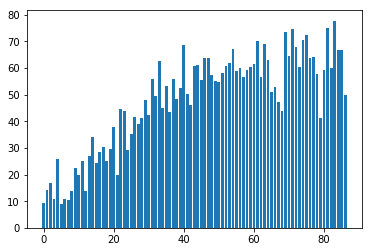

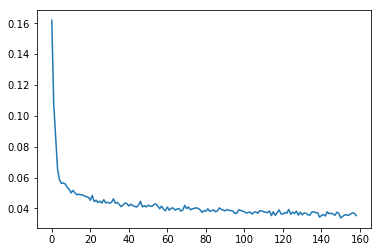

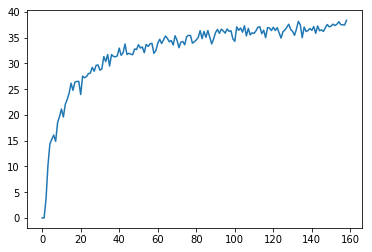

Train Epoch: 317 [0/65192 (0%)]	Loss: 0.033359
Train Epoch: 317 [6400/65192 (10%)]	Loss: 0.033691
Train Epoch: 317 [12800/65192 (20%)]	Loss: 0.028229
Train Epoch: 317 [19200/65192 (29%)]	Loss: 0.037351
Train Epoch: 317 [25600/65192 (39%)]	Loss: 0.032805
Train Epoch: 317 [32000/65192 (49%)]	Loss: 0.031794
Train Epoch: 317 [38400/65192 (59%)]	Loss: 0.040935
Train Epoch: 317 [44800/65192 (69%)]	Loss: 0.032049
Train Epoch: 317 [51200/65192 (79%)]	Loss: 0.033162
Train Epoch: 317 [57600/65192 (88%)]	Loss: 0.031152
Train Epoch: 317 [64000/65192 (98%)]	Loss: 0.040886
Train Epoch: 318 [0/65192 (0%)]	Loss: 0.041651
Train Epoch: 318 [6400/65192 (10%)]	Loss: 0.040720
Train Epoch: 318 [12800/65192 (20%)]	Loss: 0.034251
Train Epoch: 318 [19200/65192 (29%)]	Loss: 0.034258
Train Epoch: 318 [25600/65192 (39%)]	Loss: 0.043893
Train Epoch: 318 [32000/65192 (49%)]	Loss: 0.031582
Train Epoch: 318 [38400/65192 (59%)]	Loss: 0.030922
Train Epoch: 318 [44800/65192 (69%)]	Loss: 0.038651
Train Epoch: 318 [51200/

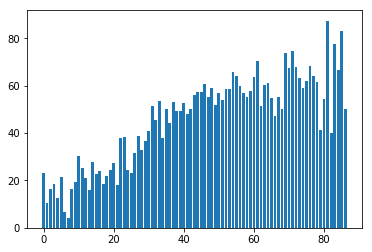

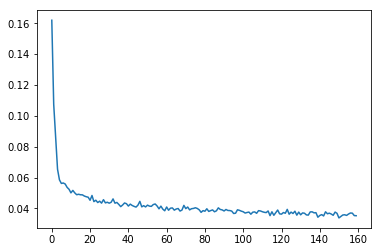

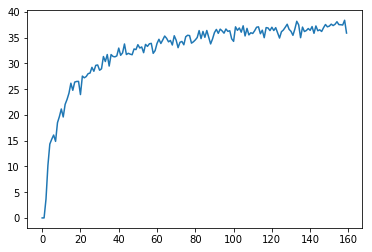

Train Epoch: 319 [0/65192 (0%)]	Loss: 0.031044
Train Epoch: 319 [6400/65192 (10%)]	Loss: 0.044451
Train Epoch: 319 [12800/65192 (20%)]	Loss: 0.031642
Train Epoch: 319 [19200/65192 (29%)]	Loss: 0.032024
Train Epoch: 319 [25600/65192 (39%)]	Loss: 0.036666
Train Epoch: 319 [32000/65192 (49%)]	Loss: 0.042053
Train Epoch: 319 [38400/65192 (59%)]	Loss: 0.035054
Train Epoch: 319 [44800/65192 (69%)]	Loss: 0.035563
Train Epoch: 319 [51200/65192 (79%)]	Loss: 0.038167
Train Epoch: 319 [57600/65192 (88%)]	Loss: 0.033653
Train Epoch: 319 [64000/65192 (98%)]	Loss: 0.040749
Train Epoch: 320 [0/65192 (0%)]	Loss: 0.033574
Train Epoch: 320 [6400/65192 (10%)]	Loss: 0.038289
Train Epoch: 320 [12800/65192 (20%)]	Loss: 0.029280
Train Epoch: 320 [19200/65192 (29%)]	Loss: 0.036352
Train Epoch: 320 [25600/65192 (39%)]	Loss: 0.036629
Train Epoch: 320 [32000/65192 (49%)]	Loss: 0.038694
Train Epoch: 320 [38400/65192 (59%)]	Loss: 0.032831
Train Epoch: 320 [44800/65192 (69%)]	Loss: 0.034418
Train Epoch: 320 [51200/

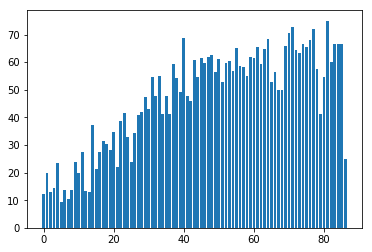

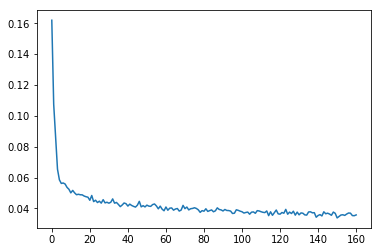

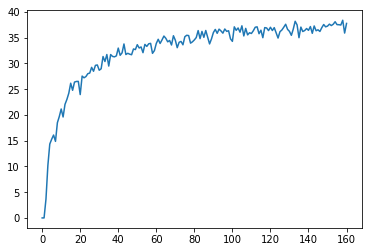

Train Epoch: 321 [0/65192 (0%)]	Loss: 0.031214
Train Epoch: 321 [6400/65192 (10%)]	Loss: 0.033795
Train Epoch: 321 [12800/65192 (20%)]	Loss: 0.038669
Train Epoch: 321 [19200/65192 (29%)]	Loss: 0.023128
Train Epoch: 321 [25600/65192 (39%)]	Loss: 0.032641
Train Epoch: 321 [32000/65192 (49%)]	Loss: 0.032500
Train Epoch: 321 [38400/65192 (59%)]	Loss: 0.032352
Train Epoch: 321 [44800/65192 (69%)]	Loss: 0.048472
Train Epoch: 321 [51200/65192 (79%)]	Loss: 0.036920
Train Epoch: 321 [57600/65192 (88%)]	Loss: 0.040544
Train Epoch: 321 [64000/65192 (98%)]	Loss: 0.038780
Train Epoch: 322 [0/65192 (0%)]	Loss: 0.034004
Train Epoch: 322 [6400/65192 (10%)]	Loss: 0.033331
Train Epoch: 322 [12800/65192 (20%)]	Loss: 0.037440
Train Epoch: 322 [19200/65192 (29%)]	Loss: 0.038450
Train Epoch: 322 [25600/65192 (39%)]	Loss: 0.038774
Train Epoch: 322 [32000/65192 (49%)]	Loss: 0.032000
Train Epoch: 322 [38400/65192 (59%)]	Loss: 0.038765
Train Epoch: 322 [44800/65192 (69%)]	Loss: 0.025676
Train Epoch: 322 [51200/

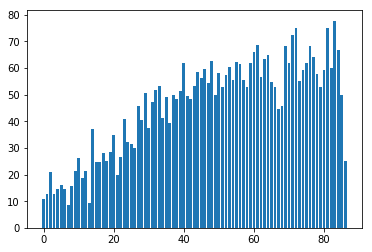

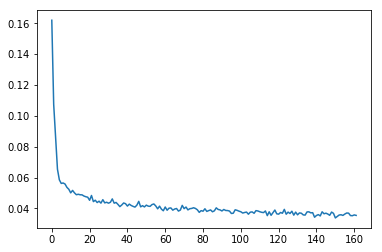

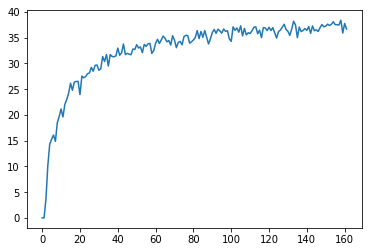

Train Epoch: 323 [0/65192 (0%)]	Loss: 0.044568
Train Epoch: 323 [6400/65192 (10%)]	Loss: 0.030205
Train Epoch: 323 [12800/65192 (20%)]	Loss: 0.041404
Train Epoch: 323 [19200/65192 (29%)]	Loss: 0.031139
Train Epoch: 323 [25600/65192 (39%)]	Loss: 0.046353
Train Epoch: 323 [32000/65192 (49%)]	Loss: 0.032545
Train Epoch: 323 [38400/65192 (59%)]	Loss: 0.034487
Train Epoch: 323 [44800/65192 (69%)]	Loss: 0.029463
Train Epoch: 323 [51200/65192 (79%)]	Loss: 0.038436
Train Epoch: 323 [57600/65192 (88%)]	Loss: 0.041495
Train Epoch: 323 [64000/65192 (98%)]	Loss: 0.036575
Train Epoch: 324 [0/65192 (0%)]	Loss: 0.043063
Train Epoch: 324 [6400/65192 (10%)]	Loss: 0.040732
Train Epoch: 324 [12800/65192 (20%)]	Loss: 0.038844
Train Epoch: 324 [19200/65192 (29%)]	Loss: 0.034697
Train Epoch: 324 [25600/65192 (39%)]	Loss: 0.031928
Train Epoch: 324 [32000/65192 (49%)]	Loss: 0.033580
Train Epoch: 324 [38400/65192 (59%)]	Loss: 0.025983
Train Epoch: 324 [44800/65192 (69%)]	Loss: 0.034975
Train Epoch: 324 [51200/

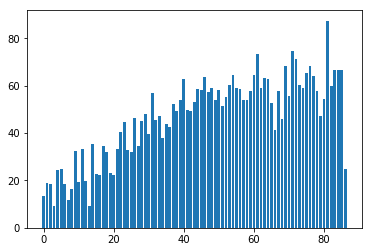

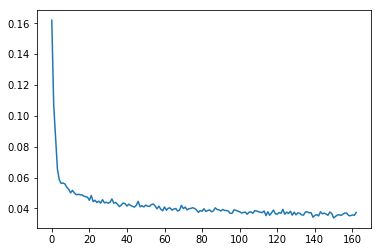

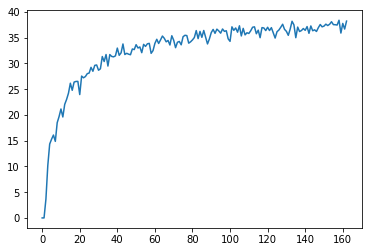

Train Epoch: 325 [0/65192 (0%)]	Loss: 0.030358
Train Epoch: 325 [6400/65192 (10%)]	Loss: 0.042262
Train Epoch: 325 [12800/65192 (20%)]	Loss: 0.036979
Train Epoch: 325 [19200/65192 (29%)]	Loss: 0.035843
Train Epoch: 325 [25600/65192 (39%)]	Loss: 0.035686
Train Epoch: 325 [32000/65192 (49%)]	Loss: 0.031706
Train Epoch: 325 [38400/65192 (59%)]	Loss: 0.023540
Train Epoch: 325 [44800/65192 (69%)]	Loss: 0.039409
Train Epoch: 325 [51200/65192 (79%)]	Loss: 0.033703
Train Epoch: 325 [57600/65192 (88%)]	Loss: 0.035325
Train Epoch: 325 [64000/65192 (98%)]	Loss: 0.041496
Train Epoch: 326 [0/65192 (0%)]	Loss: 0.034858
Train Epoch: 326 [6400/65192 (10%)]	Loss: 0.038689
Train Epoch: 326 [12800/65192 (20%)]	Loss: 0.035489
Train Epoch: 326 [19200/65192 (29%)]	Loss: 0.039619
Train Epoch: 326 [25600/65192 (39%)]	Loss: 0.038820
Train Epoch: 326 [32000/65192 (49%)]	Loss: 0.034143
Train Epoch: 326 [38400/65192 (59%)]	Loss: 0.035521
Train Epoch: 326 [44800/65192 (69%)]	Loss: 0.036758
Train Epoch: 326 [51200/

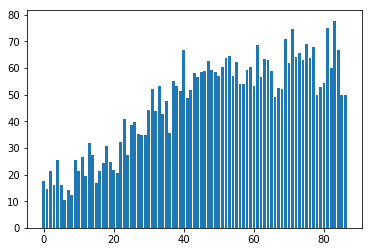

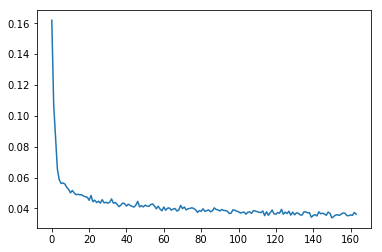

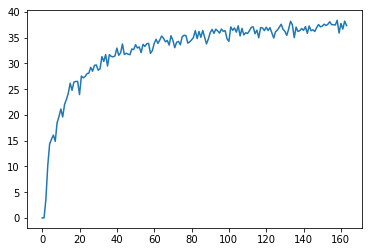

Train Epoch: 327 [0/65192 (0%)]	Loss: 0.026627
Train Epoch: 327 [6400/65192 (10%)]	Loss: 0.037814
Train Epoch: 327 [12800/65192 (20%)]	Loss: 0.039258
Train Epoch: 327 [19200/65192 (29%)]	Loss: 0.036589
Train Epoch: 327 [25600/65192 (39%)]	Loss: 0.023406
Train Epoch: 327 [32000/65192 (49%)]	Loss: 0.044105
Train Epoch: 327 [38400/65192 (59%)]	Loss: 0.035128
Train Epoch: 327 [44800/65192 (69%)]	Loss: 0.035721
Train Epoch: 327 [51200/65192 (79%)]	Loss: 0.031111
Train Epoch: 327 [57600/65192 (88%)]	Loss: 0.029277
Train Epoch: 327 [64000/65192 (98%)]	Loss: 0.032836
Train Epoch: 328 [0/65192 (0%)]	Loss: 0.035950
Train Epoch: 328 [6400/65192 (10%)]	Loss: 0.047642
Train Epoch: 328 [12800/65192 (20%)]	Loss: 0.032856
Train Epoch: 328 [19200/65192 (29%)]	Loss: 0.044902
Train Epoch: 328 [25600/65192 (39%)]	Loss: 0.034116
Train Epoch: 328 [32000/65192 (49%)]	Loss: 0.026657
Train Epoch: 328 [38400/65192 (59%)]	Loss: 0.032821
Train Epoch: 328 [44800/65192 (69%)]	Loss: 0.030083
Train Epoch: 328 [51200/

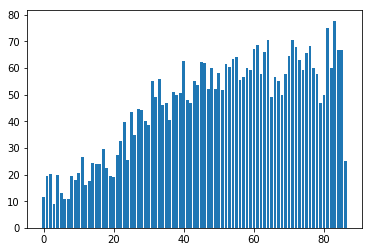

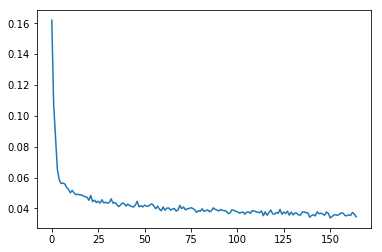

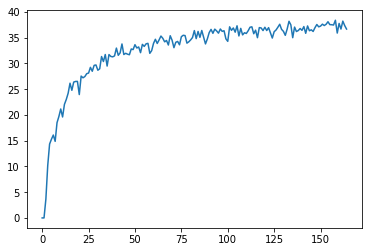

Train Epoch: 329 [0/65192 (0%)]	Loss: 0.033666
Train Epoch: 329 [6400/65192 (10%)]	Loss: 0.028813
Train Epoch: 329 [12800/65192 (20%)]	Loss: 0.035188
Train Epoch: 329 [19200/65192 (29%)]	Loss: 0.043008
Train Epoch: 329 [25600/65192 (39%)]	Loss: 0.034563
Train Epoch: 329 [32000/65192 (49%)]	Loss: 0.035704
Train Epoch: 329 [38400/65192 (59%)]	Loss: 0.034055
Train Epoch: 329 [44800/65192 (69%)]	Loss: 0.037385
Train Epoch: 329 [51200/65192 (79%)]	Loss: 0.033368
Train Epoch: 329 [57600/65192 (88%)]	Loss: 0.032695
Train Epoch: 329 [64000/65192 (98%)]	Loss: 0.037700
Train Epoch: 330 [0/65192 (0%)]	Loss: 0.030135
Train Epoch: 330 [6400/65192 (10%)]	Loss: 0.036129
Train Epoch: 330 [12800/65192 (20%)]	Loss: 0.028995
Train Epoch: 330 [19200/65192 (29%)]	Loss: 0.035536
Train Epoch: 330 [25600/65192 (39%)]	Loss: 0.032008
Train Epoch: 330 [32000/65192 (49%)]	Loss: 0.037383
Train Epoch: 330 [38400/65192 (59%)]	Loss: 0.021693
Train Epoch: 330 [44800/65192 (69%)]	Loss: 0.037978
Train Epoch: 330 [51200/

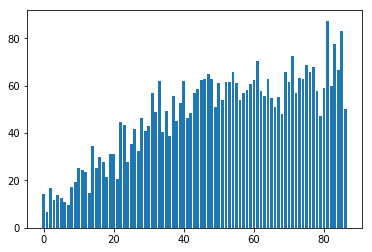

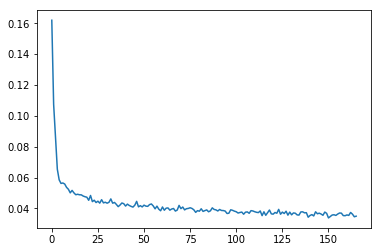

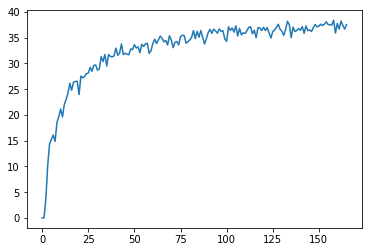

Train Epoch: 331 [0/65192 (0%)]	Loss: 0.032045
Train Epoch: 331 [6400/65192 (10%)]	Loss: 0.039926
Train Epoch: 331 [12800/65192 (20%)]	Loss: 0.033027
Train Epoch: 331 [19200/65192 (29%)]	Loss: 0.035292
Train Epoch: 331 [25600/65192 (39%)]	Loss: 0.042519
Train Epoch: 331 [32000/65192 (49%)]	Loss: 0.035748
Train Epoch: 331 [38400/65192 (59%)]	Loss: 0.030909
Train Epoch: 331 [44800/65192 (69%)]	Loss: 0.033192
Train Epoch: 331 [51200/65192 (79%)]	Loss: 0.029670
Train Epoch: 331 [57600/65192 (88%)]	Loss: 0.034850
Train Epoch: 331 [64000/65192 (98%)]	Loss: 0.035289
Train Epoch: 332 [0/65192 (0%)]	Loss: 0.036564
Train Epoch: 332 [6400/65192 (10%)]	Loss: 0.037724
Train Epoch: 332 [12800/65192 (20%)]	Loss: 0.027991
Train Epoch: 332 [19200/65192 (29%)]	Loss: 0.036156
Train Epoch: 332 [25600/65192 (39%)]	Loss: 0.041903
Train Epoch: 332 [32000/65192 (49%)]	Loss: 0.040651
Train Epoch: 332 [38400/65192 (59%)]	Loss: 0.028320
Train Epoch: 332 [44800/65192 (69%)]	Loss: 0.037908
Train Epoch: 332 [51200/

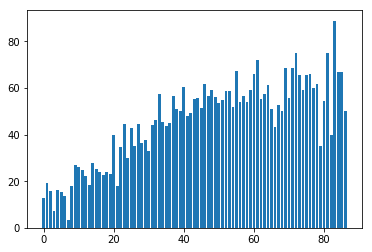

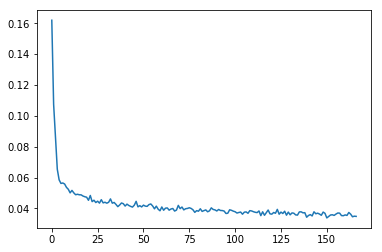

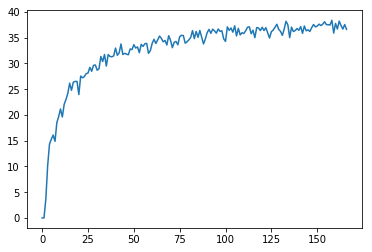

Train Epoch: 333 [0/65192 (0%)]	Loss: 0.033760
Train Epoch: 333 [6400/65192 (10%)]	Loss: 0.030805
Train Epoch: 333 [12800/65192 (20%)]	Loss: 0.031326
Train Epoch: 333 [19200/65192 (29%)]	Loss: 0.039481
Train Epoch: 333 [25600/65192 (39%)]	Loss: 0.038078
Train Epoch: 333 [32000/65192 (49%)]	Loss: 0.028249
Train Epoch: 333 [38400/65192 (59%)]	Loss: 0.034182
Train Epoch: 333 [44800/65192 (69%)]	Loss: 0.027847
Train Epoch: 333 [51200/65192 (79%)]	Loss: 0.034973
Train Epoch: 333 [57600/65192 (88%)]	Loss: 0.043440
Train Epoch: 333 [64000/65192 (98%)]	Loss: 0.026873
Train Epoch: 334 [0/65192 (0%)]	Loss: 0.037249
Train Epoch: 334 [6400/65192 (10%)]	Loss: 0.041212
Train Epoch: 334 [12800/65192 (20%)]	Loss: 0.033655
Train Epoch: 334 [19200/65192 (29%)]	Loss: 0.032888
Train Epoch: 334 [25600/65192 (39%)]	Loss: 0.046113
Train Epoch: 334 [32000/65192 (49%)]	Loss: 0.025496
Train Epoch: 334 [38400/65192 (59%)]	Loss: 0.038947
Train Epoch: 334 [44800/65192 (69%)]	Loss: 0.035087
Train Epoch: 334 [51200/

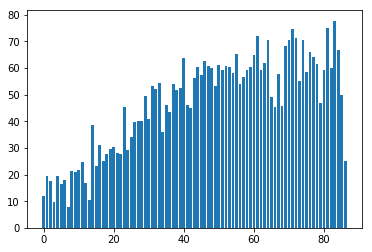

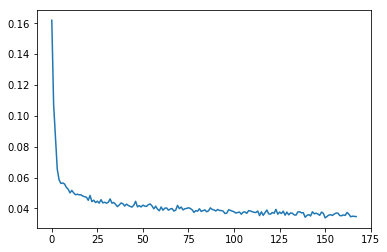

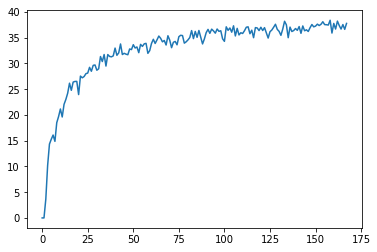

Train Epoch: 335 [0/65192 (0%)]	Loss: 0.037353
Train Epoch: 335 [6400/65192 (10%)]	Loss: 0.035330
Train Epoch: 335 [12800/65192 (20%)]	Loss: 0.032221
Train Epoch: 335 [19200/65192 (29%)]	Loss: 0.030649
Train Epoch: 335 [25600/65192 (39%)]	Loss: 0.030468
Train Epoch: 335 [32000/65192 (49%)]	Loss: 0.038435
Train Epoch: 335 [38400/65192 (59%)]	Loss: 0.034886
Train Epoch: 335 [44800/65192 (69%)]	Loss: 0.035816
Train Epoch: 335 [51200/65192 (79%)]	Loss: 0.034348
Train Epoch: 335 [57600/65192 (88%)]	Loss: 0.039936
Train Epoch: 335 [64000/65192 (98%)]	Loss: 0.033217
Train Epoch: 336 [0/65192 (0%)]	Loss: 0.038362
Train Epoch: 336 [6400/65192 (10%)]	Loss: 0.039202
Train Epoch: 336 [12800/65192 (20%)]	Loss: 0.042736
Train Epoch: 336 [19200/65192 (29%)]	Loss: 0.036971
Train Epoch: 336 [25600/65192 (39%)]	Loss: 0.042476
Train Epoch: 336 [32000/65192 (49%)]	Loss: 0.036696
Train Epoch: 336 [38400/65192 (59%)]	Loss: 0.028399
Train Epoch: 336 [44800/65192 (69%)]	Loss: 0.031089
Train Epoch: 336 [51200/

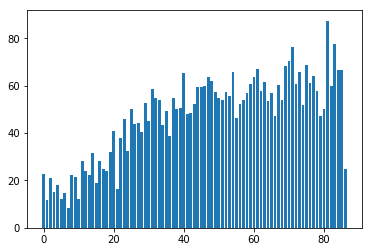

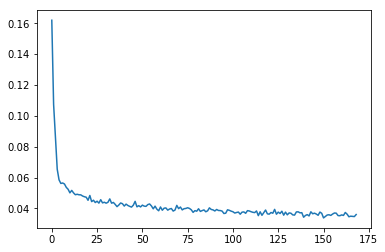

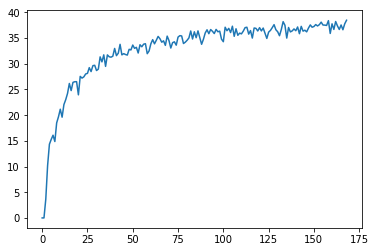

Train Epoch: 337 [0/65192 (0%)]	Loss: 0.038895
Train Epoch: 337 [6400/65192 (10%)]	Loss: 0.042294
Train Epoch: 337 [12800/65192 (20%)]	Loss: 0.034583
Train Epoch: 337 [19200/65192 (29%)]	Loss: 0.035793
Train Epoch: 337 [25600/65192 (39%)]	Loss: 0.037653
Train Epoch: 337 [32000/65192 (49%)]	Loss: 0.041357
Train Epoch: 337 [38400/65192 (59%)]	Loss: 0.027933
Train Epoch: 337 [44800/65192 (69%)]	Loss: 0.028679
Train Epoch: 337 [51200/65192 (79%)]	Loss: 0.029153
Train Epoch: 337 [57600/65192 (88%)]	Loss: 0.037557
Train Epoch: 337 [64000/65192 (98%)]	Loss: 0.030529
Train Epoch: 338 [0/65192 (0%)]	Loss: 0.036264
Train Epoch: 338 [6400/65192 (10%)]	Loss: 0.033760
Train Epoch: 338 [12800/65192 (20%)]	Loss: 0.030991
Train Epoch: 338 [19200/65192 (29%)]	Loss: 0.033552
Train Epoch: 338 [25600/65192 (39%)]	Loss: 0.031935
Train Epoch: 338 [32000/65192 (49%)]	Loss: 0.034372
Train Epoch: 338 [38400/65192 (59%)]	Loss: 0.030130
Train Epoch: 338 [44800/65192 (69%)]	Loss: 0.039272
Train Epoch: 338 [51200/

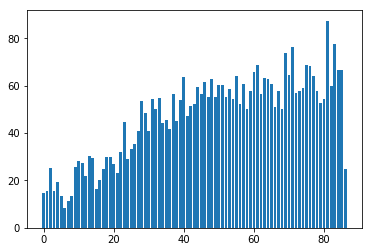

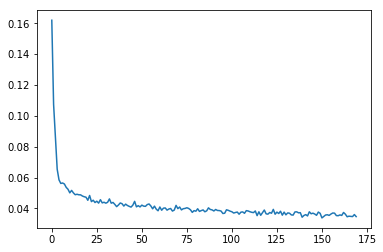

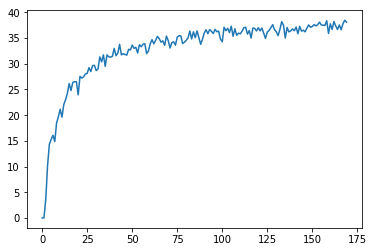

Train Epoch: 339 [0/65192 (0%)]	Loss: 0.032422
Train Epoch: 339 [6400/65192 (10%)]	Loss: 0.039375
Train Epoch: 339 [12800/65192 (20%)]	Loss: 0.030403
Train Epoch: 339 [19200/65192 (29%)]	Loss: 0.030422
Train Epoch: 339 [25600/65192 (39%)]	Loss: 0.030034
Train Epoch: 339 [32000/65192 (49%)]	Loss: 0.032008
Train Epoch: 339 [38400/65192 (59%)]	Loss: 0.032274
Train Epoch: 339 [44800/65192 (69%)]	Loss: 0.034652
Train Epoch: 339 [51200/65192 (79%)]	Loss: 0.032780
Train Epoch: 339 [57600/65192 (88%)]	Loss: 0.044100
Train Epoch: 339 [64000/65192 (98%)]	Loss: 0.032624
Train Epoch: 340 [0/65192 (0%)]	Loss: 0.035254
Train Epoch: 340 [6400/65192 (10%)]	Loss: 0.047783
Train Epoch: 340 [12800/65192 (20%)]	Loss: 0.030645
Train Epoch: 340 [19200/65192 (29%)]	Loss: 0.036522
Train Epoch: 340 [25600/65192 (39%)]	Loss: 0.032590
Train Epoch: 340 [32000/65192 (49%)]	Loss: 0.035807
Train Epoch: 340 [38400/65192 (59%)]	Loss: 0.034955
Train Epoch: 340 [44800/65192 (69%)]	Loss: 0.033993
Train Epoch: 340 [51200/

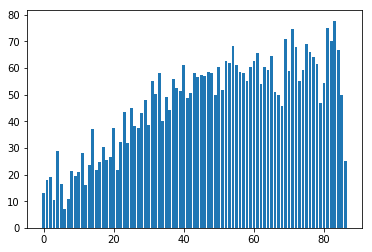

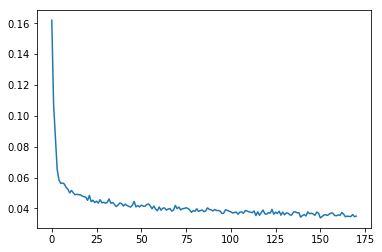

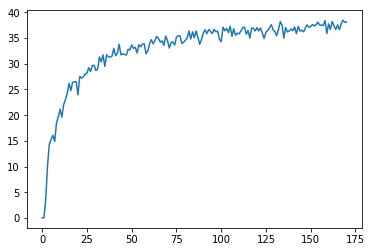

Train Epoch: 341 [0/65192 (0%)]	Loss: 0.034942
Train Epoch: 341 [6400/65192 (10%)]	Loss: 0.031482
Train Epoch: 341 [12800/65192 (20%)]	Loss: 0.027010
Train Epoch: 341 [19200/65192 (29%)]	Loss: 0.026565
Train Epoch: 341 [25600/65192 (39%)]	Loss: 0.039663
Train Epoch: 341 [32000/65192 (49%)]	Loss: 0.033295
Train Epoch: 341 [38400/65192 (59%)]	Loss: 0.038028
Train Epoch: 341 [44800/65192 (69%)]	Loss: 0.022531
Train Epoch: 341 [51200/65192 (79%)]	Loss: 0.031968
Train Epoch: 341 [57600/65192 (88%)]	Loss: 0.035323
Train Epoch: 341 [64000/65192 (98%)]	Loss: 0.034463
Train Epoch: 342 [0/65192 (0%)]	Loss: 0.030124
Train Epoch: 342 [6400/65192 (10%)]	Loss: 0.031274
Train Epoch: 342 [12800/65192 (20%)]	Loss: 0.034864
Train Epoch: 342 [19200/65192 (29%)]	Loss: 0.031331
Train Epoch: 342 [25600/65192 (39%)]	Loss: 0.045869
Train Epoch: 342 [32000/65192 (49%)]	Loss: 0.033134
Train Epoch: 342 [38400/65192 (59%)]	Loss: 0.037840
Train Epoch: 342 [44800/65192 (69%)]	Loss: 0.034079
Train Epoch: 342 [51200/

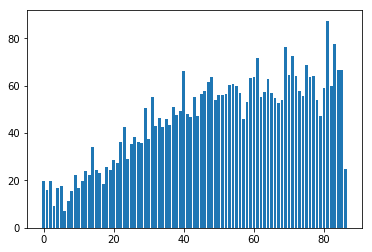

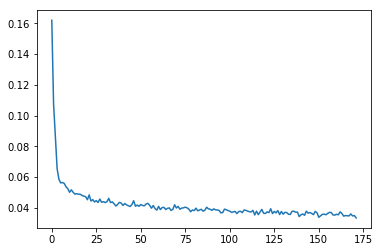

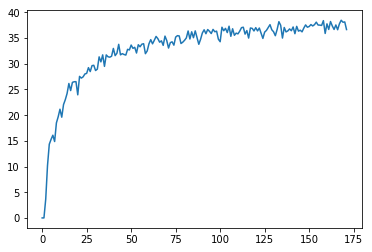

Train Epoch: 343 [0/65192 (0%)]	Loss: 0.033924
Train Epoch: 343 [6400/65192 (10%)]	Loss: 0.040195
Train Epoch: 343 [12800/65192 (20%)]	Loss: 0.027498
Train Epoch: 343 [19200/65192 (29%)]	Loss: 0.039524
Train Epoch: 343 [25600/65192 (39%)]	Loss: 0.038824
Train Epoch: 343 [32000/65192 (49%)]	Loss: 0.039521
Train Epoch: 343 [38400/65192 (59%)]	Loss: 0.035614
Train Epoch: 343 [44800/65192 (69%)]	Loss: 0.033201
Train Epoch: 343 [51200/65192 (79%)]	Loss: 0.021588
Train Epoch: 343 [57600/65192 (88%)]	Loss: 0.036289
Train Epoch: 343 [64000/65192 (98%)]	Loss: 0.032831
Train Epoch: 344 [0/65192 (0%)]	Loss: 0.036480
Train Epoch: 344 [6400/65192 (10%)]	Loss: 0.025356
Train Epoch: 344 [12800/65192 (20%)]	Loss: 0.031132
Train Epoch: 344 [19200/65192 (29%)]	Loss: 0.045067
Train Epoch: 344 [25600/65192 (39%)]	Loss: 0.040239
Train Epoch: 344 [32000/65192 (49%)]	Loss: 0.038315
Train Epoch: 344 [38400/65192 (59%)]	Loss: 0.039799
Train Epoch: 344 [44800/65192 (69%)]	Loss: 0.043614
Train Epoch: 344 [51200/

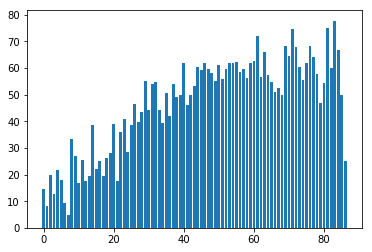

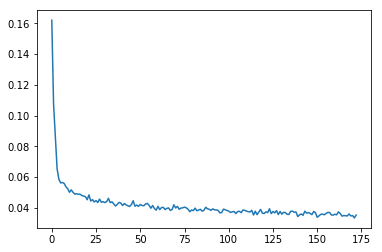

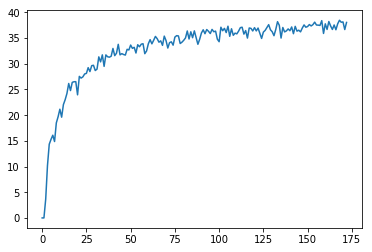

Train Epoch: 345 [0/65192 (0%)]	Loss: 0.031391
Train Epoch: 345 [6400/65192 (10%)]	Loss: 0.031705
Train Epoch: 345 [12800/65192 (20%)]	Loss: 0.036055
Train Epoch: 345 [19200/65192 (29%)]	Loss: 0.044929
Train Epoch: 345 [25600/65192 (39%)]	Loss: 0.032301
Train Epoch: 345 [32000/65192 (49%)]	Loss: 0.044351
Train Epoch: 345 [38400/65192 (59%)]	Loss: 0.038378
Train Epoch: 345 [44800/65192 (69%)]	Loss: 0.035030
Train Epoch: 345 [51200/65192 (79%)]	Loss: 0.043519
Train Epoch: 345 [57600/65192 (88%)]	Loss: 0.035759
Train Epoch: 345 [64000/65192 (98%)]	Loss: 0.035895
Train Epoch: 346 [0/65192 (0%)]	Loss: 0.037828
Train Epoch: 346 [6400/65192 (10%)]	Loss: 0.036267
Train Epoch: 346 [12800/65192 (20%)]	Loss: 0.031383
Train Epoch: 346 [19200/65192 (29%)]	Loss: 0.035550
Train Epoch: 346 [25600/65192 (39%)]	Loss: 0.033356
Train Epoch: 346 [32000/65192 (49%)]	Loss: 0.033920
Train Epoch: 346 [38400/65192 (59%)]	Loss: 0.033256
Train Epoch: 346 [44800/65192 (69%)]	Loss: 0.030793
Train Epoch: 346 [51200/

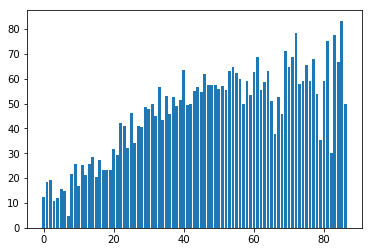

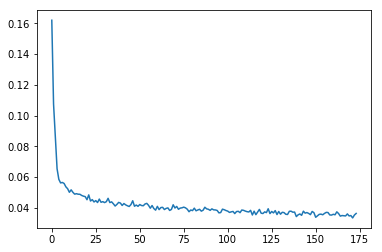

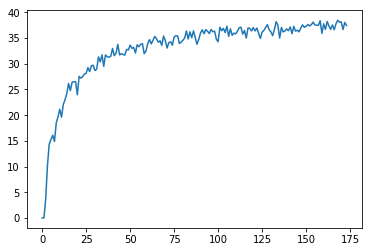

Train Epoch: 347 [0/65192 (0%)]	Loss: 0.041237
Train Epoch: 347 [6400/65192 (10%)]	Loss: 0.032779
Train Epoch: 347 [12800/65192 (20%)]	Loss: 0.029340
Train Epoch: 347 [19200/65192 (29%)]	Loss: 0.033707
Train Epoch: 347 [25600/65192 (39%)]	Loss: 0.035436
Train Epoch: 347 [32000/65192 (49%)]	Loss: 0.029061
Train Epoch: 347 [38400/65192 (59%)]	Loss: 0.038324
Train Epoch: 347 [44800/65192 (69%)]	Loss: 0.037702
Train Epoch: 347 [51200/65192 (79%)]	Loss: 0.037196
Train Epoch: 347 [57600/65192 (88%)]	Loss: 0.035938
Train Epoch: 347 [64000/65192 (98%)]	Loss: 0.039181
Train Epoch: 348 [0/65192 (0%)]	Loss: 0.021633
Train Epoch: 348 [6400/65192 (10%)]	Loss: 0.033385
Train Epoch: 348 [12800/65192 (20%)]	Loss: 0.040448
Train Epoch: 348 [19200/65192 (29%)]	Loss: 0.047293
Train Epoch: 348 [25600/65192 (39%)]	Loss: 0.026832
Train Epoch: 348 [32000/65192 (49%)]	Loss: 0.036928
Train Epoch: 348 [38400/65192 (59%)]	Loss: 0.032436
Train Epoch: 348 [44800/65192 (69%)]	Loss: 0.040804
Train Epoch: 348 [51200/

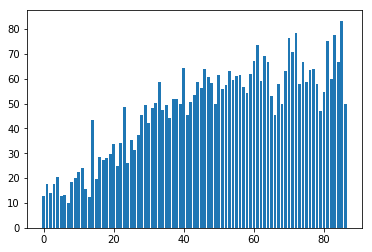

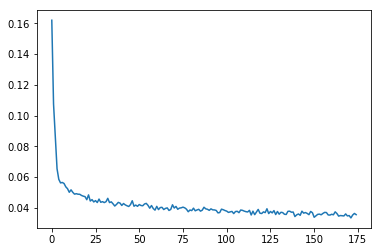

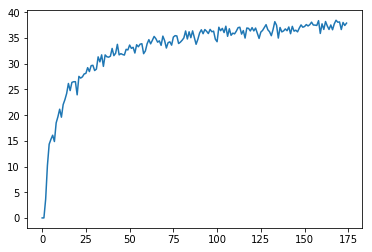

Train Epoch: 349 [0/65192 (0%)]	Loss: 0.029230
Train Epoch: 349 [6400/65192 (10%)]	Loss: 0.030833
Train Epoch: 349 [12800/65192 (20%)]	Loss: 0.026477
Train Epoch: 349 [19200/65192 (29%)]	Loss: 0.038233
Train Epoch: 349 [25600/65192 (39%)]	Loss: 0.042943
Train Epoch: 349 [32000/65192 (49%)]	Loss: 0.032090
Train Epoch: 349 [38400/65192 (59%)]	Loss: 0.036776
Train Epoch: 349 [44800/65192 (69%)]	Loss: 0.037253
Train Epoch: 349 [51200/65192 (79%)]	Loss: 0.033408
Train Epoch: 349 [57600/65192 (88%)]	Loss: 0.042497
Train Epoch: 349 [64000/65192 (98%)]	Loss: 0.037749
Train Epoch: 350 [0/65192 (0%)]	Loss: 0.031761
Train Epoch: 350 [6400/65192 (10%)]	Loss: 0.035098
Train Epoch: 350 [12800/65192 (20%)]	Loss: 0.031342
Train Epoch: 350 [19200/65192 (29%)]	Loss: 0.035042
Train Epoch: 350 [25600/65192 (39%)]	Loss: 0.040802
Train Epoch: 350 [32000/65192 (49%)]	Loss: 0.036892
Train Epoch: 350 [38400/65192 (59%)]	Loss: 0.039591
Train Epoch: 350 [44800/65192 (69%)]	Loss: 0.047145
Train Epoch: 350 [51200/

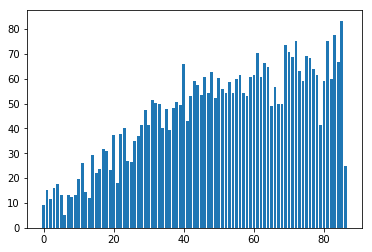

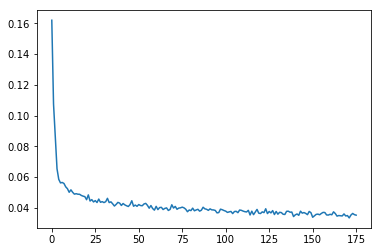

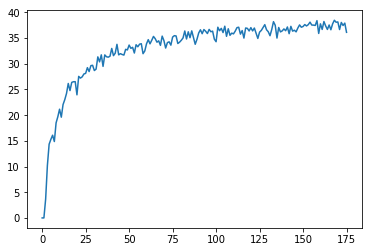

Train Epoch: 351 [0/65192 (0%)]	Loss: 0.049085
Train Epoch: 351 [6400/65192 (10%)]	Loss: 0.034458
Train Epoch: 351 [12800/65192 (20%)]	Loss: 0.038165
Train Epoch: 351 [19200/65192 (29%)]	Loss: 0.035269
Train Epoch: 351 [25600/65192 (39%)]	Loss: 0.036618
Train Epoch: 351 [32000/65192 (49%)]	Loss: 0.033561
Train Epoch: 351 [38400/65192 (59%)]	Loss: 0.030061
Train Epoch: 351 [44800/65192 (69%)]	Loss: 0.032747
Train Epoch: 351 [51200/65192 (79%)]	Loss: 0.036597
Train Epoch: 351 [57600/65192 (88%)]	Loss: 0.028533
Train Epoch: 351 [64000/65192 (98%)]	Loss: 0.027822
Train Epoch: 352 [0/65192 (0%)]	Loss: 0.033658
Train Epoch: 352 [6400/65192 (10%)]	Loss: 0.034605
Train Epoch: 352 [12800/65192 (20%)]	Loss: 0.023049
Train Epoch: 352 [19200/65192 (29%)]	Loss: 0.026294
Train Epoch: 352 [25600/65192 (39%)]	Loss: 0.033479
Train Epoch: 352 [32000/65192 (49%)]	Loss: 0.033088
Train Epoch: 352 [38400/65192 (59%)]	Loss: 0.032356
Train Epoch: 352 [44800/65192 (69%)]	Loss: 0.034825
Train Epoch: 352 [51200/

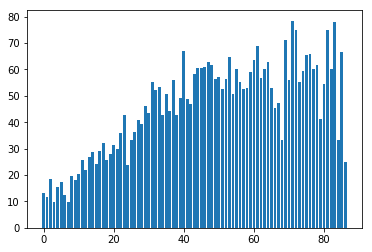

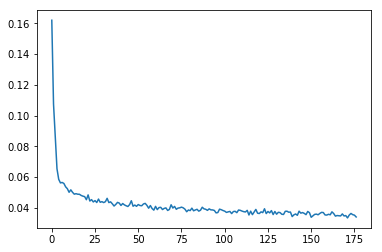

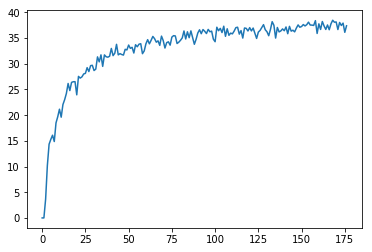

Train Epoch: 353 [0/65192 (0%)]	Loss: 0.025961
Train Epoch: 353 [6400/65192 (10%)]	Loss: 0.037370
Train Epoch: 353 [12800/65192 (20%)]	Loss: 0.039572
Train Epoch: 353 [19200/65192 (29%)]	Loss: 0.037899
Train Epoch: 353 [25600/65192 (39%)]	Loss: 0.036971
Train Epoch: 353 [32000/65192 (49%)]	Loss: 0.030797
Train Epoch: 353 [38400/65192 (59%)]	Loss: 0.045105
Train Epoch: 353 [44800/65192 (69%)]	Loss: 0.027499
Train Epoch: 353 [51200/65192 (79%)]	Loss: 0.035782
Train Epoch: 353 [57600/65192 (88%)]	Loss: 0.032479
Train Epoch: 353 [64000/65192 (98%)]	Loss: 0.033430
Train Epoch: 354 [0/65192 (0%)]	Loss: 0.030037
Train Epoch: 354 [6400/65192 (10%)]	Loss: 0.031769
Train Epoch: 354 [12800/65192 (20%)]	Loss: 0.035318
Train Epoch: 354 [19200/65192 (29%)]	Loss: 0.044397
Train Epoch: 354 [25600/65192 (39%)]	Loss: 0.038956
Train Epoch: 354 [32000/65192 (49%)]	Loss: 0.044214
Train Epoch: 354 [38400/65192 (59%)]	Loss: 0.036105
Train Epoch: 354 [44800/65192 (69%)]	Loss: 0.023889
Train Epoch: 354 [51200/

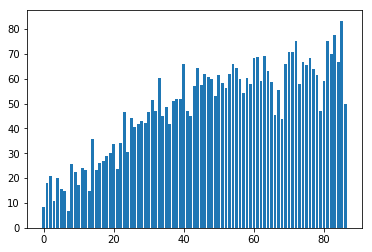

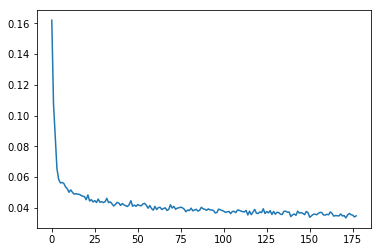

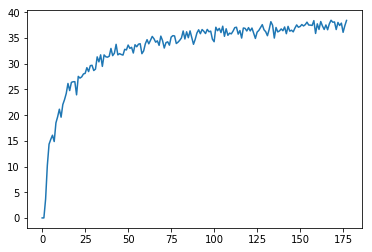

Train Epoch: 355 [0/65192 (0%)]	Loss: 0.030330
Train Epoch: 355 [6400/65192 (10%)]	Loss: 0.037730
Train Epoch: 355 [12800/65192 (20%)]	Loss: 0.028141
Train Epoch: 355 [19200/65192 (29%)]	Loss: 0.040460
Train Epoch: 355 [25600/65192 (39%)]	Loss: 0.038541
Train Epoch: 355 [32000/65192 (49%)]	Loss: 0.034272
Train Epoch: 355 [38400/65192 (59%)]	Loss: 0.029511
Train Epoch: 355 [44800/65192 (69%)]	Loss: 0.032370
Train Epoch: 355 [51200/65192 (79%)]	Loss: 0.032825
Train Epoch: 355 [57600/65192 (88%)]	Loss: 0.031536
Train Epoch: 355 [64000/65192 (98%)]	Loss: 0.038919
Train Epoch: 356 [0/65192 (0%)]	Loss: 0.035543
Train Epoch: 356 [6400/65192 (10%)]	Loss: 0.036243
Train Epoch: 356 [12800/65192 (20%)]	Loss: 0.026901
Train Epoch: 356 [19200/65192 (29%)]	Loss: 0.033032
Train Epoch: 356 [25600/65192 (39%)]	Loss: 0.028815
Train Epoch: 356 [32000/65192 (49%)]	Loss: 0.047294
Train Epoch: 356 [38400/65192 (59%)]	Loss: 0.033594
Train Epoch: 356 [44800/65192 (69%)]	Loss: 0.040825
Train Epoch: 356 [51200/

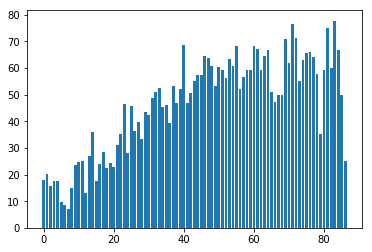

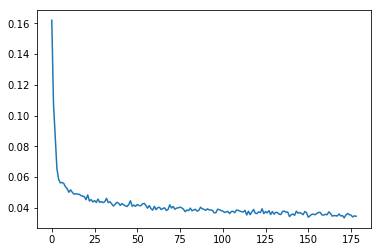

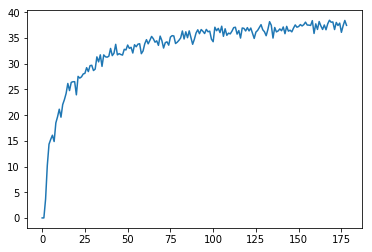

Train Epoch: 357 [0/65192 (0%)]	Loss: 0.040056
Train Epoch: 357 [6400/65192 (10%)]	Loss: 0.038479
Train Epoch: 357 [12800/65192 (20%)]	Loss: 0.033555
Train Epoch: 357 [19200/65192 (29%)]	Loss: 0.034373
Train Epoch: 357 [25600/65192 (39%)]	Loss: 0.033232
Train Epoch: 357 [32000/65192 (49%)]	Loss: 0.022537
Train Epoch: 357 [38400/65192 (59%)]	Loss: 0.029131
Train Epoch: 357 [44800/65192 (69%)]	Loss: 0.038694
Train Epoch: 357 [51200/65192 (79%)]	Loss: 0.029198
Train Epoch: 357 [57600/65192 (88%)]	Loss: 0.035965
Train Epoch: 357 [64000/65192 (98%)]	Loss: 0.036334
Train Epoch: 358 [0/65192 (0%)]	Loss: 0.034760
Train Epoch: 358 [6400/65192 (10%)]	Loss: 0.026476
Train Epoch: 358 [12800/65192 (20%)]	Loss: 0.040926
Train Epoch: 358 [19200/65192 (29%)]	Loss: 0.039110
Train Epoch: 358 [25600/65192 (39%)]	Loss: 0.036647
Train Epoch: 358 [32000/65192 (49%)]	Loss: 0.027845
Train Epoch: 358 [38400/65192 (59%)]	Loss: 0.033788
Train Epoch: 358 [44800/65192 (69%)]	Loss: 0.037235
Train Epoch: 358 [51200/

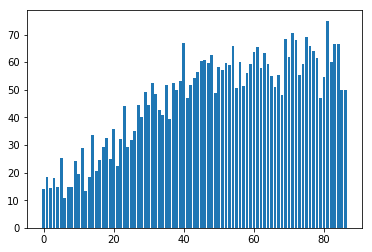

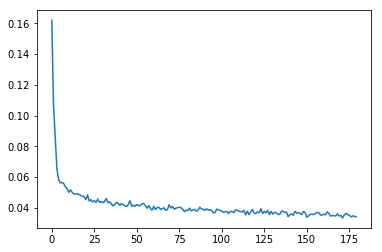

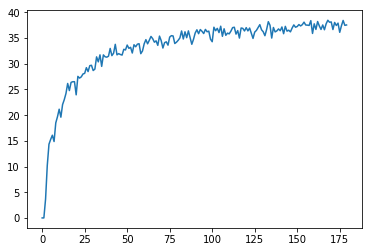

Train Epoch: 359 [0/65192 (0%)]	Loss: 0.038829
Train Epoch: 359 [6400/65192 (10%)]	Loss: 0.036021
Train Epoch: 359 [12800/65192 (20%)]	Loss: 0.037391
Train Epoch: 359 [19200/65192 (29%)]	Loss: 0.034118
Train Epoch: 359 [25600/65192 (39%)]	Loss: 0.037001
Train Epoch: 359 [32000/65192 (49%)]	Loss: 0.036653
Train Epoch: 359 [38400/65192 (59%)]	Loss: 0.050354
Train Epoch: 359 [44800/65192 (69%)]	Loss: 0.041629
Train Epoch: 359 [51200/65192 (79%)]	Loss: 0.030417
Train Epoch: 359 [57600/65192 (88%)]	Loss: 0.031770
Train Epoch: 359 [64000/65192 (98%)]	Loss: 0.040676
Train Epoch: 360 [0/65192 (0%)]	Loss: 0.030288
Train Epoch: 360 [6400/65192 (10%)]	Loss: 0.034366
Train Epoch: 360 [12800/65192 (20%)]	Loss: 0.033308
Train Epoch: 360 [19200/65192 (29%)]	Loss: 0.035636
Train Epoch: 360 [25600/65192 (39%)]	Loss: 0.033884
Train Epoch: 360 [32000/65192 (49%)]	Loss: 0.035780
Train Epoch: 360 [38400/65192 (59%)]	Loss: 0.033416
Train Epoch: 360 [44800/65192 (69%)]	Loss: 0.029850
Train Epoch: 360 [51200/

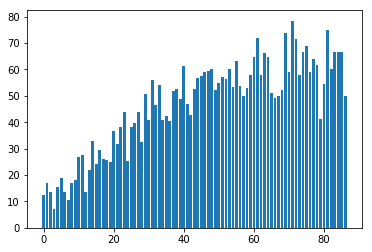

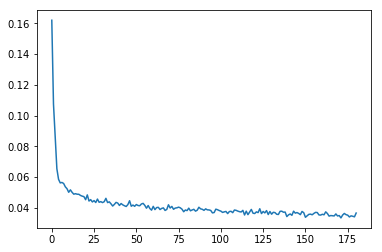

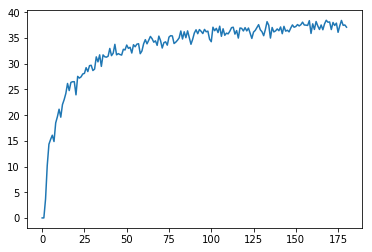

Train Epoch: 361 [0/65192 (0%)]	Loss: 0.024968
Train Epoch: 361 [6400/65192 (10%)]	Loss: 0.044169
Train Epoch: 361 [12800/65192 (20%)]	Loss: 0.030417
Train Epoch: 361 [19200/65192 (29%)]	Loss: 0.034926
Train Epoch: 361 [25600/65192 (39%)]	Loss: 0.033333
Train Epoch: 361 [32000/65192 (49%)]	Loss: 0.047487
Train Epoch: 361 [38400/65192 (59%)]	Loss: 0.053200
Train Epoch: 361 [44800/65192 (69%)]	Loss: 0.033961
Train Epoch: 361 [51200/65192 (79%)]	Loss: 0.038598
Train Epoch: 361 [57600/65192 (88%)]	Loss: 0.028299
Train Epoch: 361 [64000/65192 (98%)]	Loss: 0.033465
Train Epoch: 362 [0/65192 (0%)]	Loss: 0.036363
Train Epoch: 362 [6400/65192 (10%)]	Loss: 0.038660
Train Epoch: 362 [12800/65192 (20%)]	Loss: 0.031435
Train Epoch: 362 [19200/65192 (29%)]	Loss: 0.036644
Train Epoch: 362 [25600/65192 (39%)]	Loss: 0.036381
Train Epoch: 362 [32000/65192 (49%)]	Loss: 0.041421
Train Epoch: 362 [38400/65192 (59%)]	Loss: 0.040764
Train Epoch: 362 [44800/65192 (69%)]	Loss: 0.034560
Train Epoch: 362 [51200/

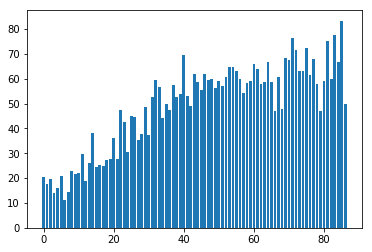

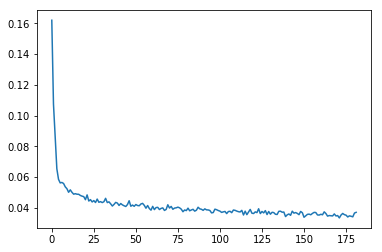

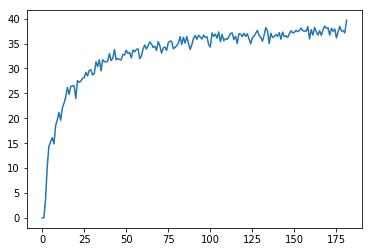

Train Epoch: 363 [0/65192 (0%)]	Loss: 0.041082
Train Epoch: 363 [6400/65192 (10%)]	Loss: 0.032665
Train Epoch: 363 [12800/65192 (20%)]	Loss: 0.027024
Train Epoch: 363 [19200/65192 (29%)]	Loss: 0.043354
Train Epoch: 363 [25600/65192 (39%)]	Loss: 0.036748
Train Epoch: 363 [32000/65192 (49%)]	Loss: 0.033358
Train Epoch: 363 [38400/65192 (59%)]	Loss: 0.024858
Train Epoch: 363 [44800/65192 (69%)]	Loss: 0.036683
Train Epoch: 363 [51200/65192 (79%)]	Loss: 0.036415
Train Epoch: 363 [57600/65192 (88%)]	Loss: 0.032248
Train Epoch: 363 [64000/65192 (98%)]	Loss: 0.029497
Train Epoch: 364 [0/65192 (0%)]	Loss: 0.044262
Train Epoch: 364 [6400/65192 (10%)]	Loss: 0.025940
Train Epoch: 364 [12800/65192 (20%)]	Loss: 0.048689
Train Epoch: 364 [19200/65192 (29%)]	Loss: 0.030790
Train Epoch: 364 [25600/65192 (39%)]	Loss: 0.037609
Train Epoch: 364 [32000/65192 (49%)]	Loss: 0.036553
Train Epoch: 364 [38400/65192 (59%)]	Loss: 0.035214
Train Epoch: 364 [44800/65192 (69%)]	Loss: 0.029858
Train Epoch: 364 [51200/

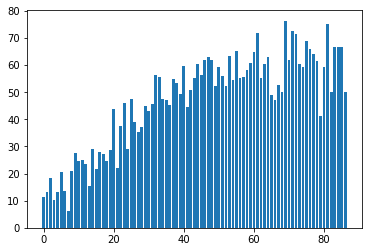

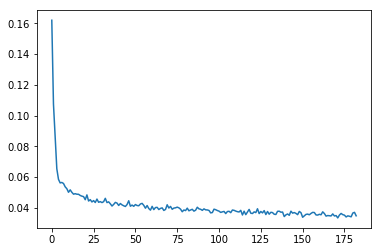

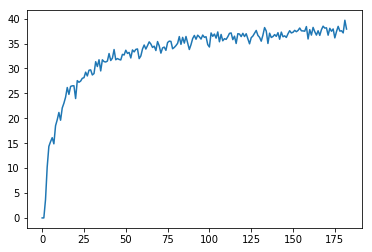

Train Epoch: 365 [0/65192 (0%)]	Loss: 0.038364
Train Epoch: 365 [6400/65192 (10%)]	Loss: 0.045154
Train Epoch: 365 [12800/65192 (20%)]	Loss: 0.029410
Train Epoch: 365 [19200/65192 (29%)]	Loss: 0.029444
Train Epoch: 365 [25600/65192 (39%)]	Loss: 0.026101
Train Epoch: 365 [32000/65192 (49%)]	Loss: 0.041337
Train Epoch: 365 [38400/65192 (59%)]	Loss: 0.044239
Train Epoch: 365 [44800/65192 (69%)]	Loss: 0.038911
Train Epoch: 365 [51200/65192 (79%)]	Loss: 0.038962
Train Epoch: 365 [57600/65192 (88%)]	Loss: 0.036892
Train Epoch: 365 [64000/65192 (98%)]	Loss: 0.029769
Train Epoch: 366 [0/65192 (0%)]	Loss: 0.031034
Train Epoch: 366 [6400/65192 (10%)]	Loss: 0.036682
Train Epoch: 366 [12800/65192 (20%)]	Loss: 0.040175
Train Epoch: 366 [19200/65192 (29%)]	Loss: 0.037215
Train Epoch: 366 [25600/65192 (39%)]	Loss: 0.026807
Train Epoch: 366 [32000/65192 (49%)]	Loss: 0.043297
Train Epoch: 366 [38400/65192 (59%)]	Loss: 0.026955
Train Epoch: 366 [44800/65192 (69%)]	Loss: 0.032081
Train Epoch: 366 [51200/

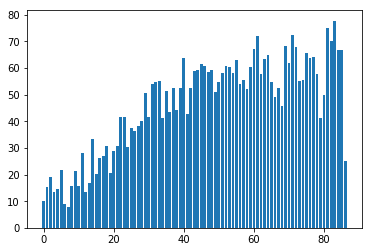

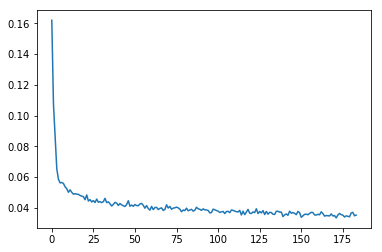

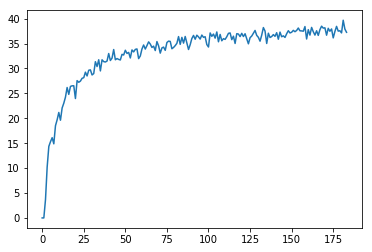

Train Epoch: 367 [0/65192 (0%)]	Loss: 0.034814
Train Epoch: 367 [6400/65192 (10%)]	Loss: 0.041767
Train Epoch: 367 [12800/65192 (20%)]	Loss: 0.038774
Train Epoch: 367 [19200/65192 (29%)]	Loss: 0.038098
Train Epoch: 367 [25600/65192 (39%)]	Loss: 0.033089
Train Epoch: 367 [32000/65192 (49%)]	Loss: 0.039222
Train Epoch: 367 [38400/65192 (59%)]	Loss: 0.036527
Train Epoch: 367 [44800/65192 (69%)]	Loss: 0.043515
Train Epoch: 367 [51200/65192 (79%)]	Loss: 0.030511
Train Epoch: 367 [57600/65192 (88%)]	Loss: 0.033165
Train Epoch: 367 [64000/65192 (98%)]	Loss: 0.028345
Train Epoch: 368 [0/65192 (0%)]	Loss: 0.035975
Train Epoch: 368 [6400/65192 (10%)]	Loss: 0.033801
Train Epoch: 368 [12800/65192 (20%)]	Loss: 0.036985
Train Epoch: 368 [19200/65192 (29%)]	Loss: 0.038275
Train Epoch: 368 [25600/65192 (39%)]	Loss: 0.040209
Train Epoch: 368 [32000/65192 (49%)]	Loss: 0.040894
Train Epoch: 368 [38400/65192 (59%)]	Loss: 0.030600
Train Epoch: 368 [44800/65192 (69%)]	Loss: 0.035585
Train Epoch: 368 [51200/

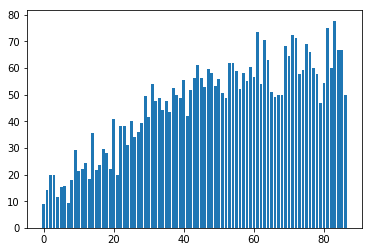

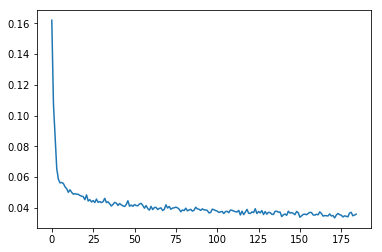

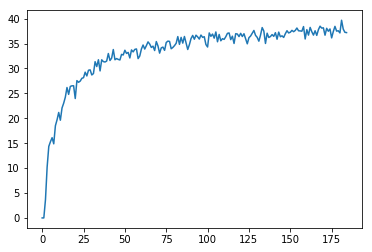

Train Epoch: 369 [0/65192 (0%)]	Loss: 0.034857
Train Epoch: 369 [6400/65192 (10%)]	Loss: 0.040347
Train Epoch: 369 [12800/65192 (20%)]	Loss: 0.036922
Train Epoch: 369 [19200/65192 (29%)]	Loss: 0.030571
Train Epoch: 369 [25600/65192 (39%)]	Loss: 0.038827
Train Epoch: 369 [32000/65192 (49%)]	Loss: 0.031440
Train Epoch: 369 [38400/65192 (59%)]	Loss: 0.046108
Train Epoch: 369 [44800/65192 (69%)]	Loss: 0.038627
Train Epoch: 369 [51200/65192 (79%)]	Loss: 0.041345
Train Epoch: 369 [57600/65192 (88%)]	Loss: 0.022528
Train Epoch: 369 [64000/65192 (98%)]	Loss: 0.035969
Train Epoch: 370 [0/65192 (0%)]	Loss: 0.037283
Train Epoch: 370 [6400/65192 (10%)]	Loss: 0.040728
Train Epoch: 370 [12800/65192 (20%)]	Loss: 0.031613
Train Epoch: 370 [19200/65192 (29%)]	Loss: 0.035005
Train Epoch: 370 [25600/65192 (39%)]	Loss: 0.033995
Train Epoch: 370 [32000/65192 (49%)]	Loss: 0.035192
Train Epoch: 370 [38400/65192 (59%)]	Loss: 0.039760
Train Epoch: 370 [44800/65192 (69%)]	Loss: 0.040220
Train Epoch: 370 [51200/

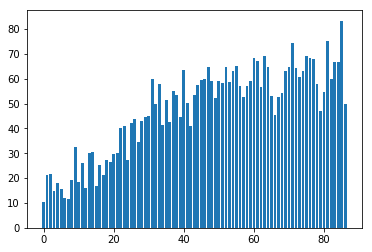

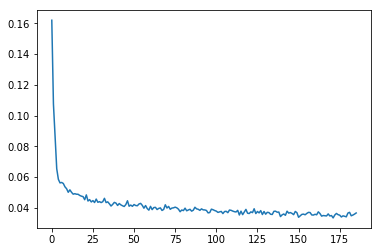

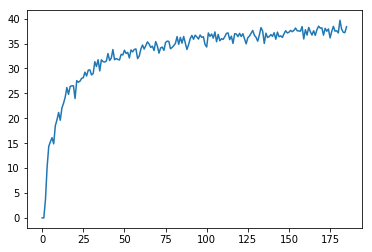

Train Epoch: 371 [0/65192 (0%)]	Loss: 0.036207
Train Epoch: 371 [6400/65192 (10%)]	Loss: 0.033697
Train Epoch: 371 [12800/65192 (20%)]	Loss: 0.030900
Train Epoch: 371 [19200/65192 (29%)]	Loss: 0.035732
Train Epoch: 371 [25600/65192 (39%)]	Loss: 0.044857
Train Epoch: 371 [32000/65192 (49%)]	Loss: 0.041303
Train Epoch: 371 [38400/65192 (59%)]	Loss: 0.037657
Train Epoch: 371 [44800/65192 (69%)]	Loss: 0.040888
Train Epoch: 371 [51200/65192 (79%)]	Loss: 0.029473
Train Epoch: 371 [57600/65192 (88%)]	Loss: 0.034763
Train Epoch: 371 [64000/65192 (98%)]	Loss: 0.042169
Train Epoch: 372 [0/65192 (0%)]	Loss: 0.040617
Train Epoch: 372 [6400/65192 (10%)]	Loss: 0.046690
Train Epoch: 372 [12800/65192 (20%)]	Loss: 0.034938
Train Epoch: 372 [19200/65192 (29%)]	Loss: 0.035407
Train Epoch: 372 [25600/65192 (39%)]	Loss: 0.032833
Train Epoch: 372 [32000/65192 (49%)]	Loss: 0.031456
Train Epoch: 372 [38400/65192 (59%)]	Loss: 0.030185
Train Epoch: 372 [44800/65192 (69%)]	Loss: 0.034235
Train Epoch: 372 [51200/

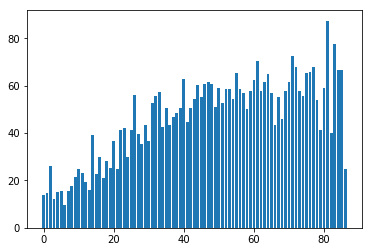

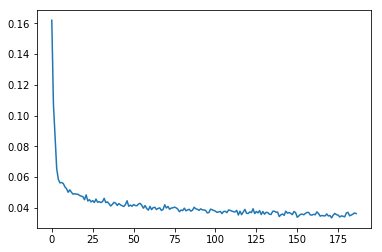

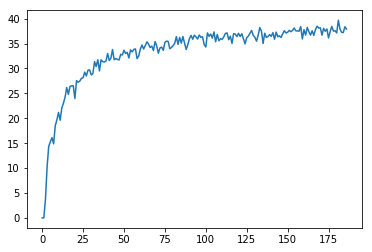

Train Epoch: 373 [0/65192 (0%)]	Loss: 0.039516
Train Epoch: 373 [6400/65192 (10%)]	Loss: 0.038685
Train Epoch: 373 [12800/65192 (20%)]	Loss: 0.034194
Train Epoch: 373 [19200/65192 (29%)]	Loss: 0.035367
Train Epoch: 373 [25600/65192 (39%)]	Loss: 0.036767
Train Epoch: 373 [32000/65192 (49%)]	Loss: 0.032325
Train Epoch: 373 [38400/65192 (59%)]	Loss: 0.026044
Train Epoch: 373 [44800/65192 (69%)]	Loss: 0.030558
Train Epoch: 373 [51200/65192 (79%)]	Loss: 0.037270
Train Epoch: 373 [57600/65192 (88%)]	Loss: 0.035659
Train Epoch: 373 [64000/65192 (98%)]	Loss: 0.036744
Train Epoch: 374 [0/65192 (0%)]	Loss: 0.028086
Train Epoch: 374 [6400/65192 (10%)]	Loss: 0.039263
Train Epoch: 374 [12800/65192 (20%)]	Loss: 0.036845
Train Epoch: 374 [19200/65192 (29%)]	Loss: 0.036114
Train Epoch: 374 [25600/65192 (39%)]	Loss: 0.034112
Train Epoch: 374 [32000/65192 (49%)]	Loss: 0.031638
Train Epoch: 374 [38400/65192 (59%)]	Loss: 0.028613
Train Epoch: 374 [44800/65192 (69%)]	Loss: 0.034386
Train Epoch: 374 [51200/

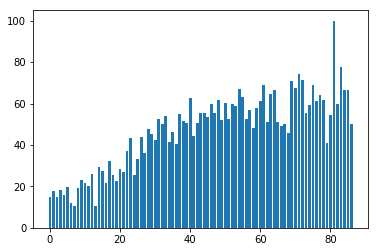

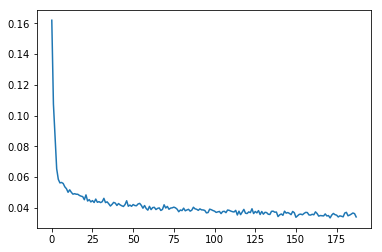

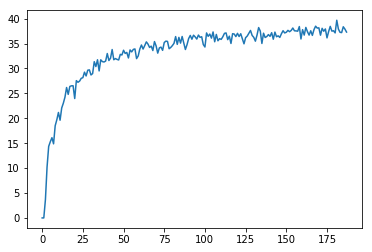

Train Epoch: 375 [0/65192 (0%)]	Loss: 0.039783
Train Epoch: 375 [6400/65192 (10%)]	Loss: 0.036011
Train Epoch: 375 [12800/65192 (20%)]	Loss: 0.031732
Train Epoch: 375 [19200/65192 (29%)]	Loss: 0.037143
Train Epoch: 375 [25600/65192 (39%)]	Loss: 0.031264
Train Epoch: 375 [32000/65192 (49%)]	Loss: 0.038008
Train Epoch: 375 [38400/65192 (59%)]	Loss: 0.026984
Train Epoch: 375 [44800/65192 (69%)]	Loss: 0.035651
Train Epoch: 375 [51200/65192 (79%)]	Loss: 0.028964
Train Epoch: 375 [57600/65192 (88%)]	Loss: 0.039355
Train Epoch: 375 [64000/65192 (98%)]	Loss: 0.040891
Train Epoch: 376 [0/65192 (0%)]	Loss: 0.038417
Train Epoch: 376 [6400/65192 (10%)]	Loss: 0.037686
Train Epoch: 376 [12800/65192 (20%)]	Loss: 0.035232
Train Epoch: 376 [19200/65192 (29%)]	Loss: 0.035260
Train Epoch: 376 [25600/65192 (39%)]	Loss: 0.034556
Train Epoch: 376 [32000/65192 (49%)]	Loss: 0.043944
Train Epoch: 376 [38400/65192 (59%)]	Loss: 0.035221
Train Epoch: 376 [44800/65192 (69%)]	Loss: 0.034586
Train Epoch: 376 [51200/

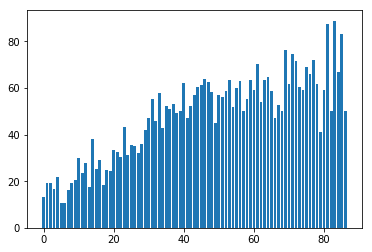

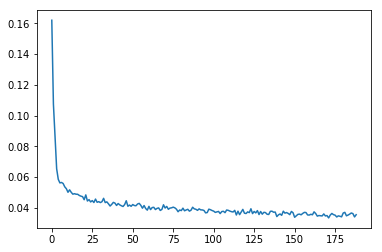

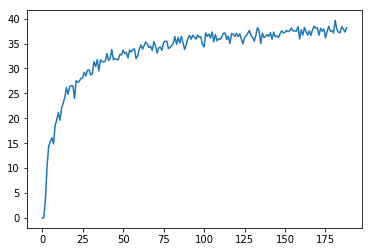

Train Epoch: 377 [0/65192 (0%)]	Loss: 0.027566
Train Epoch: 377 [6400/65192 (10%)]	Loss: 0.042879
Train Epoch: 377 [12800/65192 (20%)]	Loss: 0.030640
Train Epoch: 377 [19200/65192 (29%)]	Loss: 0.034176
Train Epoch: 377 [25600/65192 (39%)]	Loss: 0.030073
Train Epoch: 377 [32000/65192 (49%)]	Loss: 0.037760
Train Epoch: 377 [38400/65192 (59%)]	Loss: 0.042935
Train Epoch: 377 [44800/65192 (69%)]	Loss: 0.033625
Train Epoch: 377 [51200/65192 (79%)]	Loss: 0.030325
Train Epoch: 377 [57600/65192 (88%)]	Loss: 0.033889
Train Epoch: 377 [64000/65192 (98%)]	Loss: 0.031557
Train Epoch: 378 [0/65192 (0%)]	Loss: 0.035849
Train Epoch: 378 [6400/65192 (10%)]	Loss: 0.035370
Train Epoch: 378 [12800/65192 (20%)]	Loss: 0.030633
Train Epoch: 378 [19200/65192 (29%)]	Loss: 0.029977
Train Epoch: 378 [25600/65192 (39%)]	Loss: 0.037435
Train Epoch: 378 [32000/65192 (49%)]	Loss: 0.031909
Train Epoch: 378 [38400/65192 (59%)]	Loss: 0.025712
Train Epoch: 378 [44800/65192 (69%)]	Loss: 0.033390
Train Epoch: 378 [51200/

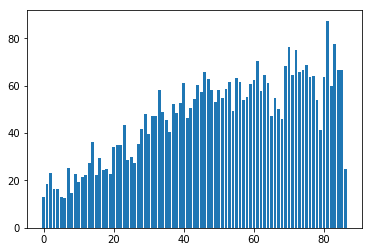

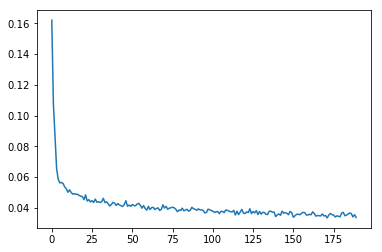

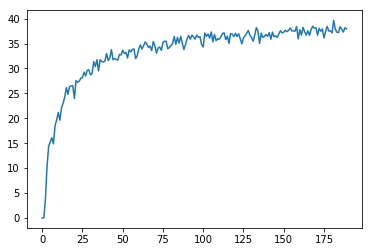

Train Epoch: 379 [0/65192 (0%)]	Loss: 0.039954
Train Epoch: 379 [6400/65192 (10%)]	Loss: 0.036083
Train Epoch: 379 [12800/65192 (20%)]	Loss: 0.033173
Train Epoch: 379 [19200/65192 (29%)]	Loss: 0.036717
Train Epoch: 379 [25600/65192 (39%)]	Loss: 0.028628
Train Epoch: 379 [32000/65192 (49%)]	Loss: 0.033926
Train Epoch: 379 [38400/65192 (59%)]	Loss: 0.036891
Train Epoch: 379 [44800/65192 (69%)]	Loss: 0.036177
Train Epoch: 379 [51200/65192 (79%)]	Loss: 0.031960
Train Epoch: 379 [57600/65192 (88%)]	Loss: 0.027858
Train Epoch: 379 [64000/65192 (98%)]	Loss: 0.039289
Train Epoch: 380 [0/65192 (0%)]	Loss: 0.036506
Train Epoch: 380 [6400/65192 (10%)]	Loss: 0.032333
Train Epoch: 380 [12800/65192 (20%)]	Loss: 0.034835
Train Epoch: 380 [19200/65192 (29%)]	Loss: 0.034915
Train Epoch: 380 [25600/65192 (39%)]	Loss: 0.031666
Train Epoch: 380 [32000/65192 (49%)]	Loss: 0.031984
Train Epoch: 380 [38400/65192 (59%)]	Loss: 0.029992
Train Epoch: 380 [44800/65192 (69%)]	Loss: 0.041041
Train Epoch: 380 [51200/

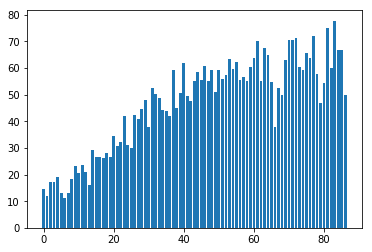

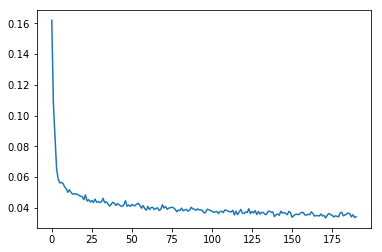

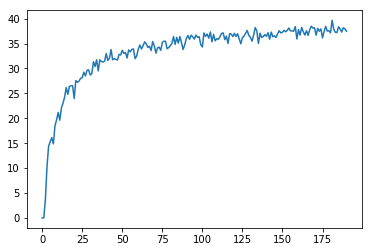

Train Epoch: 381 [0/65192 (0%)]	Loss: 0.028422
Train Epoch: 381 [6400/65192 (10%)]	Loss: 0.031223
Train Epoch: 381 [12800/65192 (20%)]	Loss: 0.041069
Train Epoch: 381 [19200/65192 (29%)]	Loss: 0.038486
Train Epoch: 381 [25600/65192 (39%)]	Loss: 0.034402
Train Epoch: 381 [32000/65192 (49%)]	Loss: 0.035826
Train Epoch: 381 [38400/65192 (59%)]	Loss: 0.036609
Train Epoch: 381 [44800/65192 (69%)]	Loss: 0.038151
Train Epoch: 381 [51200/65192 (79%)]	Loss: 0.038455
Train Epoch: 381 [57600/65192 (88%)]	Loss: 0.038207
Train Epoch: 381 [64000/65192 (98%)]	Loss: 0.034564
Train Epoch: 382 [0/65192 (0%)]	Loss: 0.033146
Train Epoch: 382 [6400/65192 (10%)]	Loss: 0.026826
Train Epoch: 382 [12800/65192 (20%)]	Loss: 0.028339
Train Epoch: 382 [19200/65192 (29%)]	Loss: 0.043865
Train Epoch: 382 [25600/65192 (39%)]	Loss: 0.032852
Train Epoch: 382 [32000/65192 (49%)]	Loss: 0.036354
Train Epoch: 382 [38400/65192 (59%)]	Loss: 0.040420
Train Epoch: 382 [44800/65192 (69%)]	Loss: 0.033682
Train Epoch: 382 [51200/

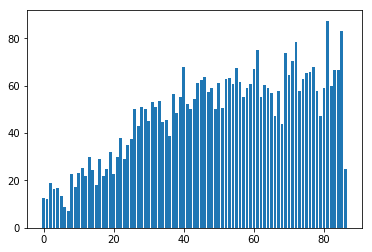

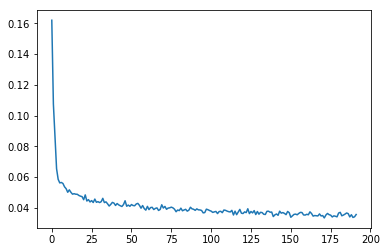

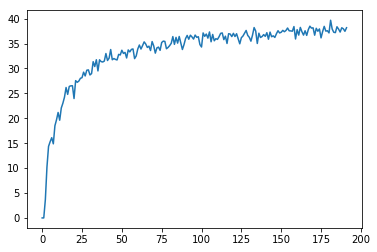

Train Epoch: 383 [0/65192 (0%)]	Loss: 0.030951
Train Epoch: 383 [6400/65192 (10%)]	Loss: 0.034250
Train Epoch: 383 [12800/65192 (20%)]	Loss: 0.029453
Train Epoch: 383 [19200/65192 (29%)]	Loss: 0.036430
Train Epoch: 383 [25600/65192 (39%)]	Loss: 0.027202
Train Epoch: 383 [32000/65192 (49%)]	Loss: 0.040131
Train Epoch: 383 [38400/65192 (59%)]	Loss: 0.036622
Train Epoch: 383 [44800/65192 (69%)]	Loss: 0.039437
Train Epoch: 383 [51200/65192 (79%)]	Loss: 0.037383
Train Epoch: 383 [57600/65192 (88%)]	Loss: 0.033406
Train Epoch: 383 [64000/65192 (98%)]	Loss: 0.032083
Train Epoch: 384 [0/65192 (0%)]	Loss: 0.034039
Train Epoch: 384 [6400/65192 (10%)]	Loss: 0.040600
Train Epoch: 384 [12800/65192 (20%)]	Loss: 0.028808
Train Epoch: 384 [19200/65192 (29%)]	Loss: 0.036472
Train Epoch: 384 [25600/65192 (39%)]	Loss: 0.032503
Train Epoch: 384 [32000/65192 (49%)]	Loss: 0.027295
Train Epoch: 384 [38400/65192 (59%)]	Loss: 0.037046
Train Epoch: 384 [44800/65192 (69%)]	Loss: 0.035529
Train Epoch: 384 [51200/

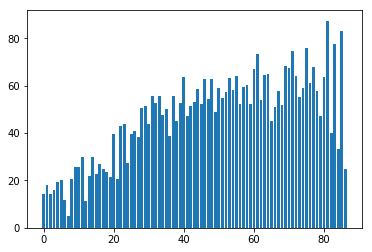

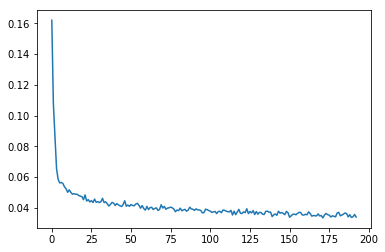

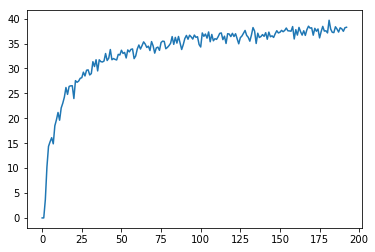

Train Epoch: 385 [0/65192 (0%)]	Loss: 0.027846
Train Epoch: 385 [6400/65192 (10%)]	Loss: 0.030776
Train Epoch: 385 [12800/65192 (20%)]	Loss: 0.032924
Train Epoch: 385 [19200/65192 (29%)]	Loss: 0.024849
Train Epoch: 385 [25600/65192 (39%)]	Loss: 0.027679
Train Epoch: 385 [32000/65192 (49%)]	Loss: 0.039605
Train Epoch: 385 [38400/65192 (59%)]	Loss: 0.032945
Train Epoch: 385 [44800/65192 (69%)]	Loss: 0.035157
Train Epoch: 385 [51200/65192 (79%)]	Loss: 0.038901
Train Epoch: 385 [57600/65192 (88%)]	Loss: 0.023375
Train Epoch: 385 [64000/65192 (98%)]	Loss: 0.033556
Train Epoch: 386 [0/65192 (0%)]	Loss: 0.042612
Train Epoch: 386 [6400/65192 (10%)]	Loss: 0.036437
Train Epoch: 386 [12800/65192 (20%)]	Loss: 0.027093
Train Epoch: 386 [19200/65192 (29%)]	Loss: 0.030460
Train Epoch: 386 [25600/65192 (39%)]	Loss: 0.039115
Train Epoch: 386 [32000/65192 (49%)]	Loss: 0.030551
Train Epoch: 386 [38400/65192 (59%)]	Loss: 0.029628
Train Epoch: 386 [44800/65192 (69%)]	Loss: 0.031007
Train Epoch: 386 [51200/

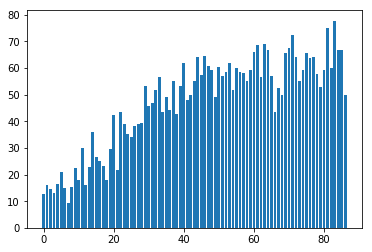

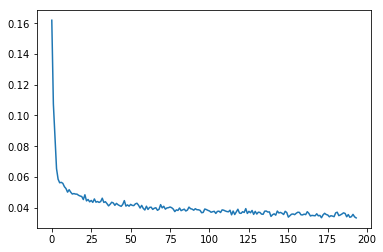

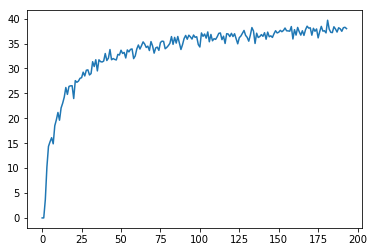

Train Epoch: 387 [0/65192 (0%)]	Loss: 0.046795
Train Epoch: 387 [6400/65192 (10%)]	Loss: 0.029124
Train Epoch: 387 [12800/65192 (20%)]	Loss: 0.032955
Train Epoch: 387 [19200/65192 (29%)]	Loss: 0.039087
Train Epoch: 387 [25600/65192 (39%)]	Loss: 0.031112
Train Epoch: 387 [32000/65192 (49%)]	Loss: 0.033182
Train Epoch: 387 [38400/65192 (59%)]	Loss: 0.028817
Train Epoch: 387 [44800/65192 (69%)]	Loss: 0.037398
Train Epoch: 387 [51200/65192 (79%)]	Loss: 0.029963
Train Epoch: 387 [57600/65192 (88%)]	Loss: 0.038914
Train Epoch: 387 [64000/65192 (98%)]	Loss: 0.031608
Train Epoch: 388 [0/65192 (0%)]	Loss: 0.034999
Train Epoch: 388 [6400/65192 (10%)]	Loss: 0.040778
Train Epoch: 388 [12800/65192 (20%)]	Loss: 0.032377
Train Epoch: 388 [19200/65192 (29%)]	Loss: 0.042824
Train Epoch: 388 [25600/65192 (39%)]	Loss: 0.029886
Train Epoch: 388 [32000/65192 (49%)]	Loss: 0.034829
Train Epoch: 388 [38400/65192 (59%)]	Loss: 0.035965
Train Epoch: 388 [44800/65192 (69%)]	Loss: 0.031520
Train Epoch: 388 [51200/

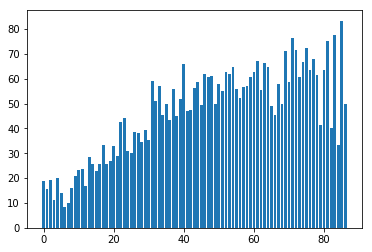

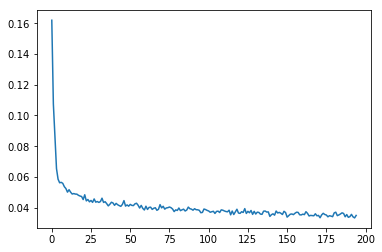

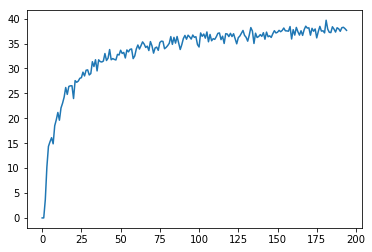

Train Epoch: 389 [0/65192 (0%)]	Loss: 0.035300
Train Epoch: 389 [6400/65192 (10%)]	Loss: 0.037883
Train Epoch: 389 [12800/65192 (20%)]	Loss: 0.032025
Train Epoch: 389 [19200/65192 (29%)]	Loss: 0.031339
Train Epoch: 389 [25600/65192 (39%)]	Loss: 0.038090
Train Epoch: 389 [32000/65192 (49%)]	Loss: 0.028906
Train Epoch: 389 [38400/65192 (59%)]	Loss: 0.029336
Train Epoch: 389 [44800/65192 (69%)]	Loss: 0.031324
Train Epoch: 389 [51200/65192 (79%)]	Loss: 0.036722
Train Epoch: 389 [57600/65192 (88%)]	Loss: 0.042037
Train Epoch: 389 [64000/65192 (98%)]	Loss: 0.030348
Train Epoch: 390 [0/65192 (0%)]	Loss: 0.042771
Train Epoch: 390 [6400/65192 (10%)]	Loss: 0.031173
Train Epoch: 390 [12800/65192 (20%)]	Loss: 0.033216
Train Epoch: 390 [19200/65192 (29%)]	Loss: 0.026585
Train Epoch: 390 [25600/65192 (39%)]	Loss: 0.034910
Train Epoch: 390 [32000/65192 (49%)]	Loss: 0.039815
Train Epoch: 390 [38400/65192 (59%)]	Loss: 0.030258
Train Epoch: 390 [44800/65192 (69%)]	Loss: 0.047527
Train Epoch: 390 [51200/

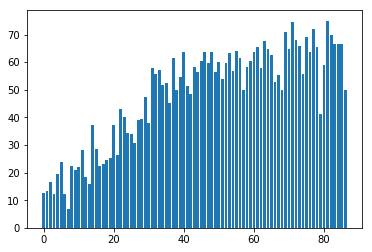

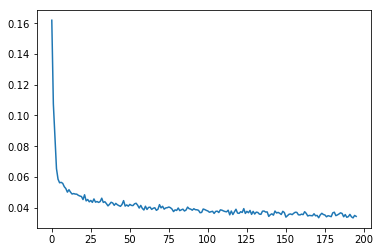

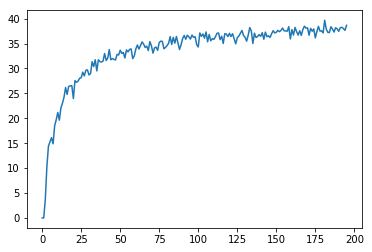

Train Epoch: 391 [0/65192 (0%)]	Loss: 0.046517
Train Epoch: 391 [6400/65192 (10%)]	Loss: 0.034865
Train Epoch: 391 [12800/65192 (20%)]	Loss: 0.036171
Train Epoch: 391 [19200/65192 (29%)]	Loss: 0.035564
Train Epoch: 391 [25600/65192 (39%)]	Loss: 0.039711
Train Epoch: 391 [32000/65192 (49%)]	Loss: 0.033251
Train Epoch: 391 [38400/65192 (59%)]	Loss: 0.030115
Train Epoch: 391 [44800/65192 (69%)]	Loss: 0.035453
Train Epoch: 391 [51200/65192 (79%)]	Loss: 0.039058
Train Epoch: 391 [57600/65192 (88%)]	Loss: 0.041206
Train Epoch: 391 [64000/65192 (98%)]	Loss: 0.046147
Train Epoch: 392 [0/65192 (0%)]	Loss: 0.036034
Train Epoch: 392 [6400/65192 (10%)]	Loss: 0.030921
Train Epoch: 392 [12800/65192 (20%)]	Loss: 0.034350
Train Epoch: 392 [19200/65192 (29%)]	Loss: 0.035970
Train Epoch: 392 [25600/65192 (39%)]	Loss: 0.039406
Train Epoch: 392 [32000/65192 (49%)]	Loss: 0.036402
Train Epoch: 392 [38400/65192 (59%)]	Loss: 0.042634
Train Epoch: 392 [44800/65192 (69%)]	Loss: 0.038184
Train Epoch: 392 [51200/

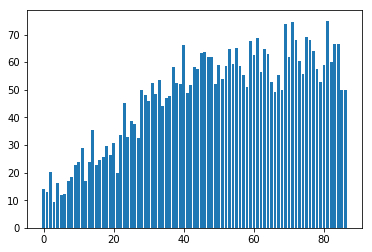

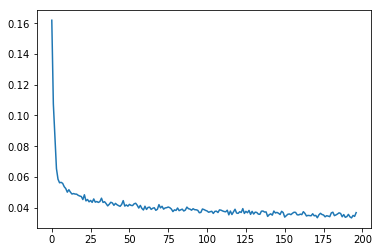

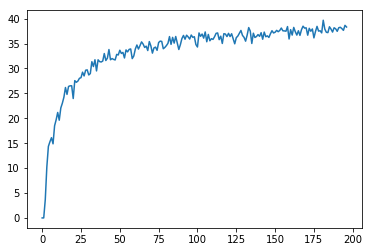

Train Epoch: 393 [0/65192 (0%)]	Loss: 0.028872
Train Epoch: 393 [6400/65192 (10%)]	Loss: 0.036981
Train Epoch: 393 [12800/65192 (20%)]	Loss: 0.029852
Train Epoch: 393 [19200/65192 (29%)]	Loss: 0.033812
Train Epoch: 393 [25600/65192 (39%)]	Loss: 0.036546
Train Epoch: 393 [32000/65192 (49%)]	Loss: 0.034012
Train Epoch: 393 [38400/65192 (59%)]	Loss: 0.032996
Train Epoch: 393 [44800/65192 (69%)]	Loss: 0.043240
Train Epoch: 393 [51200/65192 (79%)]	Loss: 0.038821
Train Epoch: 393 [57600/65192 (88%)]	Loss: 0.031803
Train Epoch: 393 [64000/65192 (98%)]	Loss: 0.028609
Train Epoch: 394 [0/65192 (0%)]	Loss: 0.039937
Train Epoch: 394 [6400/65192 (10%)]	Loss: 0.031831
Train Epoch: 394 [12800/65192 (20%)]	Loss: 0.038199
Train Epoch: 394 [19200/65192 (29%)]	Loss: 0.039042
Train Epoch: 394 [25600/65192 (39%)]	Loss: 0.036622
Train Epoch: 394 [32000/65192 (49%)]	Loss: 0.032435
Train Epoch: 394 [38400/65192 (59%)]	Loss: 0.037588
Train Epoch: 394 [44800/65192 (69%)]	Loss: 0.050497
Train Epoch: 394 [51200/

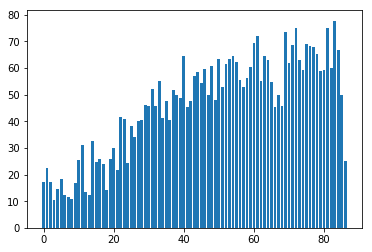

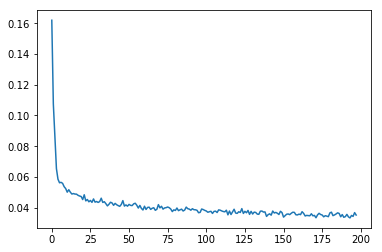

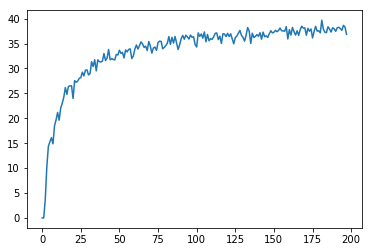

Train Epoch: 395 [0/65192 (0%)]	Loss: 0.030645
Train Epoch: 395 [6400/65192 (10%)]	Loss: 0.028580
Train Epoch: 395 [12800/65192 (20%)]	Loss: 0.035100
Train Epoch: 395 [19200/65192 (29%)]	Loss: 0.042394
Train Epoch: 395 [25600/65192 (39%)]	Loss: 0.040561
Train Epoch: 395 [32000/65192 (49%)]	Loss: 0.032206
Train Epoch: 395 [38400/65192 (59%)]	Loss: 0.032918
Train Epoch: 395 [44800/65192 (69%)]	Loss: 0.036661
Train Epoch: 395 [51200/65192 (79%)]	Loss: 0.037945
Train Epoch: 395 [57600/65192 (88%)]	Loss: 0.044829
Train Epoch: 395 [64000/65192 (98%)]	Loss: 0.033628
Train Epoch: 396 [0/65192 (0%)]	Loss: 0.037901
Train Epoch: 396 [6400/65192 (10%)]	Loss: 0.031499
Train Epoch: 396 [12800/65192 (20%)]	Loss: 0.044246
Train Epoch: 396 [19200/65192 (29%)]	Loss: 0.030332
Train Epoch: 396 [25600/65192 (39%)]	Loss: 0.030812
Train Epoch: 396 [32000/65192 (49%)]	Loss: 0.040047
Train Epoch: 396 [38400/65192 (59%)]	Loss: 0.030988
Train Epoch: 396 [44800/65192 (69%)]	Loss: 0.032162
Train Epoch: 396 [51200/

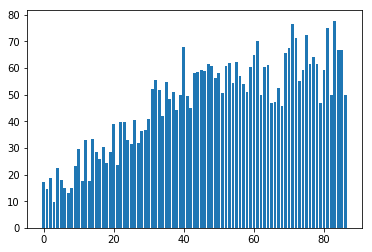

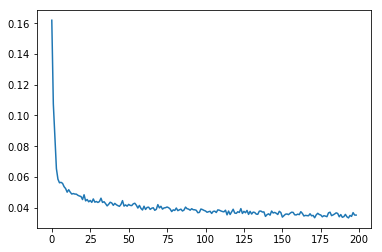

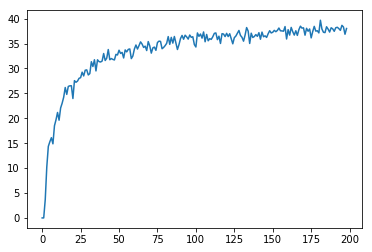

Train Epoch: 397 [0/65192 (0%)]	Loss: 0.037026
Train Epoch: 397 [6400/65192 (10%)]	Loss: 0.036195
Train Epoch: 397 [12800/65192 (20%)]	Loss: 0.028672
Train Epoch: 397 [19200/65192 (29%)]	Loss: 0.037190
Train Epoch: 397 [25600/65192 (39%)]	Loss: 0.032635
Train Epoch: 397 [32000/65192 (49%)]	Loss: 0.030001
Train Epoch: 397 [38400/65192 (59%)]	Loss: 0.040427
Train Epoch: 397 [44800/65192 (69%)]	Loss: 0.045626
Train Epoch: 397 [51200/65192 (79%)]	Loss: 0.034251
Train Epoch: 397 [57600/65192 (88%)]	Loss: 0.040338
Train Epoch: 397 [64000/65192 (98%)]	Loss: 0.029096
Train Epoch: 398 [0/65192 (0%)]	Loss: 0.038133
Train Epoch: 398 [6400/65192 (10%)]	Loss: 0.038138
Train Epoch: 398 [12800/65192 (20%)]	Loss: 0.035637
Train Epoch: 398 [19200/65192 (29%)]	Loss: 0.034382
Train Epoch: 398 [25600/65192 (39%)]	Loss: 0.033741
Train Epoch: 398 [32000/65192 (49%)]	Loss: 0.028584
Train Epoch: 398 [38400/65192 (59%)]	Loss: 0.044483
Train Epoch: 398 [44800/65192 (69%)]	Loss: 0.032270
Train Epoch: 398 [51200/

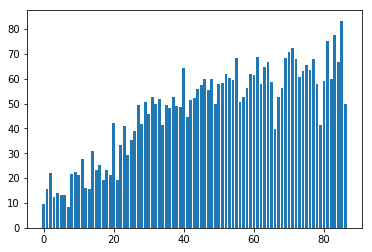

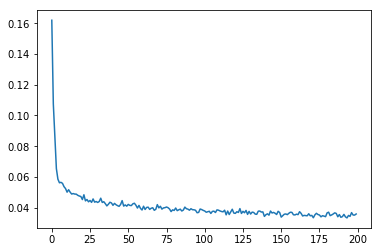

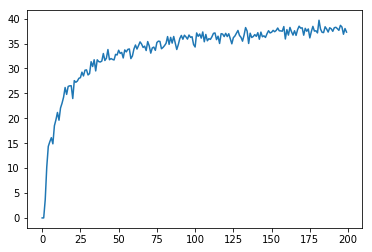

Train Epoch: 399 [0/65192 (0%)]	Loss: 0.032455
Train Epoch: 399 [6400/65192 (10%)]	Loss: 0.039637
Train Epoch: 399 [12800/65192 (20%)]	Loss: 0.045501
Train Epoch: 399 [19200/65192 (29%)]	Loss: 0.034748
Train Epoch: 399 [25600/65192 (39%)]	Loss: 0.036608
Train Epoch: 399 [32000/65192 (49%)]	Loss: 0.031964
Train Epoch: 399 [38400/65192 (59%)]	Loss: 0.030761
Train Epoch: 399 [44800/65192 (69%)]	Loss: 0.029575
Train Epoch: 399 [51200/65192 (79%)]	Loss: 0.032236
Train Epoch: 399 [57600/65192 (88%)]	Loss: 0.037906
Train Epoch: 399 [64000/65192 (98%)]	Loss: 0.029717
Train Epoch: 400 [0/65192 (0%)]	Loss: 0.040243
Train Epoch: 400 [6400/65192 (10%)]	Loss: 0.033740
Train Epoch: 400 [12800/65192 (20%)]	Loss: 0.033624
Train Epoch: 400 [19200/65192 (29%)]	Loss: 0.025110
Train Epoch: 400 [25600/65192 (39%)]	Loss: 0.031636
Train Epoch: 400 [32000/65192 (49%)]	Loss: 0.038899
Train Epoch: 400 [38400/65192 (59%)]	Loss: 0.032275
Train Epoch: 400 [44800/65192 (69%)]	Loss: 0.031733
Train Epoch: 400 [51200/

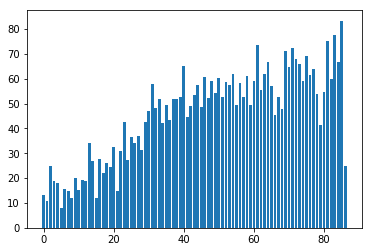

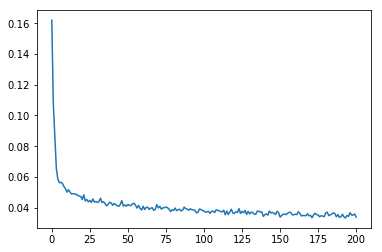

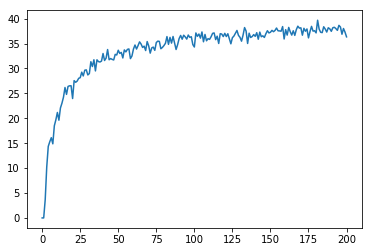

Train Epoch: 401 [0/65192 (0%)]	Loss: 0.039883
Train Epoch: 401 [6400/65192 (10%)]	Loss: 0.049258
Train Epoch: 401 [12800/65192 (20%)]	Loss: 0.040827
Train Epoch: 401 [19200/65192 (29%)]	Loss: 0.035749
Train Epoch: 401 [25600/65192 (39%)]	Loss: 0.040062
Train Epoch: 401 [32000/65192 (49%)]	Loss: 0.039666
Train Epoch: 401 [38400/65192 (59%)]	Loss: 0.036042
Train Epoch: 401 [44800/65192 (69%)]	Loss: 0.040524
Train Epoch: 401 [51200/65192 (79%)]	Loss: 0.038341
Train Epoch: 401 [57600/65192 (88%)]	Loss: 0.033723
Train Epoch: 401 [64000/65192 (98%)]	Loss: 0.037172
Train Epoch: 402 [0/65192 (0%)]	Loss: 0.037311
Train Epoch: 402 [6400/65192 (10%)]	Loss: 0.028592
Train Epoch: 402 [12800/65192 (20%)]	Loss: 0.036726
Train Epoch: 402 [19200/65192 (29%)]	Loss: 0.033873
Train Epoch: 402 [25600/65192 (39%)]	Loss: 0.038443
Train Epoch: 402 [32000/65192 (49%)]	Loss: 0.031635
Train Epoch: 402 [38400/65192 (59%)]	Loss: 0.036237
Train Epoch: 402 [44800/65192 (69%)]	Loss: 0.036262
Train Epoch: 402 [51200/

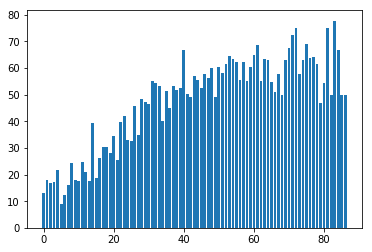

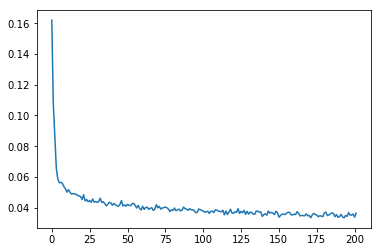

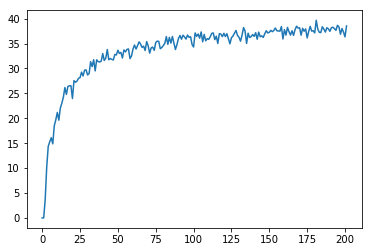

Train Epoch: 403 [0/65192 (0%)]	Loss: 0.037474
Train Epoch: 403 [6400/65192 (10%)]	Loss: 0.026017
Train Epoch: 403 [12800/65192 (20%)]	Loss: 0.041501
Train Epoch: 403 [19200/65192 (29%)]	Loss: 0.036243
Train Epoch: 403 [25600/65192 (39%)]	Loss: 0.037357
Train Epoch: 403 [32000/65192 (49%)]	Loss: 0.036328
Train Epoch: 403 [38400/65192 (59%)]	Loss: 0.036237
Train Epoch: 403 [44800/65192 (69%)]	Loss: 0.034968
Train Epoch: 403 [51200/65192 (79%)]	Loss: 0.039266
Train Epoch: 403 [57600/65192 (88%)]	Loss: 0.053318
Train Epoch: 403 [64000/65192 (98%)]	Loss: 0.037164
Train Epoch: 404 [0/65192 (0%)]	Loss: 0.041495
Train Epoch: 404 [6400/65192 (10%)]	Loss: 0.038405
Train Epoch: 404 [12800/65192 (20%)]	Loss: 0.030496
Train Epoch: 404 [19200/65192 (29%)]	Loss: 0.044644
Train Epoch: 404 [25600/65192 (39%)]	Loss: 0.022352
Train Epoch: 404 [32000/65192 (49%)]	Loss: 0.028160
Train Epoch: 404 [38400/65192 (59%)]	Loss: 0.028107
Train Epoch: 404 [44800/65192 (69%)]	Loss: 0.037687
Train Epoch: 404 [51200/

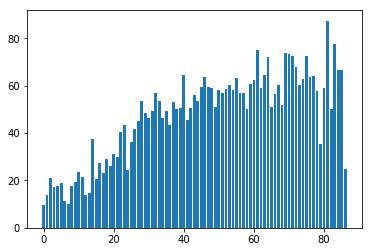

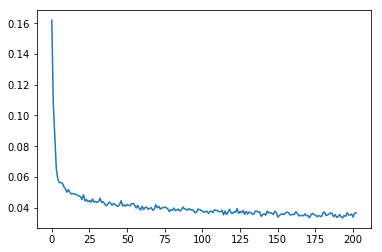

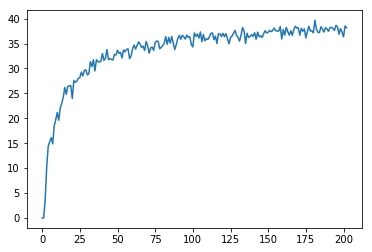

Train Epoch: 405 [0/65192 (0%)]	Loss: 0.041721
Train Epoch: 405 [6400/65192 (10%)]	Loss: 0.029998
Train Epoch: 405 [12800/65192 (20%)]	Loss: 0.047350
Train Epoch: 405 [19200/65192 (29%)]	Loss: 0.034509
Train Epoch: 405 [25600/65192 (39%)]	Loss: 0.039930
Train Epoch: 405 [32000/65192 (49%)]	Loss: 0.042809
Train Epoch: 405 [38400/65192 (59%)]	Loss: 0.037116
Train Epoch: 405 [44800/65192 (69%)]	Loss: 0.039184
Train Epoch: 405 [51200/65192 (79%)]	Loss: 0.038604
Train Epoch: 405 [57600/65192 (88%)]	Loss: 0.037357
Train Epoch: 405 [64000/65192 (98%)]	Loss: 0.035740
Train Epoch: 406 [0/65192 (0%)]	Loss: 0.034689
Train Epoch: 406 [6400/65192 (10%)]	Loss: 0.034410
Train Epoch: 406 [12800/65192 (20%)]	Loss: 0.043435
Train Epoch: 406 [19200/65192 (29%)]	Loss: 0.035774
Train Epoch: 406 [25600/65192 (39%)]	Loss: 0.033873
Train Epoch: 406 [32000/65192 (49%)]	Loss: 0.040294
Train Epoch: 406 [38400/65192 (59%)]	Loss: 0.031634
Train Epoch: 406 [44800/65192 (69%)]	Loss: 0.029248
Train Epoch: 406 [51200/

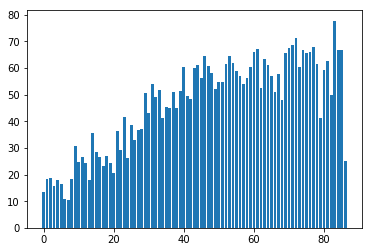

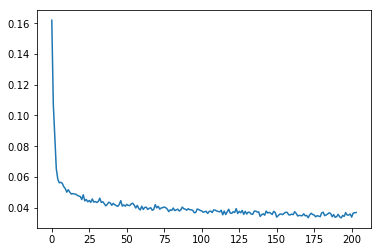

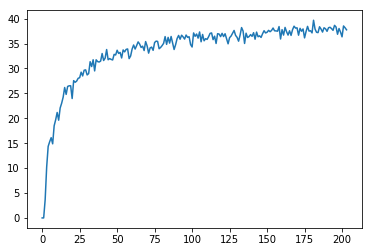

Train Epoch: 407 [0/65192 (0%)]	Loss: 0.032352
Train Epoch: 407 [6400/65192 (10%)]	Loss: 0.030805
Train Epoch: 407 [12800/65192 (20%)]	Loss: 0.032348
Train Epoch: 407 [19200/65192 (29%)]	Loss: 0.032720
Train Epoch: 407 [25600/65192 (39%)]	Loss: 0.035400
Train Epoch: 407 [32000/65192 (49%)]	Loss: 0.034892
Train Epoch: 407 [38400/65192 (59%)]	Loss: 0.039144
Train Epoch: 407 [44800/65192 (69%)]	Loss: 0.034726
Train Epoch: 407 [51200/65192 (79%)]	Loss: 0.042569
Train Epoch: 407 [57600/65192 (88%)]	Loss: 0.037334
Train Epoch: 407 [64000/65192 (98%)]	Loss: 0.025382
Train Epoch: 408 [0/65192 (0%)]	Loss: 0.032075
Train Epoch: 408 [6400/65192 (10%)]	Loss: 0.027885
Train Epoch: 408 [12800/65192 (20%)]	Loss: 0.030564
Train Epoch: 408 [19200/65192 (29%)]	Loss: 0.033323
Train Epoch: 408 [25600/65192 (39%)]	Loss: 0.039848
Train Epoch: 408 [32000/65192 (49%)]	Loss: 0.036303
Train Epoch: 408 [38400/65192 (59%)]	Loss: 0.034925
Train Epoch: 408 [44800/65192 (69%)]	Loss: 0.033936
Train Epoch: 408 [51200/

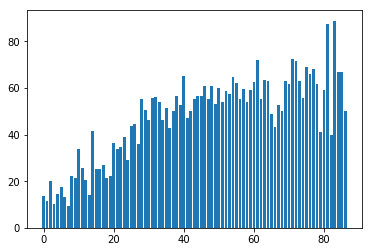

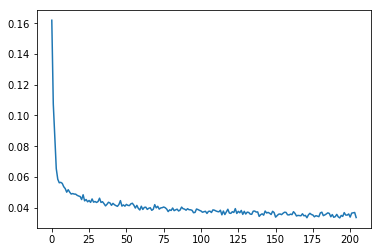

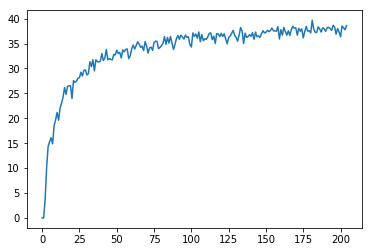

Train Epoch: 409 [0/65192 (0%)]	Loss: 0.031621
Train Epoch: 409 [6400/65192 (10%)]	Loss: 0.040100
Train Epoch: 409 [12800/65192 (20%)]	Loss: 0.032642
Train Epoch: 409 [19200/65192 (29%)]	Loss: 0.027131
Train Epoch: 409 [25600/65192 (39%)]	Loss: 0.038037
Train Epoch: 409 [32000/65192 (49%)]	Loss: 0.032169
Train Epoch: 409 [38400/65192 (59%)]	Loss: 0.033601
Train Epoch: 409 [44800/65192 (69%)]	Loss: 0.032666
Train Epoch: 409 [51200/65192 (79%)]	Loss: 0.027519
Train Epoch: 409 [57600/65192 (88%)]	Loss: 0.038374
Train Epoch: 409 [64000/65192 (98%)]	Loss: 0.033538
Train Epoch: 410 [0/65192 (0%)]	Loss: 0.031856
Train Epoch: 410 [6400/65192 (10%)]	Loss: 0.035777
Train Epoch: 410 [12800/65192 (20%)]	Loss: 0.044538
Train Epoch: 410 [19200/65192 (29%)]	Loss: 0.036429
Train Epoch: 410 [25600/65192 (39%)]	Loss: 0.030516
Train Epoch: 410 [32000/65192 (49%)]	Loss: 0.044273
Train Epoch: 410 [38400/65192 (59%)]	Loss: 0.036126
Train Epoch: 410 [44800/65192 (69%)]	Loss: 0.033407
Train Epoch: 410 [51200/

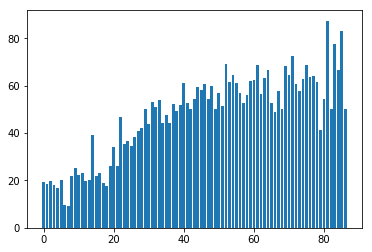

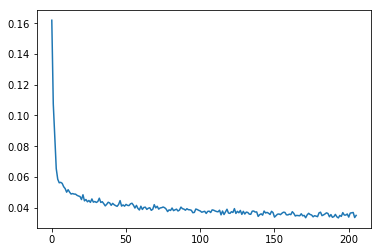

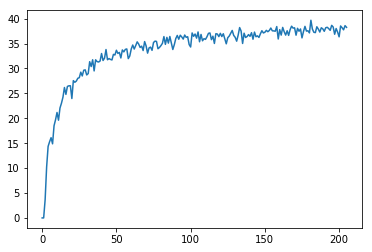

Train Epoch: 411 [0/65192 (0%)]	Loss: 0.020914
Train Epoch: 411 [6400/65192 (10%)]	Loss: 0.037777
Train Epoch: 411 [12800/65192 (20%)]	Loss: 0.037221
Train Epoch: 411 [19200/65192 (29%)]	Loss: 0.034695
Train Epoch: 411 [25600/65192 (39%)]	Loss: 0.042717
Train Epoch: 411 [32000/65192 (49%)]	Loss: 0.033151
Train Epoch: 411 [38400/65192 (59%)]	Loss: 0.023621
Train Epoch: 411 [44800/65192 (69%)]	Loss: 0.030617
Train Epoch: 411 [51200/65192 (79%)]	Loss: 0.031910
Train Epoch: 411 [57600/65192 (88%)]	Loss: 0.028962
Train Epoch: 411 [64000/65192 (98%)]	Loss: 0.038990
Train Epoch: 412 [0/65192 (0%)]	Loss: 0.033693
Train Epoch: 412 [6400/65192 (10%)]	Loss: 0.033612
Train Epoch: 412 [12800/65192 (20%)]	Loss: 0.033019
Train Epoch: 412 [19200/65192 (29%)]	Loss: 0.030306
Train Epoch: 412 [25600/65192 (39%)]	Loss: 0.034925
Train Epoch: 412 [32000/65192 (49%)]	Loss: 0.036143
Train Epoch: 412 [38400/65192 (59%)]	Loss: 0.034045
Train Epoch: 412 [44800/65192 (69%)]	Loss: 0.040128
Train Epoch: 412 [51200/

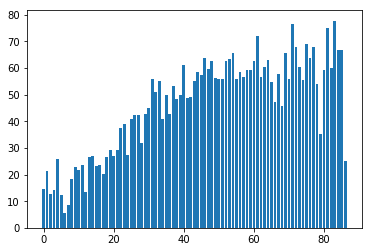

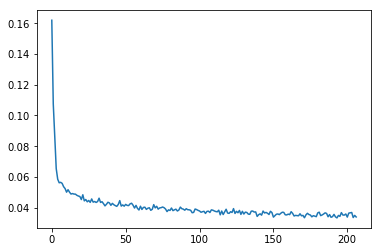

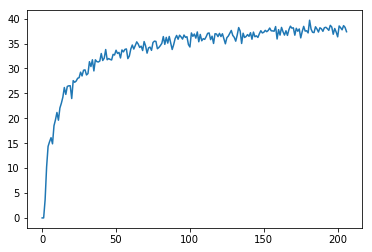

Train Epoch: 413 [0/65192 (0%)]	Loss: 0.035182
Train Epoch: 413 [6400/65192 (10%)]	Loss: 0.025867
Train Epoch: 413 [12800/65192 (20%)]	Loss: 0.036168
Train Epoch: 413 [19200/65192 (29%)]	Loss: 0.042398
Train Epoch: 413 [25600/65192 (39%)]	Loss: 0.031660
Train Epoch: 413 [32000/65192 (49%)]	Loss: 0.033712
Train Epoch: 413 [38400/65192 (59%)]	Loss: 0.030342
Train Epoch: 413 [44800/65192 (69%)]	Loss: 0.035800
Train Epoch: 413 [51200/65192 (79%)]	Loss: 0.037324
Train Epoch: 413 [57600/65192 (88%)]	Loss: 0.040225
Train Epoch: 413 [64000/65192 (98%)]	Loss: 0.035707
Train Epoch: 414 [0/65192 (0%)]	Loss: 0.036116
Train Epoch: 414 [6400/65192 (10%)]	Loss: 0.026972
Train Epoch: 414 [12800/65192 (20%)]	Loss: 0.035889
Train Epoch: 414 [19200/65192 (29%)]	Loss: 0.044072
Train Epoch: 414 [25600/65192 (39%)]	Loss: 0.043539
Train Epoch: 414 [32000/65192 (49%)]	Loss: 0.021296
Train Epoch: 414 [38400/65192 (59%)]	Loss: 0.039645
Train Epoch: 414 [44800/65192 (69%)]	Loss: 0.031444
Train Epoch: 414 [51200/

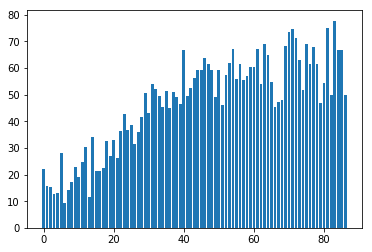

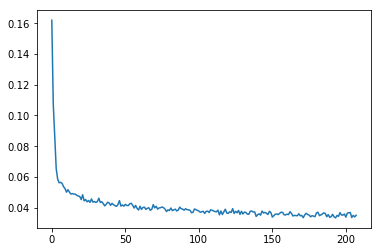

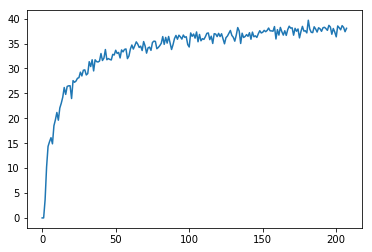

Train Epoch: 415 [0/65192 (0%)]	Loss: 0.037210
Train Epoch: 415 [6400/65192 (10%)]	Loss: 0.045709
Train Epoch: 415 [12800/65192 (20%)]	Loss: 0.026285
Train Epoch: 415 [19200/65192 (29%)]	Loss: 0.033107
Train Epoch: 415 [25600/65192 (39%)]	Loss: 0.041407
Train Epoch: 415 [32000/65192 (49%)]	Loss: 0.033507
Train Epoch: 415 [38400/65192 (59%)]	Loss: 0.029373
Train Epoch: 415 [44800/65192 (69%)]	Loss: 0.035522
Train Epoch: 415 [51200/65192 (79%)]	Loss: 0.032349
Train Epoch: 415 [57600/65192 (88%)]	Loss: 0.033237
Train Epoch: 415 [64000/65192 (98%)]	Loss: 0.034601
Train Epoch: 416 [0/65192 (0%)]	Loss: 0.033785
Train Epoch: 416 [6400/65192 (10%)]	Loss: 0.032354
Train Epoch: 416 [12800/65192 (20%)]	Loss: 0.035939
Train Epoch: 416 [19200/65192 (29%)]	Loss: 0.039269
Train Epoch: 416 [25600/65192 (39%)]	Loss: 0.032703
Train Epoch: 416 [32000/65192 (49%)]	Loss: 0.029235
Train Epoch: 416 [38400/65192 (59%)]	Loss: 0.032568
Train Epoch: 416 [44800/65192 (69%)]	Loss: 0.033987
Train Epoch: 416 [51200/

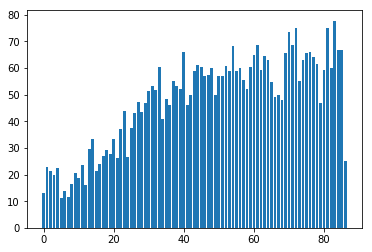

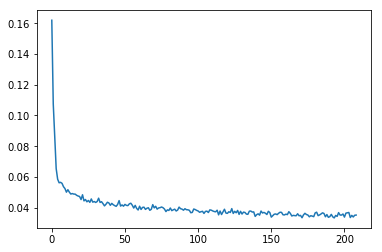

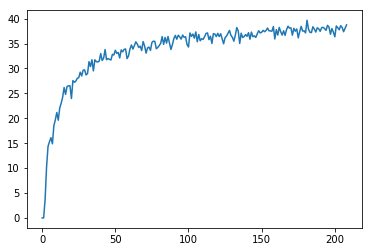

Train Epoch: 417 [0/65192 (0%)]	Loss: 0.034005
Train Epoch: 417 [6400/65192 (10%)]	Loss: 0.026262
Train Epoch: 417 [12800/65192 (20%)]	Loss: 0.030136
Train Epoch: 417 [19200/65192 (29%)]	Loss: 0.034786
Train Epoch: 417 [25600/65192 (39%)]	Loss: 0.029117
Train Epoch: 417 [32000/65192 (49%)]	Loss: 0.027044
Train Epoch: 417 [38400/65192 (59%)]	Loss: 0.038525
Train Epoch: 417 [44800/65192 (69%)]	Loss: 0.032905
Train Epoch: 417 [51200/65192 (79%)]	Loss: 0.034595
Train Epoch: 417 [57600/65192 (88%)]	Loss: 0.028972
Train Epoch: 417 [64000/65192 (98%)]	Loss: 0.033466
Train Epoch: 418 [0/65192 (0%)]	Loss: 0.029002
Train Epoch: 418 [6400/65192 (10%)]	Loss: 0.029316
Train Epoch: 418 [12800/65192 (20%)]	Loss: 0.025256
Train Epoch: 418 [19200/65192 (29%)]	Loss: 0.027582
Train Epoch: 418 [25600/65192 (39%)]	Loss: 0.036230
Train Epoch: 418 [32000/65192 (49%)]	Loss: 0.039746
Train Epoch: 418 [38400/65192 (59%)]	Loss: 0.045741
Train Epoch: 418 [44800/65192 (69%)]	Loss: 0.037879
Train Epoch: 418 [51200/

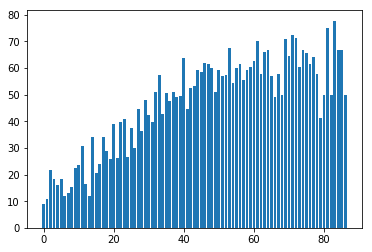

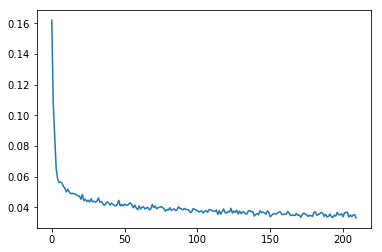

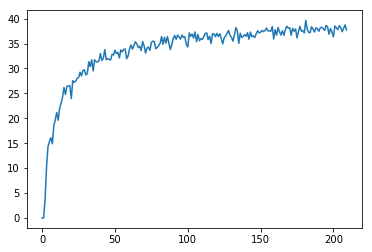

Train Epoch: 419 [0/65192 (0%)]	Loss: 0.032435
Train Epoch: 419 [6400/65192 (10%)]	Loss: 0.023715
Train Epoch: 419 [12800/65192 (20%)]	Loss: 0.047013
Train Epoch: 419 [19200/65192 (29%)]	Loss: 0.031376
Train Epoch: 419 [25600/65192 (39%)]	Loss: 0.030615
Train Epoch: 419 [32000/65192 (49%)]	Loss: 0.025938
Train Epoch: 419 [38400/65192 (59%)]	Loss: 0.030798
Train Epoch: 419 [44800/65192 (69%)]	Loss: 0.037298
Train Epoch: 419 [51200/65192 (79%)]	Loss: 0.035108
Train Epoch: 419 [57600/65192 (88%)]	Loss: 0.041422
Train Epoch: 419 [64000/65192 (98%)]	Loss: 0.031648
Train Epoch: 420 [0/65192 (0%)]	Loss: 0.030226
Train Epoch: 420 [6400/65192 (10%)]	Loss: 0.039283
Train Epoch: 420 [12800/65192 (20%)]	Loss: 0.027178
Train Epoch: 420 [19200/65192 (29%)]	Loss: 0.031902
Train Epoch: 420 [25600/65192 (39%)]	Loss: 0.028099
Train Epoch: 420 [32000/65192 (49%)]	Loss: 0.029705
Train Epoch: 420 [38400/65192 (59%)]	Loss: 0.036222
Train Epoch: 420 [44800/65192 (69%)]	Loss: 0.029466
Train Epoch: 420 [51200/

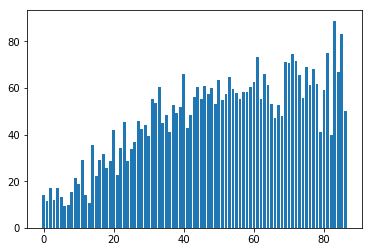

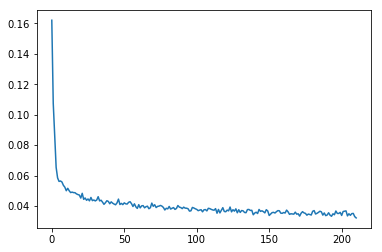

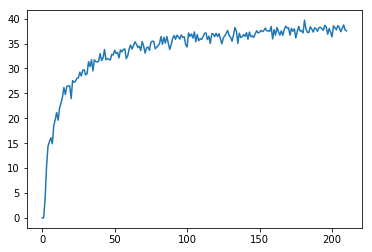

Train Epoch: 421 [0/65192 (0%)]	Loss: 0.026897
Train Epoch: 421 [6400/65192 (10%)]	Loss: 0.032909
Train Epoch: 421 [12800/65192 (20%)]	Loss: 0.030872


KeyboardInterrupt: 

In [86]:
epochs=3000
log_interval=100
lossplot=[]
percentplot=[]
# run the main training loop
lossav=[]
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.data.item()))
            lossav.append(loss.data.item())
            
    if epoch % 2==0:
        percentplot.append(test_score(test_loader))
#         percentplot.append(test_score(train_loader))
        lossplot.append(np.average([lossav]))
 
        plt.figure()
        plt.plot(lossplot)
        plt.figure()
        plt.plot(percentplot)
        plt.show()
        lossav=[]
        #test_func(test_loader)

0.0
10000.0
0.0


/Users/shalti/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide


0.0

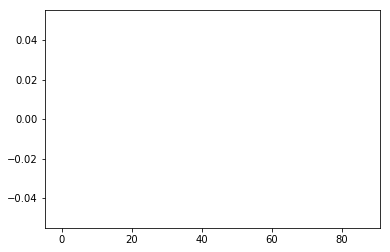

In [62]:
def test_score(load):
    notetrue = np.zeros([C])
    notefalse = np.zeros([C])
    notefalsepositve=0
    notefalsenegative=0

    for batch_idx, (data, target) in enumerate(load):
            optimizer.zero_grad()
            net_out = net(data)
            loss = criterion(net_out, target)
            distance=net_out-torch.mean(net_out)
            out=(net_out>-0.3).float()*1
            for o,t in zip(out,target):

                if np.array_equal(o.nonzero().numpy(),t.nonzero().numpy()):
                    notetrue[int(t.nonzero().numpy()[0][0])]+=1
                else:
                    notefalse[int(t.nonzero().numpy()[0][0])]+=1
                continue;

    print(sum(notetrue))
    print(sum(notefalse))
    print(100.0*sum(notetrue)/sum(notetrue+notefalse))
    a=100.0*sum(notetrue)/sum(notetrue+notefalse)
    plt.bar([x for x in range(C)],100.0*notetrue/(notetrue+notefalse))
    return a
test_score(test_loader)


In [219]:
for g in optimizer.param_groups:
    g['lr']=0.6
    g['momentum']=0.5

In [239]:
#deploy for onnx
dummy_input = torch.randn(1, buf)
torch.onnx.export(net, dummy_input, PATH+"nn_pianovstup_1024X3_poly2c.onnx")

In [808]:

# Load the ONNX model
model = onnx.load(PATH+"nn_pianovstup_1024X3_poly2.onnx")
# Check that the IR is well formed
onnx.checker.check_model(model)
# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)


u'graph torch-jit-export (\n  %0[FLOAT, 1x1536]\n) optional inputs with matching initializers (\n  %conv1.weight[FLOAT, 1x3x1]\n  %conv1.bias[FLOAT, 1]\n  %fc.weight[FLOAT, 196x512]\n  %fc4.weight[FLOAT, 88x196]\n) {\n  %5 = Constant[value = <Tensor>]()\n  %6 = Reshape(%0, %5)\n  %7 = Slice[axes = [2], ends = [512], starts = [0]](%6)\n  %8 = Conv[dilations = [1], group = 1, kernel_shape = [1], pads = [0, 0], strides = [1]](%7, %conv1.weight, %conv1.bias)\n  %9 = Relu(%8)\n  %10 = MaxPool[kernel_shape = [1], pads = [0, 0], strides = [1]](%9)\n  %11 = Constant[value = <Tensor>]()\n  %12 = Reshape(%10, %11)\n  %13 = Transpose[perm = [1, 0]](%fc.weight)\n  %14 = MatMul(%12, %13)\n  %15 = Relu(%14)\n  %16 = Transpose[perm = [1, 0]](%fc4.weight)\n  %17 = MatMul(%15, %16)\n  return %17\n}'

In [9]:
a = torch.randn(1, 3, 164)  
m = nn.Conv1d(3, 3, 3,dilation=8,padding=(8) )
p = nn.MaxPool1d(3,1,padding=1)
out = p(m(a))
print(out.size())
print(m)

torch.Size([1, 3, 164])
Conv1d(3, 3, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
